In [3]:
%pip install -U cbsodata
import pandas as pd, csv, re
import csv
import cbsodata
import numpy as np
import re
import importlib, functions
importlib.reload(functions)
from functions import decode_statline_local, extract_statline_maps, decode_nationaliteit,decode_using_meta_any, decode_columns_with_maps, norm_key, norm_text, extract_block, cbs_code_map, cbs_decode_columns, add_period_parts, get_meta
from io import StringIO
from datetime import datetime
from math import prod
from cbsodata import get_meta
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
from matplotlib.colors import LinearSegmentedColormap
from scipy.stats import chi2_contingency, stats
import itertools
import scipy, scipy.stats as ss

  Using cached cbsodata-1.3.5-py3-none-any.whl.metadata (7.8 kB)
Using cached cbsodata-1.3.5-py3-none-any.whl (12 kB)
Note: you may need to restart the kernel to use updated packages.


## Asylum

### Asylum applicants

In [4]:
asylum_csv = "datasets/asielzoekers/niet nareis/84809NED_UntypedDataSet_14092025_161302.csv"
asylum = pd.read_csv(asylum_csv, sep=";")
asylum

C:\Users\gabyt\AppData\Local\Temp\ipykernel_40496\3144529612.py:2: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  asylum = pd.read_csv(asylum_csv, sep=";")


ID  Geslacht Leeftijd Migratiemotief  \
0       22674600      3000  A049126        A052712   
1       22674601      3000  A049126        A052712   
2       22674602      3000  A049126        A052712   
3       22674603      3000  A049126        A052712   
4       22674604      3000  A049126        A052712   
...          ...       ...      ...            ...   
987995  49251795      4000    21000        A052712   
987996  49251796      4000    21000        A052712   
987997  49251797      4000    21000        A052712   
987998  49251798      4000    21000        A052712   
987999  49251799      4000    21000        A052712   

        SociaaleconomischeCategorie Nationaliteit Verblijfsduur  \
0                           2016850       T001059       A027954   
1                           2016850       T001059       A027954   
2                           2016850       T001059       A027954   
3                           2016850       T001059       A027954   
4                           2016850       T001059       A027954   
...                             ...           ...           ...   
987995                      2820723       NAT9999       A027978   
987996                      2820723       NAT9999       A027978   
987997                      2820723       NAT9999       A027978   
987998                      2820723       NAT9999       A027978   
987999                      2820723       NAT9999       A027978   

       JaarVanImmigratie  ImmigrantenExclusiefEUEFTA_1  
0               1999JJ00                          50.0  
1               2000JJ00                          40.0  
2               2001JJ00                          50.0  
3               2002JJ00                          35.0  
4               2003JJ00                          10.0  
...                  ...                           ...  
987995          2020JJ00                           NaN  
987996          2021JJ00                           NaN  
987997          2022JJ00                           NaN  
987998          2023JJ00                           NaN  
987999          2024JJ00                           NaN  

[988000 rows x 9 columns]

In [5]:
asylum = decode_using_meta_any(
    asylum,
    "datasets/asielzoekers/niet nareis/84809NED_metadata.csv"  # <-- metadata file
)
asylum = decode_columns_with_maps(
    asylum,
    meta_path="datasets/asielzoekers/niet nareis/84809NED_metadata.csv",
    columns=[
        "Geslacht","Leeftijd","Migratiemotief",
        "Nationaliteit","SociaaleconomischeCategorie",
        "Verblijfsduur","JaarVanImmigratie"
    ]
)
asylum

ID Geslacht          Leeftijd            Migratiemotief  \
0       22674600   Mannen     0 tot 18 jaar  Asiel (exclusief nareis)   
1       22674601   Mannen     0 tot 18 jaar  Asiel (exclusief nareis)   
2       22674602   Mannen     0 tot 18 jaar  Asiel (exclusief nareis)   
3       22674603   Mannen     0 tot 18 jaar  Asiel (exclusief nareis)   
4       22674604   Mannen     0 tot 18 jaar  Asiel (exclusief nareis)   
...          ...      ...               ...                       ...   
987995  49251795  Vrouwen  40 jaar of ouder  Asiel (exclusief nareis)   
987996  49251796  Vrouwen  40 jaar of ouder  Asiel (exclusief nareis)   
987997  49251797  Vrouwen  40 jaar of ouder  Asiel (exclusief nareis)   
987998  49251798  Vrouwen  40 jaar of ouder  Asiel (exclusief nareis)   
987999  49251799  Vrouwen  40 jaar of ouder  Asiel (exclusief nareis)   

       SociaaleconomischeCategorie            Nationaliteit Verblijfsduur  \
0        Werknemer en zelfstandige                   Totaal        1 jaar   
1        Werknemer en zelfstandige                   Totaal        1 jaar   
2        Werknemer en zelfstandige                   Totaal        1 jaar   
3        Werknemer en zelfstandige                   Totaal        1 jaar   
4        Werknemer en zelfstandige                   Totaal        1 jaar   
...                            ...                      ...           ...   
987995             Nog niet bekend  Overige nationaliteiten       25 jaar   
987996             Nog niet bekend  Overige nationaliteiten       25 jaar   
987997             Nog niet bekend  Overige nationaliteiten       25 jaar   
987998             Nog niet bekend  Overige nationaliteiten       25 jaar   
987999             Nog niet bekend  Overige nationaliteiten       25 jaar   

       JaarVanImmigratie  ImmigrantenExclusiefEUEFTA_1  
0                   1999                          50.0  
1                   2000                          40.0  
2                   2001                          50.0  
3                   2002                          35.0  
4                   2003                          10.0  
...                  ...                           ...  
987995              2020                           NaN  
987996              2021                           NaN  
987997              2022                           NaN  
987998              2023                           NaN  
987999              2024                           NaN  

[988000 rows x 9 columns]

In [6]:
#distinct labels per dimension
asylum['Leeftijd'].value_counts()
asylum['Nationaliteit'].value_counts()
asylum['Geslacht'].value_counts()
asylum['SociaaleconomischeCategorie'].nunique()

5

In [7]:
asylum.columns

Index(['ID', 'Geslacht', 'Leeftijd', 'Migratiemotief',
       'SociaaleconomischeCategorie', 'Nationaliteit', 'Verblijfsduur',
       'JaarVanImmigratie', 'ImmigrantenExclusiefEUEFTA_1'],
      dtype='object')

In [8]:
asylum.rename(columns= {'ID': 'id', 'Geslacht': 'gender', 'Leeftijd': 'age', 'Nationaliteit': 'nationality', 'Migratiemotief': 'motive', 'SociaaleconomischeCategorie': 'status', 'Verblijfsduur': 'stay_duration_years', 'JaarVanImmigratie': 'immigration_year', 'ImmigrantenExclusiefEUEFTA_1': 'amount_immigrant'}, inplace=True)

In [9]:
asylum.isnull().any()

id                     False
gender                 False
age                    False
motive                 False
status                 False
nationality            False
stay_duration_years    False
immigration_year       False
amount_immigrant        True
dtype: bool

In [10]:
asylum.duplicated().any()

False

In [11]:
asylum.nunique()

id                     988000
gender                      2
age                         4
motive                      1
status                      5
nationality                38
stay_duration_years        25
immigration_year           26
amount_immigrant          571
dtype: int64

In [12]:
asylum.dtypes

id                       int64
gender                  object
age                     object
motive                  object
status                  object
nationality             object
stay_duration_years     object
immigration_year        object
amount_immigrant       float64
dtype: object

In [13]:
asylum["status"].unique()

array(['Werknemer en zelfstandige', 'Uitkerings- en pensioenontvanger',
       '(School)kind of student', 'Overige (zonder inkomen)',
       'Nog niet bekend'], dtype=object)

In [14]:
#Gender translation
asylum["gender"] = asylum["gender"].replace({
    "Mannen": "male",
    "Vrouwen": "female"
})

#Age translation
asylum["age"] = asylum["age"].replace({
    "0 tot 18 jaar": "0–18",
    "0 tot 18 jaar": "0-18",
    "18 tot 30 jaar": "18-30",
    "30 tot 40 jaar": "30-40",
    "40 jaar of ouder": "40+",
})

#Motive
asylum["motive"] = asylum["motive"].replace({
    "Asiel (exclusief nareis)": "asylum", 
})

#status translation
asylum["status"] = asylum["status"].replace({
    "Werknemer en zelfstandige": "employee_or_independent",
    "Uitkerings- en pensioenontvanger": "benefit_or_pension_recipient",
    "(School)kind of student": "student",
    "Overige (zonder inkomen)": "unemployed",
    "Nog niet bekend": "unknown",
})

In [15]:
asylum

id  gender   age  motive                   status  \
0       22674600    male  0-18  asylum  employee_or_independent   
1       22674601    male  0-18  asylum  employee_or_independent   
2       22674602    male  0-18  asylum  employee_or_independent   
3       22674603    male  0-18  asylum  employee_or_independent   
4       22674604    male  0-18  asylum  employee_or_independent   
...          ...     ...   ...     ...                      ...   
987995  49251795  female   40+  asylum                  unknown   
987996  49251796  female   40+  asylum                  unknown   
987997  49251797  female   40+  asylum                  unknown   
987998  49251798  female   40+  asylum                  unknown   
987999  49251799  female   40+  asylum                  unknown   

                    nationality stay_duration_years immigration_year  \
0                        Totaal              1 jaar             1999   
1                        Totaal              1 jaar             2000   
2                        Totaal              1 jaar             2001   
3                        Totaal              1 jaar             2002   
4                        Totaal              1 jaar             2003   
...                         ...                 ...              ...   
987995  Overige nationaliteiten             25 jaar             2020   
987996  Overige nationaliteiten             25 jaar             2021   
987997  Overige nationaliteiten             25 jaar             2022   
987998  Overige nationaliteiten             25 jaar             2023   
987999  Overige nationaliteiten             25 jaar             2024   

        amount_immigrant  
0                   50.0  
1                   40.0  
2                   50.0  
3                   35.0  
4                   10.0  
...                  ...  
987995               NaN  
987996               NaN  
987997               NaN  
987998               NaN  
987999               NaN  

[988000 rows x 9 columns]

In [16]:
# Remove any rows starting with "Totaal"
asylum = asylum[
    ~asylum["nationality"].str.startswith("Totaal")
]

In [17]:
# Remove " jaar" and convert to integer
asylum["stay_duration_years"] = (
    asylum["stay_duration_years"]
    .astype(str)                       # make sure it's a string
    .str.replace(" jaar", "", regex=False)  # remove ' jaar'
    .replace("nan", pd.NA)             # fix NaNs that turned into 'nan'
    .astype("Int64")                   # convert to Int64
)

# --- Clean immigration_year ---
asylum["immigration_year"] = (
    asylum["immigration_year"]
    .astype(str)                       # ensure string
    .str.extract(r"(\d{4})")[0]        # keep only 4-digit year
    .replace("nan", pd.NA)             # fix NaNs
    .astype("Int64")                   # convert to Int64
)

C:\Users\gabyt\AppData\Local\Temp\ipykernel_40496\3349004179.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  asylum["stay_duration_years"] = (
C:\Users\gabyt\AppData\Local\Temp\ipykernel_40496\3349004179.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  asylum["immigration_year"] = (


In [18]:
asylum

id  gender   age  motive                   status  \
650     22675250    male  0-18  asylum  employee_or_independent   
651     22675251    male  0-18  asylum  employee_or_independent   
652     22675252    male  0-18  asylum  employee_or_independent   
653     22675253    male  0-18  asylum  employee_or_independent   
654     22675254    male  0-18  asylum  employee_or_independent   
...          ...     ...   ...     ...                      ...   
987995  49251795  female   40+  asylum                  unknown   
987996  49251796  female   40+  asylum                  unknown   
987997  49251797  female   40+  asylum                  unknown   
987998  49251798  female   40+  asylum                  unknown   
987999  49251799  female   40+  asylum                  unknown   

                    nationality  stay_duration_years  immigration_year  \
650                      Afrika                    1              1999   
651                      Afrika                    1              2000   
652                      Afrika                    1              2001   
653                      Afrika                    1              2002   
654                      Afrika                    1              2003   
...                         ...                  ...               ...   
987995  Overige nationaliteiten                   25              2020   
987996  Overige nationaliteiten                   25              2021   
987997  Overige nationaliteiten                   25              2022   
987998  Overige nationaliteiten                   25              2023   
987999  Overige nationaliteiten                   25              2024   

        amount_immigrant  
650                  5.0  
651                  5.0  
652                  5.0  
653                 10.0  
654                  0.0  
...                  ...  
987995               NaN  
987996               NaN  
987997               NaN  
987998               NaN  
987999               NaN  

[962000 rows x 9 columns]

In [19]:
asylum["nationality"].unique()

array(['Afrika', 'Amerika', 'Azië', 'Europa (exclusief Nederlands)',
       'Oceanië', 'Afghaans', 'Amerikaans', 'Australisch', 'Braziliaans',
       'Brits', 'Bulgaars', 'Canadees', 'Chinees', 'Eritrees',
       'Filippijns', 'Hongaars', 'Indiaas', 'Indonesisch', 'Iraaks',
       'Iraans', 'Japans', 'Lets', 'Litouws', 'Marokkaans', 'Oekraïens',
       'Pools', 'Roemeens', 'Russisch', 'Slowaaks', 'Somalisch',
       'Surinaams', 'Syrisch', 'Turks', 'Zuid-Afrikaans', 'Zuid-Koreaans',
       'Staatloos / onbekend', 'Overige nationaliteiten'], dtype=object)

In [20]:
# df here is your non-EU dataset, e.g. family_not_eu or asylum
df = asylum  # ← change if needed

# 1) drop 'Totaal' only from nationality
drop = norm_text(df["nationality"]).str.match(r"^totaal\b")
df = df.loc[~drop].copy()

# 2) translate nationality with a normalized-key map
nat_map = {
    "Afrika": "africa",
    "Amerika": "america",
    "Azië": "asia", "Azie": "asia",
    "Europa (exclusief Nederlands)": "europe_(excluding_dutch)",
    "Oceanië": "oceania", "Oceanie": "oceania",
    "Afghaans": "afghan",
    "Amerikaans": "american",
    "Australisch": "australian",
    "Braziliaans": "brazilian",
    "Brits": "british",
    "Bulgaars": "bulgarian",
    "Canadees": "canadian",
    "Chinees": "chinese",
    "Eritrees": "eritrean", "Eritrese": "eritrean", "Eritreïsch": "eritrean",
    "Filippijns": "filipino", "Filipijns": "filipino",
    "Hongaars": "hungarian",
    "Indiaas": "indian",
    "Indonesisch": "indonesian",
    "Iraaks": "iraqi",
    "Iraans": "iranian",
    "Japans": "japanese",
    "Lets": "latvian",
    "Litouws": "lithuanian",
    "Marokkaans": "moroccan",
    "Oekraïens": "ukrainian", "Oekraïense": "ukrainian", "Oekraiense": "ukrainian",
    "Pools": "polish",
    "Roemeens": "romanian",
    "Russisch": "russian",
    "Slowaaks": "slovak",
    "Somalisch": "somali",
    "Surinaams": "surinamese",
    "Syrisch": "syrian",
    "Turks": "turkish",
    "Zuid-Afrikaans": "south_african",
    "Zuid-Koreaans": "south_korean",
    "Staatloos / onbekend": "stateless_or_unknown",
    "Overige nationaliteiten": "other_nationalities",
}
nat_map_norm = {norm_key(k): v for k, v in nat_map.items()}

nat_src = norm_text(df["nationality"])
nat = nat_src.map(nat_map_norm).fillna(nat_src)
asylum["nationality"] = (nat.str.replace(r"\s+","_",regex=True)
                        .str.replace(r"[^\w]","_",regex=True)
                        .str.replace(r"_+","_",regex=True)
                        .str.strip("_"))

# 3) quick audit
unmapped = sorted(set(nat_src.unique()) - set(nat_map_norm.keys()))
print("unmapped sample (add to map if needed):", unmapped[:20])

asylum

unmapped sample (add to map if needed): []


C:\Users\gabyt\AppData\Local\Temp\ipykernel_40496\150403060.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  asylum["nationality"] = (nat.str.replace(r"\s+","_",regex=True)


id  gender   age  motive                   status  \
650     22675250    male  0-18  asylum  employee_or_independent   
651     22675251    male  0-18  asylum  employee_or_independent   
652     22675252    male  0-18  asylum  employee_or_independent   
653     22675253    male  0-18  asylum  employee_or_independent   
654     22675254    male  0-18  asylum  employee_or_independent   
...          ...     ...   ...     ...                      ...   
987995  49251795  female   40+  asylum                  unknown   
987996  49251796  female   40+  asylum                  unknown   
987997  49251797  female   40+  asylum                  unknown   
987998  49251798  female   40+  asylum                  unknown   
987999  49251799  female   40+  asylum                  unknown   

                nationality  stay_duration_years  immigration_year  \
650                  africa                    1              1999   
651                  africa                    1              2000   
652                  africa                    1              2001   
653                  africa                    1              2002   
654                  africa                    1              2003   
...                     ...                  ...               ...   
987995  other_nationalities                   25              2020   
987996  other_nationalities                   25              2021   
987997  other_nationalities                   25              2022   
987998  other_nationalities                   25              2023   
987999  other_nationalities                   25              2024   

        amount_immigrant  
650                  5.0  
651                  5.0  
652                  5.0  
653                 10.0  
654                  0.0  
...                  ...  
987995               NaN  
987996               NaN  
987997               NaN  
987998               NaN  
987999               NaN  

[962000 rows x 9 columns]

### Asylum relatives

In [21]:
asylum_relatives_csv = "datasets/asielzoekers/nareis/84809NED_UntypedDataSet_14092025_161000.csv"
asylum_relatives = pd.read_csv(asylum_relatives_csv, sep=";")
asylum_relatives

C:\Users\gabyt\AppData\Local\Temp\ipykernel_40496\2195170893.py:2: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  asylum_relatives = pd.read_csv(asylum_relatives_csv, sep=";")


ID  Geslacht Leeftijd Migratiemotief  \
0       22847500      3000  A049126        A052713   
1       22847501      3000  A049126        A052713   
2       22847502      3000  A049126        A052713   
3       22847503      3000  A049126        A052713   
4       22847504      3000  A049126        A052713   
...          ...       ...      ...            ...   
987995  49424695      4000    21000        A052713   
987996  49424696      4000    21000        A052713   
987997  49424697      4000    21000        A052713   
987998  49424698      4000    21000        A052713   
987999  49424699      4000    21000        A052713   

        SociaaleconomischeCategorie Nationaliteit Verblijfsduur  \
0                           2016850       T001059       A027954   
1                           2016850       T001059       A027954   
2                           2016850       T001059       A027954   
3                           2016850       T001059       A027954   
4                           2016850       T001059       A027954   
...                             ...           ...           ...   
987995                      2820723       NAT9999       A027978   
987996                      2820723       NAT9999       A027978   
987997                      2820723       NAT9999       A027978   
987998                      2820723       NAT9999       A027978   
987999                      2820723       NAT9999       A027978   

       JaarVanImmigratie  ImmigrantenExclusiefEUEFTA_1  
0               1999JJ00                           NaN  
1               2000JJ00                           NaN  
2               2001JJ00                           NaN  
3               2002JJ00                           NaN  
4               2003JJ00                           NaN  
...                  ...                           ...  
987995          2020JJ00                           NaN  
987996          2021JJ00                           NaN  
987997          2022JJ00                           NaN  
987998          2023JJ00                           NaN  
987999          2024JJ00                           NaN  

[988000 rows x 9 columns]

In [22]:
asylum_relatives = decode_using_meta_any(
    asylum_relatives,
    "datasets/asielzoekers/nareis/84809NED_metadata.csv"  # <-- metadata file
)
asylum_relatives = decode_columns_with_maps(
    asylum_relatives,
    meta_path="datasets/asielzoekers/nareis/84809NED_metadata.csv",
    columns=[
        "Geslacht","Leeftijd","Migratiemotief",
        "Nationaliteit","SociaaleconomischeCategorie",
        "Verblijfsduur","JaarVanImmigratie"
    ]
)
asylum_relatives

ID Geslacht          Leeftijd Migratiemotief  \
0       22847500   Mannen     0 tot 18 jaar  Asiel: nareis   
1       22847501   Mannen     0 tot 18 jaar  Asiel: nareis   
2       22847502   Mannen     0 tot 18 jaar  Asiel: nareis   
3       22847503   Mannen     0 tot 18 jaar  Asiel: nareis   
4       22847504   Mannen     0 tot 18 jaar  Asiel: nareis   
...          ...      ...               ...            ...   
987995  49424695  Vrouwen  40 jaar of ouder  Asiel: nareis   
987996  49424696  Vrouwen  40 jaar of ouder  Asiel: nareis   
987997  49424697  Vrouwen  40 jaar of ouder  Asiel: nareis   
987998  49424698  Vrouwen  40 jaar of ouder  Asiel: nareis   
987999  49424699  Vrouwen  40 jaar of ouder  Asiel: nareis   

       SociaaleconomischeCategorie            Nationaliteit Verblijfsduur  \
0        Werknemer en zelfstandige                   Totaal        1 jaar   
1        Werknemer en zelfstandige                   Totaal        1 jaar   
2        Werknemer en zelfstandige                   Totaal        1 jaar   
3        Werknemer en zelfstandige                   Totaal        1 jaar   
4        Werknemer en zelfstandige                   Totaal        1 jaar   
...                            ...                      ...           ...   
987995             Nog niet bekend  Overige nationaliteiten       25 jaar   
987996             Nog niet bekend  Overige nationaliteiten       25 jaar   
987997             Nog niet bekend  Overige nationaliteiten       25 jaar   
987998             Nog niet bekend  Overige nationaliteiten       25 jaar   
987999             Nog niet bekend  Overige nationaliteiten       25 jaar   

       JaarVanImmigratie  ImmigrantenExclusiefEUEFTA_1  
0                   1999                           NaN  
1                   2000                           NaN  
2                   2001                           NaN  
3                   2002                           NaN  
4                   2003                           NaN  
...                  ...                           ...  
987995              2020                           NaN  
987996              2021                           NaN  
987997              2022                           NaN  
987998              2023                           NaN  
987999              2024                           NaN  

[988000 rows x 9 columns]

In [23]:
asylum_relatives.columns

Index(['ID', 'Geslacht', 'Leeftijd', 'Migratiemotief',
       'SociaaleconomischeCategorie', 'Nationaliteit', 'Verblijfsduur',
       'JaarVanImmigratie', 'ImmigrantenExclusiefEUEFTA_1'],
      dtype='object')

In [24]:
asylum_relatives.rename(columns= {'ID': 'id', 'Geslacht': 'gender', 'Leeftijd': 'age', 'Nationaliteit': 'nationality', 'Migratiemotief': 'motive', 'SociaaleconomischeCategorie': 'status', 'Verblijfsduur': 'stay_duration_years', 'JaarVanImmigratie': 'immigration_year', 'ImmigrantenExclusiefEUEFTA_1': 'amount_immigrant'}, inplace=True)

In [25]:
asylum_relatives.duplicated().any()

False

In [26]:
asylum_relatives.nunique()

id                     988000
gender                      2
age                         4
motive                      1
status                      5
nationality                38
stay_duration_years        25
immigration_year           26
amount_immigrant          430
dtype: int64

In [27]:
asylum_relatives.isnull().any()

id                     False
gender                 False
age                    False
motive                 False
status                 False
nationality            False
stay_duration_years    False
immigration_year       False
amount_immigrant        True
dtype: bool

In [28]:
asylum_relatives

id   gender               age         motive  \
0       22847500   Mannen     0 tot 18 jaar  Asiel: nareis   
1       22847501   Mannen     0 tot 18 jaar  Asiel: nareis   
2       22847502   Mannen     0 tot 18 jaar  Asiel: nareis   
3       22847503   Mannen     0 tot 18 jaar  Asiel: nareis   
4       22847504   Mannen     0 tot 18 jaar  Asiel: nareis   
...          ...      ...               ...            ...   
987995  49424695  Vrouwen  40 jaar of ouder  Asiel: nareis   
987996  49424696  Vrouwen  40 jaar of ouder  Asiel: nareis   
987997  49424697  Vrouwen  40 jaar of ouder  Asiel: nareis   
987998  49424698  Vrouwen  40 jaar of ouder  Asiel: nareis   
987999  49424699  Vrouwen  40 jaar of ouder  Asiel: nareis   

                           status              nationality  \
0       Werknemer en zelfstandige                   Totaal   
1       Werknemer en zelfstandige                   Totaal   
2       Werknemer en zelfstandige                   Totaal   
3       Werknemer en zelfstandige                   Totaal   
4       Werknemer en zelfstandige                   Totaal   
...                           ...                      ...   
987995            Nog niet bekend  Overige nationaliteiten   
987996            Nog niet bekend  Overige nationaliteiten   
987997            Nog niet bekend  Overige nationaliteiten   
987998            Nog niet bekend  Overige nationaliteiten   
987999            Nog niet bekend  Overige nationaliteiten   

       stay_duration_years immigration_year  amount_immigrant  
0                   1 jaar             1999               NaN  
1                   1 jaar             2000               NaN  
2                   1 jaar             2001               NaN  
3                   1 jaar             2002               NaN  
4                   1 jaar             2003               NaN  
...                    ...              ...               ...  
987995             25 jaar             2020               NaN  
987996             25 jaar             2021               NaN  
987997             25 jaar             2022               NaN  
987998             25 jaar             2023               NaN  
987999             25 jaar             2024               NaN  

[988000 rows x 9 columns]

In [29]:
asylum_relatives["status"].unique()

array(['Werknemer en zelfstandige', 'Uitkerings- en pensioenontvanger',
       '(School)kind of student', 'Overige (zonder inkomen)',
       'Nog niet bekend'], dtype=object)

In [30]:
#Gender translation
asylum_relatives["gender"] = asylum_relatives["gender"].replace({
    "Mannen": "male",
    "Vrouwen": "female"
})

#Age translation
asylum_relatives["age"] = asylum_relatives["age"].replace({
    "0 tot 18 jaar": "0–18",
    "18 tot 30 jaar": "18-30",
    "30 tot 40 jaar": "30-40",
    "40 jaar of ouder": "40+",
})

#Motive
asylum_relatives["motive"] = asylum_relatives["motive"].replace({
    "Asiel: nareis": "asylum_relatives", 
})

#status translation
asylum_relatives["status"] = asylum_relatives["status"].replace({
    "Werknemer en zelfstandige": "employee_or_independent",
    "Uitkerings- en pensioenontvanger": "benefit_or_pension_recipient",
    "(School)kind of student": "student",
    "Overige (zonder inkomen)": "unemployed",
    "Nog niet bekend": "unknown",
})
asylum_relatives

id  gender   age            motive                   status  \
0       22847500    male  0–18  asylum_relatives  employee_or_independent   
1       22847501    male  0–18  asylum_relatives  employee_or_independent   
2       22847502    male  0–18  asylum_relatives  employee_or_independent   
3       22847503    male  0–18  asylum_relatives  employee_or_independent   
4       22847504    male  0–18  asylum_relatives  employee_or_independent   
...          ...     ...   ...               ...                      ...   
987995  49424695  female   40+  asylum_relatives                  unknown   
987996  49424696  female   40+  asylum_relatives                  unknown   
987997  49424697  female   40+  asylum_relatives                  unknown   
987998  49424698  female   40+  asylum_relatives                  unknown   
987999  49424699  female   40+  asylum_relatives                  unknown   

                    nationality stay_duration_years immigration_year  \
0                        Totaal              1 jaar             1999   
1                        Totaal              1 jaar             2000   
2                        Totaal              1 jaar             2001   
3                        Totaal              1 jaar             2002   
4                        Totaal              1 jaar             2003   
...                         ...                 ...              ...   
987995  Overige nationaliteiten             25 jaar             2020   
987996  Overige nationaliteiten             25 jaar             2021   
987997  Overige nationaliteiten             25 jaar             2022   
987998  Overige nationaliteiten             25 jaar             2023   
987999  Overige nationaliteiten             25 jaar             2024   

        amount_immigrant  
0                    NaN  
1                    NaN  
2                    NaN  
3                    NaN  
4                    NaN  
...                  ...  
987995               NaN  
987996               NaN  
987997               NaN  
987998               NaN  
987999               NaN  

[988000 rows x 9 columns]

In [31]:
# Remove " jaar" and convert to integer
asylum_relatives["stay_duration_years"] = (
    asylum_relatives["stay_duration_years"]
    .astype(str)                       # make sure it's a string
    .str.replace(" jaar", "", regex=False)  # remove ' jaar'
    .replace("nan", pd.NA)             # fix NaNs that turned into 'nan'
    .astype("Int64")                   # convert to Int64
)

# --- Clean immigration_year ---
asylum_relatives["immigration_year"] = (
    asylum_relatives["immigration_year"]
    .astype(str)                       # ensure string
    .str.extract(r"(\d{4})")[0]        # keep only 4-digit year
    .replace("nan", pd.NA)             # fix NaNs
    .astype("Int64")                   # convert to Int64
)
asylum_relatives

id  gender   age            motive                   status  \
0       22847500    male  0–18  asylum_relatives  employee_or_independent   
1       22847501    male  0–18  asylum_relatives  employee_or_independent   
2       22847502    male  0–18  asylum_relatives  employee_or_independent   
3       22847503    male  0–18  asylum_relatives  employee_or_independent   
4       22847504    male  0–18  asylum_relatives  employee_or_independent   
...          ...     ...   ...               ...                      ...   
987995  49424695  female   40+  asylum_relatives                  unknown   
987996  49424696  female   40+  asylum_relatives                  unknown   
987997  49424697  female   40+  asylum_relatives                  unknown   
987998  49424698  female   40+  asylum_relatives                  unknown   
987999  49424699  female   40+  asylum_relatives                  unknown   

                    nationality  stay_duration_years  immigration_year  \
0                        Totaal                    1              1999   
1                        Totaal                    1              2000   
2                        Totaal                    1              2001   
3                        Totaal                    1              2002   
4                        Totaal                    1              2003   
...                         ...                  ...               ...   
987995  Overige nationaliteiten                   25              2020   
987996  Overige nationaliteiten                   25              2021   
987997  Overige nationaliteiten                   25              2022   
987998  Overige nationaliteiten                   25              2023   
987999  Overige nationaliteiten                   25              2024   

        amount_immigrant  
0                    NaN  
1                    NaN  
2                    NaN  
3                    NaN  
4                    NaN  
...                  ...  
987995               NaN  
987996               NaN  
987997               NaN  
987998               NaN  
987999               NaN  

[988000 rows x 9 columns]

In [32]:
asylum_relatives.dtypes

id                       int64
gender                  object
age                     object
motive                  object
status                  object
nationality             object
stay_duration_years      Int64
immigration_year         Int64
amount_immigrant       float64
dtype: object

In [33]:
asylum_relatives["nationality"].unique()

array(['Totaal', 'Afrika', 'Amerika', 'Azië',
       'Europa (exclusief Nederlands)', 'Oceanië', 'Afghaans',
       'Amerikaans', 'Australisch', 'Braziliaans', 'Brits', 'Bulgaars',
       'Canadees', 'Chinees', 'Eritrees', 'Filippijns', 'Hongaars',
       'Indiaas', 'Indonesisch', 'Iraaks', 'Iraans', 'Japans', 'Lets',
       'Litouws', 'Marokkaans', 'Oekraïens', 'Pools', 'Roemeens',
       'Russisch', 'Slowaaks', 'Somalisch', 'Surinaams', 'Syrisch',
       'Turks', 'Zuid-Afrikaans', 'Zuid-Koreaans', 'Staatloos / onbekend',
       'Overige nationaliteiten'], dtype=object)

In [34]:
# df here is your non-EU dataset, e.g. family_not_eu or asylum
df = asylum_relatives  # ← change if needed

# 1) drop 'Totaal' only from nationality
drop = norm_text(df["nationality"]).str.match(r"^totaal\b")
df = df.loc[~drop].copy()

# 2) translate nationality with a normalized-key map
nat_map = {
    "Afrika": "africa",
    "Amerika": "america",
    "Azië": "asia", "Azie": "asia",
    "Europa (exclusief Nederlands)": "europe_(excluding_dutch)",
    "Oceanië": "oceania", "Oceanie": "oceania",
    "Afghaans": "afghan",
    "Amerikaans": "american",
    "Australisch": "australian",
    "Braziliaans": "brazilian",
    "Brits": "british",
    "Bulgaars": "bulgarian",
    "Canadees": "canadian",
    "Chinees": "chinese",
    "Eritrees": "eritrean", "Eritrese": "eritrean", "Eritreïsch": "eritrean",
    "Filippijns": "filipino", "Filipijns": "filipino",
    "Hongaars": "hungarian",
    "Indiaas": "indian",
    "Indonesisch": "indonesian",
    "Iraaks": "iraqi",
    "Iraans": "iranian",
    "Japans": "japanese",
    "Lets": "latvian",
    "Litouws": "lithuanian",
    "Marokkaans": "moroccan",
    "Oekraïens": "ukrainian", "Oekraïense": "ukrainian", "Oekraiense": "ukrainian",
    "Pools": "polish",
    "Roemeens": "romanian",
    "Russisch": "russian",
    "Slowaaks": "slovak",
    "Somalisch": "somali",
    "Surinaams": "surinamese",
    "Syrisch": "syrian",
    "Turks": "turkish",
    "Zuid-Afrikaans": "south_african",
    "Zuid-Koreaans": "south_korean",
    "Staatloos / onbekend": "stateless_or_unknown",
    "Overige nationaliteiten": "other_nationalities",
}
nat_map_norm = {norm_key(k): v for k, v in nat_map.items()}

nat_src = norm_text(df["nationality"])
nat = nat_src.map(nat_map_norm).fillna(nat_src)
asylum_relatives["nationality"] = (nat.str.replace(r"\s+","_",regex=True)
                        .str.replace(r"[^\w]","_",regex=True)
                        .str.replace(r"_+","_",regex=True)
                        .str.strip("_"))

# 3) quick audit
unmapped = sorted(set(nat_src.unique()) - set(nat_map_norm.keys()))
print("unmapped sample (add to map if needed):", unmapped[:20])

asylum_relatives

unmapped sample (add to map if needed): []


id  gender   age            motive                   status  \
0       22847500    male  0–18  asylum_relatives  employee_or_independent   
1       22847501    male  0–18  asylum_relatives  employee_or_independent   
2       22847502    male  0–18  asylum_relatives  employee_or_independent   
3       22847503    male  0–18  asylum_relatives  employee_or_independent   
4       22847504    male  0–18  asylum_relatives  employee_or_independent   
...          ...     ...   ...               ...                      ...   
987995  49424695  female   40+  asylum_relatives                  unknown   
987996  49424696  female   40+  asylum_relatives                  unknown   
987997  49424697  female   40+  asylum_relatives                  unknown   
987998  49424698  female   40+  asylum_relatives                  unknown   
987999  49424699  female   40+  asylum_relatives                  unknown   

                nationality  stay_duration_years  immigration_year  \
0                       NaN                    1              1999   
1                       NaN                    1              2000   
2                       NaN                    1              2001   
3                       NaN                    1              2002   
4                       NaN                    1              2003   
...                     ...                  ...               ...   
987995  other_nationalities                   25              2020   
987996  other_nationalities                   25              2021   
987997  other_nationalities                   25              2022   
987998  other_nationalities                   25              2023   
987999  other_nationalities                   25              2024   

        amount_immigrant  
0                    NaN  
1                    NaN  
2                    NaN  
3                    NaN  
4                    NaN  
...                  ...  
987995               NaN  
987996               NaN  
987997               NaN  
987998               NaN  
987999               NaN  

[988000 rows x 9 columns]

### Asylum Final

In [35]:
asylum_final = pd.concat([asylum, asylum_relatives], axis=0)
asylum_final = asylum_final.reset_index(drop=True)
asylum_final = asylum_final.sort_values("id").reset_index(drop=True)
asylum_final

id  gender   age            motive                   status  \
0        22675250    male  0-18            asylum  employee_or_independent   
1        22675251    male  0-18            asylum  employee_or_independent   
2        22675252    male  0-18            asylum  employee_or_independent   
3        22675253    male  0-18            asylum  employee_or_independent   
4        22675254    male  0-18            asylum  employee_or_independent   
...           ...     ...   ...               ...                      ...   
1949995  49424695  female   40+  asylum_relatives                  unknown   
1949996  49424696  female   40+  asylum_relatives                  unknown   
1949997  49424697  female   40+  asylum_relatives                  unknown   
1949998  49424698  female   40+  asylum_relatives                  unknown   
1949999  49424699  female   40+  asylum_relatives                  unknown   

                 nationality  stay_duration_years  immigration_year  \
0                     africa                    1              1999   
1                     africa                    1              2000   
2                     africa                    1              2001   
3                     africa                    1              2002   
4                     africa                    1              2003   
...                      ...                  ...               ...   
1949995  other_nationalities                   25              2020   
1949996  other_nationalities                   25              2021   
1949997  other_nationalities                   25              2022   
1949998  other_nationalities                   25              2023   
1949999  other_nationalities                   25              2024   

         amount_immigrant  
0                     5.0  
1                     5.0  
2                     5.0  
3                    10.0  
4                     0.0  
...                   ...  
1949995               NaN  
1949996               NaN  
1949997               NaN  
1949998               NaN  
1949999               NaN  

[1950000 rows x 9 columns]

In [36]:
asylum_final["amount_immigrant"].nunique()

543

In [37]:
# change 'immigration_year' from object → Int64 (nullable int)
asylum_final["immigration_year"] = (
    pd.to_numeric(
        asylum_final["immigration_year"]
            .astype("string")                              # handle NaN safely
            .str.extract(r"(\d{4})", expand=False),        # pull 4-digit year if mixed text
        errors="coerce"
    ).astype("Int64")
)

In [38]:
asylum_final.dtypes

id                       int64
gender                  object
age                     object
motive                  object
status                  object
nationality             object
stay_duration_years      Int64
immigration_year         Int64
amount_immigrant       float64
dtype: object

In [39]:
asylum_final.isna().sum()

id                           0
gender                       0
age                          0
motive                       0
status                       0
nationality              26000
stay_duration_years          0
immigration_year             0
amount_immigrant       1581696
dtype: int64

In [40]:
asylum_final["gender"].value_counts()

gender
male      975000
female    975000
Name: count, dtype: int64

In [41]:
asylum_final["amount_immigrant"].value_counts()

amount_immigrant
0.0       290859
5.0        26942
10.0       10427
15.0        6440
20.0        4325
           ...  
1260.0         1
2140.0         1
2735.0         1
1195.0         1
1555.0         1
Name: count, Length: 543, dtype: int64

In [42]:
asylum_final["motive"].unique()

array(['asylum', 'asylum_relatives'], dtype=object)

In [43]:
asylum_final["motive"].value_counts()

motive
asylum_relatives    988000
asylum              962000
Name: count, dtype: int64

In [44]:
asylum_final = asylum_final[asylum_final["age"].astype(str).str.strip() != "15-75"].copy()
asylum_final

id  gender   age            motive                   status  \
0        22675250    male  0-18            asylum  employee_or_independent   
1        22675251    male  0-18            asylum  employee_or_independent   
2        22675252    male  0-18            asylum  employee_or_independent   
3        22675253    male  0-18            asylum  employee_or_independent   
4        22675254    male  0-18            asylum  employee_or_independent   
...           ...     ...   ...               ...                      ...   
1949995  49424695  female   40+  asylum_relatives                  unknown   
1949996  49424696  female   40+  asylum_relatives                  unknown   
1949997  49424697  female   40+  asylum_relatives                  unknown   
1949998  49424698  female   40+  asylum_relatives                  unknown   
1949999  49424699  female   40+  asylum_relatives                  unknown   

                 nationality  stay_duration_years  immigration_year  \
0                     africa                    1              1999   
1                     africa                    1              2000   
2                     africa                    1              2001   
3                     africa                    1              2002   
4                     africa                    1              2003   
...                      ...                  ...               ...   
1949995  other_nationalities                   25              2020   
1949996  other_nationalities                   25              2021   
1949997  other_nationalities                   25              2022   
1949998  other_nationalities                   25              2023   
1949999  other_nationalities                   25              2024   

         amount_immigrant  
0                     5.0  
1                     5.0  
2                     5.0  
3                    10.0  
4                     0.0  
...                   ...  
1949995               NaN  
1949996               NaN  
1949997               NaN  
1949998               NaN  
1949999               NaN  

[1950000 rows x 9 columns]

In [45]:
excluded = ['africa', 'america', 'asia', 'oceania']
asylum_final = asylum_final[~asylum_final['nationality'].isin(excluded)]

In [46]:
asylum_final["immigration_year"].unique()

<IntegerArray>
[1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]
Length: 26, dtype: Int64

## Work

### EU-EFTA

In [47]:
work_eu_csv = "datasets/arbeid/eu-efta/84808NED_UntypedDataSet_13092025_212719.csv"
work_eu= pd.read_csv(work_eu_csv, sep=";")
work_eu

C:\Users\gabyt\AppData\Local\Temp\ipykernel_40496\2884402287.py:2: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  work_eu= pd.read_csv(work_eu_csv, sep=";")


ID  Geslacht Leeftijd Nationaliteit AfgeleidMigratiedoel  \
0        8195000      3000  1015150       T001059              A009232   
1        8195001      3000  1015150       T001059              A009232   
2        8195002      3000  1015150       T001059              A009232   
3        8195003      3000  1015150       T001059              A009232   
4        8195004      3000  1015150       T001059              A009232   
...          ...       ...      ...           ...                  ...   
389995  21473745      4000    52052       NAT9507              A052714   
389996  21473746      4000    52052       NAT9507              A052714   
389997  21473747      4000    52052       NAT9507              A052714   
389998  21473748      4000    52052       NAT9507              A052714   
389999  21473749      4000    52052       NAT9507              A052714   

        SociaaleconomischeCategorie Verblijfsduur JaarVanImmigratie  \
0                           2016850       A027954          1999JJ00   
1                           2016850       A027954          2000JJ00   
2                           2016850       A027954          2001JJ00   
3                           2016850       A027954          2002JJ00   
4                           2016850       A027954          2003JJ00   
...                             ...           ...               ...   
389995                      2016850       A027978          2019JJ00   
389996                      2016850       A027978          2020JJ00   
389997                      2016850       A027978          2021JJ00   
389998                      2016850       A027978          2022JJ00   
389999                      2016850       A027978          2023JJ00   

        ImmigrantenUitEUEFTALanden_1  
0                                0.0  
1                                0.0  
2                                0.0  
3                                0.0  
4                                0.0  
...                              ...  
389995                           NaN  
389996                           NaN  
389997                           NaN  
389998                           NaN  
389999                           NaN  

[390000 rows x 9 columns]

In [48]:
work_eu = decode_using_meta_any(
    work_eu,
    "datasets/arbeid/eu-efta/84808NED_metadata.csv"  # <-- metadata file
)
work_eu = decode_columns_with_maps(
    work_eu,
    meta_path="datasets/arbeid/eu-efta/84808NED_metadata.csv",
    columns=[
        "Geslacht","Leeftijd","AfgeleidMigratiedoel",
        "Nationaliteit","SociaaleconomischeCategorie",
        "Verblijfsduur","JaarVanImmigratie", "ImmigrantenUitEUEFTALanden_1"
    ]
)
work_eu

ID Geslacht                    Leeftijd   Nationaliteit  \
0        8195000   Mannen  0 tot 18 jaar, thuiswonend          Totaal   
1        8195001   Mannen  0 tot 18 jaar, thuiswonend          Totaal   
2        8195002   Mannen  0 tot 18 jaar, thuiswonend          Totaal   
3        8195003   Mannen  0 tot 18 jaar, thuiswonend          Totaal   
4        8195004   Mannen  0 tot 18 jaar, thuiswonend          Totaal   
...          ...      ...                         ...             ...   
389995  21473745  Vrouwen              15 tot 75 jaar  Overige landen   
389996  21473746  Vrouwen              15 tot 75 jaar  Overige landen   
389997  21473747  Vrouwen              15 tot 75 jaar  Overige landen   
389998  21473748  Vrouwen              15 tot 75 jaar  Overige landen   
389999  21473749  Vrouwen              15 tot 75 jaar  Overige landen   

                AfgeleidMigratiedoel SociaaleconomischeCategorie  \
0                             Arbeid   Werknemer en zelfstandige   
1                             Arbeid   Werknemer en zelfstandige   
2                             Arbeid   Werknemer en zelfstandige   
3                             Arbeid   Werknemer en zelfstandige   
4                             Arbeid   Werknemer en zelfstandige   
...                              ...                         ...   
389995  Gezin: meegekomen met arbeid   Werknemer en zelfstandige   
389996  Gezin: meegekomen met arbeid   Werknemer en zelfstandige   
389997  Gezin: meegekomen met arbeid   Werknemer en zelfstandige   
389998  Gezin: meegekomen met arbeid   Werknemer en zelfstandige   
389999  Gezin: meegekomen met arbeid   Werknemer en zelfstandige   

       Verblijfsduur JaarVanImmigratie  ImmigrantenUitEUEFTALanden_1  
0             1 jaar              1999                           0.0  
1             1 jaar              2000                           0.0  
2             1 jaar              2001                           0.0  
3             1 jaar              2002                           0.0  
4             1 jaar              2003                           0.0  
...              ...               ...                           ...  
389995       25 jaar              2019                           NaN  
389996       25 jaar              2020                           NaN  
389997       25 jaar              2021                           NaN  
389998       25 jaar              2022                           NaN  
389999       25 jaar              2023                           NaN  

[390000 rows x 9 columns]

In [49]:
work_eu.rename(columns= {'ID': 'id', 'Geslacht': 'gender', 'Leeftijd': 'age', 'Nationaliteit': 'nationality', 'AfgeleidMigratiedoel': 'motive', 'SociaaleconomischeCategorie': 'status', 'Verblijfsduur': 'stay_duration_years', 'JaarVanImmigratie': 'immigration_year', 'ImmigrantenUitEUEFTALanden_1': 'amount_immigrant'}, inplace=True)

In [50]:
work_eu.isnull().any()

id                     False
gender                 False
age                    False
nationality            False
motive                 False
status                 False
stay_duration_years    False
immigration_year       False
amount_immigrant        True
dtype: bool

In [51]:
work_eu.duplicated().any()

False

In [52]:
work_eu.nunique()

id                     390000
gender                      2
age                         6
nationality                26
motive                      2
status                      1
stay_duration_years        25
immigration_year           25
amount_immigrant          920
dtype: int64

In [53]:
work_eu.dtypes

id                       int64
gender                  object
age                     object
nationality             object
motive                  object
status                  object
stay_duration_years     object
immigration_year        object
amount_immigrant       float64
dtype: object

In [54]:
# Remove " jaar" and convert to integer
work_eu["stay_duration_years"] = (
    work_eu["stay_duration_years"]
    .str.replace(" jaar", "", regex=False)  
    .astype("Int64")                        
)
work_eu

id   gender                         age     nationality  \
0        8195000   Mannen  0 tot 18 jaar, thuiswonend          Totaal   
1        8195001   Mannen  0 tot 18 jaar, thuiswonend          Totaal   
2        8195002   Mannen  0 tot 18 jaar, thuiswonend          Totaal   
3        8195003   Mannen  0 tot 18 jaar, thuiswonend          Totaal   
4        8195004   Mannen  0 tot 18 jaar, thuiswonend          Totaal   
...          ...      ...                         ...             ...   
389995  21473745  Vrouwen              15 tot 75 jaar  Overige landen   
389996  21473746  Vrouwen              15 tot 75 jaar  Overige landen   
389997  21473747  Vrouwen              15 tot 75 jaar  Overige landen   
389998  21473748  Vrouwen              15 tot 75 jaar  Overige landen   
389999  21473749  Vrouwen              15 tot 75 jaar  Overige landen   

                              motive                     status  \
0                             Arbeid  Werknemer en zelfstandige   
1                             Arbeid  Werknemer en zelfstandige   
2                             Arbeid  Werknemer en zelfstandige   
3                             Arbeid  Werknemer en zelfstandige   
4                             Arbeid  Werknemer en zelfstandige   
...                              ...                        ...   
389995  Gezin: meegekomen met arbeid  Werknemer en zelfstandige   
389996  Gezin: meegekomen met arbeid  Werknemer en zelfstandige   
389997  Gezin: meegekomen met arbeid  Werknemer en zelfstandige   
389998  Gezin: meegekomen met arbeid  Werknemer en zelfstandige   
389999  Gezin: meegekomen met arbeid  Werknemer en zelfstandige   

        stay_duration_years immigration_year  amount_immigrant  
0                         1             1999               0.0  
1                         1             2000               0.0  
2                         1             2001               0.0  
3                         1             2002               0.0  
4                         1             2003               0.0  
...                     ...              ...               ...  
389995                   25             2019               NaN  
389996                   25             2020               NaN  
389997                   25             2021               NaN  
389998                   25             2022               NaN  
389999                   25             2023               NaN  

[390000 rows x 9 columns]

In [55]:
work_eu["amount_immigrant"].sum()

17538740.0

In [56]:
work_eu["motive"].unique()

array(['Arbeid', 'Gezin: meegekomen met arbeid'], dtype=object)

In [57]:
#Gender translation
work_eu["gender"] = work_eu["gender"].replace({
    "Mannen": "male",
    "Vrouwen": "female"
})

#Age translation
work_eu["age"] = work_eu["age"].replace({
    "0 tot 18 jaar, thuiswonend": "0–18",
    "0 tot 18 jaar, niet thuiswonend": "0-18",
    "18 tot 30 jaar": "18-30",
    "30 tot 40 jaar": "30-40",
    "40 jaar of ouder": "40+",
    "15 tot 75 jaar": "15-75",
})

#Motive
work_eu["motive"] = work_eu["motive"].replace({
    "Arbeid": "work", 
    "Gezin: meegekomen met arbeid": "worker_relatives",
})

#Work status translation
work_eu["status"] = work_eu["status"].replace({
    "Werknemer en zelfstandige": "employee_or_independent",
})

In [58]:
work_eu["age"].unique()

array(['0–18', '0-18', '18-30', '30-40', '40+', '15-75'], dtype=object)

In [59]:
work_eu["nationality"].unique()

array(['Totaal', 'Totaal Nederlands', 'Totaal niet-Nederlands',
       'Europese Unie (exclusief Nederlands)',
       'Europese Unie (inclusief Nederlands)',
       'Midden- en Oost-Europese nat. in de EU', 'EFTA-nationaliteiten',
       'Belgisch', 'Brits', 'Bulgaars', 'Duits', 'Fins', 'Frans',
       'Grieks', 'Hongaars', 'Iers', 'Italiaans', 'Lets', 'Litouws',
       'Pools', 'Portugees', 'Roemeens', 'Slowaaks', 'Spaans', 'Zweeds',
       'Overige landen'], dtype=object)

In [60]:
# 1) drop only 'Totaal' from nationality
drop = norm_text(work_eu["nationality"]).str.match(r"^totaal\b")
work_eu = work_eu.loc[~drop].copy()

# 2) (optional) drop EU group buckets you don't want to chart
eu_groups = {
    "Europese Unie (inclusief Nederlands)": "eu_incl_dutch",
    "Europese Unie (exclusief Nederlands)": "eu_excl_dutch",
}
mask_eu_groups = norm_text(work_eu["nationality"]).isin({norm_key(k) for k in eu_groups})
# keep if you want them; drop if you don't:
# study_eu = study_eu.loc[~mask_eu_groups].copy()

# 3) translate nationality (normalize dict keys!)
eu_nat_map = {
    "Europese Unie (inclusief Nederlands)": "eu_incl_dutch",
    "Europese Unie (exclusief Nederlands)": "eu_excl_dutch",
    "Midden- en Oost-Europese nat. in de EU": "central_and_east_europe",
    "EFTA-nationaliteiten": "efta",
    "Belgisch": "belgian",
    "Brits": "british",
    "Bulgaars": "bulgarian",
    "Duits": "german",
    "Fins": "finnish",
    "Frans": "french",
    "Grieks": "greek",
    "Hongaars": "hungarian",
    "Iers": "irish",
    "Italiaans": "italian",
    "Lets": "latvian",
    "Litouws": "lithuanian",
    "Pools": "polish",
    "Portugees": "portuguese",
    "Roemeens": "romanian",
    "Slowaaks": "slovak",
    "Spaans": "spanish",
    "Zweeds": "swedish",
    "Overige landen": "misc_eu",
}
eu_nat_map_norm = {norm_key(k): v for k, v in eu_nat_map.items()}

nat = norm_text(work_eu["nationality"]).map(eu_nat_map_norm).fillna(norm_text(work_eu["nationality"]))
work_eu["nationality"] = (nat.str.replace(r"\s+","_",regex=True)
                               .str.replace(r"[^\w]","_",regex=True)
                               .str.replace(r"_+","_",regex=True)
                               .str.strip("_"))

work_eu

id  gender    age    nationality            motive  \
3750     8313125    male   0–18  eu_excl_dutch              work   
3751     8313126    male   0–18  eu_excl_dutch              work   
3752     8313127    male   0–18  eu_excl_dutch              work   
3753     8313128    male   0–18  eu_excl_dutch              work   
3754     8313129    male   0–18  eu_excl_dutch              work   
...          ...     ...    ...            ...               ...   
389995  21473745  female  15-75        misc_eu  worker_relatives   
389996  21473746  female  15-75        misc_eu  worker_relatives   
389997  21473747  female  15-75        misc_eu  worker_relatives   
389998  21473748  female  15-75        misc_eu  worker_relatives   
389999  21473749  female  15-75        misc_eu  worker_relatives   

                         status  stay_duration_years immigration_year  \
3750    employee_or_independent                    1             1999   
3751    employee_or_independent                    1             2000   
3752    employee_or_independent                    1             2001   
3753    employee_or_independent                    1             2002   
3754    employee_or_independent                    1             2003   
...                         ...                  ...              ...   
389995  employee_or_independent                   25             2019   
389996  employee_or_independent                   25             2020   
389997  employee_or_independent                   25             2021   
389998  employee_or_independent                   25             2022   
389999  employee_or_independent                   25             2023   

        amount_immigrant  
3750                 0.0  
3751                 0.0  
3752                 0.0  
3753                 0.0  
3754                 0.0  
...                  ...  
389995               NaN  
389996               NaN  
389997               NaN  
389998               NaN  
389999               NaN  

[345000 rows x 9 columns]

### Not EU-EFTA

In [61]:
work_not_eu_csv = "datasets/arbeid/niet eu-efta/84809NED_UntypedDataSet_13092025_213222.csv"
work_not_eu= pd.read_csv(work_not_eu_csv, sep=";")
work_not_eu

C:\Users\gabyt\AppData\Local\Temp\ipykernel_40496\1848993076.py:2: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  work_not_eu= pd.read_csv(work_not_eu_csv, sep=";")


ID  Geslacht Leeftijd Migratiemotief  \
0       20945600      3000  A049126        A049128   
1       20945601      3000  A049126        A049128   
2       20945602      3000  A049126        A049128   
3       20945603      3000  A049126        A049128   
4       20945604      3000  A049126        A049128   
...          ...       ...      ...            ...   
493995  50536195      4000    52052        A049129   
493996  50536196      4000    52052        A049129   
493997  50536197      4000    52052        A049129   
493998  50536198      4000    52052        A049129   
493999  50536199      4000    52052        A049129   

        SociaaleconomischeCategorie Nationaliteit Verblijfsduur  \
0                           2016850       T001059       A027954   
1                           2016850       T001059       A027954   
2                           2016850       T001059       A027954   
3                           2016850       T001059       A027954   
4                           2016850       T001059       A027954   
...                             ...           ...           ...   
493995                      2016850       NAT9999       A027978   
493996                      2016850       NAT9999       A027978   
493997                      2016850       NAT9999       A027978   
493998                      2016850       NAT9999       A027978   
493999                      2016850       NAT9999       A027978   

       JaarVanImmigratie  ImmigrantenExclusiefEUEFTA_1  
0               1999JJ00                           0.0  
1               2000JJ00                           0.0  
2               2001JJ00                           0.0  
3               2002JJ00                           0.0  
4               2003JJ00                           0.0  
...                  ...                           ...  
493995          2020JJ00                           NaN  
493996          2021JJ00                           NaN  
493997          2022JJ00                           NaN  
493998          2023JJ00                           NaN  
493999          2024JJ00                           NaN  

[494000 rows x 9 columns]

In [62]:
work_not_eu = decode_using_meta_any(
    work_not_eu,
    "datasets/arbeid/niet eu-efta/84809NED_metadata.csv"  # <-- metadata file
)
work_not_eu = decode_columns_with_maps(
    work_not_eu,
    meta_path="datasets/arbeid/niet eu-efta/84809NED_metadata.csv",
    columns=[
        "Geslacht","Leeftijd","Migratiemotief",
        "Nationaliteit","SociaaleconomischeCategorie",
        "Verblijfsduur","JaarVanImmigratie", "ImmigrantenExclusiefEUEFTA_1"
    ]
)
work_not_eu

ID Geslacht        Leeftijd         Migratiemotief  \
0       20945600   Mannen   0 tot 18 jaar  Arbeid: kennismigrant   
1       20945601   Mannen   0 tot 18 jaar  Arbeid: kennismigrant   
2       20945602   Mannen   0 tot 18 jaar  Arbeid: kennismigrant   
3       20945603   Mannen   0 tot 18 jaar  Arbeid: kennismigrant   
4       20945604   Mannen   0 tot 18 jaar  Arbeid: kennismigrant   
...          ...      ...             ...                    ...   
493995  50536195  Vrouwen  15 tot 75 jaar         Arbeid: overig   
493996  50536196  Vrouwen  15 tot 75 jaar         Arbeid: overig   
493997  50536197  Vrouwen  15 tot 75 jaar         Arbeid: overig   
493998  50536198  Vrouwen  15 tot 75 jaar         Arbeid: overig   
493999  50536199  Vrouwen  15 tot 75 jaar         Arbeid: overig   

       SociaaleconomischeCategorie            Nationaliteit Verblijfsduur  \
0        Werknemer en zelfstandige                   Totaal        1 jaar   
1        Werknemer en zelfstandige                   Totaal        1 jaar   
2        Werknemer en zelfstandige                   Totaal        1 jaar   
3        Werknemer en zelfstandige                   Totaal        1 jaar   
4        Werknemer en zelfstandige                   Totaal        1 jaar   
...                            ...                      ...           ...   
493995   Werknemer en zelfstandige  Overige nationaliteiten       25 jaar   
493996   Werknemer en zelfstandige  Overige nationaliteiten       25 jaar   
493997   Werknemer en zelfstandige  Overige nationaliteiten       25 jaar   
493998   Werknemer en zelfstandige  Overige nationaliteiten       25 jaar   
493999   Werknemer en zelfstandige  Overige nationaliteiten       25 jaar   

       JaarVanImmigratie  ImmigrantenExclusiefEUEFTA_1  
0                   1999                           0.0  
1                   2000                           0.0  
2                   2001                           0.0  
3                   2002                           0.0  
4                   2003                           0.0  
...                  ...                           ...  
493995              2020                           NaN  
493996              2021                           NaN  
493997              2022                           NaN  
493998              2023                           NaN  
493999              2024                           NaN  

[494000 rows x 9 columns]

In [63]:
work_not_eu["Leeftijd"].unique()

array(['0 tot 18 jaar', '18 tot 30 jaar', '30 tot 40 jaar',
       '40 jaar of ouder', '15 tot 75 jaar'], dtype=object)

In [64]:
work_not_eu.rename(columns= {'ID': 'id', 'Geslacht': 'gender', 'Leeftijd': 'age', 'Nationaliteit': 'nationality', 'Migratiemotief': 'motive', 'SociaaleconomischeCategorie': 'status', 'Verblijfsduur': 'stay_duration_years', 'JaarVanImmigratie': 'immigration_year', 'ImmigrantenExclusiefEUEFTA_1': 'amount_immigrant'}, inplace=True)

In [65]:
work_not_eu.isnull().any()

id                     False
gender                 False
age                    False
motive                 False
status                 False
nationality            False
stay_duration_years    False
immigration_year       False
amount_immigrant        True
dtype: bool

In [66]:
work_not_eu.duplicated().any()

False

In [67]:
work_not_eu.nunique()

id                     494000
gender                      2
age                         5
motive                      2
status                      1
nationality                38
stay_duration_years        25
immigration_year           26
amount_immigrant          492
dtype: int64

In [68]:
work_not_eu.dtypes

id                       int64
gender                  object
age                     object
motive                  object
status                  object
nationality             object
stay_duration_years     object
immigration_year        object
amount_immigrant       float64
dtype: object

In [69]:
work_not_eu["age"].unique()

array(['0 tot 18 jaar', '18 tot 30 jaar', '30 tot 40 jaar',
       '40 jaar of ouder', '15 tot 75 jaar'], dtype=object)

In [70]:
#Age translation
work_not_eu["age"] = work_not_eu["age"].replace({
    "0 tot 18 jaar": "0–18",
    "18 tot 30 jaar": "18-30",
    "30 tot 40 jaar": "30-40",
    "40 jaar of ouder": "40+",
    "15 tot 75 jaar": "15-75",
})

In [71]:
#Motive
work_not_eu["motive"] = work_not_eu["motive"].replace({
    "Arbeid": "work", 
    "Gezin: meegekomen met arbeid": "worker_relatives",
})

In [72]:
#Gender translation
work_not_eu["gender"] = work_not_eu["gender"].replace({
    "Mannen": "male",
    "Vrouwen": "female"
})

In [73]:
#Work status translation
work_not_eu["status"] = work_not_eu["status"].replace({
    "Werknemer en zelfstandige": "employee_or_independent",
})

In [74]:
work_not_eu["motive"].unique()

array(['Arbeid: kennismigrant', 'Arbeid: overig'], dtype=object)

In [75]:
# Motive translation
work_not_eu["motive"] = work_not_eu["motive"].replace({
    "Arbeid: kennismigrant": "work_knowledge",
    "Arbeid: overig": "work_misc"
})

In [76]:
# Remove " jaar" and convert to integer
work_not_eu["stay_duration_years"] = (
    work_not_eu["stay_duration_years"]
    .str.replace(" jaar", "", regex=False)  
    .astype("Int64")                        
)

In [77]:
work_not_eu["nationality"].unique()

array(['Totaal', 'Afrika', 'Amerika', 'Azië',
       'Europa (exclusief Nederlands)', 'Oceanië', 'Afghaans',
       'Amerikaans', 'Australisch', 'Braziliaans', 'Brits', 'Bulgaars',
       'Canadees', 'Chinees', 'Eritrees', 'Filippijns', 'Hongaars',
       'Indiaas', 'Indonesisch', 'Iraaks', 'Iraans', 'Japans', 'Lets',
       'Litouws', 'Marokkaans', 'Oekraïens', 'Pools', 'Roemeens',
       'Russisch', 'Slowaaks', 'Somalisch', 'Surinaams', 'Syrisch',
       'Turks', 'Zuid-Afrikaans', 'Zuid-Koreaans', 'Staatloos / onbekend',
       'Overige nationaliteiten'], dtype=object)

In [78]:
# df here is your non-EU dataset, e.g. family_not_eu or asylum
df = work_not_eu  # ← change if needed

# 1) drop 'Totaal' only from nationality
drop = norm_text(df["nationality"]).str.match(r"^totaal\b")
df = df.loc[~drop].copy()

# 2) translate nationality with a normalized-key map
nat_map = {
    "Afrika": "africa",
    "Amerika": "america",
    "Azië": "asia", "Azie": "asia",
    "Europa (exclusief Nederlands)": "europe_(excluding_dutch)",
    "Oceanië": "oceania", "Oceanie": "oceania",
    "Afghaans": "afghan",
    "Amerikaans": "american",
    "Australisch": "australian",
    "Braziliaans": "brazilian",
    "Brits": "british",
    "Bulgaars": "bulgarian",
    "Canadees": "canadian",
    "Chinees": "chinese",
    "Eritrees": "eritrean", "Eritrese": "eritrean", "Eritreïsch": "eritrean",
    "Filippijns": "filipino", "Filipijns": "filipino",
    "Hongaars": "hungarian",
    "Indiaas": "indian",
    "Indonesisch": "indonesian",
    "Iraaks": "iraqi",
    "Iraans": "iranian",
    "Japans": "japanese",
    "Lets": "latvian",
    "Litouws": "lithuanian",
    "Marokkaans": "moroccan",
    "Oekraïens": "ukrainian", "Oekraïense": "ukrainian", "Oekraiense": "ukrainian",
    "Pools": "polish",
    "Roemeens": "romanian",
    "Russisch": "russian",
    "Slowaaks": "slovak",
    "Somalisch": "somali",
    "Surinaams": "surinamese",
    "Syrisch": "syrian",
    "Turks": "turkish",
    "Zuid-Afrikaans": "south_african",
    "Zuid-Koreaans": "south_korean",
    "Staatloos / onbekend": "stateless_or_unknown",
    "Overige nationaliteiten": "other_nationalities",
}
nat_map_norm = {norm_key(k): v for k, v in nat_map.items()}

nat_src = norm_text(df["nationality"])
nat = nat_src.map(nat_map_norm).fillna(nat_src)
work_not_eu["nationality"] = (nat.str.replace(r"\s+","_",regex=True)
                        .str.replace(r"[^\w]","_",regex=True)
                        .str.replace(r"_+","_",regex=True)
                        .str.strip("_"))

# 3) quick audit
unmapped = sorted(set(nat_src.unique()) - set(nat_map_norm.keys()))
print("unmapped sample (add to map if needed):", unmapped[:20])

work_not_eu

unmapped sample (add to map if needed): []


id  gender    age          motive                   status  \
0       20945600    male   0–18  work_knowledge  employee_or_independent   
1       20945601    male   0–18  work_knowledge  employee_or_independent   
2       20945602    male   0–18  work_knowledge  employee_or_independent   
3       20945603    male   0–18  work_knowledge  employee_or_independent   
4       20945604    male   0–18  work_knowledge  employee_or_independent   
...          ...     ...    ...             ...                      ...   
493995  50536195  female  15-75       work_misc  employee_or_independent   
493996  50536196  female  15-75       work_misc  employee_or_independent   
493997  50536197  female  15-75       work_misc  employee_or_independent   
493998  50536198  female  15-75       work_misc  employee_or_independent   
493999  50536199  female  15-75       work_misc  employee_or_independent   

                nationality  stay_duration_years immigration_year  \
0                       NaN                    1             1999   
1                       NaN                    1             2000   
2                       NaN                    1             2001   
3                       NaN                    1             2002   
4                       NaN                    1             2003   
...                     ...                  ...              ...   
493995  other_nationalities                   25             2020   
493996  other_nationalities                   25             2021   
493997  other_nationalities                   25             2022   
493998  other_nationalities                   25             2023   
493999  other_nationalities                   25             2024   

        amount_immigrant  
0                    0.0  
1                    0.0  
2                    0.0  
3                    0.0  
4                    0.0  
...                  ...  
493995               NaN  
493996               NaN  
493997               NaN  
493998               NaN  
493999               NaN  

[494000 rows x 9 columns]

In [79]:
work_not_eu["age"].unique()

array(['0–18', '18-30', '30-40', '40+', '15-75'], dtype=object)

### Work Final

In [80]:
work_final = pd.concat([work_eu, work_not_eu], axis=0)
work_final = work_final.reset_index(drop=True)
work_final = work_final.sort_values("id").reset_index(drop=True)
work_final

id  gender    age          nationality     motive  \
0        8313125    male   0–18        eu_excl_dutch       work   
1        8313126    male   0–18        eu_excl_dutch       work   
2        8313127    male   0–18        eu_excl_dutch       work   
3        8313128    male   0–18        eu_excl_dutch       work   
4        8313129    male   0–18        eu_excl_dutch       work   
...          ...     ...    ...                  ...        ...   
838995  50536195  female  15-75  other_nationalities  work_misc   
838996  50536196  female  15-75  other_nationalities  work_misc   
838997  50536197  female  15-75  other_nationalities  work_misc   
838998  50536198  female  15-75  other_nationalities  work_misc   
838999  50536199  female  15-75  other_nationalities  work_misc   

                         status  stay_duration_years immigration_year  \
0       employee_or_independent                    1             1999   
1       employee_or_independent                    1             2000   
2       employee_or_independent                    1             2001   
3       employee_or_independent                    1             2002   
4       employee_or_independent                    1             2003   
...                         ...                  ...              ...   
838995  employee_or_independent                   25             2020   
838996  employee_or_independent                   25             2021   
838997  employee_or_independent                   25             2022   
838998  employee_or_independent                   25             2023   
838999  employee_or_independent                   25             2024   

        amount_immigrant  
0                    0.0  
1                    0.0  
2                    0.0  
3                    0.0  
4                    0.0  
...                  ...  
838995               NaN  
838996               NaN  
838997               NaN  
838998               NaN  
838999               NaN  

[839000 rows x 9 columns]

In [81]:
work_not_eu["motive"].unique()

array(['work_knowledge', 'work_misc'], dtype=object)

In [82]:
# change 'immigration_year' from object → Int64 (nullable int)
work_final["immigration_year"] = (
    pd.to_numeric(
        work_final["immigration_year"]
            .astype("string")                              # handle NaN safely
            .str.extract(r"(\d{4})", expand=False),        # pull 4-digit year if mixed text
        errors="coerce"
    ).astype("Int64")
)

In [83]:
work_final.dtypes

id                       int64
gender                  object
age                     object
nationality             object
motive                  object
status                  object
stay_duration_years      Int64
immigration_year         Int64
amount_immigrant       float64
dtype: object

In [84]:
work_final["immigration_year"] = work_final["immigration_year"].astype("Int64")

In [85]:
work_final.dtypes

id                       int64
gender                  object
age                     object
nationality             object
motive                  object
status                  object
stay_duration_years      Int64
immigration_year         Int64
amount_immigrant       float64
dtype: object

In [86]:
work_final["immigration_year"].unique()

<IntegerArray>
[1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]
Length: 26, dtype: Int64

In [87]:
work_final["nationality"].value_counts()

nationality
romanian                   28000
latvian                    28000
british                    28000
bulgarian                  28000
slovak                     28000
polish                     28000
hungarian                  28000
lithuanian                 28000
eu_incl_dutch              15000
misc_eu                    15000
swedish                    15000
spanish                    15000
portuguese                 15000
eu_excl_dutch              15000
italian                    15000
greek                      15000
french                     15000
finnish                    15000
german                     15000
belgian                    15000
efta                       15000
irish                      15000
central_and_east_europe    15000
somali                     13000
iranian                    13000
japanese                   13000
moroccan                   13000
ukrainian                  13000
russian                    13000
south_african              1300

In [88]:
work_final["amount_immigrant"].value_counts()

amount_immigrant
0.0       198953
5.0        41437
10.0       19002
15.0       11502
20.0        8084
           ...  
5210.0         1
4740.0         1
4090.0         1
4455.0         1
3310.0         1
Name: count, Length: 827, dtype: int64

In [89]:
work_final["motive"].unique()

array(['work', 'worker_relatives', 'work_knowledge', 'work_misc'],
      dtype=object)

In [90]:
work_final["nationality"].unique()

array(['eu_excl_dutch', 'eu_incl_dutch', 'central_and_east_europe',
       'efta', 'belgian', 'british', 'bulgarian', 'german', 'finnish',
       'french', 'greek', 'hungarian', 'irish', 'italian', 'latvian',
       'lithuanian', 'polish', 'portuguese', 'romanian', 'slovak',
       'spanish', 'swedish', 'misc_eu', nan, 'africa', 'america', 'asia',
       'europe_excluding_dutch', 'oceania', 'afghan', 'american',
       'australian', 'brazilian', 'canadian', 'chinese', 'eritrean',
       'filipino', 'indian', 'indonesian', 'iraqi', 'iranian', 'japanese',
       'moroccan', 'ukrainian', 'russian', 'somali', 'surinamese',
       'syrian', 'turkish', 'south_african', 'south_korean',
       'stateless_or_unknown', 'other_nationalities'], dtype=object)

In [91]:
work_final = work_final[work_final["age"].astype(str).str.strip() != "15-75"].copy()
work_final

id  gender   age          nationality     motive  \
0        8313125    male  0–18        eu_excl_dutch       work   
1        8313126    male  0–18        eu_excl_dutch       work   
2        8313127    male  0–18        eu_excl_dutch       work   
3        8313128    male  0–18        eu_excl_dutch       work   
4        8313129    male  0–18        eu_excl_dutch       work   
...          ...     ...   ...                  ...        ...   
789595  47596895  female   40+  other_nationalities  work_misc   
789596  47596896  female   40+  other_nationalities  work_misc   
789597  47596897  female   40+  other_nationalities  work_misc   
789598  47596898  female   40+  other_nationalities  work_misc   
789599  47596899  female   40+  other_nationalities  work_misc   

                         status  stay_duration_years  immigration_year  \
0       employee_or_independent                    1              1999   
1       employee_or_independent                    1              2000   
2       employee_or_independent                    1              2001   
3       employee_or_independent                    1              2002   
4       employee_or_independent                    1              2003   
...                         ...                  ...               ...   
789595  employee_or_independent                   25              2020   
789596  employee_or_independent                   25              2021   
789597  employee_or_independent                   25              2022   
789598  employee_or_independent                   25              2023   
789599  employee_or_independent                   25              2024   

        amount_immigrant  
0                    0.0  
1                    0.0  
2                    0.0  
3                    0.0  
4                    0.0  
...                  ...  
789595               NaN  
789596               NaN  
789597               NaN  
789598               NaN  
789599               NaN  

[682700 rows x 9 columns]

In [92]:
excluded = ['eu_incl_dutch', 'eu_excl_dutch', 'asia', 'oceania']
work_final = work_final[~work_final['nationality'].isin(excluded)]

In [93]:
work_final["nationality"].unique()

array(['central_and_east_europe', 'efta', 'belgian', 'british',
       'bulgarian', 'german', 'finnish', 'french', 'greek', 'hungarian',
       'irish', 'italian', 'latvian', 'lithuanian', 'polish',
       'portuguese', 'romanian', 'slovak', 'spanish', 'swedish',
       'misc_eu', nan, 'africa', 'america', 'europe_excluding_dutch',
       'afghan', 'american', 'australian', 'brazilian', 'canadian',
       'chinese', 'eritrean', 'filipino', 'indian', 'indonesian', 'iraqi',
       'iranian', 'japanese', 'moroccan', 'ukrainian', 'russian',
       'somali', 'surinamese', 'syrian', 'turkish', 'south_african',
       'south_korean', 'stateless_or_unknown', 'other_nationalities'],
      dtype=object)

## Study

### EU-EFTA

In [94]:
study_eu_csv = "datasets/studie/eu-efta/84808NED_UntypedDataSet_14092025_142725.csv"
study_eu= pd.read_csv(study_eu_csv, sep=";")
study_eu

C:\Users\gabyt\AppData\Local\Temp\ipykernel_40496\3369781410.py:2: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  study_eu= pd.read_csv(study_eu_csv, sep=";")


ID  Geslacht Leeftijd Nationaliteit AfgeleidMigratiedoel  \
0        8209375      3000  1015150       T001059              A052715   
1        8209376      3000  1015150       T001059              A052715   
2        8209377      3000  1015150       T001059              A052715   
3        8209378      3000  1015150       T001059              A052715   
4        8209379      3000  1015150       T001059              A052715   
...          ...       ...      ...           ...                  ...   
389995  21488120      4000    52052       NAT9507              A009235   
389996  21488121      4000    52052       NAT9507              A009235   
389997  21488122      4000    52052       NAT9507              A009235   
389998  21488123      4000    52052       NAT9507              A009235   
389999  21488124      4000    52052       NAT9507              A009235   

        SociaaleconomischeCategorie Verblijfsduur JaarVanImmigratie  \
0                           2017570       A027954          1999JJ00   
1                           2017570       A027954          2000JJ00   
2                           2017570       A027954          2001JJ00   
3                           2017570       A027954          2002JJ00   
4                           2017570       A027954          2003JJ00   
...                             ...           ...               ...   
389995                      2017570       A027978          2019JJ00   
389996                      2017570       A027978          2020JJ00   
389997                      2017570       A027978          2021JJ00   
389998                      2017570       A027978          2022JJ00   
389999                      2017570       A027978          2023JJ00   

        ImmigrantenUitEUEFTALanden_1  
0                                5.0  
1                                0.0  
2                                0.0  
3                                0.0  
4                                5.0  
...                              ...  
389995                           NaN  
389996                           NaN  
389997                           NaN  
389998                           NaN  
389999                           NaN  

[390000 rows x 9 columns]

In [95]:
study_eu = decode_using_meta_any(
    study_eu,
    "datasets/studie/eu-efta/84808NED_metadata.csv"  # <-- metadata file
)
study_eu = decode_columns_with_maps(
    study_eu,
    meta_path="datasets/studie/eu-efta/84808NED_metadata.csv",
    columns=[
        "Geslacht","Leeftijd","AfgeleidMigratiedoel",
        "Nationaliteit","SociaaleconomischeCategorie",
        "Verblijfsduur","JaarVanImmigratie", "ImmigrantenUitEUEFTALanden_1"
    ]
)
study_eu

ID Geslacht                    Leeftijd   Nationaliteit  \
0        8209375   Mannen  0 tot 18 jaar, thuiswonend          Totaal   
1        8209376   Mannen  0 tot 18 jaar, thuiswonend          Totaal   
2        8209377   Mannen  0 tot 18 jaar, thuiswonend          Totaal   
3        8209378   Mannen  0 tot 18 jaar, thuiswonend          Totaal   
4        8209379   Mannen  0 tot 18 jaar, thuiswonend          Totaal   
...          ...      ...                         ...             ...   
389995  21488120  Vrouwen              15 tot 75 jaar  Overige landen   
389996  21488121  Vrouwen              15 tot 75 jaar  Overige landen   
389997  21488122  Vrouwen              15 tot 75 jaar  Overige landen   
389998  21488123  Vrouwen              15 tot 75 jaar  Overige landen   
389999  21488124  Vrouwen              15 tot 75 jaar  Overige landen   

                AfgeleidMigratiedoel SociaaleconomischeCategorie  \
0       Gezin: meegekomen met studie     (School)kind of student   
1       Gezin: meegekomen met studie     (School)kind of student   
2       Gezin: meegekomen met studie     (School)kind of student   
3       Gezin: meegekomen met studie     (School)kind of student   
4       Gezin: meegekomen met studie     (School)kind of student   
...                              ...                         ...   
389995                        Studie     (School)kind of student   
389996                        Studie     (School)kind of student   
389997                        Studie     (School)kind of student   
389998                        Studie     (School)kind of student   
389999                        Studie     (School)kind of student   

       Verblijfsduur JaarVanImmigratie  ImmigrantenUitEUEFTALanden_1  
0             1 jaar              1999                           5.0  
1             1 jaar              2000                           0.0  
2             1 jaar              2001                           0.0  
3             1 jaar              2002                           0.0  
4             1 jaar              2003                           5.0  
...              ...               ...                           ...  
389995       25 jaar              2019                           NaN  
389996       25 jaar              2020                           NaN  
389997       25 jaar              2021                           NaN  
389998       25 jaar              2022                           NaN  
389999       25 jaar              2023                           NaN  

[390000 rows x 9 columns]

In [96]:
study_eu.rename(columns= {'ID': 'id', 'Geslacht': 'gender', 'Leeftijd': 'age', 'Nationaliteit': 'nationality', 'AfgeleidMigratiedoel': 'motive', 'SociaaleconomischeCategorie': 'status', 'Verblijfsduur': 'stay_duration_years', 'JaarVanImmigratie': 'immigration_year', 'ImmigrantenUitEUEFTALanden_1': 'amount_immigrant'}, inplace=True)

In [97]:
study_eu.isnull().any()

id                     False
gender                 False
age                    False
nationality            False
motive                 False
status                 False
stay_duration_years    False
immigration_year       False
amount_immigrant        True
dtype: bool

In [98]:
study_eu.duplicated().any()

False

In [99]:
study_eu.nunique()

id                     390000
gender                      2
age                         6
nationality                26
motive                      2
status                      1
stay_duration_years        25
immigration_year           25
amount_immigrant          523
dtype: int64

In [100]:
study_eu.dtypes

id                       int64
gender                  object
age                     object
nationality             object
motive                  object
status                  object
stay_duration_years     object
immigration_year        object
amount_immigrant       float64
dtype: object

In [101]:
# Remove " jaar" and convert to integer
study_eu["stay_duration_years"] = (
    study_eu["stay_duration_years"]
    .str.replace(" jaar", "", regex=False)  
    .astype("Int64")                        
)

In [102]:
study_eu["immigration_year"] = study_eu["immigration_year"].astype("Int64")
study_eu

id   gender                         age     nationality  \
0        8209375   Mannen  0 tot 18 jaar, thuiswonend          Totaal   
1        8209376   Mannen  0 tot 18 jaar, thuiswonend          Totaal   
2        8209377   Mannen  0 tot 18 jaar, thuiswonend          Totaal   
3        8209378   Mannen  0 tot 18 jaar, thuiswonend          Totaal   
4        8209379   Mannen  0 tot 18 jaar, thuiswonend          Totaal   
...          ...      ...                         ...             ...   
389995  21488120  Vrouwen              15 tot 75 jaar  Overige landen   
389996  21488121  Vrouwen              15 tot 75 jaar  Overige landen   
389997  21488122  Vrouwen              15 tot 75 jaar  Overige landen   
389998  21488123  Vrouwen              15 tot 75 jaar  Overige landen   
389999  21488124  Vrouwen              15 tot 75 jaar  Overige landen   

                              motive                   status  \
0       Gezin: meegekomen met studie  (School)kind of student   
1       Gezin: meegekomen met studie  (School)kind of student   
2       Gezin: meegekomen met studie  (School)kind of student   
3       Gezin: meegekomen met studie  (School)kind of student   
4       Gezin: meegekomen met studie  (School)kind of student   
...                              ...                      ...   
389995                        Studie  (School)kind of student   
389996                        Studie  (School)kind of student   
389997                        Studie  (School)kind of student   
389998                        Studie  (School)kind of student   
389999                        Studie  (School)kind of student   

        stay_duration_years  immigration_year  amount_immigrant  
0                         1              1999               5.0  
1                         1              2000               0.0  
2                         1              2001               0.0  
3                         1              2002               0.0  
4                         1              2003               5.0  
...                     ...               ...               ...  
389995                   25              2019               NaN  
389996                   25              2020               NaN  
389997                   25              2021               NaN  
389998                   25              2022               NaN  
389999                   25              2023               NaN  

[390000 rows x 9 columns]

In [103]:
study_eu["motive"].unique()

array(['Gezin: meegekomen met studie', 'Studie'], dtype=object)

In [104]:
#Gender translation
study_eu["gender"] = study_eu["gender"].replace({
    "Mannen": "male",
    "Vrouwen": "female"
})

#Age translation
study_eu["age"] = study_eu["age"].replace({
    "0 tot 18 jaar, thuiswonend": "0–18",
    "0 tot 18 jaar, niet thuiswonend": "0-18",
    "18 tot 30 jaar": "18-30",
    "30 tot 40 jaar": "30-40",
    "40 jaar of ouder": "40+",
    "15 tot 75 jaar": "15-75",
})

#Motive
study_eu["motive"] = study_eu["motive"].replace({
    "Studie": "study",
    "Gezin: meegekomen met studie": "student_relatives"
})

#Work status translation
study_eu["status"] = study_eu["status"].replace({
    "(School)kind of student": "student",
})
study_eu

id  gender    age     nationality             motive   status  \
0        8209375    male   0–18          Totaal  student_relatives  student   
1        8209376    male   0–18          Totaal  student_relatives  student   
2        8209377    male   0–18          Totaal  student_relatives  student   
3        8209378    male   0–18          Totaal  student_relatives  student   
4        8209379    male   0–18          Totaal  student_relatives  student   
...          ...     ...    ...             ...                ...      ...   
389995  21488120  female  15-75  Overige landen              study  student   
389996  21488121  female  15-75  Overige landen              study  student   
389997  21488122  female  15-75  Overige landen              study  student   
389998  21488123  female  15-75  Overige landen              study  student   
389999  21488124  female  15-75  Overige landen              study  student   

        stay_duration_years  immigration_year  amount_immigrant  
0                         1              1999               5.0  
1                         1              2000               0.0  
2                         1              2001               0.0  
3                         1              2002               0.0  
4                         1              2003               5.0  
...                     ...               ...               ...  
389995                   25              2019               NaN  
389996                   25              2020               NaN  
389997                   25              2021               NaN  
389998                   25              2022               NaN  
389999                   25              2023               NaN  

[390000 rows x 9 columns]

In [105]:
study_eu["nationality"].unique()

array(['Totaal', 'Totaal Nederlands', 'Totaal niet-Nederlands',
       'Europese Unie (exclusief Nederlands)',
       'Europese Unie (inclusief Nederlands)',
       'Midden- en Oost-Europese nat. in de EU', 'EFTA-nationaliteiten',
       'Belgisch', 'Brits', 'Bulgaars', 'Duits', 'Fins', 'Frans',
       'Grieks', 'Hongaars', 'Iers', 'Italiaans', 'Lets', 'Litouws',
       'Pools', 'Portugees', 'Roemeens', 'Slowaaks', 'Spaans', 'Zweeds',
       'Overige landen'], dtype=object)

In [106]:
# 1) drop only 'Totaal' from nationality
drop = norm_text(study_eu["nationality"]).str.match(r"^totaal\b")
study_eu = study_eu.loc[~drop].copy()

# 2) (optional) drop EU group buckets you don't want to chart
eu_groups = {
    "Europese Unie (inclusief Nederlands)": "eu_incl_dutch",
    "Europese Unie (exclusief Nederlands)": "eu_excl_dutch",
}
mask_eu_groups = norm_text(study_eu["nationality"]).isin({norm_key(k) for k in eu_groups})
# keep if you want them; drop if you don't:
# study_eu = study_eu.loc[~mask_eu_groups].copy()

# 3) translate nationality (normalize dict keys!)
eu_nat_map = {
    "Europese Unie (inclusief Nederlands)": "eu_incl_dutch",
    "Europese Unie (exclusief Nederlands)": "eu_excl_dutch",
    "Midden- en Oost-Europese nat. in de EU": "central_and_east_europe",
    "EFTA-nationaliteiten": "efta",
    "Belgisch": "belgian",
    "Brits": "british",
    "Bulgaars": "bulgarian",
    "Duits": "german",
    "Fins": "finnish",
    "Frans": "french",
    "Grieks": "greek",
    "Hongaars": "hungarian",
    "Iers": "irish",
    "Italiaans": "italian",
    "Lets": "latvian",
    "Litouws": "lithuanian",
    "Pools": "polish",
    "Portugees": "portuguese",
    "Roemeens": "romanian",
    "Slowaaks": "slovak",
    "Spaans": "spanish",
    "Zweeds": "swedish",
    "Overige landen": "misc_eu",
}
eu_nat_map_norm = {norm_key(k): v for k, v in eu_nat_map.items()}

nat = norm_text(study_eu["nationality"]).map(eu_nat_map_norm).fillna(norm_text(study_eu["nationality"]))
study_eu["nationality"] = (nat.str.replace(r"\s+","_",regex=True)
                               .str.replace(r"[^\w]","_",regex=True)
                               .str.replace(r"_+","_",regex=True)
                               .str.strip("_"))

study_eu

id  gender    age    nationality             motive   status  \
3750     8327500    male   0–18  eu_excl_dutch  student_relatives  student   
3751     8327501    male   0–18  eu_excl_dutch  student_relatives  student   
3752     8327502    male   0–18  eu_excl_dutch  student_relatives  student   
3753     8327503    male   0–18  eu_excl_dutch  student_relatives  student   
3754     8327504    male   0–18  eu_excl_dutch  student_relatives  student   
...          ...     ...    ...            ...                ...      ...   
389995  21488120  female  15-75        misc_eu              study  student   
389996  21488121  female  15-75        misc_eu              study  student   
389997  21488122  female  15-75        misc_eu              study  student   
389998  21488123  female  15-75        misc_eu              study  student   
389999  21488124  female  15-75        misc_eu              study  student   

        stay_duration_years  immigration_year  amount_immigrant  
3750                      1              1999               5.0  
3751                      1              2000               0.0  
3752                      1              2001               0.0  
3753                      1              2002               0.0  
3754                      1              2003               5.0  
...                     ...               ...               ...  
389995                   25              2019               NaN  
389996                   25              2020               NaN  
389997                   25              2021               NaN  
389998                   25              2022               NaN  
389999                   25              2023               NaN  

[345000 rows x 9 columns]

### Not EU-EFTA

In [107]:
study_not_eu_csv = "datasets/studie/niet eu-efta/84809NED_UntypedDataSet_14092025_143023.csv"
study_not_eu= pd.read_csv(study_not_eu_csv, sep=";")
study_not_eu

C:\Users\gabyt\AppData\Local\Temp\ipykernel_40496\3685680719.py:2: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  study_not_eu= pd.read_csv(study_not_eu_csv, sep=";")


ID  Geslacht Leeftijd Migratiemotief  \
0       22032400      3000  A049126        A052715   
1       22032401      3000  A049126        A052715   
2       22032402      3000  A049126        A052715   
3       22032403      3000  A049126        A052715   
4       22032404      3000  A049126        A052715   
...          ...       ...      ...            ...   
493995  52487495      4000    52052        A009235   
493996  52487496      4000    52052        A009235   
493997  52487497      4000    52052        A009235   
493998  52487498      4000    52052        A009235   
493999  52487499      4000    52052        A009235   

        SociaaleconomischeCategorie Nationaliteit Verblijfsduur  \
0                           2017570       T001059       A027954   
1                           2017570       T001059       A027954   
2                           2017570       T001059       A027954   
3                           2017570       T001059       A027954   
4                           2017570       T001059       A027954   
...                             ...           ...           ...   
493995                      2017570       NAT9999       A027978   
493996                      2017570       NAT9999       A027978   
493997                      2017570       NAT9999       A027978   
493998                      2017570       NAT9999       A027978   
493999                      2017570       NAT9999       A027978   

       JaarVanImmigratie  ImmigrantenExclusiefEUEFTA_1  
0               1999JJ00                          25.0  
1               2000JJ00                          35.0  
2               2001JJ00                          45.0  
3               2002JJ00                          35.0  
4               2003JJ00                          35.0  
...                  ...                           ...  
493995          2020JJ00                           NaN  
493996          2021JJ00                           NaN  
493997          2022JJ00                           NaN  
493998          2023JJ00                           NaN  
493999          2024JJ00                           NaN  

[494000 rows x 9 columns]

In [108]:
study_not_eu = decode_using_meta_any(
    study_not_eu,
    "datasets/studie/niet eu-efta/84809NED_metadata.csv"  # <-- metadata file
)
study_not_eu = decode_columns_with_maps(
    study_not_eu,
    meta_path="datasets/studie/niet eu-efta/84809NED_metadata.csv",
    columns=[
        "Geslacht","Leeftijd","Migratiemotief",
        "Nationaliteit","SociaaleconomischeCategorie",
        "Verblijfsduur","JaarVanImmigratie", "ImmigrantenExclusiefEUEFTA_1"
    ]
)
study_not_eu

ID Geslacht        Leeftijd                Migratiemotief  \
0       22032400   Mannen   0 tot 18 jaar  Gezin: meegekomen met studie   
1       22032401   Mannen   0 tot 18 jaar  Gezin: meegekomen met studie   
2       22032402   Mannen   0 tot 18 jaar  Gezin: meegekomen met studie   
3       22032403   Mannen   0 tot 18 jaar  Gezin: meegekomen met studie   
4       22032404   Mannen   0 tot 18 jaar  Gezin: meegekomen met studie   
...          ...      ...             ...                           ...   
493995  52487495  Vrouwen  15 tot 75 jaar                        Studie   
493996  52487496  Vrouwen  15 tot 75 jaar                        Studie   
493997  52487497  Vrouwen  15 tot 75 jaar                        Studie   
493998  52487498  Vrouwen  15 tot 75 jaar                        Studie   
493999  52487499  Vrouwen  15 tot 75 jaar                        Studie   

       SociaaleconomischeCategorie            Nationaliteit Verblijfsduur  \
0          (School)kind of student                   Totaal        1 jaar   
1          (School)kind of student                   Totaal        1 jaar   
2          (School)kind of student                   Totaal        1 jaar   
3          (School)kind of student                   Totaal        1 jaar   
4          (School)kind of student                   Totaal        1 jaar   
...                            ...                      ...           ...   
493995     (School)kind of student  Overige nationaliteiten       25 jaar   
493996     (School)kind of student  Overige nationaliteiten       25 jaar   
493997     (School)kind of student  Overige nationaliteiten       25 jaar   
493998     (School)kind of student  Overige nationaliteiten       25 jaar   
493999     (School)kind of student  Overige nationaliteiten       25 jaar   

       JaarVanImmigratie  ImmigrantenExclusiefEUEFTA_1  
0                   1999                          25.0  
1                   2000                          35.0  
2                   2001                          45.0  
3                   2002                          35.0  
4                   2003                          35.0  
...                  ...                           ...  
493995              2020                           NaN  
493996              2021                           NaN  
493997              2022                           NaN  
493998              2023                           NaN  
493999              2024                           NaN  

[494000 rows x 9 columns]

In [109]:
study_not_eu.rename(columns= {'ID': 'id', 'Geslacht': 'gender', 'Leeftijd': 'age', 'Nationaliteit': 'nationality', 'Migratiemotief': 'motive', 'SociaaleconomischeCategorie': 'status', 'Verblijfsduur': 'stay_duration_years', 'JaarVanImmigratie': 'immigration_year', 'ImmigrantenExclusiefEUEFTA_1': 'amount_immigrant'}, inplace=True)

In [110]:
study_not_eu.isnull().any()

id                     False
gender                 False
age                    False
motive                 False
status                 False
nationality            False
stay_duration_years    False
immigration_year       False
amount_immigrant        True
dtype: bool

In [111]:
study_not_eu.duplicated().any()

False

In [112]:
study_not_eu.nunique()

id                     494000
gender                      2
age                         5
motive                      2
status                      1
nationality                38
stay_duration_years        25
immigration_year           26
amount_immigrant          333
dtype: int64

In [113]:
study_not_eu.dtypes

id                       int64
gender                  object
age                     object
motive                  object
status                  object
nationality             object
stay_duration_years     object
immigration_year        object
amount_immigrant       float64
dtype: object

In [114]:
#Age translation
study_not_eu["age"] = study_not_eu["age"].replace({
    "0 tot 18 jaar": "0–18",
    "18 tot 30 jaar": "18-30",
    "30 tot 40 jaar": "30-40",
    "40 jaar of ouder": "40+",
    "15 tot 75 jaar": "15-75",
})

#Motive
study_not_eu["motive"] = study_not_eu["motive"].replace({
    "Studie": "study",
    "Gezin: meegekomen met studie": "student_relatives"
})

#Gender translation
study_not_eu["gender"] = study_not_eu["gender"].replace({
    "Mannen": "male",
    "Vrouwen": "female"
})

#study status translation
study_not_eu["status"] = study_not_eu["status"].replace({
    "(School)kind of student": "student",
})

In [115]:
# Remove " jaar" and convert to integer
study_not_eu["stay_duration_years"] = (
    study_not_eu["stay_duration_years"]
    .str.replace(" jaar", "", regex=False)  
    .astype("Int64")                        
)

In [116]:
study_not_eu["nationality"].unique()

array(['Totaal', 'Afrika', 'Amerika', 'Azië',
       'Europa (exclusief Nederlands)', 'Oceanië', 'Afghaans',
       'Amerikaans', 'Australisch', 'Braziliaans', 'Brits', 'Bulgaars',
       'Canadees', 'Chinees', 'Eritrees', 'Filippijns', 'Hongaars',
       'Indiaas', 'Indonesisch', 'Iraaks', 'Iraans', 'Japans', 'Lets',
       'Litouws', 'Marokkaans', 'Oekraïens', 'Pools', 'Roemeens',
       'Russisch', 'Slowaaks', 'Somalisch', 'Surinaams', 'Syrisch',
       'Turks', 'Zuid-Afrikaans', 'Zuid-Koreaans', 'Staatloos / onbekend',
       'Overige nationaliteiten'], dtype=object)

In [117]:
# df here is your non-EU dataset, e.g. family_not_eu or asylum
df = study_not_eu  # ← change if needed

# 1) drop 'Totaal' only from nationality
drop = norm_text(df["nationality"]).str.match(r"^totaal\b")
df = df.loc[~drop].copy()

# 2) translate nationality with a normalized-key map
nat_map = {
    "Afrika": "africa",
    "Amerika": "america",
    "Azië": "asia", "Azie": "asia",
    "Europa (exclusief Nederlands)": "europe_(excluding_dutch)",
    "Oceanië": "oceania", "Oceanie": "oceania",
    "Afghaans": "afghan",
    "Amerikaans": "american",
    "Australisch": "australian",
    "Braziliaans": "brazilian",
    "Brits": "british",
    "Bulgaars": "bulgarian",
    "Canadees": "canadian",
    "Chinees": "chinese",
    "Eritrees": "eritrean", "Eritrese": "eritrean", "Eritreïsch": "eritrean",
    "Filippijns": "filipino", "Filipijns": "filipino",
    "Hongaars": "hungarian",
    "Indiaas": "indian",
    "Indonesisch": "indonesian",
    "Iraaks": "iraqi",
    "Iraans": "iranian",
    "Japans": "japanese",
    "Lets": "latvian",
    "Litouws": "lithuanian",
    "Marokkaans": "moroccan",
    "Oekraïens": "ukrainian", "Oekraïense": "ukrainian", "Oekraiense": "ukrainian",
    "Pools": "polish",
    "Roemeens": "romanian",
    "Russisch": "russian",
    "Slowaaks": "slovak",
    "Somalisch": "somali",
    "Surinaams": "surinamese",
    "Syrisch": "syrian",
    "Turks": "turkish",
    "Zuid-Afrikaans": "south_african",
    "Zuid-Koreaans": "south_korean",
    "Staatloos / onbekend": "stateless_or_unknown",
    "Overige nationaliteiten": "other_nationalities",
}
nat_map_norm = {norm_key(k): v for k, v in nat_map.items()}

nat_src = norm_text(df["nationality"])
nat = nat_src.map(nat_map_norm).fillna(nat_src)
study_not_eu["nationality"] = (nat.str.replace(r"\s+","_",regex=True)
                        .str.replace(r"[^\w]","_",regex=True)
                        .str.replace(r"_+","_",regex=True)
                        .str.strip("_"))

# 3) quick audit
unmapped = sorted(set(nat_src.unique()) - set(nat_map_norm.keys()))
print("unmapped sample (add to map if needed):", unmapped[:20])

study_not_eu

unmapped sample (add to map if needed): []


id  gender    age             motive   status  \
0       22032400    male   0–18  student_relatives  student   
1       22032401    male   0–18  student_relatives  student   
2       22032402    male   0–18  student_relatives  student   
3       22032403    male   0–18  student_relatives  student   
4       22032404    male   0–18  student_relatives  student   
...          ...     ...    ...                ...      ...   
493995  52487495  female  15-75              study  student   
493996  52487496  female  15-75              study  student   
493997  52487497  female  15-75              study  student   
493998  52487498  female  15-75              study  student   
493999  52487499  female  15-75              study  student   

                nationality  stay_duration_years immigration_year  \
0                       NaN                    1             1999   
1                       NaN                    1             2000   
2                       NaN                    1             2001   
3                       NaN                    1             2002   
4                       NaN                    1             2003   
...                     ...                  ...              ...   
493995  other_nationalities                   25             2020   
493996  other_nationalities                   25             2021   
493997  other_nationalities                   25             2022   
493998  other_nationalities                   25             2023   
493999  other_nationalities                   25             2024   

        amount_immigrant  
0                   25.0  
1                   35.0  
2                   45.0  
3                   35.0  
4                   35.0  
...                  ...  
493995               NaN  
493996               NaN  
493997               NaN  
493998               NaN  
493999               NaN  

[494000 rows x 9 columns]

### Study Final

In [118]:
study_final = pd.concat([study_eu, study_not_eu], axis=0)
study_final = study_final.reset_index(drop=True)
study_final = study_final.sort_values("id").reset_index(drop=True)
study_final

id  gender    age          nationality             motive  \
0        8327500    male   0–18        eu_excl_dutch  student_relatives   
1        8327501    male   0–18        eu_excl_dutch  student_relatives   
2        8327502    male   0–18        eu_excl_dutch  student_relatives   
3        8327503    male   0–18        eu_excl_dutch  student_relatives   
4        8327504    male   0–18        eu_excl_dutch  student_relatives   
...          ...     ...    ...                  ...                ...   
838995  52487495  female  15-75  other_nationalities              study   
838996  52487496  female  15-75  other_nationalities              study   
838997  52487497  female  15-75  other_nationalities              study   
838998  52487498  female  15-75  other_nationalities              study   
838999  52487499  female  15-75  other_nationalities              study   

         status  stay_duration_years immigration_year  amount_immigrant  
0       student                    1             1999               5.0  
1       student                    1             2000               0.0  
2       student                    1             2001               0.0  
3       student                    1             2002               0.0  
4       student                    1             2003               5.0  
...         ...                  ...              ...               ...  
838995  student                   25             2020               NaN  
838996  student                   25             2021               NaN  
838997  student                   25             2022               NaN  
838998  student                   25             2023               NaN  
838999  student                   25             2024               NaN  

[839000 rows x 9 columns]

In [119]:
study_final["amount_immigrant"].nunique()

493

In [120]:
study_final["immigration_year"] = study_final["immigration_year"].astype("int64")

In [121]:
# change 'immigration_year' from object → Int64 (nullable int)
study_final["immigration_year"] = (
    pd.to_numeric(
        study_final["immigration_year"]
            .astype("string")                              # handle NaN safely
            .str.extract(r"(\d{4})", expand=False),        # pull 4-digit year if mixed text
        errors="coerce"
    ).astype("Int64")
)

In [122]:
study_final.dtypes

id                       int64
gender                  object
age                     object
nationality             object
motive                  object
status                  object
stay_duration_years      Int64
immigration_year         Int64
amount_immigrant       float64
dtype: object

In [123]:
study_final["nationality"].value_counts()

nationality
romanian                   28000
latvian                    28000
british                    28000
bulgarian                  28000
slovak                     28000
polish                     28000
hungarian                  28000
lithuanian                 28000
eu_incl_dutch              15000
misc_eu                    15000
swedish                    15000
spanish                    15000
portuguese                 15000
eu_excl_dutch              15000
italian                    15000
greek                      15000
french                     15000
finnish                    15000
german                     15000
belgian                    15000
efta                       15000
irish                      15000
central_and_east_europe    15000
somali                     13000
iranian                    13000
japanese                   13000
moroccan                   13000
ukrainian                  13000
russian                    13000
south_african              1300

In [124]:
study_final["amount_immigrant"].value_counts()

amount_immigrant
0.0       292905
5.0        17514
10.0        6596
15.0        3670
20.0        2437
           ...  
1560.0         1
1450.0         1
1085.0         1
1600.0         1
1990.0         1
Name: count, Length: 493, dtype: int64

In [125]:
study_final["nationality"].unique()

array(['eu_excl_dutch', 'eu_incl_dutch', 'central_and_east_europe',
       'efta', 'belgian', 'british', 'bulgarian', 'german', 'finnish',
       'french', 'greek', 'hungarian', 'irish', 'italian', 'latvian',
       'lithuanian', 'polish', 'portuguese', 'romanian', 'slovak',
       'spanish', 'swedish', 'misc_eu', nan, 'africa', 'america', 'asia',
       'europe_excluding_dutch', 'oceania', 'afghan', 'american',
       'australian', 'brazilian', 'canadian', 'chinese', 'eritrean',
       'filipino', 'indian', 'indonesian', 'iraqi', 'iranian', 'japanese',
       'moroccan', 'ukrainian', 'russian', 'somali', 'surinamese',
       'syrian', 'turkish', 'south_african', 'south_korean',
       'stateless_or_unknown', 'other_nationalities'], dtype=object)

In [126]:
study_final["motive"].value_counts()

motive
student_relatives    419500
study                419500
Name: count, dtype: int64

In [127]:
study_final = study_final[study_final["age"].astype(str).str.strip() != "15-75"].copy()
study_final

id  gender   age          nationality             motive  \
0        8327500    male  0–18        eu_excl_dutch  student_relatives   
1        8327501    male  0–18        eu_excl_dutch  student_relatives   
2        8327502    male  0–18        eu_excl_dutch  student_relatives   
3        8327503    male  0–18        eu_excl_dutch  student_relatives   
4        8327504    male  0–18        eu_excl_dutch  student_relatives   
...          ...     ...   ...                  ...                ...   
789595  49548195  female   40+  other_nationalities              study   
789596  49548196  female   40+  other_nationalities              study   
789597  49548197  female   40+  other_nationalities              study   
789598  49548198  female   40+  other_nationalities              study   
789599  49548199  female   40+  other_nationalities              study   

         status  stay_duration_years  immigration_year  amount_immigrant  
0       student                    1              1999               5.0  
1       student                    1              2000               0.0  
2       student                    1              2001               0.0  
3       student                    1              2002               0.0  
4       student                    1              2003               5.0  
...         ...                  ...               ...               ...  
789595  student                   25              2020               NaN  
789596  student                   25              2021               NaN  
789597  student                   25              2022               NaN  
789598  student                   25              2023               NaN  
789599  student                   25              2024               NaN  

[682700 rows x 9 columns]

In [128]:
excluded = ['eu_incl_dutch', 'eu_excl_dutch', 'asia', 'oceania']
study_final = study_final[~study_final['nationality'].isin(excluded)]

In [129]:
study_final["nationality"].unique()

array(['central_and_east_europe', 'efta', 'belgian', 'british',
       'bulgarian', 'german', 'finnish', 'french', 'greek', 'hungarian',
       'irish', 'italian', 'latvian', 'lithuanian', 'polish',
       'portuguese', 'romanian', 'slovak', 'spanish', 'swedish',
       'misc_eu', nan, 'africa', 'america', 'europe_excluding_dutch',
       'afghan', 'american', 'australian', 'brazilian', 'canadian',
       'chinese', 'eritrean', 'filipino', 'indian', 'indonesian', 'iraqi',
       'iranian', 'japanese', 'moroccan', 'ukrainian', 'russian',
       'somali', 'surinamese', 'syrian', 'turkish', 'south_african',
       'south_korean', 'stateless_or_unknown', 'other_nationalities'],
      dtype=object)

## Family

### EU-EFTA

In [130]:
family_eu_csv = "datasets/familie/eu-efta/84808NED_UntypedDataSet_14092025_201134.csv"
family_eu= pd.read_csv(family_eu_csv, sep=";")
family_eu

C:\Users\gabyt\AppData\Local\Temp\ipykernel_40496\4034747327.py:2: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  family_eu= pd.read_csv(family_eu_csv, sep=";")


ID  Geslacht Leeftijd Nationaliteit AfgeleidMigratiedoel  \
0        8212500      3000  1015150       T001059              A052717   
1        8212501      3000  1015150       T001059              A052717   
2        8212502      3000  1015150       T001059              A052717   
3        8212503      3000  1015150       T001059              A052717   
4        8212504      3000  1015150       T001059              A052717   
...          ...       ...      ...           ...                  ...   
974995  21484995      4000    52052       NAT9507              A052717   
974996  21484996      4000    52052       NAT9507              A052717   
974997  21484997      4000    52052       NAT9507              A052717   
974998  21484998      4000    52052       NAT9507              A052717   
974999  21484999      4000    52052       NAT9507              A052717   

        SociaaleconomischeCategorie Verblijfsduur JaarVanImmigratie  \
0                           2016850       A027954          1999JJ00   
1                           2016850       A027954          2000JJ00   
2                           2016850       A027954          2001JJ00   
3                           2016850       A027954          2002JJ00   
4                           2016850       A027954          2003JJ00   
...                             ...           ...               ...   
974995                      2820723       A027978          2019JJ00   
974996                      2820723       A027978          2020JJ00   
974997                      2820723       A027978          2021JJ00   
974998                      2820723       A027978          2022JJ00   
974999                      2820723       A027978          2023JJ00   

        ImmigrantenUitEUEFTALanden_1  
0                                0.0  
1                                0.0  
2                                0.0  
3                                0.0  
4                                0.0  
...                              ...  
974995                           NaN  
974996                           NaN  
974997                           NaN  
974998                           NaN  
974999                           NaN  

[975000 rows x 9 columns]

In [131]:
family_eu = decode_using_meta_any(
    family_eu,
    "datasets/familie/eu-efta/84808NED_metadata.csv"  # <-- metadata file
)
family_eu = decode_columns_with_maps(
    family_eu,
    meta_path="datasets/familie/eu-efta/84808NED_metadata.csv",
    columns=[
        "Geslacht","Leeftijd","AfgeleidMigratiedoel",
        "Nationaliteit","SociaaleconomischeCategorie",
        "Verblijfsduur","JaarVanImmigratie", "ImmigrantenUitEUEFTALanden_1"
    ]
)
family_eu

ID Geslacht                    Leeftijd   Nationaliteit  \
0        8212500   Mannen  0 tot 18 jaar, thuiswonend          Totaal   
1        8212501   Mannen  0 tot 18 jaar, thuiswonend          Totaal   
2        8212502   Mannen  0 tot 18 jaar, thuiswonend          Totaal   
3        8212503   Mannen  0 tot 18 jaar, thuiswonend          Totaal   
4        8212504   Mannen  0 tot 18 jaar, thuiswonend          Totaal   
...          ...      ...                         ...             ...   
974995  21484995  Vrouwen              15 tot 75 jaar  Overige landen   
974996  21484996  Vrouwen              15 tot 75 jaar  Overige landen   
974997  21484997  Vrouwen              15 tot 75 jaar  Overige landen   
974998  21484998  Vrouwen              15 tot 75 jaar  Overige landen   
974999  21484999  Vrouwen              15 tot 75 jaar  Overige landen   

       AfgeleidMigratiedoel SociaaleconomischeCategorie Verblijfsduur  \
0             Gezin: overig   Werknemer en zelfstandige        1 jaar   
1             Gezin: overig   Werknemer en zelfstandige        1 jaar   
2             Gezin: overig   Werknemer en zelfstandige        1 jaar   
3             Gezin: overig   Werknemer en zelfstandige        1 jaar   
4             Gezin: overig   Werknemer en zelfstandige        1 jaar   
...                     ...                         ...           ...   
974995        Gezin: overig             Nog niet bekend       25 jaar   
974996        Gezin: overig             Nog niet bekend       25 jaar   
974997        Gezin: overig             Nog niet bekend       25 jaar   
974998        Gezin: overig             Nog niet bekend       25 jaar   
974999        Gezin: overig             Nog niet bekend       25 jaar   

       JaarVanImmigratie  ImmigrantenUitEUEFTALanden_1  
0                   1999                           0.0  
1                   2000                           0.0  
2                   2001                           0.0  
3                   2002                           0.0  
4                   2003                           0.0  
...                  ...                           ...  
974995              2019                           NaN  
974996              2020                           NaN  
974997              2021                           NaN  
974998              2022                           NaN  
974999              2023                           NaN  

[975000 rows x 9 columns]

In [132]:
family_eu.rename(columns= {'ID': 'id', 'Geslacht': 'gender', 'Leeftijd': 'age', 'Nationaliteit': 'nationality', 'AfgeleidMigratiedoel': 'motive', 'SociaaleconomischeCategorie': 'status', 'Verblijfsduur': 'stay_duration_years', 'JaarVanImmigratie': 'immigration_year', 'ImmigrantenUitEUEFTALanden_1': 'amount_immigrant'}, inplace=True)

In [133]:
family_eu.isnull().any()

id                     False
gender                 False
age                    False
nationality            False
motive                 False
status                 False
stay_duration_years    False
immigration_year       False
amount_immigrant        True
dtype: bool

In [134]:
family_eu.duplicated().any()

False

In [135]:
family_eu.nunique()

id                     975000
gender                      2
age                         6
nationality                26
motive                      1
status                      5
stay_duration_years        25
immigration_year           25
amount_immigrant          697
dtype: int64

In [136]:
family_eu.dtypes

id                       int64
gender                  object
age                     object
nationality             object
motive                  object
status                  object
stay_duration_years     object
immigration_year        object
amount_immigrant       float64
dtype: object

In [137]:
# Remove " jaar" and convert to integer
family_eu["stay_duration_years"] = (
    family_eu["stay_duration_years"]
    .str.replace(" jaar", "", regex=False)  
    .astype("Int64")                        
)

In [138]:
family_eu["immigration_year"] = family_eu["immigration_year"].astype("Int64")
family_eu

id   gender                         age     nationality  \
0        8212500   Mannen  0 tot 18 jaar, thuiswonend          Totaal   
1        8212501   Mannen  0 tot 18 jaar, thuiswonend          Totaal   
2        8212502   Mannen  0 tot 18 jaar, thuiswonend          Totaal   
3        8212503   Mannen  0 tot 18 jaar, thuiswonend          Totaal   
4        8212504   Mannen  0 tot 18 jaar, thuiswonend          Totaal   
...          ...      ...                         ...             ...   
974995  21484995  Vrouwen              15 tot 75 jaar  Overige landen   
974996  21484996  Vrouwen              15 tot 75 jaar  Overige landen   
974997  21484997  Vrouwen              15 tot 75 jaar  Overige landen   
974998  21484998  Vrouwen              15 tot 75 jaar  Overige landen   
974999  21484999  Vrouwen              15 tot 75 jaar  Overige landen   

               motive                     status  stay_duration_years  \
0       Gezin: overig  Werknemer en zelfstandige                    1   
1       Gezin: overig  Werknemer en zelfstandige                    1   
2       Gezin: overig  Werknemer en zelfstandige                    1   
3       Gezin: overig  Werknemer en zelfstandige                    1   
4       Gezin: overig  Werknemer en zelfstandige                    1   
...               ...                        ...                  ...   
974995  Gezin: overig            Nog niet bekend                   25   
974996  Gezin: overig            Nog niet bekend                   25   
974997  Gezin: overig            Nog niet bekend                   25   
974998  Gezin: overig            Nog niet bekend                   25   
974999  Gezin: overig            Nog niet bekend                   25   

        immigration_year  amount_immigrant  
0                   1999               0.0  
1                   2000               0.0  
2                   2001               0.0  
3                   2002               0.0  
4                   2003               0.0  
...                  ...               ...  
974995              2019               NaN  
974996              2020               NaN  
974997              2021               NaN  
974998              2022               NaN  
974999              2023               NaN  

[975000 rows x 9 columns]

In [139]:
family_eu["motive"].unique()

array(['Gezin: overig'], dtype=object)

In [140]:
#Gender translation
family_eu["gender"] = family_eu["gender"].replace({
    "Mannen": "male",
    "Vrouwen": "female"
})

#Age translation
family_eu["age"] = family_eu["age"].replace({
    "0 tot 18 jaar, thuiswonend": "0–18",
    "0 tot 18 jaar, niet thuiswonend": "0-18",
    "18 tot 30 jaar": "18-30",
    "30 tot 40 jaar": "30-40",
    "40 jaar of ouder": "40+",
    "15 tot 75 jaar": "15-75",
})

#Motive
family_eu["motive"] = family_eu["motive"].replace({
    "Gezin: overig": "others_family",
})

#status translation
family_eu["status"] = family_eu["status"].replace({
    "Werknemer en zelfstandige": "employee_or_independent",
    "Uitkerings- en pensioenontvanger": "benefit_or_pension_recipient",
    "(School)kind of student": "student",
    "Overige (zonder inkomen)": "unemployed",
    "Nog niet bekend": "unknown",
})
family_eu

id  gender    age     nationality         motive  \
0        8212500    male   0–18          Totaal  others_family   
1        8212501    male   0–18          Totaal  others_family   
2        8212502    male   0–18          Totaal  others_family   
3        8212503    male   0–18          Totaal  others_family   
4        8212504    male   0–18          Totaal  others_family   
...          ...     ...    ...             ...            ...   
974995  21484995  female  15-75  Overige landen  others_family   
974996  21484996  female  15-75  Overige landen  others_family   
974997  21484997  female  15-75  Overige landen  others_family   
974998  21484998  female  15-75  Overige landen  others_family   
974999  21484999  female  15-75  Overige landen  others_family   

                         status  stay_duration_years  immigration_year  \
0       employee_or_independent                    1              1999   
1       employee_or_independent                    1              2000   
2       employee_or_independent                    1              2001   
3       employee_or_independent                    1              2002   
4       employee_or_independent                    1              2003   
...                         ...                  ...               ...   
974995                  unknown                   25              2019   
974996                  unknown                   25              2020   
974997                  unknown                   25              2021   
974998                  unknown                   25              2022   
974999                  unknown                   25              2023   

        amount_immigrant  
0                    0.0  
1                    0.0  
2                    0.0  
3                    0.0  
4                    0.0  
...                  ...  
974995               NaN  
974996               NaN  
974997               NaN  
974998               NaN  
974999               NaN  

[975000 rows x 9 columns]

In [141]:
family_eu["nationality"].unique()

array(['Totaal', 'Totaal Nederlands', 'Totaal niet-Nederlands',
       'Europese Unie (exclusief Nederlands)',
       'Europese Unie (inclusief Nederlands)',
       'Midden- en Oost-Europese nat. in de EU', 'EFTA-nationaliteiten',
       'Belgisch', 'Brits', 'Bulgaars', 'Duits', 'Fins', 'Frans',
       'Grieks', 'Hongaars', 'Iers', 'Italiaans', 'Lets', 'Litouws',
       'Pools', 'Portugees', 'Roemeens', 'Slowaaks', 'Spaans', 'Zweeds',
       'Overige landen'], dtype=object)

In [142]:
# 1) drop only 'Totaal' from nationality
drop = norm_text(family_eu["nationality"]).str.match(r"^totaal\b")
family_eu = family_eu.loc[~drop].copy()

# 2) (optional) drop EU group buckets you don't want to chart
eu_groups = {
    "Europese Unie (inclusief Nederlands)": "eu_incl_dutch",
    "Europese Unie (exclusief Nederlands)": "eu_excl_dutch",
}
mask_eu_groups = norm_text(family_eu["nationality"]).isin({norm_key(k) for k in eu_groups})
# keep if you want them; drop if you don't:
# study_eu = study_eu.loc[~mask_eu_groups].copy()

# 3) translate nationality (normalize dict keys!)
eu_nat_map = {
    "Europese Unie (inclusief Nederlands)": "eu_incl_dutch",
    "Europese Unie (exclusief Nederlands)": "eu_excl_dutch",
    "Midden- en Oost-Europese nat. in de EU": "central_and_east_europe",
    "EFTA-nationaliteiten": "efta",
    "Belgisch": "belgian",
    "Brits": "british",
    "Bulgaars": "bulgarian",
    "Duits": "german",
    "Fins": "finnish",
    "Frans": "french",
    "Grieks": "greek",
    "Hongaars": "hungarian",
    "Iers": "irish",
    "Italiaans": "italian",
    "Lets": "latvian",
    "Litouws": "lithuanian",
    "Pools": "polish",
    "Portugees": "portuguese",
    "Roemeens": "romanian",
    "Slowaaks": "slovak",
    "Spaans": "spanish",
    "Zweeds": "swedish",
    "Overige landen": "misc_eu",
}
eu_nat_map_norm = {norm_key(k): v for k, v in eu_nat_map.items()}

nat = norm_text(family_eu["nationality"]).map(eu_nat_map_norm).fillna(norm_text(family_eu["nationality"]))
family_eu["nationality"] = (nat.str.replace(r"\s+","_",regex=True)
                               .str.replace(r"[^\w]","_",regex=True)
                               .str.replace(r"_+","_",regex=True)
                               .str.strip("_"))

family_eu

id  gender    age    nationality         motive  \
9375     8330625    male   0–18  eu_excl_dutch  others_family   
9376     8330626    male   0–18  eu_excl_dutch  others_family   
9377     8330627    male   0–18  eu_excl_dutch  others_family   
9378     8330628    male   0–18  eu_excl_dutch  others_family   
9379     8330629    male   0–18  eu_excl_dutch  others_family   
...          ...     ...    ...            ...            ...   
974995  21484995  female  15-75        misc_eu  others_family   
974996  21484996  female  15-75        misc_eu  others_family   
974997  21484997  female  15-75        misc_eu  others_family   
974998  21484998  female  15-75        misc_eu  others_family   
974999  21484999  female  15-75        misc_eu  others_family   

                         status  stay_duration_years  immigration_year  \
9375    employee_or_independent                    1              1999   
9376    employee_or_independent                    1              2000   
9377    employee_or_independent                    1              2001   
9378    employee_or_independent                    1              2002   
9379    employee_or_independent                    1              2003   
...                         ...                  ...               ...   
974995                  unknown                   25              2019   
974996                  unknown                   25              2020   
974997                  unknown                   25              2021   
974998                  unknown                   25              2022   
974999                  unknown                   25              2023   

        amount_immigrant  
9375                 0.0  
9376                 0.0  
9377                 0.0  
9378                 0.0  
9379                 0.0  
...                  ...  
974995               NaN  
974996               NaN  
974997               NaN  
974998               NaN  
974999               NaN  

[862500 rows x 9 columns]

In [143]:
family_eu.dtypes

id                       int64
gender                  object
age                     object
nationality             object
motive                  object
status                  object
stay_duration_years      Int64
immigration_year         Int64
amount_immigrant       float64
dtype: object

### Not EU-EFTA

In [144]:
family_not_eu_csv = "datasets/familie/niet eu-efta/84809NED_UntypedDataSet_15092025_091604.csv"
family_not_eu = pd.read_csv(family_not_eu_csv, sep=";")
family_not_eu

C:\Users\gabyt\AppData\Local\Temp\ipykernel_40496\2242161267.py:2: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  family_not_eu = pd.read_csv(family_not_eu_csv, sep=";")


ID  Geslacht Leeftijd Migratiemotief  \
0       21439600      3000  A049126        A049130   
1       21439601      3000  A049126        A049130   
2       21439602      3000  A049126        A049130   
3       21439603      3000  A049126        A049130   
4       21439604      3000  A049126        A049130   
...          ...       ...      ...            ...   
740995  51721795      4000    52052        A052717   
740996  51721796      4000    52052        A052717   
740997  51721797      4000    52052        A052717   
740998  51721798      4000    52052        A052717   
740999  51721799      4000    52052        A052717   

       SociaaleconomischeCategorie Nationaliteit Verblijfsduur  \
0                          T001083       T001059       A027954   
1                          T001083       T001059       A027954   
2                          T001083       T001059       A027954   
3                          T001083       T001059       A027954   
4                          T001083       T001059       A027954   
...                            ...           ...           ...   
740995                     T001083       NAT9999       A027978   
740996                     T001083       NAT9999       A027978   
740997                     T001083       NAT9999       A027978   
740998                     T001083       NAT9999       A027978   
740999                     T001083       NAT9999       A027978   

       JaarVanImmigratie  ImmigrantenExclusiefEUEFTA_1  
0               1999JJ00                         320.0  
1               2000JJ00                         310.0  
2               2001JJ00                         325.0  
3               2002JJ00                         285.0  
4               2003JJ00                         295.0  
...                  ...                           ...  
740995          2020JJ00                           NaN  
740996          2021JJ00                           NaN  
740997          2022JJ00                           NaN  
740998          2023JJ00                           NaN  
740999          2024JJ00                           NaN  

[741000 rows x 9 columns]

In [145]:
family_not_eu = decode_using_meta_any(
    family_not_eu,
    "datasets/familie/niet eu-efta/84809NED_metadata.csv"  # <-- metadata file
)
family_not_eu = decode_columns_with_maps(
    family_not_eu,
    meta_path="datasets/familie/niet eu-efta/84809NED_metadata.csv",
    columns=[
        "Geslacht","Leeftijd","Migratiemotief",
        "Nationaliteit","SociaaleconomischeCategorie",
        "Verblijfsduur","JaarVanImmigratie", "ImmigrantenExclusiefEUEFTA_1"
    ]
)
family_not_eu

ID Geslacht        Leeftijd        Migratiemotief  \
0       21439600   Mannen   0 tot 18 jaar  Gezin: gezinsvorming   
1       21439601   Mannen   0 tot 18 jaar  Gezin: gezinsvorming   
2       21439602   Mannen   0 tot 18 jaar  Gezin: gezinsvorming   
3       21439603   Mannen   0 tot 18 jaar  Gezin: gezinsvorming   
4       21439604   Mannen   0 tot 18 jaar  Gezin: gezinsvorming   
...          ...      ...             ...                   ...   
740995  51721795  Vrouwen  15 tot 75 jaar         Gezin: overig   
740996  51721796  Vrouwen  15 tot 75 jaar         Gezin: overig   
740997  51721797  Vrouwen  15 tot 75 jaar         Gezin: overig   
740998  51721798  Vrouwen  15 tot 75 jaar         Gezin: overig   
740999  51721799  Vrouwen  15 tot 75 jaar         Gezin: overig   

       SociaaleconomischeCategorie            Nationaliteit Verblijfsduur  \
0                           Totaal                   Totaal        1 jaar   
1                           Totaal                   Totaal        1 jaar   
2                           Totaal                   Totaal        1 jaar   
3                           Totaal                   Totaal        1 jaar   
4                           Totaal                   Totaal        1 jaar   
...                            ...                      ...           ...   
740995                      Totaal  Overige nationaliteiten       25 jaar   
740996                      Totaal  Overige nationaliteiten       25 jaar   
740997                      Totaal  Overige nationaliteiten       25 jaar   
740998                      Totaal  Overige nationaliteiten       25 jaar   
740999                      Totaal  Overige nationaliteiten       25 jaar   

       JaarVanImmigratie  ImmigrantenExclusiefEUEFTA_1  
0                   1999                         320.0  
1                   2000                         310.0  
2                   2001                         325.0  
3                   2002                         285.0  
4                   2003                         295.0  
...                  ...                           ...  
740995              2020                           NaN  
740996              2021                           NaN  
740997              2022                           NaN  
740998              2023                           NaN  
740999              2024                           NaN  

[741000 rows x 9 columns]

In [146]:
family_not_eu.rename(columns= {'ID': 'id', 'Geslacht': 'gender', 'Leeftijd': 'age', 'Nationaliteit': 'nationality', 'Migratiemotief': 'motive', 'SociaaleconomischeCategorie': 'status', 'Verblijfsduur': 'stay_duration_years', 'JaarVanImmigratie': 'immigration_year', 'ImmigrantenExclusiefEUEFTA_1': 'amount_immigrant'}, inplace=True)

In [147]:
family_not_eu.isnull().any()

id                     False
gender                 False
age                    False
motive                 False
status                 False
nationality            False
stay_duration_years    False
immigration_year       False
amount_immigrant        True
dtype: bool

In [148]:
family_not_eu.duplicated().any()

False

In [149]:
family_not_eu.nunique()

id                     741000
gender                      2
age                         5
motive                      3
status                      1
nationality                38
stay_duration_years        25
immigration_year           26
amount_immigrant          732
dtype: int64

In [150]:
family_not_eu.dtypes

id                       int64
gender                  object
age                     object
motive                  object
status                  object
nationality             object
stay_duration_years     object
immigration_year        object
amount_immigrant       float64
dtype: object

In [151]:
family_not_eu["status"].unique()

array(['Totaal'], dtype=object)

In [152]:
#Age translation
family_not_eu["age"] = family_not_eu["age"].replace({
    "0 tot 18 jaar": "0–18",
    "18 tot 30 jaar": "18-30",
    "30 tot 40 jaar": "30-40",
    "40 jaar of ouder": "40+",
    "15 tot 75 jaar": "15-75",
})

#Motive
family_not_eu["motive"] = family_not_eu["motive"].replace({
    "Gezin: gezinsvorming": "family_formation",
    "Gezin: gezinshereniging": "family_reunification",
    "Gezin: overig": "family_related"
})

#Gender translation
family_not_eu["gender"] = family_not_eu["gender"].replace({
    "Mannen": "male",
    "Vrouwen": "female"
})

#study status translation
family_not_eu["status"] = family_not_eu["status"].replace({
    "Totaal": "total",
})

In [153]:
# Remove " jaar" and convert to integer
family_not_eu["stay_duration_years"] = (
    family_not_eu["stay_duration_years"]
    .str.replace(" jaar", "", regex=False)  
    .astype("Int64")                        
)

In [154]:
family_not_eu["nationality"].unique()

array(['Totaal', 'Afrika', 'Amerika', 'Azië',
       'Europa (exclusief Nederlands)', 'Oceanië', 'Afghaans',
       'Amerikaans', 'Australisch', 'Braziliaans', 'Brits', 'Bulgaars',
       'Canadees', 'Chinees', 'Eritrees', 'Filippijns', 'Hongaars',
       'Indiaas', 'Indonesisch', 'Iraaks', 'Iraans', 'Japans', 'Lets',
       'Litouws', 'Marokkaans', 'Oekraïens', 'Pools', 'Roemeens',
       'Russisch', 'Slowaaks', 'Somalisch', 'Surinaams', 'Syrisch',
       'Turks', 'Zuid-Afrikaans', 'Zuid-Koreaans', 'Staatloos / onbekend',
       'Overige nationaliteiten'], dtype=object)

In [155]:
# df here is your non-EU dataset, e.g. family_not_eu or asylum
df = family_not_eu  

# 1) drop 'Totaal' only from nationality
drop = norm_text(df["nationality"]).str.match(r"^totaal\b")
df = df.loc[~drop].copy()

# 2) translate nationality with a normalized-key map
nat_map = {
    "Afrika": "africa",
    "Amerika": "america",
    "Azië": "asia", "Azie": "asia",
    "Europa (exclusief Nederlands)": "europe_(excluding_dutch)",
    "Oceanië": "oceania", "Oceanie": "oceania",
    "Afghaans": "afghan",
    "Amerikaans": "american",
    "Australisch": "australian",
    "Braziliaans": "brazilian",
    "Brits": "british",
    "Bulgaars": "bulgarian",
    "Canadees": "canadian",
    "Chinees": "chinese",
    "Eritrees": "eritrean", "Eritrese": "eritrean", "Eritreïsch": "eritrean",
    "Filippijns": "filipino", "Filipijns": "filipino",
    "Hongaars": "hungarian",
    "Indiaas": "indian",
    "Indonesisch": "indonesian",
    "Iraaks": "iraqi",
    "Iraans": "iranian",
    "Japans": "japanese",
    "Lets": "latvian",
    "Litouws": "lithuanian",
    "Marokkaans": "moroccan",
    "Oekraïens": "ukrainian", "Oekraïense": "ukrainian", "Oekraiense": "ukrainian",
    "Pools": "polish",
    "Roemeens": "romanian",
    "Russisch": "russian",
    "Slowaaks": "slovak",
    "Somalisch": "somali",
    "Surinaams": "surinamese",
    "Syrisch": "syrian",
    "Turks": "turkish",
    "Zuid-Afrikaans": "south_african",
    "Zuid-Koreaans": "south_korean",
    "Staatloos / onbekend": "stateless_or_unknown",
    "Overige nationaliteiten": "other_nationalities",
}
nat_map_norm = {norm_key(k): v for k, v in nat_map.items()}

nat_src = norm_text(df["nationality"])
nat = nat_src.map(nat_map_norm).fillna(nat_src)
family_not_eu["nationality"] = (nat.str.replace(r"\s+","_",regex=True)
                        .str.replace(r"[^\w]","_",regex=True)
                        .str.replace(r"_+","_",regex=True)
                        .str.strip("_"))

# 3) quick audit
unmapped = sorted(set(nat_src.unique()) - set(nat_map_norm.keys()))
print("unmapped sample (add to map if needed):", unmapped[:20])

family_not_eu

unmapped sample (add to map if needed): []


id  gender    age            motive status          nationality  \
0       21439600    male   0–18  family_formation  total                  NaN   
1       21439601    male   0–18  family_formation  total                  NaN   
2       21439602    male   0–18  family_formation  total                  NaN   
3       21439603    male   0–18  family_formation  total                  NaN   
4       21439604    male   0–18  family_formation  total                  NaN   
...          ...     ...    ...               ...    ...                  ...   
740995  51721795  female  15-75    family_related  total  other_nationalities   
740996  51721796  female  15-75    family_related  total  other_nationalities   
740997  51721797  female  15-75    family_related  total  other_nationalities   
740998  51721798  female  15-75    family_related  total  other_nationalities   
740999  51721799  female  15-75    family_related  total  other_nationalities   

        stay_duration_years immigration_year  amount_immigrant  
0                         1             1999             320.0  
1                         1             2000             310.0  
2                         1             2001             325.0  
3                         1             2002             285.0  
4                         1             2003             295.0  
...                     ...              ...               ...  
740995                   25             2020               NaN  
740996                   25             2021               NaN  
740997                   25             2022               NaN  
740998                   25             2023               NaN  
740999                   25             2024               NaN  

[741000 rows x 9 columns]

### Family Final

In [156]:
family_final = pd.concat([family_eu, family_not_eu], axis=0)
family_final = family_final.reset_index(drop=True)
family_final = family_final.sort_values("id").reset_index(drop=True)
family_final

id  gender    age          nationality          motive  \
0         8330625    male   0–18        eu_excl_dutch   others_family   
1         8330626    male   0–18        eu_excl_dutch   others_family   
2         8330627    male   0–18        eu_excl_dutch   others_family   
3         8330628    male   0–18        eu_excl_dutch   others_family   
4         8330629    male   0–18        eu_excl_dutch   others_family   
...           ...     ...    ...                  ...             ...   
1603495  51721795  female  15-75  other_nationalities  family_related   
1603496  51721796  female  15-75  other_nationalities  family_related   
1603497  51721797  female  15-75  other_nationalities  family_related   
1603498  51721798  female  15-75  other_nationalities  family_related   
1603499  51721799  female  15-75  other_nationalities  family_related   

                          status  stay_duration_years immigration_year  \
0        employee_or_independent                    1             1999   
1        employee_or_independent                    1             2000   
2        employee_or_independent                    1             2001   
3        employee_or_independent                    1             2002   
4        employee_or_independent                    1             2003   
...                          ...                  ...              ...   
1603495                    total                   25             2020   
1603496                    total                   25             2021   
1603497                    total                   25             2022   
1603498                    total                   25             2023   
1603499                    total                   25             2024   

         amount_immigrant  
0                     0.0  
1                     0.0  
2                     0.0  
3                     0.0  
4                     0.0  
...                   ...  
1603495               NaN  
1603496               NaN  
1603497               NaN  
1603498               NaN  
1603499               NaN  

[1603500 rows x 9 columns]

In [157]:
family_final["amount_immigrant"].nunique()

828

In [158]:
family_final["amount_immigrant"].value_counts()

amount_immigrant
0.0       218110
5.0        79481
10.0       40499
15.0       28507
20.0       22113
           ...  
6220.0         1
3215.0         1
4435.0         1
3045.0         1
6805.0         1
Name: count, Length: 828, dtype: int64

In [159]:
family_final = family_final[family_final["age"].astype(str).str.strip() != "15-75"].copy()

In [160]:
# keys to match on
keys = ["nationality", "immigration_year"]

# 1) collect tags from the three sources
srcs = []
for df, tag in [
    (asylum_final, "asylum_relatives"),
    (work_final,   "worker_relatives"),
    (study_final,  "student_relatives"),
]:
    if set(keys).issubset(df.columns) and "motive" in df.columns:
        m = df["motive"].astype("string").str.strip().str.lower()
        tmp = df.loc[m.eq(tag), keys].dropna().drop_duplicates().copy()
        tmp["extra_motive"] = tag
        srcs.append(tmp)

# 2) make one row per (keys) with a de-duplicated, ordered tag list
agg = (pd.concat(srcs, ignore_index=True) if srcs else pd.DataFrame(columns=keys+["extra_motive"]))
if not agg.empty:
    agg = (agg.groupby(keys, as_index=False)["extra_motive"]
             .agg(lambda s: ", ".join(sorted(set(s)))))

# 3) clean overwrite (prevents _x/_y) and keep row count unchanged
family_final = family_final.drop(columns="extra_motive", errors="ignore")
family_final = family_final.merge(agg, on=keys, how="left")
family_final["extra_motive"] = family_final["extra_motive"].astype("string")

family_final

id  gender   age          nationality          motive  \
0         8330625    male  0–18        eu_excl_dutch   others_family   
1         8330626    male  0–18        eu_excl_dutch   others_family   
2         8330627    male  0–18        eu_excl_dutch   others_family   
3         8330628    male  0–18        eu_excl_dutch   others_family   
4         8330629    male  0–18        eu_excl_dutch   others_family   
...           ...     ...   ...                  ...             ...   
1311545  48782495  female   40+  other_nationalities  family_related   
1311546  48782496  female   40+  other_nationalities  family_related   
1311547  48782497  female   40+  other_nationalities  family_related   
1311548  48782498  female   40+  other_nationalities  family_related   
1311549  48782499  female   40+  other_nationalities  family_related   

                          status  stay_duration_years immigration_year  \
0        employee_or_independent                    1             1999   
1        employee_or_independent                    1             2000   
2        employee_or_independent                    1             2001   
3        employee_or_independent                    1             2002   
4        employee_or_independent                    1             2003   
...                          ...                  ...              ...   
1311545                    total                   25             2020   
1311546                    total                   25             2021   
1311547                    total                   25             2022   
1311548                    total                   25             2023   
1311549                    total                   25             2024   

         amount_immigrant extra_motive  
0                     0.0         <NA>  
1                     0.0         <NA>  
2                     0.0         <NA>  
3                     0.0         <NA>  
4                     0.0         <NA>  
...                   ...          ...  
1311545               NaN         <NA>  
1311546               NaN         <NA>  
1311547               NaN         <NA>  
1311548               NaN         <NA>  
1311549               NaN         <NA>  

[1311550 rows x 10 columns]

In [161]:
family_final["status"].unique()

array(['employee_or_independent', 'benefit_or_pension_recipient',
       'student', 'unemployed', 'unknown', 'total'], dtype=object)

In [162]:
family_final["nationality"].unique()

array(['eu_excl_dutch', 'eu_incl_dutch', 'central_and_east_europe',
       'efta', 'belgian', 'british', 'bulgarian', 'german', 'finnish',
       'french', 'greek', 'hungarian', 'irish', 'italian', 'latvian',
       'lithuanian', 'polish', 'portuguese', 'romanian', 'slovak',
       'spanish', 'swedish', 'misc_eu', nan, 'africa', 'america', 'asia',
       'europe_excluding_dutch', 'oceania', 'afghan', 'american',
       'australian', 'brazilian', 'canadian', 'chinese', 'eritrean',
       'filipino', 'indian', 'indonesian', 'iraqi', 'iranian', 'japanese',
       'moroccan', 'ukrainian', 'russian', 'somali', 'surinamese',
       'syrian', 'turkish', 'south_african', 'south_korean',
       'stateless_or_unknown', 'other_nationalities'], dtype=object)

In [163]:
print(family_final["extra_motive"].value_counts(dropna=False))

extra_motive
<NA>                                                     655300
student_relatives, worker_relatives                      406250
asylum_relatives, student_relatives, worker_relatives    250000
Name: count, dtype: Int64


In [164]:
# change 'immigration_year' from object → Int64 (nullable int)
family_final["immigration_year"] = (
    pd.to_numeric(
        family_final["immigration_year"]
            .astype("string")                              # handle NaN safely
            .str.extract(r"(\d{4})", expand=False),        # pull 4-digit year if mixed text
        errors="coerce"
    ).astype("Int64")
)

In [165]:
family_final.dtypes

id                              int64
gender                         object
age                            object
nationality                    object
motive                         object
status                         object
stay_duration_years             Int64
immigration_year                Int64
amount_immigrant              float64
extra_motive           string[python]
dtype: object

In [166]:
family_final["extra_motive"].value_counts()

extra_motive
student_relatives, worker_relatives                      406250
asylum_relatives, student_relatives, worker_relatives    250000
Name: count, dtype: Int64

In [167]:
excluded = ['eu_incl_dutch', 'eu_excl_dutch', 'asia', 'oceania', 'america', 'africa']
family_final = family_final[~family_final['nationality'].isin(excluded)]

## Housing

### EU-EFTA

In [168]:
housing_eu_csv = "datasets/woning eu-efta/85980NED_UntypedDataSet_15092025_161308.csv"
housing_eu= pd.read_csv(housing_eu_csv, sep=";")
housing_eu

ID AandachtsgroepVolkshuisvesting Kenmerken  RegioS  Perioden  \
0      2640320                        A052742   1050015  NL01    2018MM01   
1      2640321                        A052742   1050015  NL01    2018MM12   
2      2640322                        A052742   1050015  NL01    2019MM01   
3      2640323                        A052742   1050015  NL01    2019MM12   
4      2640324                        A052742   1050015  NL01    2020MM01   
...        ...                            ...       ...     ...       ...   
71355  2872235                        A052745   A047039  GM0193  2020MM12   
71356  2872236                        A052745   A047039  GM0193  2021MM01   
71357  2872237                        A052745   A047039  GM0193  2021MM12   
71358  2872238                        A052745   A047039  GM0193  2022MM01   
71359  2872239                        A052745   A047039  GM0193  2022MM12   

      Uitsluitend1Aandachtsgroep_2  Uitsluitend1Aandachtsgroep_5  \
0                            20160                           NaN   
1                            22040                           NaN   
2                            21835                           NaN   
3                            23725                           NaN   
4                            23485                           NaN   
...                            ...                           ...   
71355                           35                           NaN   
71356                           35                           NaN   
71357                           50                           NaN   
71358                           50                           NaN   
71359                           45                           NaN   

       Uitsluitend1Aandachtsgroep_8  
0                               NaN  
1                               NaN  
2                               NaN  
3                               NaN  
4                               NaN  
...                             ...  
71355                           NaN  
71356                           NaN  
71357                           NaN  
71358                           NaN  
71359                           NaN  

[71360 rows x 8 columns]

In [169]:
dataset_code = "85980NED" 
dims_to_decode = ["AandachtsgroepVolkshuisvesting", "Kenmerken", "RegioS", "Perioden"]

housing_eu = cbs_decode_columns(housing_eu, dataset_code, dims_to_decode)
housing_eu = add_period_parts(housing_eu, "Perioden")

housing_eu

ID AandachtsgroepVolkshuisvesting  \
0      2640320     EU/EFTA: minder dan 1 jaar   
1      2640321     EU/EFTA: minder dan 1 jaar   
2      2640322     EU/EFTA: minder dan 1 jaar   
3      2640323     EU/EFTA: minder dan 1 jaar   
4      2640324     EU/EFTA: minder dan 1 jaar   
...        ...                            ...   
71355  2872235      EU/EFTA: 5 jaar of langer   
71356  2872236      EU/EFTA: 5 jaar of langer   
71357  2872237      EU/EFTA: 5 jaar of langer   
71358  2872238      EU/EFTA: 5 jaar of langer   
71359  2872239      EU/EFTA: 5 jaar of langer   

                                 Kenmerken     RegioS       Perioden  \
0      Particulier huishouden: eenpersoons  Nederland   2018 januari   
1      Particulier huishouden: eenpersoons  Nederland  2018 december   
2      Particulier huishouden: eenpersoons  Nederland   2019 januari   
3      Particulier huishouden: eenpersoons  Nederland  2019 december   
4      Particulier huishouden: eenpersoons  Nederland   2020 januari   
...                                    ...        ...            ...   
71355          Huurwoning: overige verhuur     Zwolle  2020 december   
71356          Huurwoning: overige verhuur     Zwolle   2021 januari   
71357          Huurwoning: overige verhuur     Zwolle  2021 december   
71358          Huurwoning: overige verhuur     Zwolle   2022 januari   
71359          Huurwoning: overige verhuur     Zwolle  2022 december   

      Uitsluitend1Aandachtsgroep_2  Uitsluitend1Aandachtsgroep_5  \
0                            20160                           NaN   
1                            22040                           NaN   
2                            21835                           NaN   
3                            23725                           NaN   
4                            23485                           NaN   
...                            ...                           ...   
71355                           35                           NaN   
71356                           35                           NaN   
71357                           50                           NaN   
71358                           50                           NaN   
71359                           45                           NaN   

       Uitsluitend1Aandachtsgroep_8  year  month  quarter  
0                               NaN  <NA>   <NA>     <NA>  
1                               NaN  <NA>   <NA>     <NA>  
2                               NaN  <NA>   <NA>     <NA>  
3                               NaN  <NA>   <NA>     <NA>  
4                               NaN  <NA>   <NA>     <NA>  
...                             ...   ...    ...      ...  
71355                           NaN  <NA>   <NA>     <NA>  
71356                           NaN  <NA>   <NA>     <NA>  
71357                           NaN  <NA>   <NA>     <NA>  
71358                           NaN  <NA>   <NA>     <NA>  
71359                           NaN  <NA>   <NA>     <NA>  

[71360 rows x 11 columns]

In [170]:
# drop quarter
cols_to_drop = ["quarter", "Uitsluitend1Aandachtsgroep_5", "Uitsluitend1Aandachtsgroep_8"]
housing_eu = housing_eu.drop(columns=cols_to_drop, errors="ignore")

# work off a clean string view of Perioden
p = housing_eu["Perioden"].astype("string").str.strip()

# start empty nullable integer columns (won't break existing ones)
year  = pd.Series(pd.NA, index=p.index, dtype="Int64")
month = pd.Series(pd.NA, index=p.index, dtype="Int64")

# 1) decoded text months: "2018 januari"
month_map = {
    "januari":1,"februari":2,"maart":3,"april":4,"mei":5,"juni":6,
    "juli":7,"augustus":8,"september":9,"oktober":10,"november":11,"december":12,
    # english fallback (just in case)
    "january":1,"february":2,"march":3,"april":4,"may":5,"june":6,
    "july":7,"august":8,"september":9,"october":10,"november":11,"december":12
}
ext = p.str.extract(r'^(\d{4})\s+([A-Za-zÀ-ÿ]+)$')
mask = ext[0].notna()
year  = year.mask(mask, pd.to_numeric(ext[0], errors="coerce").astype("Int64"))
month = month.mask(mask, ext[1].str.lower().map(month_map).astype("Int64"))

# 2) coded month: "2018MM01"
ext = p.str.extract(r'(?i)^(\d{4})MM(\d{2})$')
mask = ext[0].notna()
year  = year.mask(mask, pd.to_numeric(ext[0], errors="coerce").astype("Int64"))
month = month.mask(mask, pd.to_numeric(ext[1], errors="coerce").astype("Int64"))

# 3) coded/plain year (no month): "2018" or "2018JJ00"
ext  = p.str.extract(r'^(\d{4})(?:JJ\d{2})?$', flags=re.I)
mask = ext[0].notna()
year = year.mask(mask, pd.to_numeric(ext[0], errors="coerce").astype("Int64"))

# write back
housing_eu["year"]  = year
housing_eu["month"] = month

housing_eu

ID AandachtsgroepVolkshuisvesting  \
0      2640320     EU/EFTA: minder dan 1 jaar   
1      2640321     EU/EFTA: minder dan 1 jaar   
2      2640322     EU/EFTA: minder dan 1 jaar   
3      2640323     EU/EFTA: minder dan 1 jaar   
4      2640324     EU/EFTA: minder dan 1 jaar   
...        ...                            ...   
71355  2872235      EU/EFTA: 5 jaar of langer   
71356  2872236      EU/EFTA: 5 jaar of langer   
71357  2872237      EU/EFTA: 5 jaar of langer   
71358  2872238      EU/EFTA: 5 jaar of langer   
71359  2872239      EU/EFTA: 5 jaar of langer   

                                 Kenmerken     RegioS       Perioden  \
0      Particulier huishouden: eenpersoons  Nederland   2018 januari   
1      Particulier huishouden: eenpersoons  Nederland  2018 december   
2      Particulier huishouden: eenpersoons  Nederland   2019 januari   
3      Particulier huishouden: eenpersoons  Nederland  2019 december   
4      Particulier huishouden: eenpersoons  Nederland   2020 januari   
...                                    ...        ...            ...   
71355          Huurwoning: overige verhuur     Zwolle  2020 december   
71356          Huurwoning: overige verhuur     Zwolle   2021 januari   
71357          Huurwoning: overige verhuur     Zwolle  2021 december   
71358          Huurwoning: overige verhuur     Zwolle   2022 januari   
71359          Huurwoning: overige verhuur     Zwolle  2022 december   

      Uitsluitend1Aandachtsgroep_2  year  month  
0                            20160  2018      1  
1                            22040  2018     12  
2                            21835  2019      1  
3                            23725  2019     12  
4                            23485  2020      1  
...                            ...   ...    ...  
71355                           35  2020     12  
71356                           35  2021      1  
71357                           50  2021     12  
71358                           50  2022      1  
71359                           45  2022     12  

[71360 rows x 8 columns]

In [171]:
housing_eu.columns

Index(['ID', 'AandachtsgroepVolkshuisvesting', 'Kenmerken', 'RegioS',
       'Perioden', 'Uitsluitend1Aandachtsgroep_2', 'year', 'month'],
      dtype='object')

In [172]:
housing_eu.rename(columns= {'ID': 'id', 'AandachtsgroepVolkshuisvesting': 'occupant_group', 'Kenmerken': 'type_rental', 'RegioS': 'regions', 'Perioden': 'period', 'Uitsluitend1Aandachtsgroep_2': 'amount_occupants'}, inplace=True)

In [173]:
housing_eu.isnull().any()

id                  False
occupant_group      False
type_rental         False
regions             False
period              False
amount_occupants     True
year                False
month               False
dtype: bool

In [174]:
housing_eu.duplicated().any()

False

In [175]:
housing_eu.nunique()

id                  71360
occupant_group          4
type_rental             4
regions               446
period                 10
amount_occupants      979
year                    5
month                   2
dtype: int64

In [176]:
housing_eu

id              occupant_group  \
0      2640320  EU/EFTA: minder dan 1 jaar   
1      2640321  EU/EFTA: minder dan 1 jaar   
2      2640322  EU/EFTA: minder dan 1 jaar   
3      2640323  EU/EFTA: minder dan 1 jaar   
4      2640324  EU/EFTA: minder dan 1 jaar   
...        ...                         ...   
71355  2872235   EU/EFTA: 5 jaar of langer   
71356  2872236   EU/EFTA: 5 jaar of langer   
71357  2872237   EU/EFTA: 5 jaar of langer   
71358  2872238   EU/EFTA: 5 jaar of langer   
71359  2872239   EU/EFTA: 5 jaar of langer   

                               type_rental    regions         period  \
0      Particulier huishouden: eenpersoons  Nederland   2018 januari   
1      Particulier huishouden: eenpersoons  Nederland  2018 december   
2      Particulier huishouden: eenpersoons  Nederland   2019 januari   
3      Particulier huishouden: eenpersoons  Nederland  2019 december   
4      Particulier huishouden: eenpersoons  Nederland   2020 januari   
...                                    ...        ...            ...   
71355          Huurwoning: overige verhuur     Zwolle  2020 december   
71356          Huurwoning: overige verhuur     Zwolle   2021 januari   
71357          Huurwoning: overige verhuur     Zwolle  2021 december   
71358          Huurwoning: overige verhuur     Zwolle   2022 januari   
71359          Huurwoning: overige verhuur     Zwolle  2022 december   

      amount_occupants  year  month  
0                20160  2018      1  
1                22040  2018     12  
2                21835  2019      1  
3                23725  2019     12  
4                23485  2020      1  
...                ...   ...    ...  
71355               35  2020     12  
71356               35  2021      1  
71357               50  2021     12  
71358               50  2022      1  
71359               45  2022     12  

[71360 rows x 8 columns]

In [177]:
housing_eu["amount_occupants"].unique()

array(['   20160', '   22040', '   21835', '   23725', '   23485',
       '   19595', '   19480', '   22755', '   22430', '   25175',
       '     330', '     410', '     405', '     385', '     375',
       '     355', '     370', '     345', '     430', '     195',
       '     255', '     260', '     265', '     220', '     320',
       '     300', '      75', '     105', '      95', '     110',
       '     115', '     100', '     490', '     540', '     550',
       '     470', '     475', '     570', '     565', '     610',
       '     635', '     615', '     810', '     795', '     555',
       '     750', '     740', '    1155', '    1185', '    1715',
       '    1700', '    1810', '    1870', '    1705', '    1685',
       '    2040', '    2325', '     940', '    1075', '    1080',
       '    1095', '     930', '     895', '     960', '     945',
       '    1120', '    5605', '    6175', '    7045', '    6980',
       '    5125', '    5930', '    5830', '    6280', '    53

In [178]:
#occupant_group translation
housing_eu["occupant_group"] = housing_eu["occupant_group"].replace({
    "EU/EFTA: minder dan 1 jaar": "EU/EFTA_less_than_1_year",
    "EU/EFTA: 1 tot 2,5 jaar": "EU/EFTA_1_to_2.5_years",
    "EU/EFTA: 2,5 tot 5 jaar": "EU/EFTA_2.5_to_5_years",
    "EU/EFTA: 5 jaar of langer": "EU/EFTA_5+_years",
})

#type_rental translation
housing_eu["type_rental"] = housing_eu["type_rental"].replace({
    "Particulier huishouden: eenpersoons": "private_household_single_person",
    "Particulier huishouden: meerpersoons": "private_household_multiple_person",
    "Huurwoning: woningcorporatie": "rental_property_housing_association",
    "Huurwoning: overige verhuur": "rental_property_other_rental",
})

#regions
col = "regions"

housing_eu[col] = (
    housing_eu[col].astype("string")
      .str.replace("\u00A0", " ", regex=False)
       .str.replace(r"^\s*nederland\s*$", "netherlands", regex=True, flags=re.I)
      .str.replace(r"\(\s*gemeente\s*\)", "(municipality)", regex=True, flags=re.I)
      .str.replace(r"\(\s*cr\s*\)",       "(area)",         regex=True, flags=re.I)
)

#Work status translation
housing_eu["period"] = housing_eu["period"].replace({
    "2018 januari": "2018 january",
    "2018 december": "2018 december",
    "2020 januari": "2020 january",
    "2022 januari": "2022 january",
    "2020 december": "2020 december",
    "2019 januari": "2019 january",
    "2021 januari": "2021 january",
    "2019 december": "2019 december",
    "2021 december": "2021 december",
    "2022 december": "2022 december",
})
housing_eu

id            occupant_group                      type_rental  \
0      2640320  EU/EFTA_less_than_1_year  private_household_single_person   
1      2640321  EU/EFTA_less_than_1_year  private_household_single_person   
2      2640322  EU/EFTA_less_than_1_year  private_household_single_person   
3      2640323  EU/EFTA_less_than_1_year  private_household_single_person   
4      2640324  EU/EFTA_less_than_1_year  private_household_single_person   
...        ...                       ...                              ...   
71355  2872235          EU/EFTA_5+_years     rental_property_other_rental   
71356  2872236          EU/EFTA_5+_years     rental_property_other_rental   
71357  2872237          EU/EFTA_5+_years     rental_property_other_rental   
71358  2872238          EU/EFTA_5+_years     rental_property_other_rental   
71359  2872239          EU/EFTA_5+_years     rental_property_other_rental   

           regions         period amount_occupants  year  month  
0      netherlands   2018 january            20160  2018      1  
1      netherlands  2018 december            22040  2018     12  
2      netherlands   2019 january            21835  2019      1  
3      netherlands  2019 december            23725  2019     12  
4      netherlands   2020 january            23485  2020      1  
...            ...            ...              ...   ...    ...  
71355       Zwolle  2020 december               35  2020     12  
71356       Zwolle   2021 january               35  2021      1  
71357       Zwolle  2021 december               50  2021     12  
71358       Zwolle   2022 january               50  2022      1  
71359       Zwolle  2022 december               45  2022     12  

[71360 rows x 8 columns]

In [179]:
housing_eu.dtypes

id                           int64
occupant_group              object
type_rental                 object
regions             string[python]
period                      object
amount_occupants            object
year                         Int64
month                        Int64
dtype: object

In [180]:
housing_eu["amount_occupants"] = pd.to_numeric(housing_eu["amount_occupants"], errors="coerce").astype("Int64")


### Not EU-EFTA

In [181]:
housing_not_eu_csv = "datasets/woning niet eu-efta/85980NED_UntypedDataSet_15092025_161409.csv"
housing_not_eu= pd.read_csv(housing_not_eu_csv, sep=";")
housing_not_eu

ID AandachtsgroepVolkshuisvesting Kenmerken  RegioS  Perioden  \
0      2974820                        A052747   1050015  NL01    2018MM01   
1      2974821                        A052747   1050015  NL01    2018MM12   
2      2974822                        A052747   1050015  NL01    2019MM01   
3      2974823                        A052747   1050015  NL01    2019MM12   
4      2974824                        A052747   1050015  NL01    2020MM01   
...        ...                            ...       ...     ...       ...   
71355  3206735                        A052750   A047039  GM0193  2020MM12   
71356  3206736                        A052750   A047039  GM0193  2021MM01   
71357  3206737                        A052750   A047039  GM0193  2021MM12   
71358  3206738                        A052750   A047039  GM0193  2022MM01   
71359  3206739                        A052750   A047039  GM0193  2022MM12   

      Uitsluitend1Aandachtsgroep_2  Uitsluitend1Aandachtsgroep_5  \
0                             7435                           NaN   
1                             8745                           NaN   
2                             8770                           NaN   
3                             9670                           NaN   
4                             9500                           NaN   
...                            ...                           ...   
71355                           20                           NaN   
71356                           20                           NaN   
71357                           15                           NaN   
71358                           15                           NaN   
71359                           20                           NaN   

       Uitsluitend1Aandachtsgroep_8  
0                               NaN  
1                               NaN  
2                               NaN  
3                               NaN  
4                               NaN  
...                             ...  
71355                           NaN  
71356                           NaN  
71357                           NaN  
71358                           NaN  
71359                           NaN  

[71360 rows x 8 columns]

In [182]:
dataset_code = "85980NED" 
dims_to_decode = ["AandachtsgroepVolkshuisvesting", "Kenmerken", "RegioS", "Perioden"]

housing_not_eu = cbs_decode_columns(housing_not_eu, dataset_code, dims_to_decode)
housing_not_eu = add_period_parts(housing_not_eu, "Perioden")

housing_not_eu

ID   AandachtsgroepVolkshuisvesting  \
0      2974820  Niet EU/EFTA: minder dan 1 jaar   
1      2974821  Niet EU/EFTA: minder dan 1 jaar   
2      2974822  Niet EU/EFTA: minder dan 1 jaar   
3      2974823  Niet EU/EFTA: minder dan 1 jaar   
4      2974824  Niet EU/EFTA: minder dan 1 jaar   
...        ...                              ...   
71355  3206735   Niet EU/EFTA: 5 jaar of langer   
71356  3206736   Niet EU/EFTA: 5 jaar of langer   
71357  3206737   Niet EU/EFTA: 5 jaar of langer   
71358  3206738   Niet EU/EFTA: 5 jaar of langer   
71359  3206739   Niet EU/EFTA: 5 jaar of langer   

                                 Kenmerken     RegioS       Perioden  \
0      Particulier huishouden: eenpersoons  Nederland   2018 januari   
1      Particulier huishouden: eenpersoons  Nederland  2018 december   
2      Particulier huishouden: eenpersoons  Nederland   2019 januari   
3      Particulier huishouden: eenpersoons  Nederland  2019 december   
4      Particulier huishouden: eenpersoons  Nederland   2020 januari   
...                                    ...        ...            ...   
71355          Huurwoning: overige verhuur     Zwolle  2020 december   
71356          Huurwoning: overige verhuur     Zwolle   2021 januari   
71357          Huurwoning: overige verhuur     Zwolle  2021 december   
71358          Huurwoning: overige verhuur     Zwolle   2022 januari   
71359          Huurwoning: overige verhuur     Zwolle  2022 december   

      Uitsluitend1Aandachtsgroep_2  Uitsluitend1Aandachtsgroep_5  \
0                             7435                           NaN   
1                             8745                           NaN   
2                             8770                           NaN   
3                             9670                           NaN   
4                             9500                           NaN   
...                            ...                           ...   
71355                           20                           NaN   
71356                           20                           NaN   
71357                           15                           NaN   
71358                           15                           NaN   
71359                           20                           NaN   

       Uitsluitend1Aandachtsgroep_8  year  month  quarter  
0                               NaN  <NA>   <NA>     <NA>  
1                               NaN  <NA>   <NA>     <NA>  
2                               NaN  <NA>   <NA>     <NA>  
3                               NaN  <NA>   <NA>     <NA>  
4                               NaN  <NA>   <NA>     <NA>  
...                             ...   ...    ...      ...  
71355                           NaN  <NA>   <NA>     <NA>  
71356                           NaN  <NA>   <NA>     <NA>  
71357                           NaN  <NA>   <NA>     <NA>  
71358                           NaN  <NA>   <NA>     <NA>  
71359                           NaN  <NA>   <NA>     <NA>  

[71360 rows x 11 columns]

In [183]:
# drop quarter
cols_to_drop = ["quarter", "Uitsluitend1Aandachtsgroep_5", "Uitsluitend1Aandachtsgroep_8"]
housing_not_eu = housing_not_eu.drop(columns=cols_to_drop, errors="ignore")

# work off a clean string view of Perioden
p = housing_not_eu["Perioden"].astype("string").str.strip()

# start empty nullable integer columns (won't break existing ones)
year  = pd.Series(pd.NA, index=p.index, dtype="Int64")
month = pd.Series(pd.NA, index=p.index, dtype="Int64")

# 1) decoded text months: "2018 januari"
month_map = {
    "januari":1,"februari":2,"maart":3,"april":4,"mei":5,"juni":6,
    "juli":7,"augustus":8,"september":9,"oktober":10,"november":11,"december":12,
    # english fallback (just in case)
    "january":1,"february":2,"march":3,"april":4,"may":5,"june":6,
    "july":7,"august":8,"september":9,"october":10,"november":11,"december":12
}
ext = p.str.extract(r'^(\d{4})\s+([A-Za-zÀ-ÿ]+)$')
mask = ext[0].notna()
year  = year.mask(mask, pd.to_numeric(ext[0], errors="coerce").astype("Int64"))
month = month.mask(mask, ext[1].str.lower().map(month_map).astype("Int64"))

# 2) coded month: "2018MM01"
ext = p.str.extract(r'(?i)^(\d{4})MM(\d{2})$')
mask = ext[0].notna()
year  = year.mask(mask, pd.to_numeric(ext[0], errors="coerce").astype("Int64"))
month = month.mask(mask, pd.to_numeric(ext[1], errors="coerce").astype("Int64"))

# 3) coded/plain year (no month): "2018" or "2018JJ00"
ext  = p.str.extract(r'^(\d{4})(?:JJ\d{2})?$', flags=re.I)
mask = ext[0].notna()
year = year.mask(mask, pd.to_numeric(ext[0], errors="coerce").astype("Int64"))

# write back
housing_not_eu["year"]  = year
housing_not_eu["month"] = month

housing_not_eu

ID   AandachtsgroepVolkshuisvesting  \
0      2974820  Niet EU/EFTA: minder dan 1 jaar   
1      2974821  Niet EU/EFTA: minder dan 1 jaar   
2      2974822  Niet EU/EFTA: minder dan 1 jaar   
3      2974823  Niet EU/EFTA: minder dan 1 jaar   
4      2974824  Niet EU/EFTA: minder dan 1 jaar   
...        ...                              ...   
71355  3206735   Niet EU/EFTA: 5 jaar of langer   
71356  3206736   Niet EU/EFTA: 5 jaar of langer   
71357  3206737   Niet EU/EFTA: 5 jaar of langer   
71358  3206738   Niet EU/EFTA: 5 jaar of langer   
71359  3206739   Niet EU/EFTA: 5 jaar of langer   

                                 Kenmerken     RegioS       Perioden  \
0      Particulier huishouden: eenpersoons  Nederland   2018 januari   
1      Particulier huishouden: eenpersoons  Nederland  2018 december   
2      Particulier huishouden: eenpersoons  Nederland   2019 januari   
3      Particulier huishouden: eenpersoons  Nederland  2019 december   
4      Particulier huishouden: eenpersoons  Nederland   2020 januari   
...                                    ...        ...            ...   
71355          Huurwoning: overige verhuur     Zwolle  2020 december   
71356          Huurwoning: overige verhuur     Zwolle   2021 januari   
71357          Huurwoning: overige verhuur     Zwolle  2021 december   
71358          Huurwoning: overige verhuur     Zwolle   2022 januari   
71359          Huurwoning: overige verhuur     Zwolle  2022 december   

      Uitsluitend1Aandachtsgroep_2  year  month  
0                             7435  2018      1  
1                             8745  2018     12  
2                             8770  2019      1  
3                             9670  2019     12  
4                             9500  2020      1  
...                            ...   ...    ...  
71355                           20  2020     12  
71356                           20  2021      1  
71357                           15  2021     12  
71358                           15  2022      1  
71359                           20  2022     12  

[71360 rows x 8 columns]

In [184]:
housing_not_eu.rename(columns= {'ID': 'id', 'AandachtsgroepVolkshuisvesting': 'occupant_group', 'Kenmerken': 'type_rental', 'RegioS': 'regions', 'Perioden': 'period', 'Uitsluitend1Aandachtsgroep_2': 'amount_occupants'}, inplace=True)

In [185]:
housing_not_eu.isnull().any()

id                  False
occupant_group      False
type_rental         False
regions             False
period              False
amount_occupants     True
year                False
month               False
dtype: bool

In [186]:
housing_not_eu.duplicated().any()

False

In [187]:
housing_not_eu.nunique()

id                  71360
occupant_group          4
type_rental             4
regions               446
period                 10
amount_occupants      732
year                    5
month                   2
dtype: int64

In [188]:
housing_not_eu

id                   occupant_group  \
0      2974820  Niet EU/EFTA: minder dan 1 jaar   
1      2974821  Niet EU/EFTA: minder dan 1 jaar   
2      2974822  Niet EU/EFTA: minder dan 1 jaar   
3      2974823  Niet EU/EFTA: minder dan 1 jaar   
4      2974824  Niet EU/EFTA: minder dan 1 jaar   
...        ...                              ...   
71355  3206735   Niet EU/EFTA: 5 jaar of langer   
71356  3206736   Niet EU/EFTA: 5 jaar of langer   
71357  3206737   Niet EU/EFTA: 5 jaar of langer   
71358  3206738   Niet EU/EFTA: 5 jaar of langer   
71359  3206739   Niet EU/EFTA: 5 jaar of langer   

                               type_rental    regions         period  \
0      Particulier huishouden: eenpersoons  Nederland   2018 januari   
1      Particulier huishouden: eenpersoons  Nederland  2018 december   
2      Particulier huishouden: eenpersoons  Nederland   2019 januari   
3      Particulier huishouden: eenpersoons  Nederland  2019 december   
4      Particulier huishouden: eenpersoons  Nederland   2020 januari   
...                                    ...        ...            ...   
71355          Huurwoning: overige verhuur     Zwolle  2020 december   
71356          Huurwoning: overige verhuur     Zwolle   2021 januari   
71357          Huurwoning: overige verhuur     Zwolle  2021 december   
71358          Huurwoning: overige verhuur     Zwolle   2022 januari   
71359          Huurwoning: overige verhuur     Zwolle  2022 december   

      amount_occupants  year  month  
0                 7435  2018      1  
1                 8745  2018     12  
2                 8770  2019      1  
3                 9670  2019     12  
4                 9500  2020      1  
...                ...   ...    ...  
71355               20  2020     12  
71356               20  2021      1  
71357               15  2021     12  
71358               15  2022      1  
71359               20  2022     12  

[71360 rows x 8 columns]

In [189]:
housing_not_eu["occupant_group"].unique()

array(['Niet EU/EFTA: minder dan 1 jaar', 'Niet EU/EFTA: 1 tot 2,5 jaar',
       'Niet EU/EFTA: 2,5 tot 5 jaar', 'Niet EU/EFTA: 5 jaar of langer'],
      dtype=object)

In [190]:
#occupant_group translation
housing_not_eu["occupant_group"] = housing_not_eu["occupant_group"].replace({
    "Niet EU/EFTA: minder dan 1 jaar": "not_EU/EFTA_less_than_1_year",
    "Niet EU/EFTA: 1 tot 2,5 jaar": "not_EU/EFTA_1_to_2.5_years",
    "Niet EU/EFTA: 2,5 tot 5 jaar": "not_EU/EFTA_2.5_to_5_years",
    "Niet EU/EFTA: 5 jaar of langer": "not_EU/EFTA_5+_years",
})

#type_rental translation
housing_not_eu["type_rental"] = housing_not_eu["type_rental"].replace({
    "Particulier huishouden: eenpersoons": "private_household_single_person",
    "Particulier huishouden: meerpersoons": "private_household_multiple_person",
    "Huurwoning: woningcorporatie": "rental_property_housing_association",
    "Huurwoning: overige verhuur": "rental_property_other_rental",
})

#regions
col = "regions"

housing_not_eu[col] = (
    housing_not_eu[col].astype("string")
      .str.replace("\u00A0", " ", regex=False) 
       .str.replace(r"^\s*nederland\s*$", "netherlands", regex=True, flags=re.I)
      .str.replace(r"\(\s*gemeente\s*\)", "(municipality)", regex=True, flags=re.I)
      .str.replace(r"\(\s*cr\s*\)",       "(area)",         regex=True, flags=re.I)
)

#Work status translation
housing_not_eu["period"] = housing_not_eu["period"].replace({
    "2018 januari": "2018 january",
    "2018 december": "2018 december",
    "2020 januari": "2020 january",
    "2022 januari": "2022 january",
    "2020 december": "2020 december",
    "2019 januari": "2019 january",
    "2021 januari": "2021 january",
    "2019 december": "2019 december",
    "2021 december": "2021 december",
    "2022 december": "2022 december",
})
housing_not_eu

id                occupant_group                      type_rental  \
0      2974820  not_EU/EFTA_less_than_1_year  private_household_single_person   
1      2974821  not_EU/EFTA_less_than_1_year  private_household_single_person   
2      2974822  not_EU/EFTA_less_than_1_year  private_household_single_person   
3      2974823  not_EU/EFTA_less_than_1_year  private_household_single_person   
4      2974824  not_EU/EFTA_less_than_1_year  private_household_single_person   
...        ...                           ...                              ...   
71355  3206735          not_EU/EFTA_5+_years     rental_property_other_rental   
71356  3206736          not_EU/EFTA_5+_years     rental_property_other_rental   
71357  3206737          not_EU/EFTA_5+_years     rental_property_other_rental   
71358  3206738          not_EU/EFTA_5+_years     rental_property_other_rental   
71359  3206739          not_EU/EFTA_5+_years     rental_property_other_rental   

           regions         period amount_occupants  year  month  
0      netherlands   2018 january             7435  2018      1  
1      netherlands  2018 december             8745  2018     12  
2      netherlands   2019 january             8770  2019      1  
3      netherlands  2019 december             9670  2019     12  
4      netherlands   2020 january             9500  2020      1  
...            ...            ...              ...   ...    ...  
71355       Zwolle  2020 december               20  2020     12  
71356       Zwolle   2021 january               20  2021      1  
71357       Zwolle  2021 december               15  2021     12  
71358       Zwolle   2022 january               15  2022      1  
71359       Zwolle  2022 december               20  2022     12  

[71360 rows x 8 columns]

In [191]:
housing_not_eu.dtypes

id                           int64
occupant_group              object
type_rental                 object
regions             string[python]
period                      object
amount_occupants            object
year                         Int64
month                        Int64
dtype: object

In [192]:
housing_not_eu["amount_occupants"] = pd.to_numeric(housing_not_eu["amount_occupants"], errors="coerce").astype("Int64")

### Students

In [193]:
housing_students_csv = "datasets/woning student/85980NED_UntypedDataSet_15092025_161535.csv"
housing_students= pd.read_csv(housing_students_csv, sep=";")
housing_students

ID AandachtsgroepVolkshuisvesting Kenmerken  RegioS  Perioden  \
0      432620                        A052730   1050015  NL01    2018MM01   
1      432621                        A052730   1050015  NL01    2018MM12   
2      432622                        A052730   1050015  NL01    2019MM01   
3      432623                        A052730   1050015  NL01    2019MM12   
4      432624                        A052730   1050015  NL01    2020MM01   
...       ...                            ...       ...     ...       ...   
53515  597635                        A052732   A047039  GM0193  2020MM12   
53516  597636                        A052732   A047039  GM0193  2021MM01   
53517  597637                        A052732   A047039  GM0193  2021MM12   
53518  597638                        A052732   A047039  GM0193  2022MM01   
53519  597639                        A052732   A047039  GM0193  2022MM12   

      Uitsluitend1Aandachtsgroep_2  Uitsluitend1Aandachtsgroep_5  \
0                            22410                           NaN   
1                            20920                           NaN   
2                            20790                           NaN   
3                            19745                           NaN   
4                            18990                           NaN   
...                            ...                           ...   
53515                          225                           NaN   
53516                          215                           NaN   
53517                          270                           NaN   
53518                          255                           NaN   
53519                          255                           NaN   

       Uitsluitend1Aandachtsgroep_8  
0                               NaN  
1                               NaN  
2                               NaN  
3                               NaN  
4                               NaN  
...                             ...  
53515                           NaN  
53516                           NaN  
53517                           NaN  
53518                           NaN  
53519                           NaN  

[53520 rows x 8 columns]

In [194]:
dataset_code = "85980NED" 
dims_to_decode = ["AandachtsgroepVolkshuisvesting", "Kenmerken", "RegioS", "Perioden"]

housing_students = cbs_decode_columns(housing_students, dataset_code, dims_to_decode)
housing_students = add_period_parts(housing_students, "Perioden")

housing_students

ID  AandachtsgroepVolkshuisvesting  \
0      432620  Voltijdsstudent uitwonend: MBO   
1      432621  Voltijdsstudent uitwonend: MBO   
2      432622  Voltijdsstudent uitwonend: MBO   
3      432623  Voltijdsstudent uitwonend: MBO   
4      432624  Voltijdsstudent uitwonend: MBO   
...       ...                             ...   
53515  597635   Voltijdsstudent uitwonend: WO   
53516  597636   Voltijdsstudent uitwonend: WO   
53517  597637   Voltijdsstudent uitwonend: WO   
53518  597638   Voltijdsstudent uitwonend: WO   
53519  597639   Voltijdsstudent uitwonend: WO   

                                 Kenmerken     RegioS       Perioden  \
0      Particulier huishouden: eenpersoons  Nederland   2018 januari   
1      Particulier huishouden: eenpersoons  Nederland  2018 december   
2      Particulier huishouden: eenpersoons  Nederland   2019 januari   
3      Particulier huishouden: eenpersoons  Nederland  2019 december   
4      Particulier huishouden: eenpersoons  Nederland   2020 januari   
...                                    ...        ...            ...   
53515          Huurwoning: overige verhuur     Zwolle  2020 december   
53516          Huurwoning: overige verhuur     Zwolle   2021 januari   
53517          Huurwoning: overige verhuur     Zwolle  2021 december   
53518          Huurwoning: overige verhuur     Zwolle   2022 januari   
53519          Huurwoning: overige verhuur     Zwolle  2022 december   

      Uitsluitend1Aandachtsgroep_2  Uitsluitend1Aandachtsgroep_5  \
0                            22410                           NaN   
1                            20920                           NaN   
2                            20790                           NaN   
3                            19745                           NaN   
4                            18990                           NaN   
...                            ...                           ...   
53515                          225                           NaN   
53516                          215                           NaN   
53517                          270                           NaN   
53518                          255                           NaN   
53519                          255                           NaN   

       Uitsluitend1Aandachtsgroep_8  year  month  quarter  
0                               NaN  <NA>   <NA>     <NA>  
1                               NaN  <NA>   <NA>     <NA>  
2                               NaN  <NA>   <NA>     <NA>  
3                               NaN  <NA>   <NA>     <NA>  
4                               NaN  <NA>   <NA>     <NA>  
...                             ...   ...    ...      ...  
53515                           NaN  <NA>   <NA>     <NA>  
53516                           NaN  <NA>   <NA>     <NA>  
53517                           NaN  <NA>   <NA>     <NA>  
53518                           NaN  <NA>   <NA>     <NA>  
53519                           NaN  <NA>   <NA>     <NA>  

[53520 rows x 11 columns]

In [195]:
# drop quarter
cols_to_drop = ["quarter", "Uitsluitend1Aandachtsgroep_5", "Uitsluitend1Aandachtsgroep_8"]
housing_students = housing_students.drop(columns=cols_to_drop, errors="ignore")

# work off a clean string view of Perioden
p = housing_students["Perioden"].astype("string").str.strip()

# start empty nullable integer columns (won't break existing ones)
year  = pd.Series(pd.NA, index=p.index, dtype="Int64")
month = pd.Series(pd.NA, index=p.index, dtype="Int64")

# 1) decoded text months: "2018 januari"
month_map = {
    "januari":1,"februari":2,"maart":3,"april":4,"mei":5,"juni":6,
    "juli":7,"augustus":8,"september":9,"oktober":10,"november":11,"december":12,
    # english fallback (just in case)
    "january":1,"february":2,"march":3,"april":4,"may":5,"june":6,
    "july":7,"august":8,"september":9,"october":10,"november":11,"december":12
}
ext = p.str.extract(r'^(\d{4})\s+([A-Za-zÀ-ÿ]+)$')
mask = ext[0].notna()
year  = year.mask(mask, pd.to_numeric(ext[0], errors="coerce").astype("Int64"))
month = month.mask(mask, ext[1].str.lower().map(month_map).astype("Int64"))

# 2) coded month: "2018MM01"
ext = p.str.extract(r'(?i)^(\d{4})MM(\d{2})$')
mask = ext[0].notna()
year  = year.mask(mask, pd.to_numeric(ext[0], errors="coerce").astype("Int64"))
month = month.mask(mask, pd.to_numeric(ext[1], errors="coerce").astype("Int64"))

# 3) coded/plain year (no month): "2018" or "2018JJ00"
ext  = p.str.extract(r'^(\d{4})(?:JJ\d{2})?$', flags=re.I)
mask = ext[0].notna()
year = year.mask(mask, pd.to_numeric(ext[0], errors="coerce").astype("Int64"))

# write back
housing_students["year"]  = year
housing_students["month"] = month

housing_students

ID  AandachtsgroepVolkshuisvesting  \
0      432620  Voltijdsstudent uitwonend: MBO   
1      432621  Voltijdsstudent uitwonend: MBO   
2      432622  Voltijdsstudent uitwonend: MBO   
3      432623  Voltijdsstudent uitwonend: MBO   
4      432624  Voltijdsstudent uitwonend: MBO   
...       ...                             ...   
53515  597635   Voltijdsstudent uitwonend: WO   
53516  597636   Voltijdsstudent uitwonend: WO   
53517  597637   Voltijdsstudent uitwonend: WO   
53518  597638   Voltijdsstudent uitwonend: WO   
53519  597639   Voltijdsstudent uitwonend: WO   

                                 Kenmerken     RegioS       Perioden  \
0      Particulier huishouden: eenpersoons  Nederland   2018 januari   
1      Particulier huishouden: eenpersoons  Nederland  2018 december   
2      Particulier huishouden: eenpersoons  Nederland   2019 januari   
3      Particulier huishouden: eenpersoons  Nederland  2019 december   
4      Particulier huishouden: eenpersoons  Nederland   2020 januari   
...                                    ...        ...            ...   
53515          Huurwoning: overige verhuur     Zwolle  2020 december   
53516          Huurwoning: overige verhuur     Zwolle   2021 januari   
53517          Huurwoning: overige verhuur     Zwolle  2021 december   
53518          Huurwoning: overige verhuur     Zwolle   2022 januari   
53519          Huurwoning: overige verhuur     Zwolle  2022 december   

      Uitsluitend1Aandachtsgroep_2  year  month  
0                            22410  2018      1  
1                            20920  2018     12  
2                            20790  2019      1  
3                            19745  2019     12  
4                            18990  2020      1  
...                            ...   ...    ...  
53515                          225  2020     12  
53516                          215  2021      1  
53517                          270  2021     12  
53518                          255  2022      1  
53519                          255  2022     12  

[53520 rows x 8 columns]

In [196]:
housing_students.rename(columns= {'ID': 'id', 'AandachtsgroepVolkshuisvesting': 'occupant_group', 'Kenmerken': 'type_rental', 'RegioS': 'regions', 'Perioden': 'period', 'Uitsluitend1Aandachtsgroep_2': 'amount_occupants'}, inplace=True)

In [197]:
housing_students.isnull().any()

id                  False
occupant_group      False
type_rental         False
regions             False
period              False
amount_occupants     True
year                False
month               False
dtype: bool

In [198]:
housing_students.duplicated().any()

False

In [199]:
housing_students.nunique()

id                  53520
occupant_group          3
type_rental             4
regions               446
period                 10
amount_occupants     1853
year                    5
month                   2
dtype: int64

In [200]:
housing_students

id                  occupant_group  \
0      432620  Voltijdsstudent uitwonend: MBO   
1      432621  Voltijdsstudent uitwonend: MBO   
2      432622  Voltijdsstudent uitwonend: MBO   
3      432623  Voltijdsstudent uitwonend: MBO   
4      432624  Voltijdsstudent uitwonend: MBO   
...       ...                             ...   
53515  597635   Voltijdsstudent uitwonend: WO   
53516  597636   Voltijdsstudent uitwonend: WO   
53517  597637   Voltijdsstudent uitwonend: WO   
53518  597638   Voltijdsstudent uitwonend: WO   
53519  597639   Voltijdsstudent uitwonend: WO   

                               type_rental    regions         period  \
0      Particulier huishouden: eenpersoons  Nederland   2018 januari   
1      Particulier huishouden: eenpersoons  Nederland  2018 december   
2      Particulier huishouden: eenpersoons  Nederland   2019 januari   
3      Particulier huishouden: eenpersoons  Nederland  2019 december   
4      Particulier huishouden: eenpersoons  Nederland   2020 januari   
...                                    ...        ...            ...   
53515          Huurwoning: overige verhuur     Zwolle  2020 december   
53516          Huurwoning: overige verhuur     Zwolle   2021 januari   
53517          Huurwoning: overige verhuur     Zwolle  2021 december   
53518          Huurwoning: overige verhuur     Zwolle   2022 januari   
53519          Huurwoning: overige verhuur     Zwolle  2022 december   

      amount_occupants  year  month  
0                22410  2018      1  
1                20920  2018     12  
2                20790  2019      1  
3                19745  2019     12  
4                18990  2020      1  
...                ...   ...    ...  
53515              225  2020     12  
53516              215  2021      1  
53517              270  2021     12  
53518              255  2022      1  
53519              255  2022     12  

[53520 rows x 8 columns]

In [201]:
housing_students["period"].unique()

array(['2018 januari', '2018 december', '2019 januari', '2019 december',
       '2020 januari', '2020 december', '2021 januari', '2021 december',
       '2022 januari', '2022 december'], dtype=object)

In [202]:
#occupant_group translation
housing_students["occupant_group"] = housing_students["occupant_group"].replace({
    "Voltijdsstudent uitwonend: MBO": "student_MBO",
    "Voltijdsstudent uitwonend: HBO": "student HBO",
    "Voltijdsstudent uitwonend: WO": "student WO",
})

#type_rental translation
housing_students["type_rental"] = housing_students["type_rental"].replace({
    "Particulier huishouden: eenpersoons": "private_household_single_person",
    "Particulier huishouden: meerpersoons": "private_household_multiple_person",
    "Huurwoning: woningcorporatie": "rental_property_housing_association",
    "Huurwoning: overige verhuur": "rental_property_other_rental",
})

#regions
col = "regions"

housing_students[col] = (
    housing_students[col].astype("string")
      .str.replace("\u00A0", " ", regex=False) 
       .str.replace(r"^\s*nederland\s*$", "netherlands", regex=True, flags=re.I)
      .str.replace(r"\(\s*gemeente\s*\)", "(municipality)", regex=True, flags=re.I)
      .str.replace(r"\(\s*cr\s*\)",       "(area)",         regex=True, flags=re.I)
)

#Work status translation
housing_students["period"] = housing_students["period"].replace({
    "2018 januari": "2018 january",
    "2018 december": "2018 december",
    "2020 januari": "2020 january",
    "2022 januari": "2022 january",
    "2020 december": "2020 december",
    "2019 januari": "2019 january",
    "2021 januari": "2021 january",
    "2019 december": "2019 december",
    "2021 december": "2021 december",
    "2022 december": "2022 december",
})
housing_students

id occupant_group                      type_rental      regions  \
0      432620    student_MBO  private_household_single_person  netherlands   
1      432621    student_MBO  private_household_single_person  netherlands   
2      432622    student_MBO  private_household_single_person  netherlands   
3      432623    student_MBO  private_household_single_person  netherlands   
4      432624    student_MBO  private_household_single_person  netherlands   
...       ...            ...                              ...          ...   
53515  597635     student WO     rental_property_other_rental       Zwolle   
53516  597636     student WO     rental_property_other_rental       Zwolle   
53517  597637     student WO     rental_property_other_rental       Zwolle   
53518  597638     student WO     rental_property_other_rental       Zwolle   
53519  597639     student WO     rental_property_other_rental       Zwolle   

              period amount_occupants  year  month  
0       2018 january            22410  2018      1  
1      2018 december            20920  2018     12  
2       2019 january            20790  2019      1  
3      2019 december            19745  2019     12  
4       2020 january            18990  2020      1  
...              ...              ...   ...    ...  
53515  2020 december              225  2020     12  
53516   2021 january              215  2021      1  
53517  2021 december              270  2021     12  
53518   2022 january              255  2022      1  
53519  2022 december              255  2022     12  

[53520 rows x 8 columns]

In [203]:
housing_students.dtypes

id                           int64
occupant_group              object
type_rental                 object
regions             string[python]
period                      object
amount_occupants            object
year                         Int64
month                        Int64
dtype: object

In [204]:
housing_students["amount_occupants"] = pd.to_numeric(housing_students["amount_occupants"], errors="coerce").astype("Int64")

### Asylum

In [205]:
housing_refugee_csv = "datasets/woning asielzoeker/85980NED_UntypedDataSet_15092025_162156.csv"
housing_refugee= pd.read_csv(housing_refugee_csv, sep=";")
housing_refugee

ID AandachtsgroepVolkshuisvesting Kenmerken  RegioS  Perioden  \
0      2172020                        A052737   1050015  NL01    2018MM01   
1      2172021                        A052737   1050015  NL01    2018MM12   
2      2172022                        A052737   1050015  NL01    2019MM01   
3      2172023                        A052737   1050015  NL01    2019MM12   
4      2172024                        A052737   1050015  NL01    2020MM01   
...        ...                            ...       ...     ...       ...   
71355  2403935                        A052740   A047039  GM0193  2020MM12   
71356  2403936                        A052740   A047039  GM0193  2021MM01   
71357  2403937                        A052740   A047039  GM0193  2021MM12   
71358  2403938                        A052740   A047039  GM0193  2022MM01   
71359  2403939                        A052740   A047039  GM0193  2022MM12   

      Uitsluitend1Aandachtsgroep_2  Uitsluitend1Aandachtsgroep_5  \
0                              965                           NaN   
1                              745                           NaN   
2                              730                           NaN   
3                              295                           NaN   
4                              270                           NaN   
...                            ...                           ...   
71355                           15                           NaN   
71356                           15                           NaN   
71357                           15                           NaN   
71358                           20                           NaN   
71359                           15                           NaN   

       Uitsluitend1Aandachtsgroep_8  
0                               NaN  
1                               NaN  
2                               NaN  
3                               NaN  
4                               NaN  
...                             ...  
71355                           NaN  
71356                           NaN  
71357                           NaN  
71358                           NaN  
71359                           NaN  

[71360 rows x 8 columns]

In [206]:
dataset_code = "85980NED" 
dims_to_decode = ["AandachtsgroepVolkshuisvesting", "Kenmerken", "RegioS", "Perioden"]

housing_refugee = cbs_decode_columns(housing_refugee, dataset_code, dims_to_decode)
housing_refugee = add_period_parts(housing_refugee, "Perioden")

housing_refugee

ID    AandachtsgroepVolkshuisvesting  \
0      2172020  Statushouders: minder dan 1 jaar   
1      2172021  Statushouders: minder dan 1 jaar   
2      2172022  Statushouders: minder dan 1 jaar   
3      2172023  Statushouders: minder dan 1 jaar   
4      2172024  Statushouders: minder dan 1 jaar   
...        ...                               ...   
71355  2403935   Statushouders: 5 jaar of langer   
71356  2403936   Statushouders: 5 jaar of langer   
71357  2403937   Statushouders: 5 jaar of langer   
71358  2403938   Statushouders: 5 jaar of langer   
71359  2403939   Statushouders: 5 jaar of langer   

                                 Kenmerken     RegioS       Perioden  \
0      Particulier huishouden: eenpersoons  Nederland   2018 januari   
1      Particulier huishouden: eenpersoons  Nederland  2018 december   
2      Particulier huishouden: eenpersoons  Nederland   2019 januari   
3      Particulier huishouden: eenpersoons  Nederland  2019 december   
4      Particulier huishouden: eenpersoons  Nederland   2020 januari   
...                                    ...        ...            ...   
71355          Huurwoning: overige verhuur     Zwolle  2020 december   
71356          Huurwoning: overige verhuur     Zwolle   2021 januari   
71357          Huurwoning: overige verhuur     Zwolle  2021 december   
71358          Huurwoning: overige verhuur     Zwolle   2022 januari   
71359          Huurwoning: overige verhuur     Zwolle  2022 december   

      Uitsluitend1Aandachtsgroep_2  Uitsluitend1Aandachtsgroep_5  \
0                              965                           NaN   
1                              745                           NaN   
2                              730                           NaN   
3                              295                           NaN   
4                              270                           NaN   
...                            ...                           ...   
71355                           15                           NaN   
71356                           15                           NaN   
71357                           15                           NaN   
71358                           20                           NaN   
71359                           15                           NaN   

       Uitsluitend1Aandachtsgroep_8  year  month  quarter  
0                               NaN  <NA>   <NA>     <NA>  
1                               NaN  <NA>   <NA>     <NA>  
2                               NaN  <NA>   <NA>     <NA>  
3                               NaN  <NA>   <NA>     <NA>  
4                               NaN  <NA>   <NA>     <NA>  
...                             ...   ...    ...      ...  
71355                           NaN  <NA>   <NA>     <NA>  
71356                           NaN  <NA>   <NA>     <NA>  
71357                           NaN  <NA>   <NA>     <NA>  
71358                           NaN  <NA>   <NA>     <NA>  
71359                           NaN  <NA>   <NA>     <NA>  

[71360 rows x 11 columns]

In [207]:
# drop quarter
cols_to_drop = ["quarter", "Uitsluitend1Aandachtsgroep_5", "Uitsluitend1Aandachtsgroep_8"]
housing_refugee = housing_refugee.drop(columns=cols_to_drop, errors="ignore")

# work off a clean string view of Perioden
p = housing_refugee["Perioden"].astype("string").str.strip()

# start empty nullable integer columns (won't break existing ones)
year  = pd.Series(pd.NA, index=p.index, dtype="Int64")
month = pd.Series(pd.NA, index=p.index, dtype="Int64")

# 1) decoded text months: "2018 januari"
month_map = {
    "januari":1,"februari":2,"maart":3,"april":4,"mei":5,"juni":6,
    "juli":7,"augustus":8,"september":9,"oktober":10,"november":11,"december":12,
    # english fallback (just in case)
    "january":1,"february":2,"march":3,"april":4,"may":5,"june":6,
    "july":7,"august":8,"september":9,"october":10,"november":11,"december":12
}
ext = p.str.extract(r'^(\d{4})\s+([A-Za-zÀ-ÿ]+)$')
mask = ext[0].notna()
year  = year.mask(mask, pd.to_numeric(ext[0], errors="coerce").astype("Int64"))
month = month.mask(mask, ext[1].str.lower().map(month_map).astype("Int64"))

# 2) coded month: "2018MM01"
ext = p.str.extract(r'(?i)^(\d{4})MM(\d{2})$')
mask = ext[0].notna()
year  = year.mask(mask, pd.to_numeric(ext[0], errors="coerce").astype("Int64"))
month = month.mask(mask, pd.to_numeric(ext[1], errors="coerce").astype("Int64"))

# 3) coded/plain year (no month): "2018" or "2018JJ00"
ext  = p.str.extract(r'^(\d{4})(?:JJ\d{2})?$', flags=re.I)
mask = ext[0].notna()
year = year.mask(mask, pd.to_numeric(ext[0], errors="coerce").astype("Int64"))

# write back
housing_refugee["year"]  = year
housing_refugee["month"] = month

housing_refugee

ID    AandachtsgroepVolkshuisvesting  \
0      2172020  Statushouders: minder dan 1 jaar   
1      2172021  Statushouders: minder dan 1 jaar   
2      2172022  Statushouders: minder dan 1 jaar   
3      2172023  Statushouders: minder dan 1 jaar   
4      2172024  Statushouders: minder dan 1 jaar   
...        ...                               ...   
71355  2403935   Statushouders: 5 jaar of langer   
71356  2403936   Statushouders: 5 jaar of langer   
71357  2403937   Statushouders: 5 jaar of langer   
71358  2403938   Statushouders: 5 jaar of langer   
71359  2403939   Statushouders: 5 jaar of langer   

                                 Kenmerken     RegioS       Perioden  \
0      Particulier huishouden: eenpersoons  Nederland   2018 januari   
1      Particulier huishouden: eenpersoons  Nederland  2018 december   
2      Particulier huishouden: eenpersoons  Nederland   2019 januari   
3      Particulier huishouden: eenpersoons  Nederland  2019 december   
4      Particulier huishouden: eenpersoons  Nederland   2020 januari   
...                                    ...        ...            ...   
71355          Huurwoning: overige verhuur     Zwolle  2020 december   
71356          Huurwoning: overige verhuur     Zwolle   2021 januari   
71357          Huurwoning: overige verhuur     Zwolle  2021 december   
71358          Huurwoning: overige verhuur     Zwolle   2022 januari   
71359          Huurwoning: overige verhuur     Zwolle  2022 december   

      Uitsluitend1Aandachtsgroep_2  year  month  
0                              965  2018      1  
1                              745  2018     12  
2                              730  2019      1  
3                              295  2019     12  
4                              270  2020      1  
...                            ...   ...    ...  
71355                           15  2020     12  
71356                           15  2021      1  
71357                           15  2021     12  
71358                           20  2022      1  
71359                           15  2022     12  

[71360 rows x 8 columns]

In [208]:
housing_refugee.rename(columns= {'ID': 'id', 'AandachtsgroepVolkshuisvesting': 'occupant_group', 'Kenmerken': 'type_rental', 'RegioS': 'regions', 'Perioden': 'period', 'Uitsluitend1Aandachtsgroep_2': 'amount_occupants'}, inplace=True)

In [209]:
housing_refugee.isnull().any()

id                  False
occupant_group      False
type_rental         False
regions             False
period              False
amount_occupants     True
year                False
month               False
dtype: bool

In [210]:
housing_refugee.duplicated().any()

False

In [211]:
housing_refugee.nunique()

id                  71360
occupant_group          4
type_rental             4
regions               446
period                 10
amount_occupants      780
year                    5
month                   2
dtype: int64

In [212]:
housing_refugee

id                    occupant_group  \
0      2172020  Statushouders: minder dan 1 jaar   
1      2172021  Statushouders: minder dan 1 jaar   
2      2172022  Statushouders: minder dan 1 jaar   
3      2172023  Statushouders: minder dan 1 jaar   
4      2172024  Statushouders: minder dan 1 jaar   
...        ...                               ...   
71355  2403935   Statushouders: 5 jaar of langer   
71356  2403936   Statushouders: 5 jaar of langer   
71357  2403937   Statushouders: 5 jaar of langer   
71358  2403938   Statushouders: 5 jaar of langer   
71359  2403939   Statushouders: 5 jaar of langer   

                               type_rental    regions         period  \
0      Particulier huishouden: eenpersoons  Nederland   2018 januari   
1      Particulier huishouden: eenpersoons  Nederland  2018 december   
2      Particulier huishouden: eenpersoons  Nederland   2019 januari   
3      Particulier huishouden: eenpersoons  Nederland  2019 december   
4      Particulier huishouden: eenpersoons  Nederland   2020 januari   
...                                    ...        ...            ...   
71355          Huurwoning: overige verhuur     Zwolle  2020 december   
71356          Huurwoning: overige verhuur     Zwolle   2021 januari   
71357          Huurwoning: overige verhuur     Zwolle  2021 december   
71358          Huurwoning: overige verhuur     Zwolle   2022 januari   
71359          Huurwoning: overige verhuur     Zwolle  2022 december   

      amount_occupants  year  month  
0                  965  2018      1  
1                  745  2018     12  
2                  730  2019      1  
3                  295  2019     12  
4                  270  2020      1  
...                ...   ...    ...  
71355               15  2020     12  
71356               15  2021      1  
71357               15  2021     12  
71358               20  2022      1  
71359               15  2022     12  

[71360 rows x 8 columns]

In [213]:
housing_refugee["period"].unique()

array(['2018 januari', '2018 december', '2019 januari', '2019 december',
       '2020 januari', '2020 december', '2021 januari', '2021 december',
       '2022 januari', '2022 december'], dtype=object)

In [214]:
#occupant_group translation
housing_refugee["occupant_group"] = housing_refugee["occupant_group"].replace({
    "Statushouders: minder dan 1 jaar": "refugees_less_than_1_year",
    "Statushouders: 1 tot 2,5 jaar": "refugees_1_to_2.5_years",
    "Statushouders: 2,5 tot 5 jaar": "refugees_2.5_to_5_years",
    "Statushouders: 5 jaar of langer": "5+_years",
})

#type_rental translation
housing_refugee["type_rental"] = housing_refugee["type_rental"].replace({
    "Particulier huishouden: eenpersoons": "private_household_single_person",
    "Particulier huishouden: meerpersoons": "private_household_multiple_person",
    "Huurwoning: woningcorporatie": "rental_property_housing_association",
    "Huurwoning: overige verhuur": "rental_property_other_rental",
})

#regions
col = "regions"

housing_refugee[col] = (
    housing_refugee[col].astype("string")
      .str.replace("\u00A0", " ", regex=False) 
       .str.replace(r"^\s*nederland\s*$", "netherlands", regex=True, flags=re.I)
      .str.replace(r"\(\s*gemeente\s*\)", "(municipality)", regex=True, flags=re.I)
      .str.replace(r"\(\s*cr\s*\)",       "(area)",         regex=True, flags=re.I)
)

#Work status translation
housing_refugee["period"] = housing_refugee["period"].replace({
    "2018 januari": "2018 january",
    "2018 december": "2018 december",
    "2020 januari": "2020 january",
    "2022 januari": "2022 january",
    "2020 december": "2020 december",
    "2019 januari": "2019 january",
    "2021 januari": "2021 january",
    "2019 december": "2019 december",
    "2021 december": "2021 december",
    "2022 december": "2022 december",
})
housing_refugee

id             occupant_group                      type_rental  \
0      2172020  refugees_less_than_1_year  private_household_single_person   
1      2172021  refugees_less_than_1_year  private_household_single_person   
2      2172022  refugees_less_than_1_year  private_household_single_person   
3      2172023  refugees_less_than_1_year  private_household_single_person   
4      2172024  refugees_less_than_1_year  private_household_single_person   
...        ...                        ...                              ...   
71355  2403935                   5+_years     rental_property_other_rental   
71356  2403936                   5+_years     rental_property_other_rental   
71357  2403937                   5+_years     rental_property_other_rental   
71358  2403938                   5+_years     rental_property_other_rental   
71359  2403939                   5+_years     rental_property_other_rental   

           regions         period amount_occupants  year  month  
0      netherlands   2018 january              965  2018      1  
1      netherlands  2018 december              745  2018     12  
2      netherlands   2019 january              730  2019      1  
3      netherlands  2019 december              295  2019     12  
4      netherlands   2020 january              270  2020      1  
...            ...            ...              ...   ...    ...  
71355       Zwolle  2020 december               15  2020     12  
71356       Zwolle   2021 january               15  2021      1  
71357       Zwolle  2021 december               15  2021     12  
71358       Zwolle   2022 january               20  2022      1  
71359       Zwolle  2022 december               15  2022     12  

[71360 rows x 8 columns]

In [215]:
housing_refugee.dtypes

id                           int64
occupant_group              object
type_rental                 object
regions             string[python]
period                      object
amount_occupants            object
year                         Int64
month                        Int64
dtype: object

In [216]:
housing_refugee["amount_occupants"] = pd.to_numeric(housing_refugee["amount_occupants"], errors="coerce").astype("Int64")

### Workers

In [217]:
housing_workers_csv = "datasets/woning arbeid/85980NED_UntypedDataSet_15092025_161635.csv"
housing_workers= pd.read_csv(housing_workers_csv, sep=";")
housing_workers

ID AandachtsgroepVolkshuisvesting Kenmerken  RegioS  Perioden  \
0      2506520                        T001689   1050015  NL01    2018MM01   
1      2506521                        T001689   1050015  NL01    2018MM12   
2      2506522                        T001689   1050015  NL01    2019MM01   
3      2506523                        T001689   1050015  NL01    2019MM12   
4      2506524                        T001689   1050015  NL01    2020MM01   
...        ...                            ...       ...     ...       ...   
17835  2537735                        T001689   A047039  GM0193  2020MM12   
17836  2537736                        T001689   A047039  GM0193  2021MM01   
17837  2537737                        T001689   A047039  GM0193  2021MM12   
17838  2537738                        T001689   A047039  GM0193  2022MM01   
17839  2537739                        T001689   A047039  GM0193  2022MM12   

      Uitsluitend1Aandachtsgroep_2 Uitsluitend1Aandachtsgroep_5  \
0                            70915                        70915   
1                            79755                        79755   
2                            78860                        78860   
3                            87990                        87990   
4                            86415                        86415   
...                            ...                          ...   
17835                          260                          235   
17836                          260                          240   
17837                          295                          260   
17838                          295                          265   
17839                          325                          285   

      Uitsluitend1Aandachtsgroep_8  
0                              NaN  
1                              NaN  
2                              NaN  
3                              NaN  
4                              NaN  
...                            ...  
17835                          190  
17836                          190  
17837                          220  
17838                          220  
17839                          240  

[17840 rows x 8 columns]

In [218]:
dataset_code = "85980NED" 
dims_to_decode = ["AandachtsgroepVolkshuisvesting", "Kenmerken", "RegioS", "Perioden"]

housing_workers = cbs_decode_columns(housing_workers, dataset_code, dims_to_decode)
housing_workers = add_period_parts(housing_workers, "Perioden")

housing_workers

ID AandachtsgroepVolkshuisvesting  \
0      2506520         Arbeidsmigrant: totaal   
1      2506521         Arbeidsmigrant: totaal   
2      2506522         Arbeidsmigrant: totaal   
3      2506523         Arbeidsmigrant: totaal   
4      2506524         Arbeidsmigrant: totaal   
...        ...                            ...   
17835  2537735         Arbeidsmigrant: totaal   
17836  2537736         Arbeidsmigrant: totaal   
17837  2537737         Arbeidsmigrant: totaal   
17838  2537738         Arbeidsmigrant: totaal   
17839  2537739         Arbeidsmigrant: totaal   

                                 Kenmerken     RegioS       Perioden  \
0      Particulier huishouden: eenpersoons  Nederland   2018 januari   
1      Particulier huishouden: eenpersoons  Nederland  2018 december   
2      Particulier huishouden: eenpersoons  Nederland   2019 januari   
3      Particulier huishouden: eenpersoons  Nederland  2019 december   
4      Particulier huishouden: eenpersoons  Nederland   2020 januari   
...                                    ...        ...            ...   
17835          Huurwoning: overige verhuur     Zwolle  2020 december   
17836          Huurwoning: overige verhuur     Zwolle   2021 januari   
17837          Huurwoning: overige verhuur     Zwolle  2021 december   
17838          Huurwoning: overige verhuur     Zwolle   2022 januari   
17839          Huurwoning: overige verhuur     Zwolle  2022 december   

      Uitsluitend1Aandachtsgroep_2 Uitsluitend1Aandachtsgroep_5  \
0                            70915                        70915   
1                            79755                        79755   
2                            78860                        78860   
3                            87990                        87990   
4                            86415                        86415   
...                            ...                          ...   
17835                          260                          235   
17836                          260                          240   
17837                          295                          260   
17838                          295                          265   
17839                          325                          285   

      Uitsluitend1Aandachtsgroep_8  year  month  quarter  
0                              NaN  <NA>   <NA>     <NA>  
1                              NaN  <NA>   <NA>     <NA>  
2                              NaN  <NA>   <NA>     <NA>  
3                              NaN  <NA>   <NA>     <NA>  
4                              NaN  <NA>   <NA>     <NA>  
...                            ...   ...    ...      ...  
17835                          190  <NA>   <NA>     <NA>  
17836                          190  <NA>   <NA>     <NA>  
17837                          220  <NA>   <NA>     <NA>  
17838                          220  <NA>   <NA>     <NA>  
17839                          240  <NA>   <NA>     <NA>  

[17840 rows x 11 columns]

In [219]:
# drop quarter
cols_to_drop = ["quarter",]
housing_workers = housing_workers.drop(columns=cols_to_drop, errors="ignore")

# work off a clean string view of Perioden
p = housing_workers["Perioden"].astype("string").str.strip()

# start empty nullable integer columns (won't break existing ones)
year  = pd.Series(pd.NA, index=p.index, dtype="Int64")
month = pd.Series(pd.NA, index=p.index, dtype="Int64")

# 1) decoded text months: "2018 januari"
month_map = {
    "januari":1,"februari":2,"maart":3,"april":4,"mei":5,"juni":6,
    "juli":7,"augustus":8,"september":9,"oktober":10,"november":11,"december":12,
    # english fallback (just in case)
    "january":1,"february":2,"march":3,"april":4,"may":5,"june":6,
    "july":7,"august":8,"september":9,"october":10,"november":11,"december":12
}
ext = p.str.extract(r'^(\d{4})\s+([A-Za-zÀ-ÿ]+)$')
mask = ext[0].notna()
year  = year.mask(mask, pd.to_numeric(ext[0], errors="coerce").astype("Int64"))
month = month.mask(mask, ext[1].str.lower().map(month_map).astype("Int64"))

# 2) coded month: "2018MM01"
ext = p.str.extract(r'(?i)^(\d{4})MM(\d{2})$')
mask = ext[0].notna()
year  = year.mask(mask, pd.to_numeric(ext[0], errors="coerce").astype("Int64"))
month = month.mask(mask, pd.to_numeric(ext[1], errors="coerce").astype("Int64"))

# 3) coded/plain year (no month): "2018" or "2018JJ00"
ext  = p.str.extract(r'^(\d{4})(?:JJ\d{2})?$', flags=re.I)
mask = ext[0].notna()
year = year.mask(mask, pd.to_numeric(ext[0], errors="coerce").astype("Int64"))

# write back
housing_workers["year"]  = year
housing_workers["month"] = month

housing_workers

ID AandachtsgroepVolkshuisvesting  \
0      2506520         Arbeidsmigrant: totaal   
1      2506521         Arbeidsmigrant: totaal   
2      2506522         Arbeidsmigrant: totaal   
3      2506523         Arbeidsmigrant: totaal   
4      2506524         Arbeidsmigrant: totaal   
...        ...                            ...   
17835  2537735         Arbeidsmigrant: totaal   
17836  2537736         Arbeidsmigrant: totaal   
17837  2537737         Arbeidsmigrant: totaal   
17838  2537738         Arbeidsmigrant: totaal   
17839  2537739         Arbeidsmigrant: totaal   

                                 Kenmerken     RegioS       Perioden  \
0      Particulier huishouden: eenpersoons  Nederland   2018 januari   
1      Particulier huishouden: eenpersoons  Nederland  2018 december   
2      Particulier huishouden: eenpersoons  Nederland   2019 januari   
3      Particulier huishouden: eenpersoons  Nederland  2019 december   
4      Particulier huishouden: eenpersoons  Nederland   2020 januari   
...                                    ...        ...            ...   
17835          Huurwoning: overige verhuur     Zwolle  2020 december   
17836          Huurwoning: overige verhuur     Zwolle   2021 januari   
17837          Huurwoning: overige verhuur     Zwolle  2021 december   
17838          Huurwoning: overige verhuur     Zwolle   2022 januari   
17839          Huurwoning: overige verhuur     Zwolle  2022 december   

      Uitsluitend1Aandachtsgroep_2 Uitsluitend1Aandachtsgroep_5  \
0                            70915                        70915   
1                            79755                        79755   
2                            78860                        78860   
3                            87990                        87990   
4                            86415                        86415   
...                            ...                          ...   
17835                          260                          235   
17836                          260                          240   
17837                          295                          260   
17838                          295                          265   
17839                          325                          285   

      Uitsluitend1Aandachtsgroep_8  year  month  
0                              NaN  2018      1  
1                              NaN  2018     12  
2                              NaN  2019      1  
3                              NaN  2019     12  
4                              NaN  2020      1  
...                            ...   ...    ...  
17835                          190  2020     12  
17836                          190  2021      1  
17837                          220  2021     12  
17838                          220  2022      1  
17839                          240  2022     12  

[17840 rows x 10 columns]

In [220]:
housing_workers.rename(columns= {'ID': 'id', 'AandachtsgroepVolkshuisvesting': 'occupant_group', 'Kenmerken': 'type_rental', 'RegioS': 'regions', 'Perioden': 'period', 'Uitsluitend1Aandachtsgroep_2': 'amount_occupants', 'Uitsluitend1Aandachtsgroep_5': 'amount_households', 'Uitsluitend1Aandachtsgroep_8': 'amount_living_spaces'}, inplace=True)

In [221]:
housing_workers.isnull().any()

id                      False
occupant_group          False
type_rental             False
regions                 False
period                  False
amount_occupants         True
amount_households        True
amount_living_spaces     True
year                    False
month                   False
dtype: bool

In [222]:
housing_workers.duplicated().any()

False

In [223]:
housing_workers.nunique()

id                      17840
occupant_group              1
type_rental                 4
regions                   446
period                     10
amount_occupants         1100
amount_households        1043
amount_living_spaces      527
year                        5
month                       2
dtype: int64

In [224]:
housing_workers

id          occupant_group                          type_rental  \
0      2506520  Arbeidsmigrant: totaal  Particulier huishouden: eenpersoons   
1      2506521  Arbeidsmigrant: totaal  Particulier huishouden: eenpersoons   
2      2506522  Arbeidsmigrant: totaal  Particulier huishouden: eenpersoons   
3      2506523  Arbeidsmigrant: totaal  Particulier huishouden: eenpersoons   
4      2506524  Arbeidsmigrant: totaal  Particulier huishouden: eenpersoons   
...        ...                     ...                                  ...   
17835  2537735  Arbeidsmigrant: totaal          Huurwoning: overige verhuur   
17836  2537736  Arbeidsmigrant: totaal          Huurwoning: overige verhuur   
17837  2537737  Arbeidsmigrant: totaal          Huurwoning: overige verhuur   
17838  2537738  Arbeidsmigrant: totaal          Huurwoning: overige verhuur   
17839  2537739  Arbeidsmigrant: totaal          Huurwoning: overige verhuur   

         regions         period amount_occupants amount_households  \
0      Nederland   2018 januari            70915             70915   
1      Nederland  2018 december            79755             79755   
2      Nederland   2019 januari            78860             78860   
3      Nederland  2019 december            87990             87990   
4      Nederland   2020 januari            86415             86415   
...          ...            ...              ...               ...   
17835     Zwolle  2020 december              260               235   
17836     Zwolle   2021 januari              260               240   
17837     Zwolle  2021 december              295               260   
17838     Zwolle   2022 januari              295               265   
17839     Zwolle  2022 december              325               285   

      amount_living_spaces  year  month  
0                      NaN  2018      1  
1                      NaN  2018     12  
2                      NaN  2019      1  
3                      NaN  2019     12  
4                      NaN  2020      1  
...                    ...   ...    ...  
17835                  190  2020     12  
17836                  190  2021      1  
17837                  220  2021     12  
17838                  220  2022      1  
17839                  240  2022     12  

[17840 rows x 10 columns]

In [225]:
housing_workers["period"].unique()

array(['2018 januari', '2018 december', '2019 januari', '2019 december',
       '2020 januari', '2020 december', '2021 januari', '2021 december',
       '2022 januari', '2022 december'], dtype=object)

In [226]:
#occupant_group translation
housing_workers["occupant_group"] = housing_workers["occupant_group"].replace({
    "Arbeidsmigrant: totaal": "work_migrant",
})

#type_rental translation
housing_workers["type_rental"] = housing_workers["type_rental"].replace({
    "Particulier huishouden: eenpersoons": "private_household_single_person",
    "Particulier huishouden: meerpersoons": "private_household_multiple_person",
    "Huurwoning: woningcorporatie": "rental_property_housing_association",
    "Huurwoning: overige verhuur": "rental_property_other_rental",
})

#regions
col = "regions"

housing_workers[col] = (
    housing_workers[col].astype("string")
      .str.replace("\u00A0", " ", regex=False) 
       .str.replace(r"^\s*nederland\s*$", "netherlands", regex=True, flags=re.I)
      .str.replace(r"\(\s*gemeente\s*\)", "(municipality)", regex=True, flags=re.I)
      .str.replace(r"\(\s*cr\s*\)",       "(area)",         regex=True, flags=re.I)
)

#Work status translation
housing_workers["period"] = housing_workers["period"].replace({
    "2018 januari": "2018 january",
    "2018 december": "2018 december",
    "2020 januari": "2020 january",
    "2022 januari": "2022 january",
    "2020 december": "2020 december",
    "2019 januari": "2019 january",
    "2021 januari": "2021 january",
    "2019 december": "2019 december",
    "2021 december": "2021 december",
    "2022 december": "2022 december",
})
housing_workers

id occupant_group                      type_rental      regions  \
0      2506520   work_migrant  private_household_single_person  netherlands   
1      2506521   work_migrant  private_household_single_person  netherlands   
2      2506522   work_migrant  private_household_single_person  netherlands   
3      2506523   work_migrant  private_household_single_person  netherlands   
4      2506524   work_migrant  private_household_single_person  netherlands   
...        ...            ...                              ...          ...   
17835  2537735   work_migrant     rental_property_other_rental       Zwolle   
17836  2537736   work_migrant     rental_property_other_rental       Zwolle   
17837  2537737   work_migrant     rental_property_other_rental       Zwolle   
17838  2537738   work_migrant     rental_property_other_rental       Zwolle   
17839  2537739   work_migrant     rental_property_other_rental       Zwolle   

              period amount_occupants amount_households amount_living_spaces  \
0       2018 january            70915             70915                  NaN   
1      2018 december            79755             79755                  NaN   
2       2019 january            78860             78860                  NaN   
3      2019 december            87990             87990                  NaN   
4       2020 january            86415             86415                  NaN   
...              ...              ...               ...                  ...   
17835  2020 december              260               235                  190   
17836   2021 january              260               240                  190   
17837  2021 december              295               260                  220   
17838   2022 january              295               265                  220   
17839  2022 december              325               285                  240   

       year  month  
0      2018      1  
1      2018     12  
2      2019      1  
3      2019     12  
4      2020      1  
...     ...    ...  
17835  2020     12  
17836  2021      1  
17837  2021     12  
17838  2022      1  
17839  2022     12  

[17840 rows x 10 columns]

In [227]:
housing_workers.dtypes

id                               int64
occupant_group                  object
type_rental                     object
regions                 string[python]
period                          object
amount_occupants                object
amount_households               object
amount_living_spaces            object
year                             Int64
month                            Int64
dtype: object

In [228]:
cols = ["amount_occupants", "amount_households", "amount_living_spaces"]

housing_workers[cols] = housing_workers[cols].apply(
    pd.to_numeric, errors="coerce"
).astype("Int64")

### Housing Final

In [229]:
housing_final = pd.concat([housing_eu, housing_not_eu, housing_students, housing_refugee, housing_workers], axis=0)
housing_final = housing_final.reset_index(drop=True)
housing_final = housing_final.sort_values("id").reset_index(drop=True)
housing_final

id        occupant_group                      type_rental  \
0        432620           student_MBO  private_household_single_person   
1        432621           student_MBO  private_household_single_person   
2        432622           student_MBO  private_household_single_person   
3        432623           student_MBO  private_household_single_person   
4        432624           student_MBO  private_household_single_person   
...         ...                   ...                              ...   
285435  3206735  not_EU/EFTA_5+_years     rental_property_other_rental   
285436  3206736  not_EU/EFTA_5+_years     rental_property_other_rental   
285437  3206737  not_EU/EFTA_5+_years     rental_property_other_rental   
285438  3206738  not_EU/EFTA_5+_years     rental_property_other_rental   
285439  3206739  not_EU/EFTA_5+_years     rental_property_other_rental   

            regions         period  amount_occupants  year  month  \
0       netherlands   2018 january             22410  2018      1   
1       netherlands  2018 december             20920  2018     12   
2       netherlands   2019 january             20790  2019      1   
3       netherlands  2019 december             19745  2019     12   
4       netherlands   2020 january             18990  2020      1   
...             ...            ...               ...   ...    ...   
285435       Zwolle  2020 december                20  2020     12   
285436       Zwolle   2021 january                20  2021      1   
285437       Zwolle  2021 december                15  2021     12   
285438       Zwolle   2022 january                15  2022      1   
285439       Zwolle  2022 december                20  2022     12   

        amount_households  amount_living_spaces  
0                    <NA>                  <NA>  
1                    <NA>                  <NA>  
2                    <NA>                  <NA>  
3                    <NA>                  <NA>  
4                    <NA>                  <NA>  
...                   ...                   ...  
285435               <NA>                  <NA>  
285436               <NA>                  <NA>  
285437               <NA>                  <NA>  
285438               <NA>                  <NA>  
285439               <NA>                  <NA>  

[285440 rows x 10 columns]

In [353]:
housing_final["type_rental"].unique()

array(['private_household_single_person',
       'private_household_multiple_person',
       'rental_property_housing_association',
       'rental_property_other_rental'], dtype=object)

In [231]:
excluded = ['netherlands']
housing_final = housing_final[~housing_final['regions'].isin(excluded)]

In [232]:
housing_final

id        occupant_group                      type_rental  \
10       432630           student_MBO  private_household_single_person   
11       432631           student_MBO  private_household_single_person   
12       432632           student_MBO  private_household_single_person   
13       432633           student_MBO  private_household_single_person   
14       432634           student_MBO  private_household_single_person   
...         ...                   ...                              ...   
285435  3206735  not_EU/EFTA_5+_years     rental_property_other_rental   
285436  3206736  not_EU/EFTA_5+_years     rental_property_other_rental   
285437  3206737  not_EU/EFTA_5+_years     rental_property_other_rental   
285438  3206738  not_EU/EFTA_5+_years     rental_property_other_rental   
285439  3206739  not_EU/EFTA_5+_years     rental_property_other_rental   

               regions         period  amount_occupants  year  month  \
10      Groningen (PV)   2018 january              1630  2018      1   
11      Groningen (PV)  2018 december              1585  2018     12   
12      Groningen (PV)   2019 january              1595  2019      1   
13      Groningen (PV)  2019 december              1610  2019     12   
14      Groningen (PV)   2020 january              1575  2020      1   
...                ...            ...               ...   ...    ...   
285435          Zwolle  2020 december                20  2020     12   
285436          Zwolle   2021 january                20  2021      1   
285437          Zwolle  2021 december                15  2021     12   
285438          Zwolle   2022 january                15  2022      1   
285439          Zwolle  2022 december                20  2022     12   

        amount_households  amount_living_spaces  
10                   <NA>                  <NA>  
11                   <NA>                  <NA>  
12                   <NA>                  <NA>  
13                   <NA>                  <NA>  
14                   <NA>                  <NA>  
...                   ...                   ...  
285435               <NA>                  <NA>  
285436               <NA>                  <NA>  
285437               <NA>                  <NA>  
285438               <NA>                  <NA>  
285439               <NA>                  <NA>  

[284800 rows x 10 columns]

## Housing Stock

In [233]:
housing_stock_csv = "datasets/voorraad woningen/82900NED_UntypedDataSet_15092025_162419.csv"
housing_stock= pd.read_csv(housing_stock_csv, sep=";")
housing_stock

ID StatusVanBewoning  RegioS  Perioden  EigendomWoningcorporatie_4  \
0       6474           A028725  NL01    2012JJ00                   2190987.0   
1       6475           A028725  NL01    2013JJ00                   2197399.0   
2       6476           A028725  NL01    2014JJ00                   2200331.0   
3       6477           A028725  NL01    2015JJ00                   2234114.0   
4       6478           A028725  NL01    2016JJ00                   2218789.0   
...      ...               ...     ...       ...                         ...   
12943  19417           A028726  GM0193  2020JJ00                       437.0   
12944  19418           A028726  GM0193  2021JJ00                       524.0   
12945  19419           A028726  GM0193  2022JJ00                       606.0   
12946  19420           A028726  GM0193  2023JJ00                       498.0   
12947  19421           A028726  GM0193  2024JJ00                       590.0   

       EigendomOverigeVerhuurders_5  
0                          731995.0  
1                          771744.0  
2                          816787.0  
3                          822938.0  
4                          858434.0  
...                             ...  
12943                         591.0  
12944                         577.0  
12945                         592.0  
12946                         572.0  
12947                         613.0  

[12948 rows x 6 columns]

In [234]:
housing_stock = decode_using_meta_any(
    housing_stock,
    "datasets/voorraad woningen/82900NED_metadata.csv"  # <-- metadata file
)
housing_stock = decode_columns_with_maps(
    housing_stock,
    meta_path="datasets/voorraad woningen/82900NED_metadata.csv",
    columns=[
        "StatusVanBewoning","EigendomWoningcorporatie_4","RegioS",
        "Perioden","EigendomOverigeVerhuurders_5"
    ]
)
housing_stock

ID       StatusVanBewoning     RegioS Perioden  \
0       6474       Bewoonde woningen  Nederland     2012   
1       6475       Bewoonde woningen  Nederland     2013   
2       6476       Bewoonde woningen  Nederland     2014   
3       6477       Bewoonde woningen  Nederland     2015   
4       6478       Bewoonde woningen  Nederland     2016   
...      ...                     ...        ...      ...   
12943  19417  Niet bewoonde woningen     Zwolle     2020   
12944  19418  Niet bewoonde woningen     Zwolle     2021   
12945  19419  Niet bewoonde woningen     Zwolle     2022   
12946  19420  Niet bewoonde woningen     Zwolle     2023   
12947  19421  Niet bewoonde woningen     Zwolle     2024   

       EigendomWoningcorporatie_4  EigendomOverigeVerhuurders_5  
0                       2190987.0                      731995.0  
1                       2197399.0                      771744.0  
2                       2200331.0                      816787.0  
3                       2234114.0                      822938.0  
4                       2218789.0                      858434.0  
...                           ...                           ...  
12943                       437.0                         591.0  
12944                       524.0                         577.0  
12945                       606.0                         592.0  
12946                       498.0                         572.0  
12947                       590.0                         613.0  

[12948 rows x 6 columns]

In [235]:
cols = ["EigendomWoningcorporatie_4", "EigendomOverigeVerhuurders_5"]
housing_stock[cols] = housing_stock[cols].apply(pd.to_numeric, errors="coerce").astype("Int64")


In [236]:
housing_stock["EigendomOverigeVerhuurders_5"].unique()

<IntegerArray>
[731995, 771744, 816787, 822938, 858434, 891145, 887765, 873209, 928708,
 965513,
 ...
   3073,   2655,   3256,   3273,   3315,   2965,    612,    324,    568,
    796]
Length: 3803, dtype: Int64

In [237]:
housing_stock["EigendomWoningcorporatie_4"].unique()

<IntegerArray>
[2190987, 2197399, 2200331, 2234114, 2218789, 2211578, 2207510, 2229352,
 2229202, 2224222,
 ...
     604,     839,     530,     807,     684,     253,     458,     456,
     481,     508]
Length: 5149, dtype: Int64

In [238]:
housing_stock.rename(columns= {'ID': 'id', 'StatusVanBewoning': 'status_of_occupancy', 'RegioS': 'regions', 'Perioden': 'period', 'EigendomWoningcorporatie_4': 'owned_by_association', 'EigendomOverigeVerhuurders_5': 'owned_by_other_landlords'}, inplace=True)

In [239]:
housing_stock

id     status_of_occupancy    regions period  owned_by_association  \
0       6474       Bewoonde woningen  Nederland   2012               2190987   
1       6475       Bewoonde woningen  Nederland   2013               2197399   
2       6476       Bewoonde woningen  Nederland   2014               2200331   
3       6477       Bewoonde woningen  Nederland   2015               2234114   
4       6478       Bewoonde woningen  Nederland   2016               2218789   
...      ...                     ...        ...    ...                   ...   
12943  19417  Niet bewoonde woningen     Zwolle   2020                   437   
12944  19418  Niet bewoonde woningen     Zwolle   2021                   524   
12945  19419  Niet bewoonde woningen     Zwolle   2022                   606   
12946  19420  Niet bewoonde woningen     Zwolle   2023                   498   
12947  19421  Niet bewoonde woningen     Zwolle   2024                   590   

       owned_by_other_landlords  
0                        731995  
1                        771744  
2                        816787  
3                        822938  
4                        858434  
...                         ...  
12943                       591  
12944                       577  
12945                       592  
12946                       572  
12947                       613  

[12948 rows x 6 columns]

In [240]:
housing_stock["status_of_occupancy"].unique()

array(['Bewoonde woningen', 'Niet bewoonde woningen'], dtype=object)

In [241]:
excluded = ['netherlands']
housing_stock = housing_stock[~housing_stock['regions'].isin(excluded)]

In [242]:
#status_of_occupancy translation
housing_stock["status_of_occupancy"] = housing_stock["status_of_occupancy"].replace({
    "Bewoonde woningen": "occupied",
    "Niet bewoonde woningen": "unoccupied",
})

#regions
col = "regions"

housing_stock[col] = (
    housing_stock[col].astype("string")
      .str.replace("\u00A0", " ", regex=False) 
       .str.replace(r"^\s*nederland\s*$", "netherlands", regex=True, flags=re.I)
      .str.replace(r"\(\s*gemeente\s*\)", "(municipality)", regex=True, flags=re.I)
      .str.replace(r"\(\s*cr\s*\)",       "(area)",         regex=True, flags=re.I)
)

housing_stock

id status_of_occupancy      regions period  owned_by_association  \
0       6474            occupied  netherlands   2012               2190987   
1       6475            occupied  netherlands   2013               2197399   
2       6476            occupied  netherlands   2014               2200331   
3       6477            occupied  netherlands   2015               2234114   
4       6478            occupied  netherlands   2016               2218789   
...      ...                 ...          ...    ...                   ...   
12943  19417          unoccupied       Zwolle   2020                   437   
12944  19418          unoccupied       Zwolle   2021                   524   
12945  19419          unoccupied       Zwolle   2022                   606   
12946  19420          unoccupied       Zwolle   2023                   498   
12947  19421          unoccupied       Zwolle   2024                   590   

       owned_by_other_landlords  
0                        731995  
1                        771744  
2                        816787  
3                        822938  
4                        858434  
...                         ...  
12943                       591  
12944                       577  
12945                       592  
12946                       572  
12947                       613  

[12948 rows x 6 columns]

In [243]:
housing_stock.dtypes

id                                   int64
status_of_occupancy                 object
regions                     string[python]
period                              object
owned_by_association                 Int64
owned_by_other_landlords             Int64
dtype: object

## EDA

### Distinguishing Attributes

#### Asylum

In [244]:
# TOP 10 Nationalities per immigration years
years = asylum_final["immigration_year"].unique()
top10_by_year = {}

for y in years:
    ymask = (asylum_final["immigration_year"] == y)
    nats  = asylum_final.loc[ymask, "nationality"].unique()

    totals = []
    for nat in nats:
        total_nat = asylum_final[
            (asylum_final["nationality"] == nat) & ymask
        ]["amount_immigrant"].sum()
        totals.append((nat, float(total_nat)))

    top10_by_year[y] = sorted(totals, key=lambda x: x[1], reverse=True)[:10]

top10_by_year


{1999: [('stateless_or_unknown', 222875.0),
  ('other_nationalities', 45170.0),
  ('europe_excluding_dutch', 27730.0),
  ('afghan', 20230.0),
  ('iraqi', 18185.0),
  ('turkish', 4245.0),
  ('iranian', 3885.0),
  ('syrian', 2525.0),
  ('chinese', 1800.0),
  ('somali', 1220.0)],
 2000: [('stateless_or_unknown', 289455.0),
  ('other_nationalities', 61790.0),
  ('europe_excluding_dutch', 34335.0),
  ('afghan', 20860.0),
  ('iraqi', 19360.0),
  ('turkish', 7970.0),
  ('iranian', 7010.0),
  ('syrian', 3145.0),
  ('chinese', 3085.0),
  ('moroccan', 2380.0)],
 2001: [('stateless_or_unknown', 235845.0),
  ('other_nationalities', 49725.0),
  ('afghan', 25765.0),
  ('europe_excluding_dutch', 18965.0),
  ('iraqi', 11285.0),
  ('iranian', 7415.0),
  ('turkish', 4190.0),
  ('chinese', 3755.0),
  ('syrian', 3290.0),
  ('russian', 2210.0)],
 2002: [('stateless_or_unknown', 142800.0),
  ('other_nationalities', 28840.0),
  ('afghan', 9820.0),
  ('europe_excluding_dutch', 7285.0),
  ('iraqi', 4485.0),
  

In [245]:
# Ttop 10 nationalities by immigrant counts per gender, summed across all years
genders = asylum_final["gender"].unique()

total_sum_by_gender_in_immigration_year = {}

for g in genders:
    gmask = (asylum_final["gender"] == g)
    nats  = asylum_final.loc[gmask, "nationality"].unique()

    totals = []
    for nat in nats:
        total_nat = asylum_final[
            (asylum_final["nationality"] == nat) & gmask
        ]["amount_immigrant"].sum()
        totals.append((nat, float(total_nat)))

    total_sum_by_gender_in_immigration_year[g] = sorted(totals, key=lambda x: x[1], reverse=True)[:10]

total_sum_by_gender_in_immigration_year


{'male': [('stateless_or_unknown', 874280.0),
  ('syrian', 383465.0),
  ('other_nationalities', 197820.0),
  ('eritrean', 114300.0),
  ('afghan', 75390.0),
  ('iraqi', 73920.0),
  ('europe_excluding_dutch', 54575.0),
  ('iranian', 37890.0),
  ('turkish', 36440.0),
  ('somali', 17970.0)],
 'female': [('stateless_or_unknown', 679575.0),
  ('syrian', 274960.0),
  ('other_nationalities', 148785.0),
  ('eritrean', 83070.0),
  ('iraqi', 59840.0),
  ('afghan', 53790.0),
  ('europe_excluding_dutch', 52100.0),
  ('iranian', 30465.0),
  ('somali', 21575.0),
  ('turkish', 21135.0)]}

In [246]:
# TOP 10 nationalities - amount immigrant - sum of all immigration year
nats = asylum_final["nationality"].unique()

totals = []
for nat in nats:
    total_nat = asylum_final[
        asylum_final["nationality"] == nat
    ]["amount_immigrant"].sum()
    totals.append((nat, float(total_nat)))

top10_overall = sorted(totals, key=lambda x: x[1], reverse=True)[:10]
top10_overall


[('stateless_or_unknown', 1553855.0),
 ('syrian', 658425.0),
 ('other_nationalities', 346605.0),
 ('eritrean', 197370.0),
 ('iraqi', 133760.0),
 ('afghan', 129180.0),
 ('europe_excluding_dutch', 106675.0),
 ('iranian', 68355.0),
 ('turkish', 57575.0),
 ('somali', 39545.0)]

In [247]:
# TOP 10 nationalitites - stay duration by ammount immigrants
N = 10
base = asylum_final["immigration_year"] >= 2015

nats = asylum_final.loc[base, "nationality"].dropna().unique()

rows = []
for nat in nats:
    m = (asylum_final["nationality"] == nat) & base
    num = (asylum_final.loc[m, "stay_duration_years"].astype("float64")
           * asylum_final.loc[m, "amount_immigrant"].astype("float64")).sum()
    den = asylum_final.loc[m, "amount_immigrant"].sum()
    if den > 0:
        rows.append((nat, float(num / den)))

top_weighted_avg_stay_df = (
    pd.DataFrame(rows, columns=["nationality", "stay_duration_weighted_avg"])
      .sort_values("stay_duration_weighted_avg", ascending=False)
      .head(N)
)
top_weighted_avg_stay_df



nationality  stay_duration_weighted_avg
6             indonesian                    5.000000
16  stateless_or_unknown                    4.245503
4               eritrean                    4.136327
13            surinamese                    4.000000
14                syrian                    3.943913
7                  iraqi                    3.800320
12                somali                    3.665593
8                iranian                    3.554992
3                chinese                    3.425484
2               american                    3.254545

In [248]:
# Amount immigrants - asylum relatives per immigration year

# set motive label (adjust column name if yours is different, e.g. "extra_motive")
MOTIVE_LABEL = "asylum_relatives"
motive_mask = (asylum_final["motive"] == MOTIVE_LABEL)   # <- change column name if needed

# all nationalities that ever appear with this motive
nats = asylum_final.loc[motive_mask, "nationality"].dropna().unique()

rows = []
for nat in nats:
    m = (asylum_final["nationality"] == nat) & motive_mask
    tot = asylum_final.loc[m, "amount_immigrant"].sum()
    if tot > 0:
        rows.append((nat, float(tot)))

# full table, sorted for convenience
asylum_relatives_by_nat_df = (
    pd.DataFrame(rows, columns=["nationality", "amount_immigrant"])
      .sort_values("amount_immigrant", ascending=False)
      .reset_index(drop=True)
)

asylum_relatives_by_nat_df, 


(               nationality  amount_immigrant
 0                   syrian          294350.0
 1     stateless_or_unknown           74100.0
 2                 eritrean           71405.0
 3      other_nationalities           30265.0
 4                   somali           23875.0
 5                    iraqi           15835.0
 6                  turkish            7180.0
 7                   afghan            6605.0
 8                  iranian            4390.0
 9                  chinese             895.0
 10  europe_excluding_dutch             415.0
 11                 russian             240.0
 12                moroccan              60.0
 13               ukrainian              45.0
 14                american              30.0
 15                  indian               5.0,)

In [249]:
# Amount gender - per nationality in total immigration year

# unique values to iterate (no groupby)
nats    = asylum_final["nationality"].dropna().unique()
genders = asylum_final["gender"].dropna().unique()

# 1) tidy table: one row per (nationality, gender)
rows = []
for nat in nats:
    for g in genders:
        m = (asylum_final["nationality"] == nat) & (asylum_final["gender"] == g)
        tot = asylum_final.loc[m, "amount_immigrant"].sum()
        if tot > 0:
            rows.append((nat, g, float(tot)))

nat_gender_totals_df = (
    pd.DataFrame(rows, columns=["nationality", "gender", "amount_immigrant"])
      .sort_values(["nationality", "amount_immigrant"], ascending=[True, False])
      .reset_index(drop=True)
)

# 2) optional wide table: female, male, total per nationality (still mask-only)
wide_rows = []
for nat in nats:
    m_f = (asylum_final["nationality"] == nat) & (asylum_final["gender"] == "female")
    m_m = (asylum_final["nationality"] == nat) & (asylum_final["gender"] == "male")
    female_total = float(asylum_final.loc[m_f, "amount_immigrant"].sum())
    male_total   = float(asylum_final.loc[m_m, "amount_immigrant"].sum())
    total_both   = female_total + male_total
    if total_both > 0:
        wide_rows.append((nat, female_total, male_total, total_both))

nat_gender_wide_df = (
    pd.DataFrame(wide_rows, columns=["nationality", "female", "male", "total"])
      .sort_values("total", ascending=False)
      .reset_index(drop=True)
)

nat_gender_totals_df, nat_gender_wide_df


(               nationality  gender  amount_immigrant
 0                   afghan    male           75390.0
 1                   afghan  female           53790.0
 2                 american    male             475.0
 3                 american  female             465.0
 4               australian    male             115.0
 5               australian  female              45.0
 6                 canadian    male             230.0
 7                 canadian  female             160.0
 8                  chinese    male           11160.0
 9                  chinese  female            9815.0
 10                eritrean    male          114300.0
 11                eritrean  female           83070.0
 12  europe_excluding_dutch    male           54575.0
 13  europe_excluding_dutch  female           52100.0
 14               hungarian    male               5.0
 15                  indian    male              10.0
 16                  indian  female               5.0
 17              indonesian 

In [250]:
# Amoun gender as asylum relatives per nationality

col_motive = "motive"
label = "asylum_relatives"

# normalize motive and build mask
motive_norm  = asylum_final[col_motive].astype(str).str.strip().str.lower()
motive_mask  = (motive_norm == label)

# iterate only values that actually appear under this motive
nats    = asylum_final.loc[motive_mask, "nationality"].dropna().unique()
genders = asylum_final.loc[motive_mask, "gender"].dropna().unique()  # should be ['female','male']

# 1) tidy table: one row per (nationality, gender)
rows = []
for nat in nats:
    for g in genders:
        m = (
            (asylum_final["nationality"] == nat) &
            (asylum_final["gender"] == g) &
            motive_mask
        )
        tot = asylum_final.loc[m, "amount_immigrant"].sum()
        if tot > 0:
            rows.append((nat, g, float(tot)))

asylum_relatives_nat_gender_df = (
    pd.DataFrame(rows, columns=["nationality", "gender", "amount_immigrant"])
      .sort_values(["nationality", "amount_immigrant"], ascending=[True, False])
      .reset_index(drop=True)
)

# 2) optional wide table: female, male, total per nationality (still mask-only)
wide_rows = []
for nat in nats:
    m_f = (
        (asylum_final["nationality"] == nat) &
        (asylum_final["gender"] == "female") &
        motive_mask
    )
    m_m = (
        (asylum_final["nationality"] == nat) &
        (asylum_final["gender"] == "male") &
        motive_mask
    )
    female_total = float(asylum_final.loc[m_f, "amount_immigrant"].sum())
    male_total   = float(asylum_final.loc[m_m, "amount_immigrant"].sum())
    total_both   = female_total + male_total
    if total_both > 0:
        wide_rows.append((nat, female_total, male_total, total_both))

asylum_relatives_nat_gender_wide_df = (
    pd.DataFrame(wide_rows, columns=["nationality", "female", "male", "total"])
      .sort_values("total", ascending=False)
      .reset_index(drop=True)
)

asylum_relatives_nat_gender_df, asylum_relatives_nat_gender_wide_df


(               nationality  gender  amount_immigrant
 0                   afghan  female            3955.0
 1                   afghan    male            2650.0
 2                 american    male              15.0
 3                 american  female              15.0
 4                  chinese  female             530.0
 5                  chinese    male             365.0
 6                 eritrean  female           41890.0
 7                 eritrean    male           29515.0
 8   europe_excluding_dutch  female             280.0
 9   europe_excluding_dutch    male             135.0
 10                  indian  female               5.0
 11                 iranian  female            2615.0
 12                 iranian    male            1775.0
 13                   iraqi  female            8660.0
 14                   iraqi    male            7175.0
 15                moroccan  female              60.0
 16     other_nationalities  female           18030.0
 17     other_nationalities 

In [251]:
# Age per nationality

# all rows for now; replace with a real filter any time (e.g., immigration_year == 2023)
base_mask = pd.Series(True, index=asylum_final.index)

# uniques from scoped data
nats = asylum_final.loc[base_mask, "nationality"].dropna().unique()

# 1) full age distribution per nationality (amount + share)
rows = []
for nat in nats:
    nat_mask = (asylum_final["nationality"] == nat) & base_mask
    nat_total = float(asylum_final.loc[nat_mask, "amount_immigrant"].fillna(0).sum())
    if nat_total == 0:
        continue

    ages_for_nat = asylum_final.loc[nat_mask, "age"].dropna().unique()
    for a in ages_for_nat:
        m = nat_mask & (asylum_final["age"] == a)
        amt = float(asylum_final.loc[m, "amount_immigrant"].fillna(0).sum())
        if amt > 0:
            rows.append((nat, a, amt, amt / nat_total))

nat_age_df = (
    pd.DataFrame(rows, columns=["nationality", "age", "amount_immigrant", "share"])
      .sort_values(["nationality", "amount_immigrant"], ascending=[True, False])
      .reset_index(drop=True)
)

# 2) predominant age group per nationality
top_rows = []
for nat in nats:
    nat_mask = (asylum_final["nationality"] == nat) & base_mask
    nat_total = float(asylum_final.loc[nat_mask, "amount_immigrant"].fillna(0).sum())
    if nat_total == 0:
        continue

    best_age, best_amt = None, -1.0
    ages_for_nat = asylum_final.loc[nat_mask, "age"].dropna().unique()
    for a in ages_for_nat:
        m = nat_mask & (asylum_final["age"] == a)
        amt = float(asylum_final.loc[m, "amount_immigrant"].fillna(0).sum())
        if amt > best_amt:
            best_amt = amt
            best_age = a

    top_rows.append((nat, best_age, best_amt, best_amt / nat_total))

predominant_age_by_nat_df = (
    pd.DataFrame(top_rows, columns=["nationality", "predominant_age", "amount_immigrant", "share"])
      .sort_values("amount_immigrant", ascending=False)
      .reset_index(drop=True)
)

nat_age_df, predominant_age_by_nat_df


(   nationality    age  amount_immigrant     share
 0       afghan   0-18           52325.0  0.405055
 1       afghan  18-30           33940.0  0.262734
 2       afghan  30-40           20960.0  0.162254
 3       afghan    40+           18690.0  0.144682
 4       afghan   0–18            3265.0  0.025275
 ..         ...    ...               ...       ...
 91   ukrainian  18-30             805.0  0.312621
 92   ukrainian  30-40             735.0  0.285437
 93   ukrainian   0-18             715.0  0.277670
 94   ukrainian    40+             275.0  0.106796
 95   ukrainian   0–18              45.0  0.017476
 
 [96 rows x 4 columns],
                nationality predominant_age  amount_immigrant     share
 0     stateless_or_unknown            0-18          532215.0  0.342513
 1                   syrian           18-30          169105.0  0.256833
 2      other_nationalities           18-30          109640.0  0.316326
 3                 eritrean           18-30           80360.0  0.407154
 4

#### Work

In [252]:
#helper
ase_mask = work_final["id"].notna()

# normalize motive to avoid casing/space issues
base_mask = pd.Series(True, index=work_final.index)

# convenience uniques
all_nats    = work_final.loc[base_mask, "nationality"].dropna().unique()
all_genders = work_final.loc[base_mask, "gender"].dropna().unique()
all_ages    = work_final.loc[base_mask, "age"].dropna().unique()
all_stays   = work_final.loc[base_mask, "stay_duration_years"].dropna().unique()

In [253]:
# top 10 nationalities that come for motive: work, work_knowledge, work_misc

motives = ["work", "work_knowledge", "work_misc"]
top10_by_motive_dfs = {}

for mot in motives:
    m_mask = (motive_norm == mot) & base_mask
    nats = work_final.loc[m_mask, "nationality"].dropna().unique()

    rows = []
    for nat in nats:
        sel = (work_final["nationality"] == nat) & m_mask
        tot = work_final.loc[sel, "amount_immigrant"].fillna(0).sum()
        if tot > 0:
            rows.append((nat, float(tot)))

    df = (pd.DataFrame(rows, columns=["nationality", "amount_immigrant"])
            .sort_values("amount_immigrant", ascending=False)
            .reset_index(drop=True)
            .head(10))
    top10_by_motive_dfs[mot] = df

top10_motive_work_df          = top10_by_motive_dfs["work"]
top10_motive_work_knowledge_df= top10_by_motive_dfs["work_knowledge"]
top10_motive_work_misc_df     = top10_by_motive_dfs["work_misc"]

In [254]:
top10_motive_work_df

Empty DataFrame
Columns: [nationality, amount_immigrant]
Index: []

In [255]:
top10_motive_work_knowledge_df


Empty DataFrame
Columns: [nationality, amount_immigrant]
Index: []

In [256]:
top10_motive_work_misc_df

Empty DataFrame
Columns: [nationality, amount_immigrant]
Index: []

In [257]:
# top 10 nationalities by amount_immigrant (overall)

rows = []
for nat in all_nats:
    sel = (work_final["nationality"] == nat) & base_mask
    tot = work_final.loc[sel, "amount_immigrant"].fillna(0).sum()
    if tot > 0:
        rows.append((nat, float(tot)))

amount_by_nat_df = (pd.DataFrame(rows, columns=["nationality", "amount_immigrant"])
                      .sort_values("amount_immigrant", ascending=False)
                      .reset_index(drop=True))
top10_amount_by_nat_df = amount_by_nat_df.head(10)
top10_amount_by_nat_df 

nationality  amount_immigrant
0  central_and_east_europe          682940.0
1                   polish          428405.0
2                  british          166790.0
3                   german          164680.0
4                  italian          133360.0
5                   indian          130155.0
6                  america          121215.0
7      other_nationalities          115755.0
8   europe_excluding_dutch          100200.0
9                  spanish           90330.0

In [258]:
# total female and male per nationality (tidy + wide)

rows = []
for nat in all_nats:
    for g in all_genders:
        sel = (work_final["nationality"] == nat) & (work_final["gender"] == g) & base_mask
        tot = work_final.loc[sel, "amount_immigrant"].fillna(0).sum()
        if tot > 0:
            rows.append((nat, g, float(tot)))

nat_gender_totals_df = (pd.DataFrame(rows, columns=["nationality", "gender", "amount_immigrant"])
                          .sort_values(["nationality", "amount_immigrant"], ascending=[True, False])
                          .reset_index(drop=True))

# wide
rows = []
for nat in all_nats:
    sel_f = (work_final["nationality"] == nat) & (work_final["gender"] == "female") & base_mask
    sel_m = (work_final["nationality"] == nat) & (work_final["gender"] == "male") & base_mask
    f_tot = float(work_final.loc[sel_f, "amount_immigrant"].fillna(0).sum())
    m_tot = float(work_final.loc[sel_m, "amount_immigrant"].fillna(0).sum())
    total = f_tot + m_tot
    if total > 0:
        rows.append((nat, f_tot, m_tot, total))

nat_gender_wide_df = (pd.DataFrame(rows, columns=["nationality", "female", "male", "total"])
                        .sort_values("total", ascending=False)
                        .reset_index(drop=True))

nat_gender_wide_df

nationality    female      male     total
0   central_and_east_europe  301050.0  381890.0  682940.0
1                    polish  192295.0  236110.0  428405.0
2                   british   55055.0  111735.0  166790.0
3                    german   77255.0   87425.0  164680.0
4                   italian   48735.0   84625.0  133360.0
5                    indian   19790.0  110365.0  130155.0
6                   america   42170.0   79045.0  121215.0
7       other_nationalities   33065.0   82690.0  115755.0
8    europe_excluding_dutch   34720.0   65480.0  100200.0
9                   spanish   38980.0   51350.0   90330.0
10               portuguese   34405.0   53140.0   87545.0
11                   french   37145.0   50050.0   87195.0
12                  chinese   16335.0   64925.0   81260.0
13                 romanian   32525.0   44710.0   77235.0
14                bulgarian   25855.0   43225.0   69080.0
15                 american   22525.0   41095.0   63620.0
16                    greek   22040.0   41400.0   63440.0
17                  misc_eu   26170.0   33850.0   60020.0
18                  belgian   26805.0   33200.0   60005.0
19                hungarian   23425.0   30515.0   53940.0
20                  turkish   12165.0   40780.0   52945.0
21                   africa   12005.0   40095.0   52100.0
22                  russian   10995.0   21920.0   32915.0
23                 japanese    5215.0   24065.0   29280.0
24            south_african    7195.0   17765.0   24960.0
25                    irish    8125.0   15390.0   23515.0
26               lithuanian    9535.0    8760.0   18295.0
27                   slovak    7720.0   10310.0   18030.0
28                brazilian    4350.0   12375.0   16725.0
29                  swedish    7210.0    8875.0   16085.0
30                ukrainian    3820.0   12030.0   15850.0
31                  iranian    4075.0   10430.0   14505.0
32                  latvian    6220.0    6900.0   13120.0
33                     efta    4745.0    7500.0   12245.0
34                 canadian    4010.0    7440.0   11450.0
35               australian    2680.0    7145.0    9825.0
36                  finnish    5070.0    3805.0    8875.0
37                 filipino    2575.0    5685.0    8260.0
38               indonesian    4525.0    3640.0    8165.0
39             south_korean    1155.0    5690.0    6845.0
40                 moroccan     370.0    3270.0    3640.0
41               surinamese    1865.0    1540.0    3405.0
42                   syrian       5.0     360.0     365.0
43     stateless_or_unknown      10.0     345.0     355.0
44                    iraqi       0.0      60.0      60.0
45                   afghan       0.0      15.0      15.0

In [259]:
# top 10 nationalities by stay_duration_years (who stays the longest)

rows = []
for nat in all_nats:
    sel = (work_final["nationality"] == nat) & base_mask
    amt = work_final.loc[sel, "amount_immigrant"].fillna(0).astype("float64")
    dur = work_final.loc[sel, "stay_duration_years"].astype("float64")
    den = amt.sum()
    if den > 0:
        wavg = float((dur * amt).sum() / den)
        rows.append((nat, wavg))

top10_longest_stay_df = (pd.DataFrame(rows, columns=["nationality", "stay_duration_weighted_avg"])
                           .sort_values("stay_duration_weighted_avg", ascending=False)
                           .reset_index(drop=True)
                           .head(10))
top10_longest_stay_df

nationality  stay_duration_weighted_avg
0              surinamese                    9.127753
1              indonesian                    7.949173
2                moroccan                    6.353022
3  europe_excluding_dutch                    6.345758
4                 belgian                    6.230397
5                  german                    6.146921
6                filipino                    6.052663
7              portuguese                    5.713462
8                 british                    5.380329
9                 russian                    5.187604

In [260]:
# stay_duration_years per nationality (how long they stay)

rows = []
for nat in all_nats:
    sel_nat = (work_final["nationality"] == nat) & base_mask

    # weighted average
    amt = work_final.loc[sel_nat, "amount_immigrant"].fillna(0).astype("float64")
    dur = work_final.loc[sel_nat, "stay_duration_years"].astype("float64")
    den = amt.sum()
    if den == 0:
        continue
    wavg = float((dur * amt).sum() / den)

    # predominant stay (the duration with the highest total people)
    stays_for_nat = work_final.loc[sel_nat, "stay_duration_years"].dropna().unique()
    best_dur, best_amt = None, -1.0
    for s in stays_for_nat:
        sel = sel_nat & (work_final["stay_duration_years"] == s)
        tot = float(work_final.loc[sel, "amount_immigrant"].fillna(0).sum())
        if tot > best_amt:
            best_amt = tot
            best_dur = int(s)
    rows.append((nat, wavg, best_dur, best_amt))

stay_by_nat_df = (pd.DataFrame(rows, columns=["nationality", "stay_duration_weighted_avg", "predominant_stay_years", "predominant_stay_amount"])
                    .sort_values("stay_duration_weighted_avg", ascending=False)
                    .reset_index(drop=True))
stay_by_nat_df

nationality  stay_duration_weighted_avg  \
0                surinamese                    9.127753   
1                indonesian                    7.949173   
2                  moroccan                    6.353022   
3    europe_excluding_dutch                    6.345758   
4                   belgian                    6.230397   
5                    german                    6.146921   
6                  filipino                    6.052663   
7                portuguese                    5.713462   
8                   british                    5.380329   
9                   russian                    5.187604   
10                ukrainian                    5.099685   
11      other_nationalities                    5.094856   
12                  chinese                    5.086205   
13                  turkish                    5.023515   
14                   polish                    5.005847   
15                   africa                    4.931574   
16                   french                    4.876254   
17                  finnish                    4.783099   
18                    irish                    4.747395   
19                  italian                    4.737702   
20     stateless_or_unknown                    4.732394   
21                     efta                    4.708861   
22            south_african                    4.701522   
23                    greek                    4.690574   
24  central_and_east_europe                    4.628328   
25                hungarian                    4.587505   
26                  swedish                    4.574448   
27               lithuanian                    4.573381   
28                  misc_eu                    4.568144   
29                bulgarian                    4.524464   
30                  america                    4.487893   
31                  iranian                    4.486384   
32                  spanish                    4.467453   
33                 canadian                    4.406550   
34                   slovak                    4.380200   
35                 american                    4.255030   
36                 romanian                    4.142876   
37                  latvian                    4.057927   
38                   indian                    4.032500   
39             south_korean                    3.804967   
40               australian                    3.737913   
41                brazilian                    3.481016   
42                 japanese                    3.345116   
43                   syrian                    2.890411   
44                    iraqi                    2.250000   
45                   afghan                    1.333333   

    predominant_stay_years  predominant_stay_amount  
0                        1                    385.0  
1                        1                   1250.0  
2                        1                    610.0  
3                        1                  18615.0  
4                        1                  10305.0  
5                        1                  30000.0  
6                        1                   1420.0  
7                        1                  17360.0  
8                        1                  34445.0  
9                        1                   7360.0  
10                       1                   2950.0  
11                       1                  25370.0  
12                       1                  15340.0  
13                       1                  11385.0  
14                       1                  86150.0  
15                       1                  12300.0  
16                       1                  20415.0  
17                       1                   2300.0  
18                       1                   6005.0  
19                       1                  30365.0  
20                       1                    110.0  
21                       1                   3155.0  


In [261]:
# amount_immigrant per nationality 

base_mask = pd.Series(True, index=work_final.index)

nats = work_final.loc[base_mask, "nationality"].dropna().unique()

rows = []
for nat in nats:
    sel = (work_final["nationality"] == nat) & base_mask
    tot = float(work_final.loc[sel, "amount_immigrant"].fillna(0).sum())
    if tot > 0:
        rows.append((nat, tot))

amount_by_nat_df = (
    pd.DataFrame(rows, columns=["nationality", "amount_immigrant"])
      .sort_values("amount_immigrant", ascending=False)
      .reset_index(drop=True)
)

# optional: top 10
top10_amount_by_nat_df = amount_by_nat_df.head(10)

# show one or both
amount_by_nat_df
# top10_amount_by_nat_df

nationality  amount_immigrant
0   central_and_east_europe          682940.0
1                    polish          428405.0
2                   british          166790.0
3                    german          164680.0
4                   italian          133360.0
5                    indian          130155.0
6                   america          121215.0
7       other_nationalities          115755.0
8    europe_excluding_dutch          100200.0
9                   spanish           90330.0
10               portuguese           87545.0
11                   french           87195.0
12                  chinese           81260.0
13                 romanian           77235.0
14                bulgarian           69080.0
15                 american           63620.0
16                    greek           63440.0
17                  misc_eu           60020.0
18                  belgian           60005.0
19                hungarian           53940.0
20                  turkish           52945.0
21                   africa           52100.0
22                  russian           32915.0
23                 japanese           29280.0
24            south_african           24960.0
25                    irish           23515.0
26               lithuanian           18295.0
27                   slovak           18030.0
28                brazilian           16725.0
29                  swedish           16085.0
30                ukrainian           15850.0
31                  iranian           14505.0
32                  latvian           13120.0
33                     efta           12245.0
34                 canadian           11450.0
35               australian            9825.0
36                  finnish            8875.0
37                 filipino            8260.0
38               indonesian            8165.0
39             south_korean            6845.0
40                 moroccan            3640.0
41               surinamese            3405.0
42                   syrian             365.0
43     stateless_or_unknown             355.0
44                    iraqi              60.0
45                   afghan              15.0

In [262]:
# predominant age per nationality
# ---------------------------------------------------------------------
rows = []
for nat in all_nats:
    sel_nat = (work_final["nationality"] == nat) & base_mask
    ages_for_nat = work_final.loc[sel_nat, "age"].dropna().unique()
    best_age, best_amt = None, -1.0
    for a in ages_for_nat:
        sel = sel_nat & (work_final["age"] == a)
        tot = float(work_final.loc[sel, "amount_immigrant"].fillna(0).sum())
        if tot > best_amt:
            best_amt = tot
            best_age = a
    if best_amt > 0:
        rows.append((nat, best_age, best_amt))

predominant_age_by_nat_df = (pd.DataFrame(rows, columns=["nationality", "predominant_age", "amount_immigrant"])
                               .sort_values("amount_immigrant", ascending=False)
                               .reset_index(drop=True))
predominant_age_by_nat_df

nationality predominant_age  amount_immigrant
0   central_and_east_europe           18-30          357660.0
1                    polish           18-30          232620.0
2                    german           18-30           74785.0
3                   italian           18-30           67525.0
4                    indian           18-30           65595.0
5                   british           30-40           63495.0
6    europe_excluding_dutch           18-30           56600.0
7       other_nationalities           18-30           53725.0
8                   america           30-40           52450.0
9                    french           18-30           48810.0
10                  spanish           18-30           45090.0
11                  chinese           18-30           44125.0
12               portuguese           18-30           43005.0
13                 romanian           18-30           40120.0
14                    greek           18-30           32730.0
15                  belgian           18-30           29915.0
16                  misc_eu           18-30           29450.0
17                bulgarian           18-30           28310.0
18                hungarian           18-30           27355.0
19                 american           30-40           25825.0
20                  turkish           18-30           25140.0
21                   africa           18-30           21905.0
22                  russian           18-30           17040.0
23                 japanese           30-40           12035.0
24               lithuanian           18-30           11770.0
25                    irish           18-30           11110.0
26            south_african           18-30           10495.0
27                   slovak           18-30           10385.0
28                ukrainian           18-30            9755.0
29                brazilian           30-40            8195.0
30                  swedish           18-30            8065.0
31                  latvian           18-30            8015.0
32                  iranian           18-30            7450.0
33                     efta           18-30            5915.0
34               indonesian           18-30            5675.0
35                 canadian           30-40            4910.0
36                  finnish           18-30            4590.0
37               australian           30-40            4445.0
38             south_korean           30-40            4025.0
39                 filipino           30-40            3585.0
40                 moroccan           30-40            1610.0
41               surinamese           30-40            1590.0
42                   syrian           18-30             250.0
43     stateless_or_unknown           30-40             190.0
44                    iraqi           30-40              40.0
45                   afghan           18-30              15.0

In [263]:
# top 10 immigration year per nationality an ammount immigrants
base_mask = pd.Series(True, index=work_final.index)

# normalize motive and keep only work-related rows
motive_norm = work_final["motive"].astype(str).str.strip().str.lower()
work_motives = {"work", "work_knowledge", "work_misc"}
work_mask = motive_norm.isin(work_motives) & base_mask

# unique values inside scope
years = work_final.loc[work_mask, "immigration_year"].dropna().unique()
nats  = work_final.loc[work_mask, "nationality"].dropna().unique()

# build (year, nationality) totals without groupby
rows = []
for y in years:
    ymask = (work_final["immigration_year"] == y) & work_mask
    for nat in nats:
        m = ymask & (work_final["nationality"] == nat)
        tot = float(work_final.loc[m, "amount_immigrant"].fillna(0).sum())
        if tot > 0:
            rows.append((int(y), nat, tot))

year_nat_work_df = (
    pd.DataFrame(rows, columns=["immigration_year", "nationality", "amount_immigrant"])
      .sort_values("amount_immigrant", ascending=False)
      .reset_index(drop=True)
)

top10_year_nat_work_df = year_nat_work_df.head(10)
top10_year_nat_work_df

immigration_year              nationality  amount_immigrant
0              2014  central_and_east_europe           41190.0
1              2017  central_and_east_europe           37655.0
2              2015  central_and_east_europe           36850.0
3              2008  central_and_east_europe           36645.0
4              2018  central_and_east_europe           36490.0
5              2019  central_and_east_europe           35090.0
6              2016  central_and_east_europe           34675.0
7              2011  central_and_east_europe           34050.0
8              2010  central_and_east_europe           33355.0
9              2007  central_and_east_europe           32145.0

#### Study

In [264]:
# helpers
base_mask = pd.Series(True, index=study_final.index)

# normalize motive and build "study" mask
col_motive = "motive"       # change if your column name differs
motive_norm = study_final[col_motive].astype(str).str.strip().str.lower()
study_mask  = (motive_norm == "study") & base_mask

# convenience uniques
all_nats  = study_final.loc[base_mask, "nationality"].dropna().unique()
study_nats = study_final.loc[study_mask, "nationality"].dropna().unique()
all_genders = study_final.loc[base_mask, "gender"].dropna().unique()
all_ages    = study_final.loc[base_mask, "age"].dropna().unique()
all_years   = study_final.loc[base_mask, "immigration_year"].dropna().unique()
all_stays   = study_final.loc[base_mask, "stay_duration_years"].dropna().unique()

# ensure numeric types where needed
# (doesn't change ints; safe if already numeric)
study_final["amount_immigrant"] = study_final["amount_immigrant"].astype("float64")
study_final["stay_duration_years"] = study_final["stay_duration_years"].astype("float64")

C:\Users\gabyt\AppData\Local\Temp\ipykernel_40496\1328497938.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  study_final["amount_immigrant"] = study_final["amount_immigrant"].astype("float64")
C:\Users\gabyt\AppData\Local\Temp\ipykernel_40496\1328497938.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  study_final["stay_duration_years"] = study_final["stay_duration_years"].astype("float64")


In [265]:
# top 10 nationalities by motive 'study'

rows = []
for nat in study_nats:
    m = (study_final["nationality"] == nat) & study_mask
    tot = float(study_final.loc[m, "amount_immigrant"].fillna(0).sum())
    if tot > 0:
        rows.append((nat, tot))

top10_study_nat_df = (
    pd.DataFrame(rows, columns=["nationality", "amount_immigrant"])
      .sort_values("amount_immigrant", ascending=False)
      .reset_index(drop=True)
      .head(10)
)
top10_study_nat_df

nationality  amount_immigrant
0  central_and_east_europe          162245.0
1                   german          121705.0
2                  chinese           58905.0
3                   polish           55800.0
4      other_nationalities           50805.0
5                bulgarian           40260.0
6                  misc_eu           31375.0
7                  america           29230.0
8                  italian           29020.0
9                  spanish           26160.0

In [266]:
#  top 10 nationalitites - amount
rows = []
for nat in all_nats:
    m = (study_final["nationality"] == nat) & base_mask
    tot = float(study_final.loc[m, "amount_immigrant"].fillna(0).sum())
    if tot > 0:
        rows.append((nat, tot))

amount_by_nat_df = (
    pd.DataFrame(rows, columns=["nationality", "amount_immigrant"])
      .sort_values("amount_immigrant", ascending=False)
      .reset_index(drop=True)
)
top10_amount_by_nat_df = amount_by_nat_df.head(10)

top10_amount_by_nat_df

nationality  amount_immigrant
0  central_and_east_europe          162905.0
1                   german          122375.0
2                  chinese           59570.0
3                   polish           55820.0
4      other_nationalities           54525.0
5                bulgarian           40265.0
6                  misc_eu           31565.0
7                  america           30670.0
8                  italian           29100.0
9                  spanish           26195.0

In [267]:
# gender totals per nationality (all years)

rows = []
for nat in all_nats:
    for g in all_genders:
        m = (study_final["nationality"] == nat) & (study_final["gender"] == g) & base_mask
        tot = float(study_final.loc[m, "amount_immigrant"].fillna(0).sum())
        if tot > 0:
            rows.append((nat, g, tot))

study_nat_gender_df = (
    pd.DataFrame(rows, columns=["nationality", "gender", "amount_immigrant"])
      .sort_values(["nationality", "amount_immigrant"], ascending=[True, False])
      .reset_index(drop=True)
)

# wide
rows = []
for nat in all_nats:
    mf = (study_final["nationality"] == nat) & (study_final["gender"] == "female") & base_mask
    mm = (study_final["nationality"] == nat) & (study_final["gender"] == "male")   & base_mask
    f_tot = float(study_final.loc[mf, "amount_immigrant"].fillna(0).sum())
    m_tot = float(study_final.loc[mm, "amount_immigrant"].fillna(0).sum())
    total = f_tot + m_tot
    if total > 0:
        rows.append((nat, f_tot, m_tot, total))

study_nat_gender_wide_df = (
    pd.DataFrame(rows, columns=["nationality", "female", "male", "total"])
      .sort_values("total", ascending=False)
      .reset_index(drop=True)
)
study_nat_gender_wide_df

nationality   female     male     total
0   central_and_east_europe  85550.0  77355.0  162905.0
1                    german  73765.0  48610.0  122375.0
2                   chinese  34850.0  24720.0   59570.0
3                    polish  30055.0  25765.0   55820.0
4       other_nationalities  26030.0  28495.0   54525.0
5                 bulgarian  19825.0  20440.0   40265.0
6                   misc_eu  17680.0  13885.0   31565.0
7                   america  16385.0  14285.0   30670.0
8                   italian  14850.0  14250.0   29100.0
9                   spanish  13395.0  12800.0   26195.0
10                 romanian  13600.0  12320.0   25920.0
11                  belgian  12425.0  11945.0   24370.0
12                  british  11090.0  12040.0   23130.0
13                   french  12260.0  10330.0   22590.0
14                    greek   9910.0  11165.0   21075.0
15   europe_excluding_dutch  12380.0   8010.0   20390.0
16               portuguese   8340.0   8005.0   16345.0
17                   indian   5125.0  11170.0   16295.0
18                   africa   5880.0   9775.0   15655.0
19               indonesian   7220.0   6505.0   13725.0
20                hungarian   5535.0   4870.0   10405.0
21               surinamese   5510.0   4215.0    9725.0
22               lithuanian   4795.0   4145.0    8940.0
23                     efta   4355.0   3490.0    7845.0
24                 american   3945.0   3240.0    7185.0
25                  russian   4600.0   2550.0    7150.0
26                  turkish   3470.0   3520.0    6990.0
27             south_korean   3810.0   2660.0    6470.0
28                  latvian   3515.0   2935.0    6450.0
29                   slovak   2860.0   2860.0    5720.0
30                    irish   2600.0   2645.0    5245.0
31                  finnish   3360.0   1595.0    4955.0
32                  iranian   1870.0   2300.0    4170.0
33                  swedish   2465.0   1580.0    4045.0
34                ukrainian   2290.0   1600.0    3890.0
35                 japanese   1380.0    780.0    2160.0
36                 moroccan    590.0   1550.0    2140.0
37                 canadian    790.0    600.0    1390.0
38                brazilian    745.0    520.0    1265.0
39            south_african    570.0    550.0    1120.0
40                 filipino    365.0    195.0     560.0
41     stateless_or_unknown    145.0    280.0     425.0
42               australian    245.0    170.0     415.0
43                   syrian     45.0    110.0     155.0
44                   afghan     45.0     60.0     105.0
45                    iraqi      5.0     25.0      30.0
46                 eritrean      0.0     25.0      25.0

In [268]:
# age with motive 'study' per nationality (distribution + predominant age)

rows = []
for nat in study_nats:
    nat_mask = (study_final["nationality"] == nat) & study_mask
    nat_total = float(study_final.loc[nat_mask, "amount_immigrant"].fillna(0).sum())
    if nat_total == 0:
        continue

    ages_for_nat = study_final.loc[nat_mask, "age"].dropna().unique()
    for a in ages_for_nat:
        m = nat_mask & (study_final["age"] == a)
        amt = float(study_final.loc[m, "amount_immigrant"].fillna(0).sum())
        if amt > 0:
            rows.append((nat, a, amt, amt / nat_total))

study_age_by_nat_df = (
    pd.DataFrame(rows, columns=["nationality", "age", "amount_immigrant", "share"])
      .sort_values(["nationality", "amount_immigrant"], ascending=[True, False])
      .reset_index(drop=True)
)

# predominant age for 'study' motive
rows = []
for nat in study_nats:
    nat_mask = (study_final["nationality"] == nat) & study_mask
    nat_total = float(study_final.loc[nat_mask, "amount_immigrant"].fillna(0).sum())
    if nat_total == 0:
        continue

    best_age, best_amt = None, -1.0
    for a in study_final.loc[nat_mask, "age"].dropna().unique():
        m = nat_mask & (study_final["age"] == a)
        amt = float(study_final.loc[m, "amount_immigrant"].fillna(0).sum())
        if amt > best_amt:
            best_amt = amt
            best_age = a
    rows.append((nat, best_age, best_amt, best_amt / nat_total))

study_predominant_age_by_nat_df = (
    pd.DataFrame(rows, columns=["nationality", "predominant_age", "amount_immigrant", "share"])
      .sort_values("amount_immigrant", ascending=False)
      .reset_index(drop=True)
)

study_predominant_age_by_nat_df

nationality predominant_age  amount_immigrant     share
0                    german           18-30          101975.0  0.837887
1   central_and_east_europe           18-30           75915.0  0.467903
2                   chinese           18-30           57465.0  0.975554
3       other_nationalities           18-30           43760.0  0.861333
4                    polish            0–18           35930.0  0.643907
5                   america           18-30           26175.0  0.895484
6                   misc_eu           18-30           25570.0  0.814980
7                   italian           18-30           21205.0  0.730703
8                 bulgarian           18-30           20795.0  0.516518
9                  romanian           18-30           18920.0  0.731066
10   europe_excluding_dutch           18-30           15990.0  0.816858
11                   indian           18-30           15020.0  0.942875
12                    greek           18-30           14990.0  0.712452
13                  spanish           18-30           13540.0  0.517584
14                  belgian            0–18           11650.0  0.479227
15                  british           18-30           11600.0  0.501730
16                   french           18-30           11590.0  0.513741
17                   africa           18-30           11225.0  0.801786
18               indonesian           18-30           11125.0  0.867785
19               surinamese           18-30            8980.0  0.939331
20               portuguese            0–18            8445.0  0.516672
21                     efta           18-30            6820.0  0.872123
22                  turkish           18-30            6505.0  0.944808
23                 american           18-30            6335.0  0.917451
24                hungarian           18-30            6030.0  0.579529
25               lithuanian           18-30            5945.0  0.665733
26                  russian           18-30            5565.0  0.833708
27             south_korean           18-30            5330.0  0.914237
28                  finnish           18-30            4620.0  0.932392
29                    irish           18-30            4245.0  0.809342
30                  latvian           18-30            4040.0  0.627329
31                   slovak           18-30            3330.0  0.582168
32                  iranian           18-30            3185.0  0.879834
33                  swedish           18-30            2955.0  0.731436
34                ukrainian           18-30            2130.0  0.547558
35                 moroccan           18-30            1910.0  0.938575
36                 japanese           18-30            1815.0  0.900744
37                 canadian           18-30            1270.0  0.933824
38                brazilian           18-30            1120.0  0.892430
39            south_african           18-30            1060.0  0.972477
40                 filipino           18-30             425.0  0.841584
41               australian           18-30             385.0  0.939024
42     stateless_or_unknown           18-30             285.0  0.934426
43                   syrian           18-30             150.0  0.967742
44                    iraqi           18-30              25.0  0.833333
45                 eritrean           18-30              15.0  0.600000
46                   afghan           18-30              15.0  1.000000

In [269]:
#  amount_immigrant per year and nationality (all years)

# 0) make sure base_mask is a boolean Series aligned to study_final
base_mask = pd.Series(True, index=study_final.index)  # or your real filter
base_mask = base_mask.astype(bool)

# 1) work on a prefiltered subset (prevents index-mismatch warnings)
sf = study_final.loc[base_mask, ["immigration_year", "nationality", "amount_immigrant"]].copy()
sf["amount_immigrant"] = sf["amount_immigrant"].fillna(0)

years = sf["immigration_year"].dropna().unique()

# 2) build (year, nationality) totals without groupby
rows = []
for y in years:
    ymask = sf["immigration_year"].eq(y)
    # only nationalities that actually appear in this year (fewer loops, faster)
    nats_y = sf.loc[ymask, "nationality"].dropna().unique()
    for nat in nats_y:
        m = ymask & sf["nationality"].eq(nat)
        tot = float(sf.loc[m, "amount_immigrant"].sum())
        if tot > 0:
            rows.append((int(y), nat, tot))

study_year_nat_df = (
    pd.DataFrame(rows, columns=["immigration_year", "nationality", "amount_immigrant"])
      .sort_values(["immigration_year", "amount_immigrant"], ascending=[True, False])
      .reset_index(drop=True)
)
study_year_nat_df


immigration_year           nationality  amount_immigrant
0                 1999                german            1915.0
1                 1999               belgian             725.0
2                 1999               america             695.0
3                 1999               british             645.0
4                 1999            surinamese             545.0
...                ...                   ...               ...
1017              2022            australian              30.0
1018              2022              moroccan              15.0
1019              2022                syrian              10.0
1020              2022  stateless_or_unknown              10.0
1021              2022                afghan               5.0

[1022 rows x 3 columns]

In [270]:
# stay_duration_years per nationality (how long they stay)

rows = []
for nat in all_nats:
    sel = (study_final["nationality"] == nat) & base_mask
    amt = study_final.loc[sel, "amount_immigrant"].fillna(0).astype("float64")
    den = amt.sum()
    if den == 0:
        continue

    dur = study_final.loc[sel, "stay_duration_years"].astype("float64")
    wavg = float((dur * amt).sum() / den)

    best_dur, best_amt = None, -1.0
    for s in study_final.loc[sel, "stay_duration_years"].dropna().unique():
        m = sel & (study_final["stay_duration_years"] == s)
        tot = float(study_final.loc[m, "amount_immigrant"].fillna(0).sum())
        if tot > best_amt:
            best_amt = tot
            best_dur = int(s)
    rows.append((nat, wavg, best_dur, best_amt))

study_stay_by_nat_df = (
    pd.DataFrame(rows, columns=["nationality", "stay_duration_weighted_avg",
                                "predominant_stay_years", "predominant_stay_amount"])
      .sort_values("stay_duration_weighted_avg", ascending=False)
      .reset_index(drop=True)
)
study_stay_by_nat_df

nationality  stay_duration_weighted_avg  \
0                    polish                    4.189269   
1                portuguese                    4.109208   
2                   belgian                    3.830324   
3                  moroccan                    3.441589   
4   central_and_east_europe                    3.317117   
5                surinamese                    3.194859   
6                    afghan                    3.190476   
7                    slovak                    3.059441   
8                 bulgarian                    3.057618   
9                   british                    2.942715   
10                   french                    2.921647   
11               lithuanian                    2.921141   
12                  spanish                    2.905707   
13                  latvian                    2.803101   
14                hungarian                    2.689572   
15                   german                    2.646415   
16                 romanian                    2.478781   
17                  italian                    2.430928   
18                  iranian                    2.402878   
19                   africa                    2.373044   
20                    greek                    2.361566   
21                  america                    2.334529   
22                  chinese                    2.261877   
23   europe_excluding_dutch                    2.249142   
24      other_nationalities                    2.220816   
25                  misc_eu                    2.183273   
26               indonesian                    2.158834   
27             south_korean                    2.132921   
28                  russian                    2.122378   
29     stateless_or_unknown                    2.117647   
30                  swedish                    2.112485   
31                ukrainian                    1.992288   
32                 filipino                    1.982143   
33                    irish                    1.949476   
34                 japanese                    1.949074   
35                  turkish                    1.929185   
36                  finnish                    1.863774   
37                     efta                    1.854047   
38            south_african                    1.808036   
39                 american                    1.758525   
40                   syrian                    1.741935   
41                brazilian                    1.719368   
42                   indian                    1.658791   
43                 canadian                    1.517986   
44               australian                    1.493976   
45                    iraqi                    1.166667   
46                 eritrean                    1.000000   

    predominant_stay_years  predominant_stay_amount  
0                        1                  13610.0  
1                        1                   4860.0  
2                        1                   7155.0  
3                        2                    475.0  
4                        1                  53845.0  
5                        1                   2550.0  
6                        1                     35.0  
7                        1                   2165.0  
8                        1                  13475.0  
9                        1                   8470.0  
10                       1                   9075.0  
11                       1                   3315.0  
12                       1                  10400.0  
13                       1                   2355.0  
14                       1                   4250.0  
15                       1                  48885.0  
16                       1                  10760.0  
17                       1                  13235.0  
18                       1                   1865.0  
19                       1                   6765.0  
20                       1                  10170

In [271]:
# top 10 longest stay 
study_top10_longest_stay_df = study_stay_by_nat_df.head(10)
study_top10_longest_stay_df

nationality  stay_duration_weighted_avg  \
0                   polish                    4.189269   
1               portuguese                    4.109208   
2                  belgian                    3.830324   
3                 moroccan                    3.441589   
4  central_and_east_europe                    3.317117   
5               surinamese                    3.194859   
6                   afghan                    3.190476   
7                   slovak                    3.059441   
8                bulgarian                    3.057618   
9                  british                    2.942715   

   predominant_stay_years  predominant_stay_amount  
0                       1                  13610.0  
1                       1                   4860.0  
2                       1                   7155.0  
3                       2                    475.0  
4                       1                  53845.0  
5                       1                   2550.0  
6                       1                     35.0  
7                       1                   2165.0  
8                       1                  13475.0  
9                       1                   8470.0

#### Family

In [275]:
#helpers 
def per_nat(mask):
    nats = family_final.loc[mask, "nationality"].unique()
    rows = []
    for nat in nats:
        m = mask & (family_final["nationality"] == nat)
        tot = family_final.loc[m, "amount_immigrant"].fillna(0).sum()
        if tot > 0:
            rows.append((nat, float(tot)))
    return (pd.DataFrame(rows, columns=["nationality","amount_immigrant"])
              .sort_values("amount_immigrant", ascending=False)
              .reset_index(drop=True))

In [276]:
m_student = family_final["extra_motive"].str.contains("student_relatives", na=False)
m_worker  = family_final["extra_motive"].str.contains("worker_relatives",  na=False)
m_asylum  = family_final["extra_motive"].str.contains("asylum_relatives",  na=False)

# any of the three
m_any = m_student | m_worker | m_asylum

# start with all rows that have any of the tokens, all unassigned
remaining = m_any.copy()

# assign in precedence order (each step removes rows from 'remaining')
asylum_only  = m_asylum & remaining
remaining    = remaining & ~asylum_only

worker_only  = m_worker & remaining
remaining    = remaining & ~worker_only

student_only = m_student & remaining
remaining    = remaining & ~student_only   # (should end mostly False)

# optional: rows that had none of the three (should be all False by design here)
unassigned = remaining

asylum_relatives_only_by_nat_df  = per_nat(asylum_only)
worker_relatives_only_by_nat_df  = per_nat(worker_only)
student_relatives_only_by_nat_df = per_nat(student_only)

# top-10s if you want
top10_asylum_only_df  = asylum_relatives_only_by_nat_df.head(10)
top10_worker_only_df  = worker_relatives_only_by_nat_df.head(10)
top10_student_only_df = student_relatives_only_by_nat_df.head(10)


In [277]:
# amount immigrant per nationality by motive 'worker relatives'
worker_relatives_only_by_nat_df

nationality  amount_immigrant
0   central_and_east_europe          812140.0
1                    german          271365.0
2                   belgian          164205.0
3                   spanish           81435.0
4                    french           80410.0
5                   italian           78645.0
6                   misc_eu           76345.0
7                portuguese           62780.0
8                     greek           35090.0
9                      efta           18770.0
10                    irish           18265.0
11                  swedish           17265.0
12                  finnish            9315.0

In [278]:
# amount immigrant per nationality by motive 'asylum relatives'
asylum_relatives_only_by_nat_df

nationality  amount_immigrant
0      polish          520120.0
1     british          172980.0
2   bulgarian           95095.0
3    romanian           65805.0
4   hungarian           41330.0
5  lithuanian           22345.0
6      slovak           18090.0
7     latvian           14375.0

In [279]:
# top 10 immigrant per nationality by motive 'family relatives'
m_family = (family_final["motive"] == "family_related")
family_relatives_by_nat_df = per_nat(m_family)
top10_family_relatives_by_nat_df = family_relatives_by_nat_df.head(10)
top10_family_relatives_by_nat_df 

nationality  amount_immigrant
0     other_nationalities         1427635.0
1                 turkish          857430.0
2                moroccan          767635.0
3  europe_excluding_dutch          542900.0
4              surinamese          348010.0
5                 chinese          228410.0
6                american          209695.0
7               brazilian          143625.0
8    stateless_or_unknown          135770.0
9              indonesian          134645.0

In [280]:
# top 10 amount immigrant per nationality by motive 'others family'
m_others = (family_final["motive"] == "others_family")
others_family_by_nat_df = per_nat(m_others)
top10_others_family_by_nat_df = others_family_by_nat_df.head(10)
top10_others_family_by_nat_df

nationality  amount_immigrant
0  central_and_east_europe          812140.0
1                   polish          520120.0
2                   german          271365.0
3                  british          172980.0
4                  belgian          164205.0
5                bulgarian           95095.0
6                  spanish           81435.0
7                   french           80410.0
8                  italian           78645.0
9                  misc_eu           76345.0

In [281]:
# top 10 motive 'worker relatives'
top10_worker_only_df

nationality  amount_immigrant
0  central_and_east_europe          812140.0
1                   german          271365.0
2                  belgian          164205.0
3                  spanish           81435.0
4                   french           80410.0
5                  italian           78645.0
6                  misc_eu           76345.0
7               portuguese           62780.0
8                    greek           35090.0
9                     efta           18770.0

In [282]:
# top 10 motive 'asylum relatives'
top10_asylum_only_df

nationality  amount_immigrant
0      polish          520120.0
1     british          172980.0
2   bulgarian           95095.0
3    romanian           65805.0
4   hungarian           41330.0
5  lithuanian           22345.0
6      slovak           18090.0
7     latvian           14375.0

In [283]:
# total status per nationality
nats     = family_final["nationality"].unique()
statuses = family_final["status"].unique()

rows = []
for nat in nats:
    for st in statuses:
        m = (family_final["nationality"] == nat) & (family_final["status"] == st)
        tot = family_final.loc[m, "amount_immigrant"].fillna(0).sum()
        if tot > 0:
            rows.append((nat, st, float(tot)))

status_by_nat_df = (
    pd.DataFrame(rows, columns=["nationality", "status", "amount_immigrant"])
      .sort_values(["nationality", "amount_immigrant"], ascending=[True, False])
      .reset_index(drop=True)
)

status_by_nat_df

nationality                        status  amount_immigrant
0        afghan                         total          149075.0
1      american                         total          658680.0
2    australian                         total          107460.0
3       belgian       employee_or_independent           90760.0
4       belgian                    unemployed           28545.0
..          ...                           ...               ...
133     swedish                       unknown            1460.0
134     swedish  benefit_or_pension_recipient             465.0
135      syrian                         total           75485.0
136     turkish                         total         1807425.0
137   ukrainian                         total          188550.0

[138 rows x 3 columns]

In [284]:
# amount immigrant per nationality per year
years = family_final["immigration_year"].dropna().unique()

rows = []
for y in years:
    ymask = (family_final["immigration_year"] == y)   # + (family_final["status"] == "total")
    nats_y = family_final.loc[ymask, "nationality"].unique()
    for nat in nats_y:
        m = ymask & (family_final["nationality"] == nat)
        tot = family_final.loc[m, "amount_immigrant"].fillna(0).sum()
        if tot > 0:
            rows.append((int(y), nat, float(tot)))

family_year_nat_df = (
    pd.DataFrame(rows, columns=["immigration_year", "nationality", "amount_immigrant"])
      .sort_values(["immigration_year", "amount_immigrant"], ascending=[True, False])
      .reset_index(drop=True)
)

family_year_nat_df

immigration_year             nationality  amount_immigrant
0                 1999     other_nationalities          264875.0
1                 1999                moroccan          198125.0
2                 1999                 turkish          188875.0
3                 1999  europe_excluding_dutch          116750.0
4                 1999              surinamese           73750.0
...                ...                     ...               ...
1164              2024                  afghan             650.0
1165              2024                canadian             465.0
1166              2024            south_korean             330.0
1167              2024              australian             315.0
1168              2024               ukrainian              50.0

[1169 rows x 3 columns]

#### Housing

In [285]:
# amount occupants student_MBO'
m_mbo = (housing_final["occupant_group"] == "student_MBO")
student_MBO_total = float(housing_final.loc[m_mbo, "amount_occupants"].sum())
student_MBO_total

2219065.0

In [286]:
# amount accupants 'student HBO'
m_hbo = (housing_final["occupant_group"] == "student HBO")
student_HBO_total = float(housing_final.loc[m_hbo, "amount_occupants"].sum())
student_HBO_total

7104255.0

In [287]:
# amount occupants 'student WO',
m_wo = (housing_final["occupant_group"] == "student WO")
student_WO_total = float(housing_final.loc[m_wo, "amount_occupants"].sum())
student_WO_total 

10197320.0

In [288]:
# amount occupants 'refugees_less_than_1_year'
ref_lt1   = float(housing_final.loc[housing_final["occupant_group"] == "refugees_less_than_1_year", "amount_occupants"].sum())
ref_lt1

388365.0

In [289]:
# amount occupants 'refugees_1_to_2.5_years',
ref_1_25  = float(housing_final.loc[housing_final["occupant_group"] == "refugees_1_to_2.5_years",   "amount_occupants"].sum())
ref_1_25

1407615.0

In [290]:
# amount occupants '5+_years', 'work_migrant',
ref_5plus = float(housing_final.loc[housing_final["occupant_group"] == "refugees_2.5_to_5_years", "amount_occupants"].sum())
ref_5plus

2609325.0

In [291]:
# total occupant groups all years and regions
groups = housing_final["occupant_group"].dropna().unique()

rows = []
for g in groups:
    mask = (housing_final["occupant_group"] == g)
    tot  = float(housing_final.loc[mask, "amount_occupants"].sum())
    rows.append((g, tot))

occupant_group_totals_df = (
    pd.DataFrame(rows, columns=["occupant_group", "amount_occupants"])
      .sort_values("amount_occupants", ascending=False)
      .reset_index(drop=True)
)

occupant_group_totals_df

occupant_group  amount_occupants
0                   work_migrant        10496960.0
1                     student WO        10197320.0
2                    student HBO         7104255.0
3        refugees_2.5_to_5_years         2609325.0
4                    student_MBO         2219065.0
5               EU/EFTA_5+_years         2135705.0
6       EU/EFTA_less_than_1_year         1649520.0
7         EU/EFTA_1_to_2.5_years         1603890.0
8                       5+_years         1497825.0
9         EU/EFTA_2.5_to_5_years         1483630.0
10       refugees_1_to_2.5_years         1407615.0
11          not_EU/EFTA_5+_years         1048875.0
12    not_EU/EFTA_1_to_2.5_years          851590.0
13  not_EU/EFTA_less_than_1_year          835175.0
14    not_EU/EFTA_2.5_to_5_years          749740.0
15     refugees_less_than_1_year          388365.0

In [292]:
# amount occupants 'work_migrant',
ref_work = float(housing_final.loc[housing_final["occupant_group"] == "work_migrant", "amount_occupants"].sum())
ref_work

10496960.0

In [293]:
# amount occupants 'EU/EFTA_less_than_1_year',
ref_eu = float(housing_final.loc[housing_final["occupant_group"] == "EU/EFTA_less_than_1_year", "amount_occupants"].sum())
ref_eu

1649520.0

In [294]:
# amount occupants 'EU/EFTA_2.5_to_5_years',
ref_eu_3 = float(housing_final.loc[housing_final["occupant_group"] == "EU/EFTA_2.5_to_5_years", "amount_occupants"].sum())
ref_eu_3

1483630.0

In [295]:
# amount occupants 'EU/EFTA_5+_years'',
ref_eu_5 = float(housing_final.loc[housing_final["occupant_group"] == "EU/EFTA_5+_years", "amount_occupants"].sum())
ref_eu_5

2135705.0

In [296]:
# amount occupants not_EU/EFTA_less_than_1_year',
ref_eu_6 = float(housing_final.loc[housing_final["occupant_group"] == "not_EU/EFTA_less_than_1_year", "amount_occupants"].sum())
ref_eu_6

835175.0

In [297]:
# amount occupants not_EU/EFTA_1_to_2.5_years
ref_eu_7 = float(housing_final.loc[housing_final["occupant_group"] == "not_EU/EFTA_1_to_2.5_years", "amount_occupants"].sum())
ref_eu_7

851590.0

In [298]:
# amount occupants not_EU/EFTA_2.5_to_5_years
ref_eu_8 = float(housing_final.loc[housing_final["occupant_group"] == "not_EU/EFTA_2.5_to_5_years", "amount_occupants"].sum())
ref_eu_8

749740.0

In [299]:
# amount occupants not_EU/EFTA_5+_years
ref_eu_9 = float(housing_final.loc[housing_final["occupant_group"] == "not_EU/EFTA_5+_years", "amount_occupants"].sum())
ref_eu_9

1048875.0

In [300]:
# amount occupants per region
housing_final["amount_occupants"] = pd.to_numeric(
    housing_final["amount_occupants"], errors="coerce"
).fillna(0)

# 1) mask for regions that contain "(PV)"  (case-insensitive, no regex fuss)
pv_mask = housing_final["regions"].astype(str).str.contains("(pv)", case=False, na=False)

# 2) loop regions with (PV) and sum amount_occupants (no groupby)
pv_regions = housing_final.loc[pv_mask, "regions"].dropna().unique()

rows = []
for reg in pv_regions:
    m = (housing_final["regions"] == reg)  # + pv_mask is redundant because reg came from pv_mask
    tot = float(housing_final.loc[m, "amount_occupants"].sum())
    if tot > 0:
        rows.append((reg, tot))

pv_regions_totals_df = (
    pd.DataFrame(rows, columns=["region", "amount_occupants"])
      .sort_values("amount_occupants", ascending=False)
      .reset_index(drop=True)
)

pv_regions_totals_df

C:\Users\gabyt\AppData\Local\Temp\ipykernel_40496\3978113295.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  housing_final["amount_occupants"] = pd.to_numeric(
C:\Users\gabyt\AppData\Local\Temp\ipykernel_40496\3978113295.py:7: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  pv_mask = housing_final["regions"].astype(str).str.contains("(pv)", case=False, na=False)


region  amount_occupants
0    Zuid-Holland (PV)         3882205.0
1   Noord-Holland (PV)         3769270.0
2   Noord-Brabant (PV)         2079990.0
3      Gelderland (PV)         1309215.0
4         Utrecht (PV)         1191930.0
5       Groningen (PV)          895345.0
6         Limburg (PV)          783785.0
7      Overijssel (PV)          669695.0
8         Fryslân (PV)          320000.0
9       Flevoland (PV)          271790.0
10        Zeeland (PV)          201165.0
11        Drenthe (PV)          132460.0

In [301]:
# amount occupants per year
years = housing_final.loc[pv_mask, "year"].dropna().unique()

rows = []
for y in years:
    ymask = pv_mask & (housing_final["year"] == y)
    regs_y = housing_final.loc[ymask, "regions"].dropna().unique()
    for reg in regs_y:
        m = ymask & (housing_final["regions"] == reg)
        tot = float(housing_final.loc[m, "amount_occupants"].sum())
        if tot > 0:
            rows.append((int(y), reg, tot))

pv_regions_year_totals_df = (
    pd.DataFrame(rows, columns=["year", "region", "amount_occupants"])
      .sort_values(["year", "amount_occupants"], ascending=[True, False])
      .reset_index(drop=True)
)
pv_regions_year_totals_df

year              region  amount_occupants
0   2018   Zuid-Holland (PV)          723075.0
1   2018  Noord-Holland (PV)          667765.0
2   2018  Noord-Brabant (PV)          384330.0
3   2018     Gelderland (PV)          255490.0
4   2018        Utrecht (PV)          224510.0
5   2018      Groningen (PV)          175380.0
6   2018        Limburg (PV)          144015.0
7   2018     Overijssel (PV)          130170.0
8   2018        Fryslân (PV)           64220.0
9   2018      Flevoland (PV)           48115.0
10  2018        Zeeland (PV)           38460.0
11  2018        Drenthe (PV)           26915.0
12  2019   Zuid-Holland (PV)          753240.0
13  2019  Noord-Holland (PV)          722320.0
14  2019  Noord-Brabant (PV)          403625.0
15  2019     Gelderland (PV)          262210.0
16  2019        Utrecht (PV)          234680.0
17  2019      Groningen (PV)          178835.0
18  2019        Limburg (PV)          151830.0
19  2019     Overijssel (PV)          133805.0
20  2019        Fryslân (PV)           64490.0
21  2019      Flevoland (PV)           51040.0
22  2019        Zeeland (PV)           40040.0
23  2019        Drenthe (PV)           27410.0
24  2020   Zuid-Holland (PV)          774865.0
25  2020  Noord-Holland (PV)          753300.0
26  2020  Noord-Brabant (PV)          413030.0
27  2020     Gelderland (PV)          262285.0
28  2020        Utrecht (PV)          237850.0
29  2020      Groningen (PV)          179795.0
30  2020        Limburg (PV)          154880.0
31  2020     Overijssel (PV)          135255.0
32  2020        Fryslân (PV)           64045.0
33  2020      Flevoland (PV)           53050.0
34  2020        Zeeland (PV)           40105.0
35  2020        Drenthe (PV)           26785.0
36  2021   Zuid-Holland (PV)          797605.0
37  2021  Noord-Holland (PV)          782530.0
38  2021  Noord-Brabant (PV)          425840.0
39  2021     Gelderland (PV)          262515.0
40  2021        Utrecht (PV)          242480.0
41  2021      Groningen (PV)          182670.0
42  2021        Limburg (PV)          161135.0
43  2021     Overijssel (PV)          135135.0
44  2021        Fryslân (PV)           63770.0
45  2021      Flevoland (PV)           55725.0
46  2021        Zeeland (PV)           40410.0
47  2021        Drenthe (PV)           25860.0
48  2022  Noord-Holland (PV)          843355.0
49  2022   Zuid-Holland (PV)          833420.0
50  2022  Noord-Brabant (PV)          453165.0
51  2022     Gelderland (PV)          266715.0
52  2022        Utrecht (PV)          252410.0
53  2022      Groningen (PV)          178665.0
54  2022        Limburg (PV)          171925.0
55  2022     Overijssel (PV)          135330.0
56  2022      Flevoland (PV)           63860.0
57  2022        Fryslân (PV)           63475.0
58  2022        Zeeland (PV)           42150.0
59  2022        Drenthe (PV)           25490.0

In [302]:
# type rental per region
# make sure the measure is numeric (safe even if already numeric)
housing_final["amount_occupants"] = pd.to_numeric(
    housing_final["amount_occupants"], errors="coerce"
).fillna(0)

# ---- choose scope ----
# all regions:
base_mask = pd.Series(True, index=housing_final.index)

# ONLY regions that have "(PV)" in the name (uncomment this instead):
# base_mask = housing_final["regions"].astype(str).str.contains("(pv)", case=False, na=False)

# uniques inside scope
regions = housing_final.loc[base_mask, "regions"].dropna().unique()

rows = []
for reg in regions:
    rmask = base_mask & (housing_final["regions"] == reg)
    types_here = housing_final.loc[rmask, "type_rental"].dropna().unique()
    for t in types_here:
        m = rmask & (housing_final["type_rental"] == t)
        tot = float(housing_final.loc[m, "amount_occupants"].sum())
        if tot > 0:
            rows.append((reg, t, tot))

type_rental_by_region_df = (
    pd.DataFrame(rows, columns=["region", "type_rental", "amount_occupants"])
      .sort_values(["region", "amount_occupants"], ascending=[True, False])
      .reset_index(drop=True)
)

type_rental_by_region_df

C:\Users\gabyt\AppData\Local\Temp\ipykernel_40496\2069127536.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  housing_final["amount_occupants"] = pd.to_numeric(


region                          type_rental  \
0     's-Gravenhage (municipality)    private_household_multiple_person   
1     's-Gravenhage (municipality)         rental_property_other_rental   
2     's-Gravenhage (municipality)      private_household_single_person   
3     's-Gravenhage (municipality)  rental_property_housing_association   
4                 's-Hertogenbosch    private_household_multiple_person   
...                            ...                                  ...   
1756                   Zwijndrecht         rental_property_other_rental   
1757                        Zwolle      private_household_single_person   
1758                        Zwolle         rental_property_other_rental   
1759                        Zwolle    private_household_multiple_person   
1760                        Zwolle  rental_property_housing_association   

      amount_occupants  
0             309140.0  
1             301625.0  
2             253075.0  
3             102810.0  
4              34720.0  
...                ...  
1756             975.0  
1757           31110.0  
1758           27580.0  
1759           25520.0  
1760           20820.0  

[1761 rows x 3 columns]

In [303]:
# stock per group
data = {
    "group": [
        "student_MBO", "student_HBO", "student_WO",
        "refugees_<1y", "refugees_1-2.5y",
        "work_migrant", "work_migrant_5+y",
        "EU_EFTA_<1y", "EU_EFTA_2.5-5y", "EU_EFTA_5+y",
        "nonEU_<1y", "nonEU_1-2.5y", "nonEU_2.5-5y", "nonEU_5+y"
    ],
    "stock": [
        2219065, 7104255, 10197320,
        388365, 1407615,
        10496060, 2609325,
        1649520, 1483630, 2135705,
        835175, 851590, 749740, 1048875
    ]
}

housing_groups_df = pd.DataFrame(data)
housing_groups_df

group     stock
0        student_MBO   2219065
1        student_HBO   7104255
2         student_WO  10197320
3       refugees_<1y    388365
4    refugees_1-2.5y   1407615
5       work_migrant  10496060
6   work_migrant_5+y   2609325
7        EU_EFTA_<1y   1649520
8     EU_EFTA_2.5-5y   1483630
9        EU_EFTA_5+y   2135705
10         nonEU_<1y    835175
11      nonEU_1-2.5y    851590
12      nonEU_2.5-5y    749740
13         nonEU_5+y   1048875

#### Housing Stock

In [304]:
# helpers
hs = housing_stock.copy()
hs["owned_by_association"]     = pd.to_numeric(hs["owned_by_association"], errors="coerce").fillna(0)
hs["owned_by_other_landlords"] = pd.to_numeric(hs["owned_by_other_landlords"], errors="coerce").fillna(0)
hs["stock"] = hs["owned_by_association"] + hs["owned_by_other_landlords"]

statuses = hs["status_of_occupancy"].dropna().unique()
regions  = hs["regions"].dropna().unique()


In [305]:
# occupancy by region
rows = []
for reg in regions:
    occ_mask = (hs["regions"] == reg) & (hs["status_of_occupancy"] == "occupied")
    unocc_mask = (hs["regions"] == reg) & (hs["status_of_occupancy"] == "unoccupied")
    occ = float(hs.loc[occ_mask, "stock"].sum())
    unocc = float(hs.loc[unocc_mask, "stock"].sum())
    total = occ + unocc
    if total > 0:
        rows.append((reg, occ, unocc, total))

occ_status_by_region_wide_df = (
    pd.DataFrame(rows, columns=["region", "occupied", "unoccupied", "total"])
      .sort_values("total", ascending=False)
      .reset_index(drop=True)
)
occ_status_by_region_wide_df

region    occupied  unoccupied       total
0            netherlands  40496436.0   2556281.0  43052717.0
1    West-Nederland (LD)  21413075.0   1397219.0  22810294.0
2      Zuid-Holland (PV)   9785091.0    643263.0  10428354.0
3     Noord-Holland (PV)   8003016.0    503771.0   8506787.0
4    Zuid-Nederland (LD)   7832510.0    473848.0   8306358.0
..                   ...         ...         ...         ...
493             Liesveld      1343.0        56.0      1399.0
494                Zijpe      1218.0        68.0      1286.0
495            Dirksland      1121.0        64.0      1185.0
496          Graafstroom      1001.0        66.0      1067.0
497            Rozendaal       992.0        57.0      1049.0

[498 rows x 4 columns]

In [306]:
# occupancy by owned_by_association total
rows = []
for s in statuses:
    m = (hs["status_of_occupancy"] == s)
    tot = float(hs.loc[m, "owned_by_association"].sum())
    if tot > 0:
        rows.append((s, tot))

assoc_by_status_df = (
    pd.DataFrame(rows, columns=["status_of_occupancy", "owned_by_association"])
      .sort_values("owned_by_association", ascending=False)
      .reset_index(drop=True)
)
assoc_by_status_df

status_of_occupancy  owned_by_association
0            occupied           144282050.0
1          unoccupied             4676480.0

In [307]:
# occupancy by owned_by_association per region
rows = []
for reg in regions:
    rmask = (hs["regions"] == reg)
    for s in statuses:
        m = rmask & (hs["status_of_occupancy"] == s)
        tot = float(hs.loc[m, "owned_by_association"].sum())
        if tot > 0:
            rows.append((reg, s, tot))

assoc_by_region_status_df = (
    pd.DataFrame(rows, columns=["region", "status_of_occupancy", "owned_by_association"])
      .sort_values(["region", "owned_by_association"], ascending=[True, False])
      .reset_index(drop=True)
)
assoc_by_region_status_df

region status_of_occupancy  owned_by_association
0                    Aa en Hunze            occupied               26008.0
1                    Aa en Hunze          unoccupied                1247.0
2                        Aalburg            occupied                6448.0
3                        Aalburg          unoccupied                 322.0
4                       Aalsmeer            occupied               39970.0
..                           ...                 ...                   ...
987                  netherlands          unoccupied              935296.0
988  s-Gravenhage (municipality)            occupied             1018001.0
989  s-Gravenhage (municipality)          unoccupied               36351.0
990              s-Hertogenbosch            occupied              309109.0
991              s-Hertogenbosch          unoccupied                7155.0

[992 rows x 3 columns]

In [308]:
# occupancy by owned_by_other_landlords total
rows = []
for s in statuses:
    m = (hs["status_of_occupancy"] == s)
    tot = float(hs.loc[m, "owned_by_other_landlords"].sum())
    if tot > 0:
        rows.append((s, tot))

other_by_status_df = (
    pd.DataFrame(rows, columns=["status_of_occupancy", "owned_by_other_landlords"])
      .sort_values("owned_by_other_landlords", ascending=False)
      .reset_index(drop=True)
)
other_by_status_df

status_of_occupancy  owned_by_other_landlords
0            occupied                58200130.0
1          unoccupied                 8104813.0

In [309]:
# occupancy by landlord per region
rows = []
for reg in regions:
    rmask = (hs["regions"] == reg)
    for s in statuses:
        m = rmask & (hs["status_of_occupancy"] == s)
        tot = float(hs.loc[m, "owned_by_other_landlords"].sum())
        if tot > 0:
            rows.append((reg, s, tot))

other_by_region_status_df = (
    pd.DataFrame(rows, columns=["region", "status_of_occupancy", "owned_by_other_landlords"])
      .sort_values(["region", "owned_by_other_landlords"], ascending=[True, False])
      .reset_index(drop=True)
)
other_by_region_status_df

region status_of_occupancy  owned_by_other_landlords
0                    Aa en Hunze            occupied                    9591.0
1                    Aa en Hunze          unoccupied                    1709.0
2                        Aalburg            occupied                    2533.0
3                        Aalburg          unoccupied                     387.0
4                       Aalsmeer            occupied                   15913.0
..                           ...                 ...                       ...
991                  netherlands          unoccupied                 1620985.0
992  s-Gravenhage (municipality)            occupied                  710001.0
993  s-Gravenhage (municipality)          unoccupied                  125364.0
994              s-Hertogenbosch            occupied                  107599.0
995              s-Hertogenbosch          unoccupied                   10477.0

[996 rows x 3 columns]

In [310]:
# occupancy by period 
hs = housing_stock.copy()
hs["owned_by_association"]     = pd.to_numeric(hs["owned_by_association"], errors="coerce").fillna(0)
hs["owned_by_other_landlords"] = pd.to_numeric(hs["owned_by_other_landlords"], errors="coerce").fillna(0)
hs["stock"] = hs["owned_by_association"] + hs["owned_by_other_landlords"]

# ensure period is numeric
hs["period"] = pd.to_numeric(hs["period"], errors="coerce")

regions  = hs["regions"].dropna().unique()
statuses = hs["status_of_occupancy"].dropna().unique()
years    = hs["period"].dropna().unique()

rows = []
for y in years:
    ymask = (hs["period"] == y)
    regs_y = hs.loc[ymask, "regions"].dropna().unique()
    for reg in regs_y:
        rmask = ymask & (hs["regions"] == reg)
        for s in statuses:
            m = rmask & (hs["status_of_occupancy"] == s)
            tot = float(hs.loc[m, "stock"].sum())
            if tot > 0:
                rows.append((int(y), reg, s, tot))

occ_status_by_region_year_df = (
    pd.DataFrame(rows, columns=["year", "region", "status_of_occupancy", "stock"])
      .sort_values(["year", "region", "stock"], ascending=[True, True, False])  # <- 3 booleans
      .reset_index(drop=True)
)

occ_status_by_region_year_df

year                       region status_of_occupancy     stock
0      2012                  Aa en Hunze            occupied    2845.0
1      2012                  Aa en Hunze          unoccupied     359.0
2      2012                      Aalburg            occupied    1228.0
3      2012                      Aalburg          unoccupied      79.0
4      2012                     Aalsmeer            occupied    4078.0
...     ...                          ...                 ...       ...
11212  2024                  netherlands          unoccupied  205239.0
11213  2024  s-Gravenhage (municipality)            occupied  146563.0
11214  2024  s-Gravenhage (municipality)          unoccupied   11194.0
11215  2024              s-Hertogenbosch            occupied   34908.0
11216  2024              s-Hertogenbosch          unoccupied    1595.0

[11217 rows x 4 columns]

In [311]:
# top 10 year -region- status
top10_occ_status_by_region_year_df = occ_status_by_region_year_df.sort_values("stock", ascending=False).head(10)
top10_occ_status_by_region_year_df


year       region status_of_occupancy      stock
11211  2024  netherlands            occupied  3303013.0
10413  2023  netherlands            occupied  3273205.0
9615   2022  netherlands            occupied  3228496.0
8812   2021  netherlands            occupied  3189735.0
7994   2020  netherlands            occupied  3157910.0
5472   2017  netherlands            occupied  3102723.0
7170   2019  netherlands            occupied  3102561.0
6346   2018  netherlands            occupied  3095275.0
4582   2016  netherlands            occupied  3077223.0
3688   2015  netherlands            occupied  3057052.0

## To SQL

In [ ]:
import pandas as pd, numpy as np, csv, os

def to_int(s):
    s = s.astype(str).str.strip()
    s = s.replace({'NA': np.nan, '<NA>': np.nan, 'nan': np.nan, 'None': np.nan, '': np.nan})
    s = s.str.replace(r'[^0-9-]', '', regex=True)
    s = s.replace({'': np.nan})
    return pd.to_numeric(s, errors='coerce').astype('Int64')

def write_mysql_csv(df, path):
    # \N is MySQL's NULL literal for NULLs
    df.to_csv(
        path,
        index=False,
        encoding='utf-8',
        na_rep='\\N',
        quoting=csv.QUOTE_MINIMAL,
        lineterminator='\n'   # <- correct name
    )

uploads = r"C:\ProgramData\MySQL\MySQL Server 8.0\Uploads"

# ---- HOUSING FINAL ----
hf = housing_final.copy()
for c in ["amount_occupants","year","month","amount_households","amount_living_spaces"]:
    if c in hf.columns:
        hf[c] = to_int(hf[c])
write_mysql_csv(hf, os.path.join(uploads, "housing_final.csv"))

# ---- HOUSING STOCK ----
hs = housing_stock.copy()
for c in ["year","stock","owned_by_association","owned_by_other_landlords"]:
    if c in hs.columns:
        hs[c] = to_int(hs[c])
write_mysql_csv(hs, os.path.join(uploads, "housing_stock.csv"))

def to_int(s):
    return pd.to_numeric(s, errors="coerce").astype("Int64")

def write_mysql_csv(df, path, cols_in_order):
    # keep only the columns in the exact order MySQL expects
    out = df.loc[:, cols_in_order].copy()
    out.to_csv(
        path,
        index=False,
        na_rep="\\N",              # MySQL NULL literal
        lineterminator="\n",
        encoding="utf-8",
        quoting=csv.QUOTE_MINIMAL, # will NOT quote \N
    )

# ----- FAMILY -----
family_cols = [
    "id","gender","age","nationality","motive","status",
    "stay_duration_years","immigration_year","amount_immigrant"
]
family_final["id"]                  = to_int(family_final["id"])
family_final["stay_duration_years"] = to_int(family_final["stay_duration_years"])
family_final["immigration_year"]    = to_int(family_final["immigration_year"])
family_final["amount_immigrant"]    = to_int(family_final["amount_immigrant"])

write_mysql_csv(
    family_final,
    r"C:\ProgramData\MySQL\MySQL Server 8.0\Uploads\family_final.csv",
    family_cols
)

# ----- STUDY -----
study_cols = [
    "id","gender","age","nationality","motive",
    "stay_duration_years","immigration_year","amount_immigrant"
]
study_final["id"]                  = to_int(study_final["id"])
study_final["stay_duration_years"] = to_int(study_final["stay_duration_years"])
study_final["immigration_year"]    = to_int(study_final["immigration_year"])
study_final["amount_immigrant"]    = to_int(study_final["amount_immigrant"])

write_mysql_csv(
    study_final,
    r"C:\ProgramData\MySQL\MySQL Server 8.0\Uploads\study_final.csv",
    study_cols
)

# ----- WORK -----
work_cols = [
    "id","gender","age","nationality","motive",
    "stay_duration_years","immigration_year","amount_immigrant"
]
work_final["id"]                  = to_int(work_final["id"])
work_final["stay_duration_years"] = to_int(work_final["stay_duration_years"])
work_final["immigration_year"]    = to_int(work_final["immigration_year"])
work_final["amount_immigrant"]    = to_int(work_final["amount_immigrant"])

write_mysql_csv(
    work_final,
    r"C:\ProgramData\MySQL\MySQL Server 8.0\Uploads\work_final.csv",
    work_cols
)

# ----- ASYLUM -----
asylum_cols = [
    "id","gender","age","nationality","motive","status",
    "stay_duration_years","immigration_year","amount_immigrant"
]
asylum_final["id"]                  = to_int(asylum_final["id"])
asylum_final["stay_duration_years"] = to_int(asylum_final["stay_duration_years"])
asylum_final["immigration_year"]    = to_int(asylum_final["immigration_year"])
asylum_final["amount_immigrant"]    = to_int(asylum_final["amount_immigrant"])

write_mysql_csv(
    asylum_final,
    r"C:\ProgramData\MySQL\MySQL Server 8.0\Uploads\asylum_final.csv",
    asylum_cols
)


C:\Users\gabyt\AppData\Local\Temp\ipykernel_37372\3180158850.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  family_final["id"]                  = to_int(family_final["id"])
C:\Users\gabyt\AppData\Local\Temp\ipykernel_37372\3180158850.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  family_final["stay_duration_years"] = to_int(family_final["stay_duration_years"])
C:\Users\gabyt\AppData\Local\Temp\ipykernel_37372\3180158850.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

## Multivariate Analysis

### Asylum

In [312]:
sns.set_style("whitegrid")

def fmt_millions(ax=None):
    ax = ax or plt.gca()
    ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{x/1_000_000:.1f}M"))
    return ax

# pink↔turquoise colormap (for heatmaps)
pink_tq = LinearSegmentedColormap.from_list("pink_tq", ["#ff66b2", "#40e0d0"])

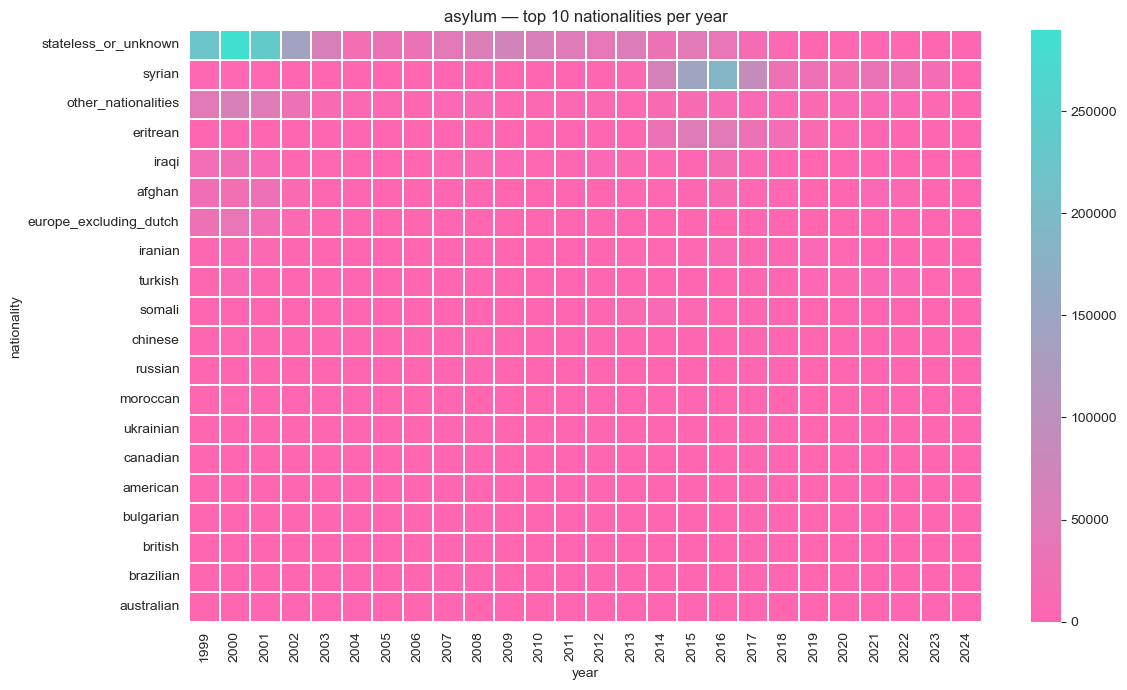

In [313]:
# dict -> dataframe
rows = []
for y, items in top10_by_year.items():
    for nat, amt in items:
        rows.append((int(y), str(nat), float(amt)))
top10_by_year_df = pd.DataFrame(rows, columns=["immigration_year","nationality","amount_immigrant"])

# heatmap: nationality rank by year (fills missing with 0)
pivot = top10_by_year_df.pivot_table(index="nationality", columns="immigration_year",
                                     values="amount_immigrant", aggfunc="sum", fill_value=0)
pivot = pivot.loc[pivot.sum(axis=1).sort_values(ascending=False).index]  # sort by total

plt.figure(figsize=(12, max(6, 0.35*len(pivot))))
sns.heatmap(pivot, cmap=pink_tq, linewidths=.3, linecolor="white")
plt.title("asylum — top 10 nationalities per year")
plt.xlabel("year"); plt.ylabel("nationality")
plt.tight_layout(); plt.show()

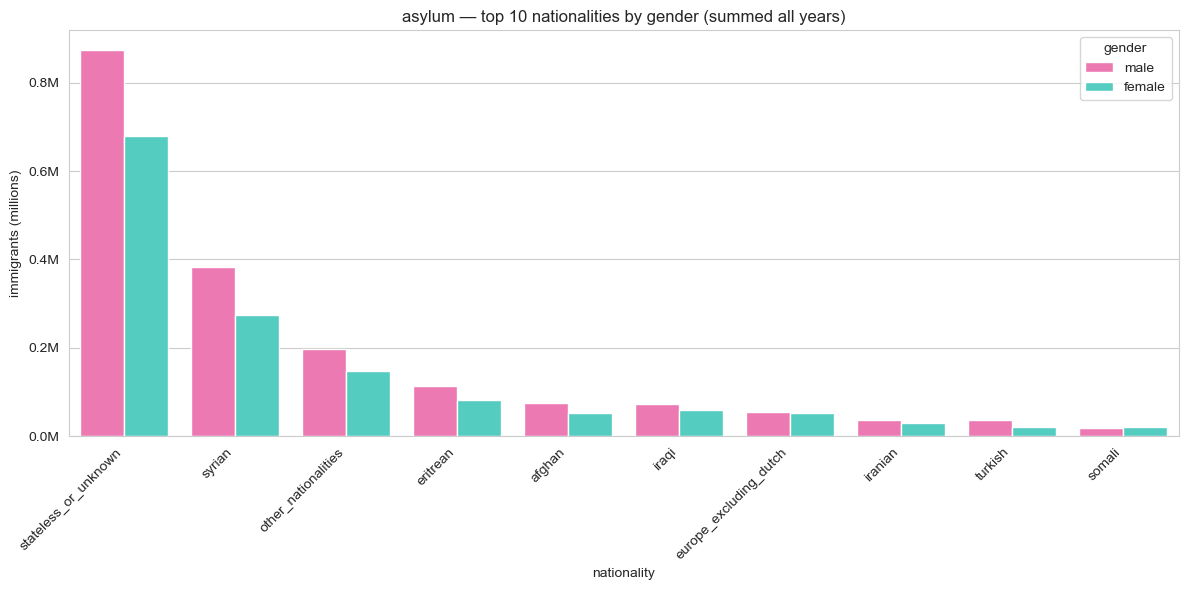

In [314]:
# dict -> dataframe
g_rows = []
for g, items in total_sum_by_gender_in_immigration_year.items():
    for nat, amt in items:
        g_rows.append((g, str(nat), float(amt)))
top10_gender_nat_df = pd.DataFrame(g_rows, columns=["gender","nationality","amount_immigrant"])

plt.figure(figsize=(12,6))
sns.barplot(data=top10_gender_nat_df, x="nationality", y="amount_immigrant",
            hue="gender", palette=["#ff66b2","#40e0d0"])
plt.title("asylum — top 10 nationalities by gender (summed all years)")
plt.xticks(rotation=45, ha="right"); plt.ylabel("immigrants (millions)")
fmt_millions(); plt.tight_layout(); plt.show()

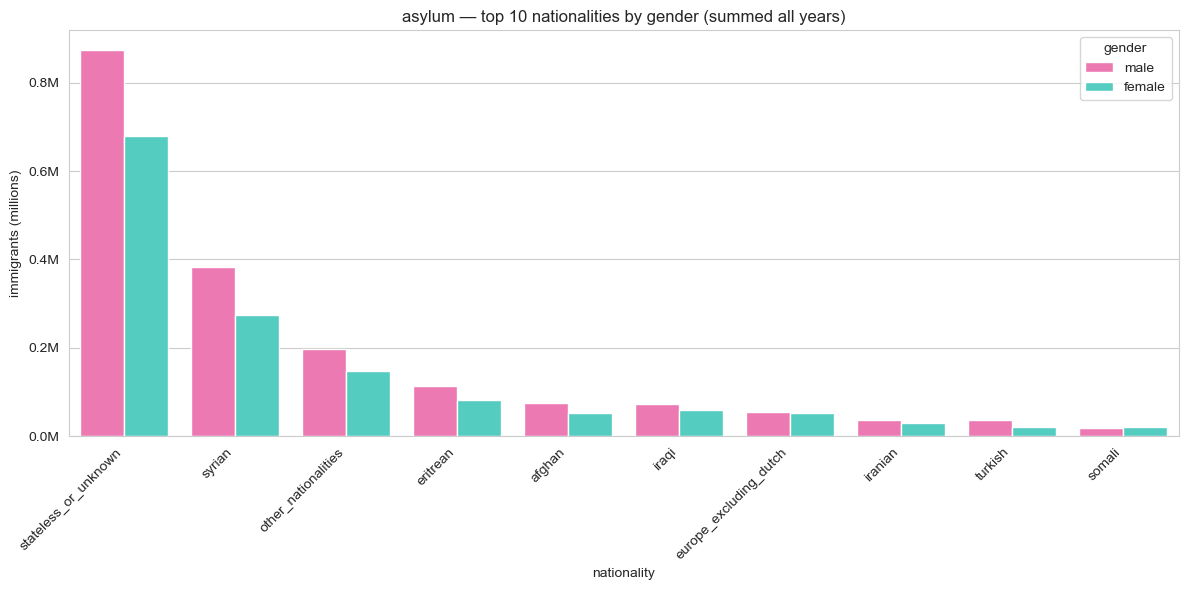

In [315]:
# dict -> dataframe
g_rows = []
for g, items in total_sum_by_gender_in_immigration_year.items():
    for nat, amt in items:
        g_rows.append((g, str(nat), float(amt)))
top10_gender_nat_df = pd.DataFrame(g_rows, columns=["gender","nationality","amount_immigrant"])

plt.figure(figsize=(12,6))
sns.barplot(data=top10_gender_nat_df, x="nationality", y="amount_immigrant",
            hue="gender", palette=["#ff66b2","#40e0d0"])
plt.title("asylum — top 10 nationalities by gender (summed all years)")
plt.xticks(rotation=45, ha="right"); plt.ylabel("immigrants (millions)")
fmt_millions(); plt.tight_layout(); plt.show()

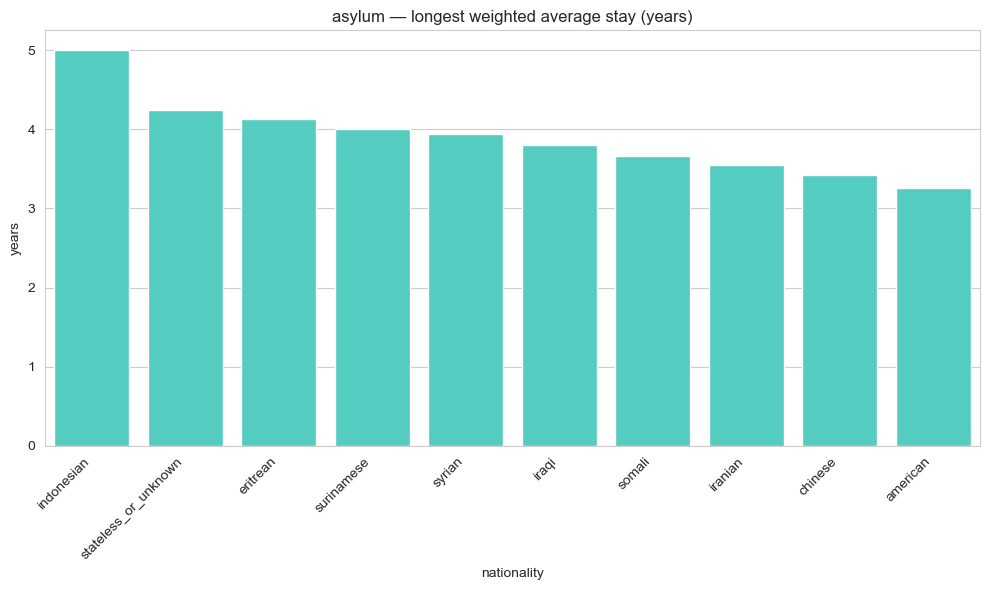

In [316]:
plt.figure(figsize=(10,6))
sns.barplot(data=top_weighted_avg_stay_df, x="nationality",
            y="stay_duration_weighted_avg", color="#40e0d0")
plt.title("asylum — longest weighted average stay (years)")
plt.ylabel("years"); plt.xlabel("nationality")
plt.xticks(rotation=45, ha="right"); plt.tight_layout(); plt.show()

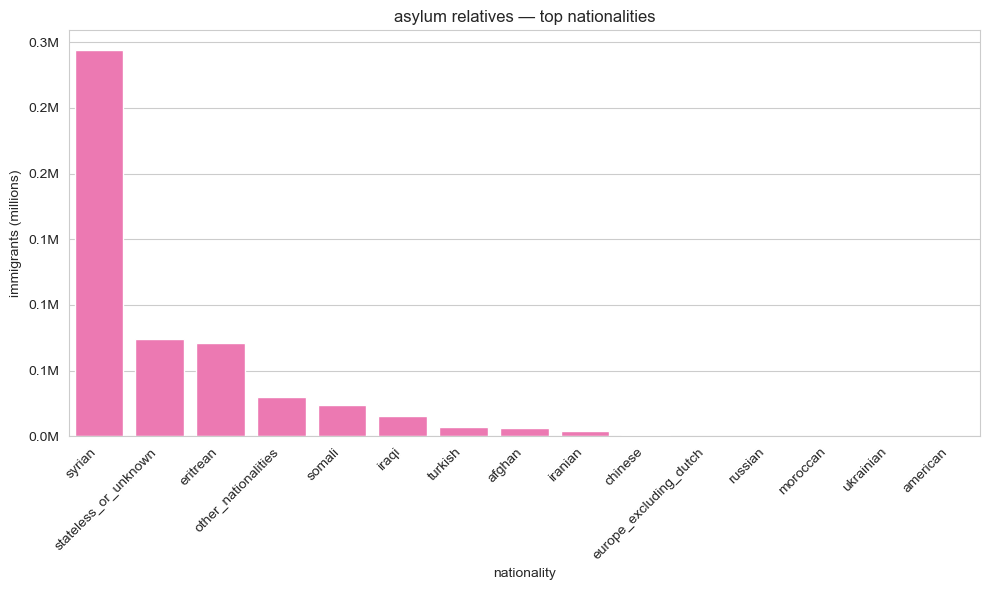

In [317]:
plt.figure(figsize=(10,6))
sns.barplot(data=asylum_relatives_by_nat_df.head(15),  # top 15 for readability
            x="nationality", y="amount_immigrant", color="#ff66b2")
plt.title("asylum relatives — top nationalities")
plt.xticks(rotation=45, ha="right"); plt.ylabel("immigrants (millions)")
fmt_millions(); plt.tight_layout(); plt.show()

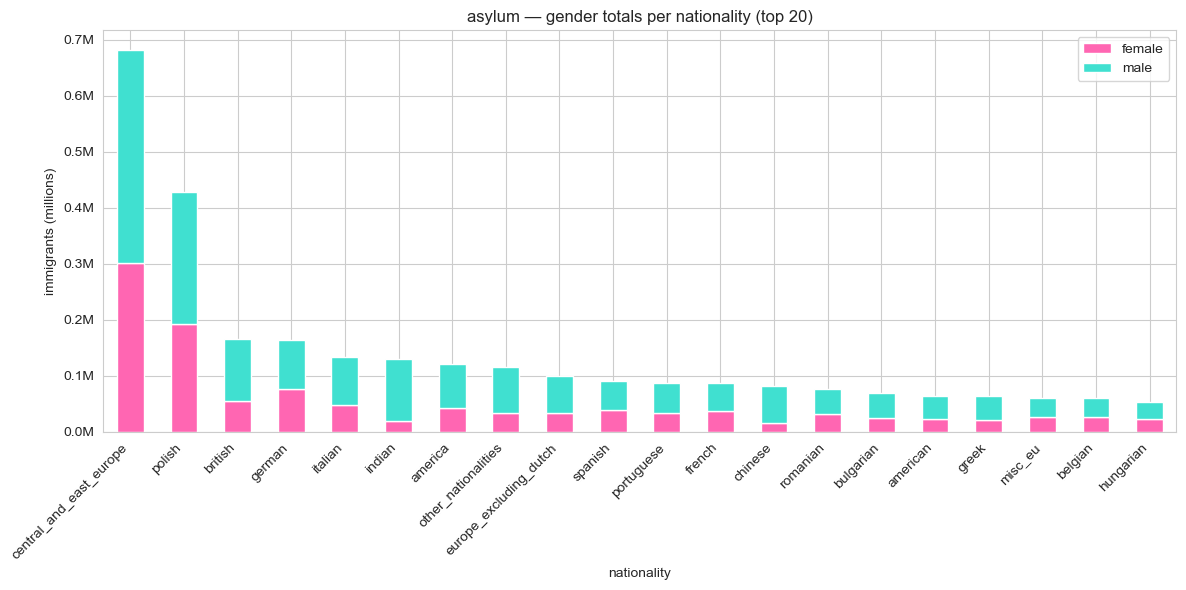

In [318]:
_top = nat_gender_wide_df.nlargest(20, "total").set_index("nationality")[["female","male"]]
ax = _top.plot(kind="bar", stacked=True, figsize=(12,6),
               color={"female":"#ff66b2","male":"#40e0d0"})
plt.title("asylum — gender totals per nationality (top 20)")
plt.xlabel("nationality"); plt.ylabel("immigrants (millions)")
fmt_millions(ax); plt.xticks(rotation=45, ha="right"); plt.tight_layout(); plt.show()

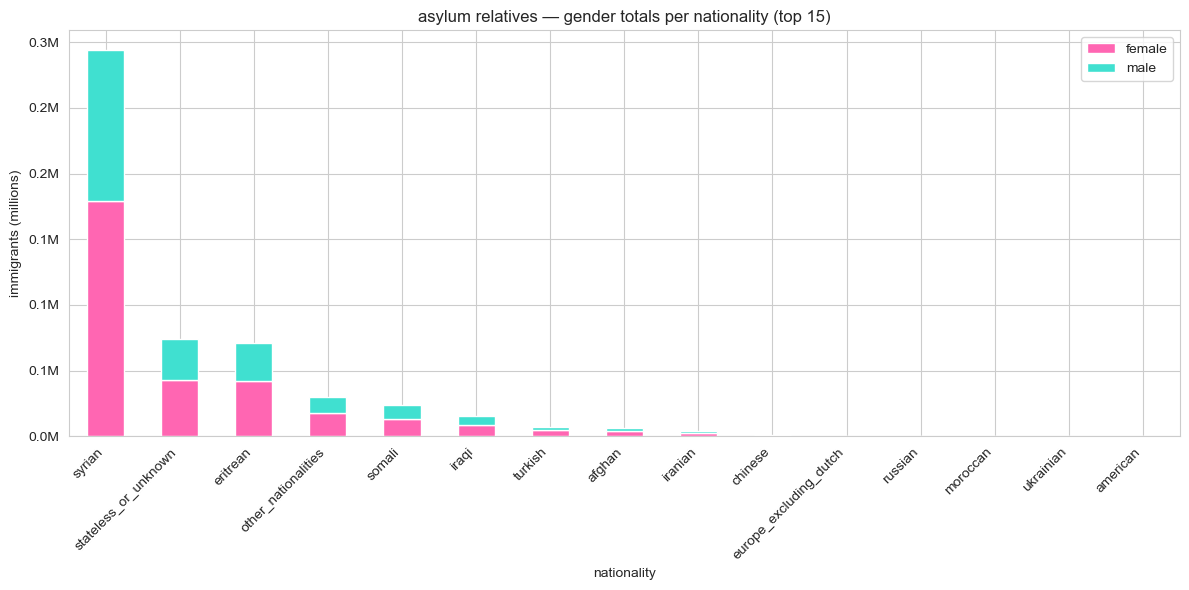

In [319]:
_top = asylum_relatives_nat_gender_wide_df.nlargest(15, "total").set_index("nationality")[["female","male"]]
ax = _top.plot(kind="bar", stacked=True, figsize=(12,6),
               color={"female":"#ff66b2","male":"#40e0d0"})
plt.title("asylum relatives — gender totals per nationality (top 15)")
plt.xlabel("nationality"); plt.ylabel("immigrants (millions)")
fmt_millions(ax); plt.xticks(rotation=45, ha="right"); plt.tight_layout(); plt.show()

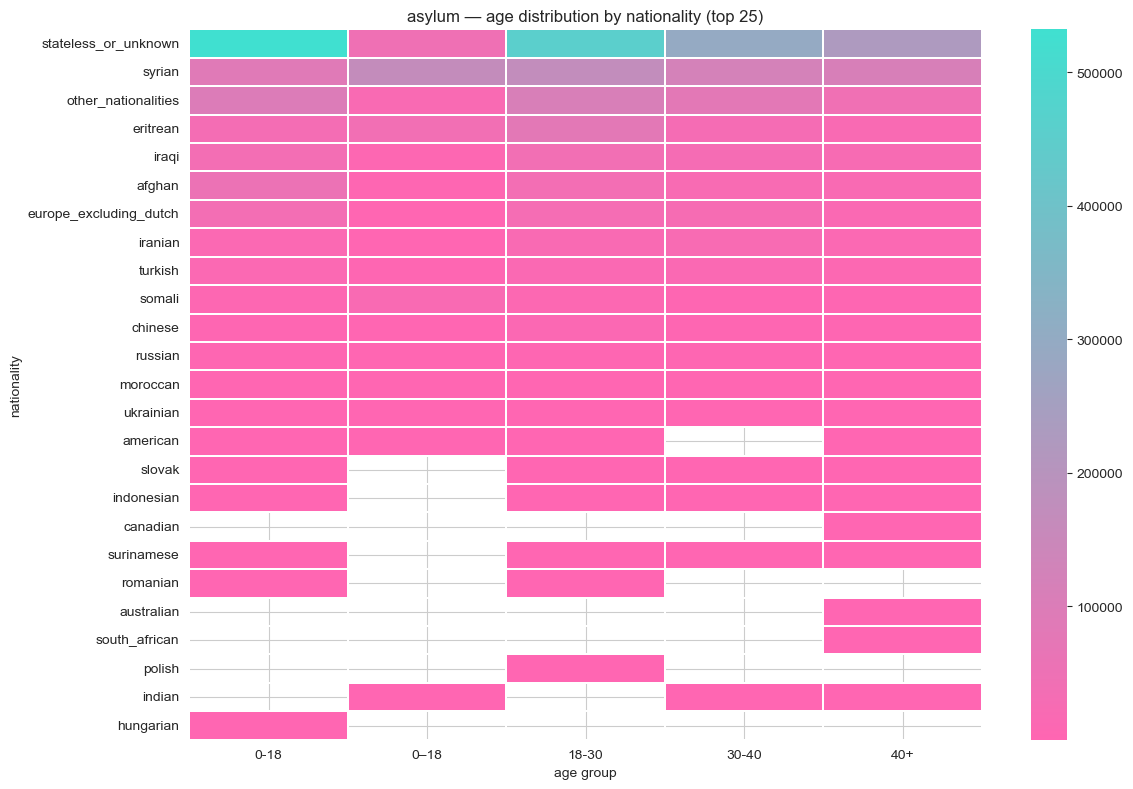

In [320]:
top_nat = (nat_age_df.groupby("nationality")["amount_immigrant"].sum()
           .nlargest(25).index)
d = nat_age_df[nat_age_df["nationality"].isin(top_nat)]
heat = d.pivot(index="nationality", columns="age", values="amount_immigrant").loc[top_nat]

plt.figure(figsize=(12,8))
sns.heatmap(heat, cmap=pink_tq, linewidths=.3, linecolor="white")
plt.title("asylum — age distribution by nationality (top 25)")
plt.xlabel("age group"); plt.ylabel("nationality")
plt.tight_layout(); plt.show()

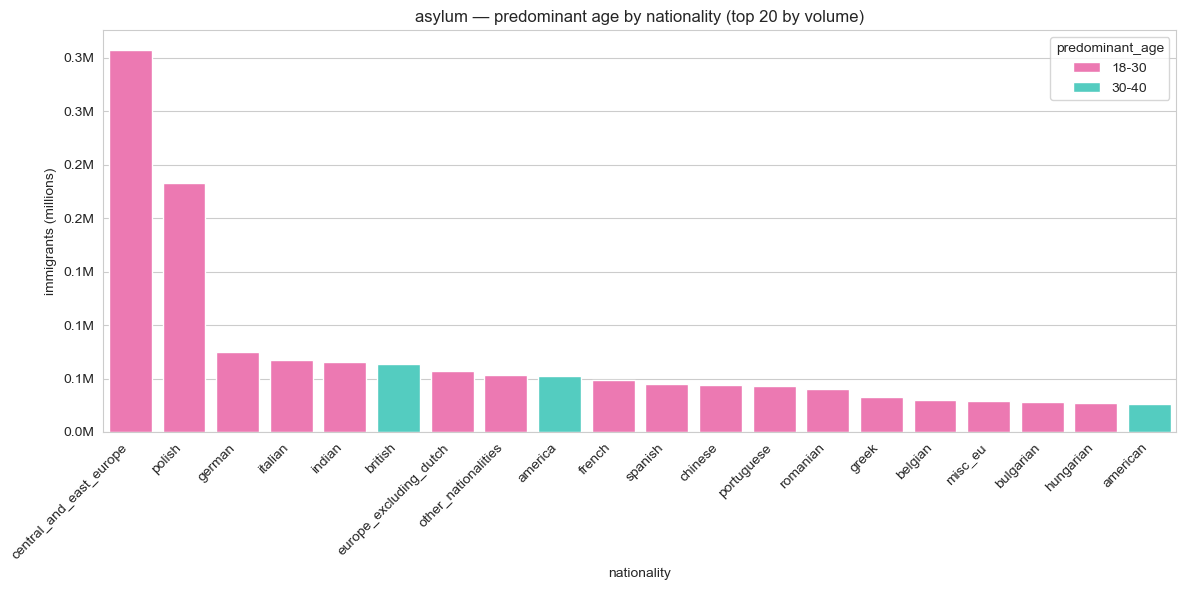

In [321]:
top20 = predominant_age_by_nat_df.nlargest(20, "amount_immigrant")
plt.figure(figsize=(12,6))
sns.barplot(data=top20, x="nationality", y="amount_immigrant",
            hue="predominant_age", palette=["#ff66b2","#40e0d0"])
plt.title("asylum — predominant age by nationality (top 20 by volume)")
plt.ylabel("immigrants (millions)"); plt.xlabel("nationality")
fmt_millions(); plt.xticks(rotation=45, ha="right"); plt.tight_layout(); plt.show()

### Work

In [322]:
sns.set_style("whitegrid")

def format_millions(ax=None):
    if ax is None: ax = plt.gca()
    ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{x/1_000_000:.1f}M"))
    return ax

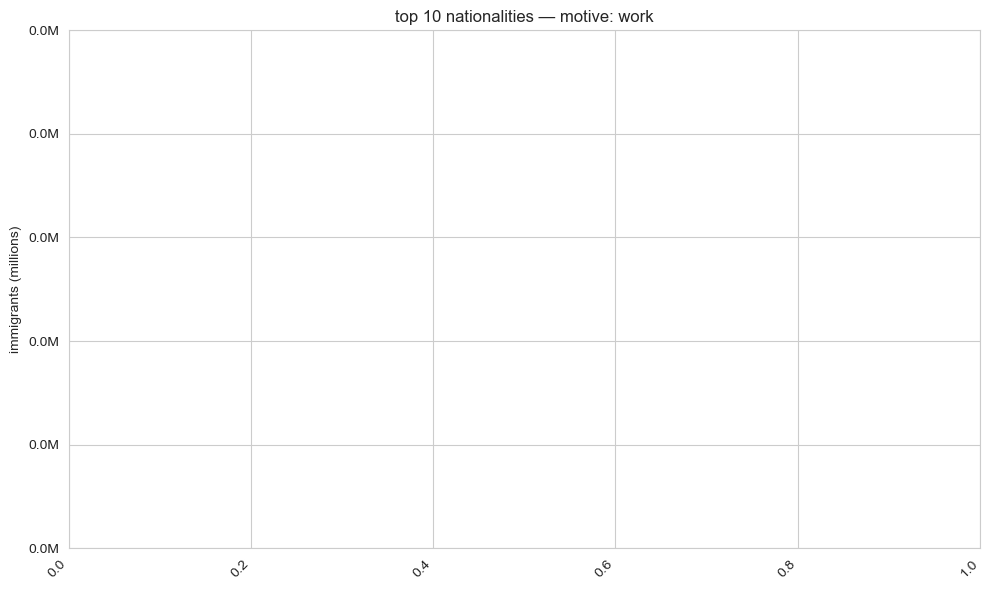

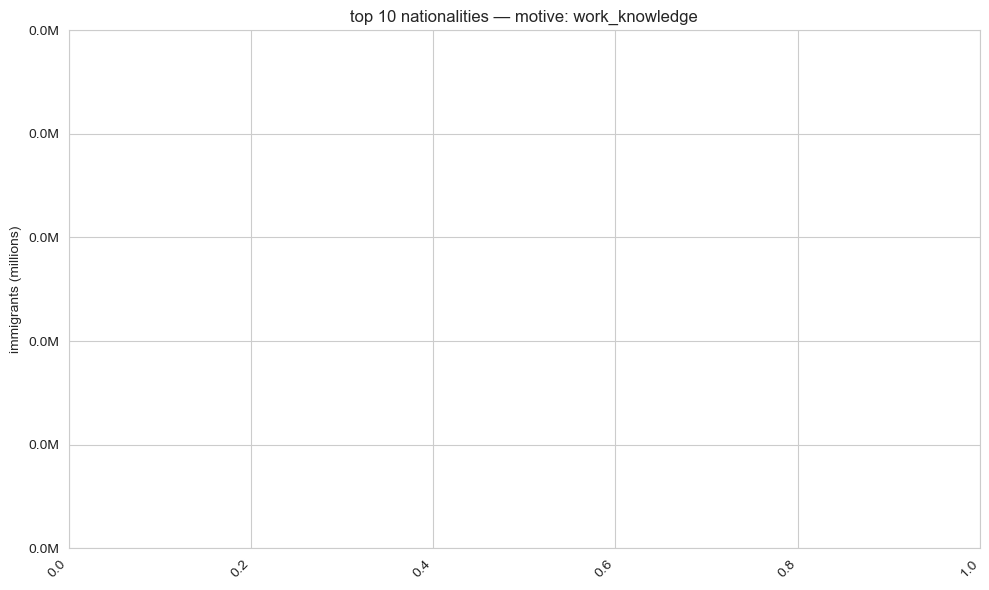

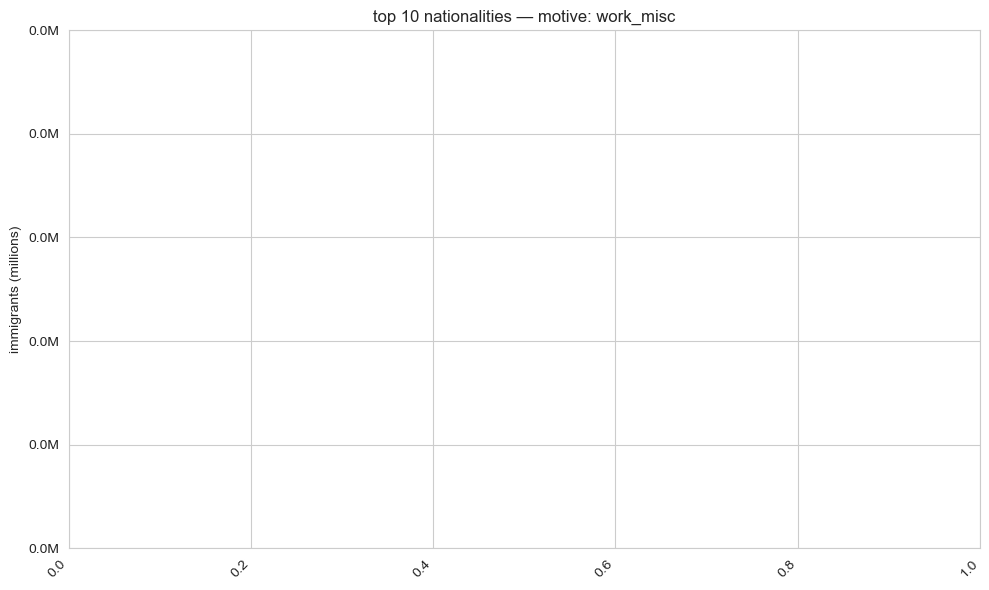

In [323]:
# work
plt.figure(figsize=(10,6))
sns.barplot(data=top10_motive_work_df, x="nationality", y="amount_immigrant", palette="Set2")
plt.title("top 10 nationalities — motive: work"); plt.xticks(rotation=45, ha="right")
plt.ylabel("immigrants (millions)"); format_millions(); plt.tight_layout(); plt.show()

# work_knowledge
plt.figure(figsize=(10,6))
sns.barplot(data=top10_motive_work_knowledge_df, x="nationality", y="amount_immigrant", palette="Set2")
plt.title("top 10 nationalities — motive: work_knowledge"); plt.xticks(rotation=45, ha="right")
plt.ylabel("immigrants (millions)"); format_millions(); plt.tight_layout(); plt.show()

# work_misc
plt.figure(figsize=(10,6))
sns.barplot(data=top10_motive_work_misc_df, x="nationality", y="amount_immigrant", palette="Set2")
plt.title("top 10 nationalities — motive: work_misc"); plt.xticks(rotation=45, ha="right")
plt.ylabel("immigrants (millions)"); format_millions(); plt.tight_layout(); plt.show()

C:\Users\gabyt\AppData\Local\Temp\ipykernel_40496\3129968301.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top10_amount_by_nat_df, x="nationality", y="amount_immigrant", palette="Set2")


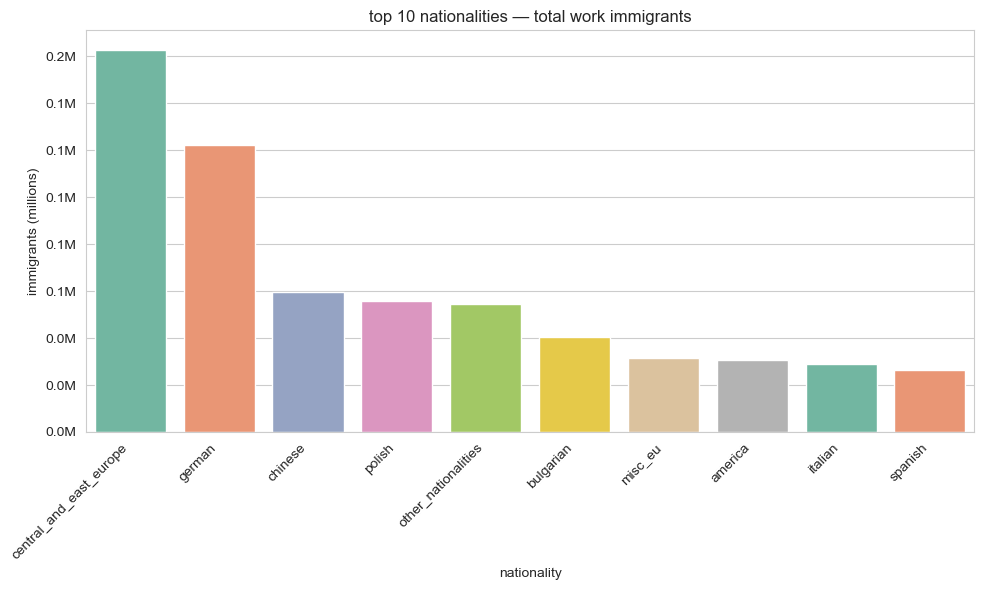

In [324]:
plt.figure(figsize=(10,6))
sns.barplot(data=top10_amount_by_nat_df, x="nationality", y="amount_immigrant", palette="Set2")
plt.title("top 10 nationalities — total work immigrants"); plt.xticks(rotation=45, ha="right")
plt.ylabel("immigrants (millions)"); format_millions(); plt.tight_layout(); plt.show()

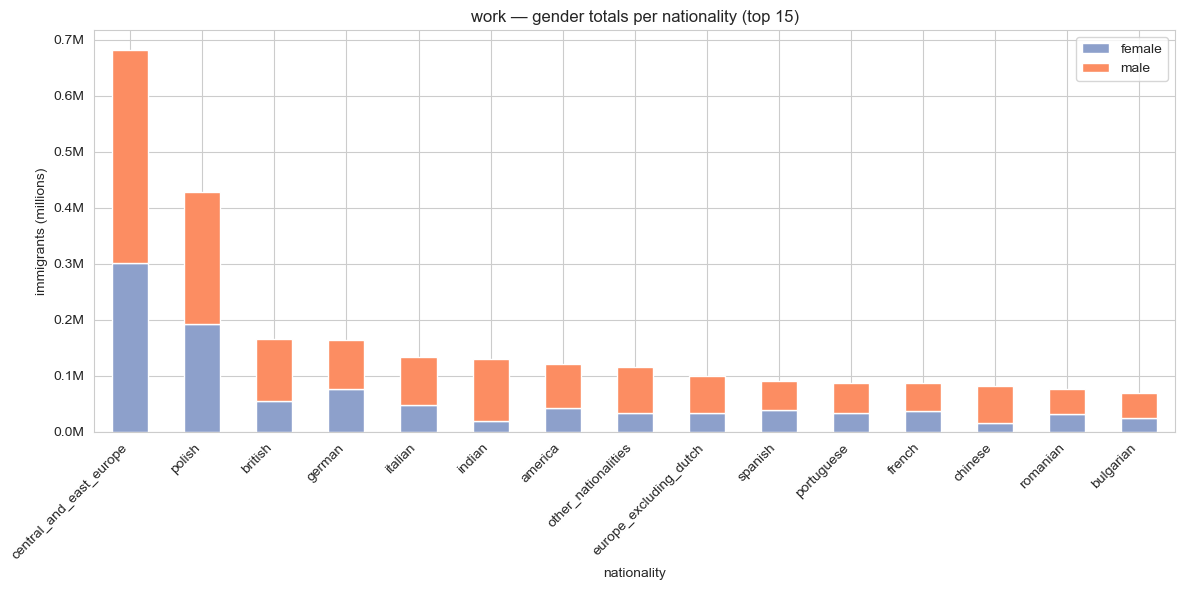

In [325]:
_top15 = nat_gender_wide_df.nlargest(15, "total").copy()
stack = _top15.set_index("nationality")[["female","male"]]

ax = stack.plot(kind="bar", stacked=True, figsize=(12,6),
                color={"female":"#8da0cb","male":"#fc8d62"})
plt.title("work — gender totals per nationality (top 15)")
plt.xlabel("nationality"); plt.ylabel("immigrants (millions)")
format_millions(ax); plt.xticks(rotation=45, ha="right"); plt.tight_layout(); plt.show()

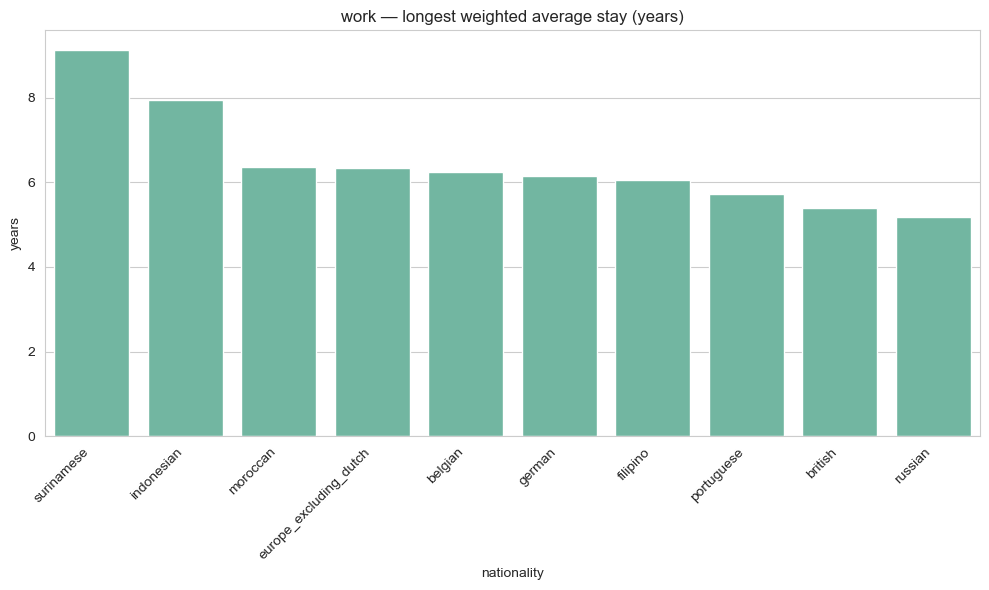

In [326]:
plt.figure(figsize=(10,6))
sns.barplot(data=top10_longest_stay_df, x="nationality",
            y="stay_duration_weighted_avg", color="#66c2a5")
plt.title("work — longest weighted average stay (years)")
plt.ylabel("years"); plt.xlabel("nationality")
plt.xticks(rotation=45, ha="right"); plt.tight_layout(); plt.show()

C:\Users\gabyt\AppData\Local\Temp\ipykernel_40496\1115605504.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


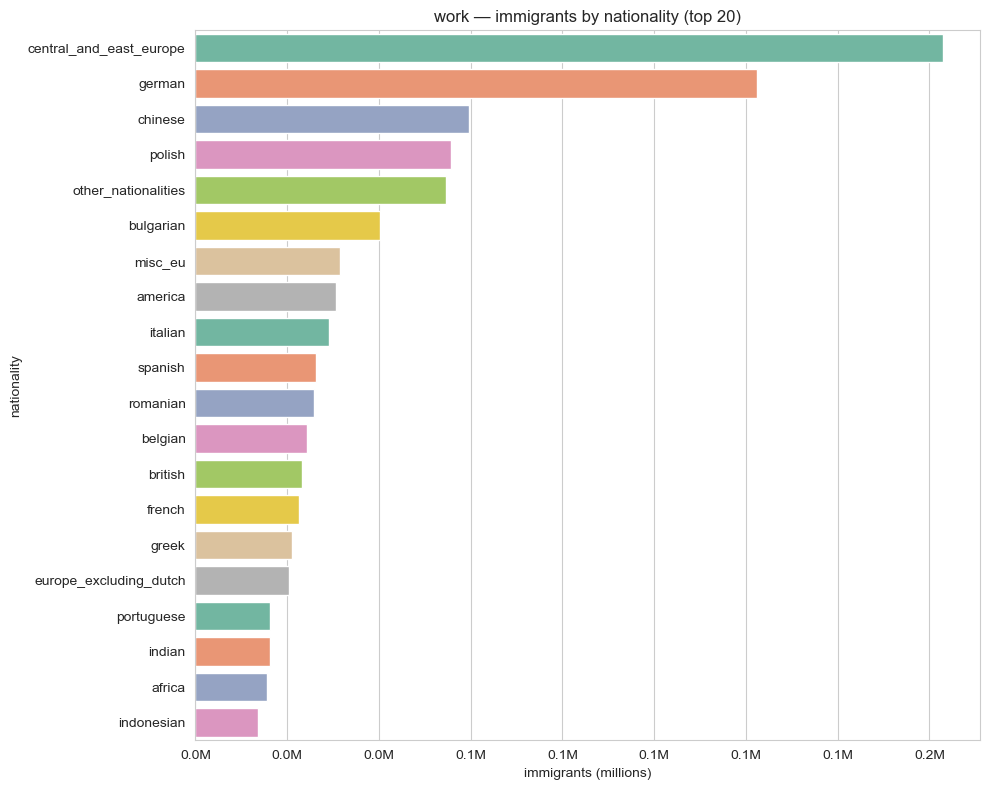

In [327]:
_top20 = amount_by_nat_df.nlargest(20, "amount_immigrant").copy()

plt.figure(figsize=(10,8))
sns.barplot(
    data=_top20,
    y="nationality", x="amount_immigrant",
    palette="Set2"
)

plt.title("work — immigrants by nationality (top 20)")
plt.xlabel("immigrants (millions)")
plt.ylabel("nationality")
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x/1e6:.1f}M"))
plt.tight_layout()
plt.show()

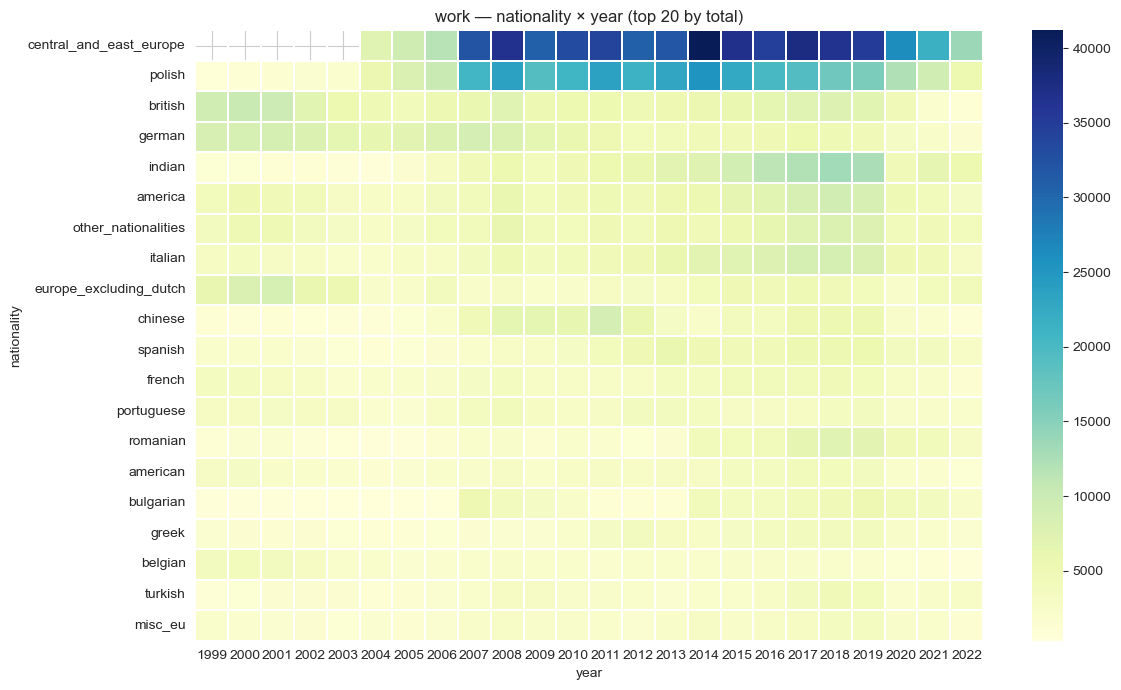

In [328]:
totals = (year_nat_work_df.groupby("nationality")["amount_immigrant"].sum()
          .nlargest(20))
d = year_nat_work_df[year_nat_work_df["nationality"].isin(totals.index)]
heat = d.pivot(index="nationality", columns="immigration_year",
               values="amount_immigrant").loc[totals.index]

plt.figure(figsize=(12,7))
sns.heatmap(heat, cmap="YlGnBu", linewidths=.3, linecolor="white")
plt.title("work — nationality × year (top 20 by total)")
plt.xlabel("year"); plt.ylabel("nationality")
plt.tight_layout(); plt.show()

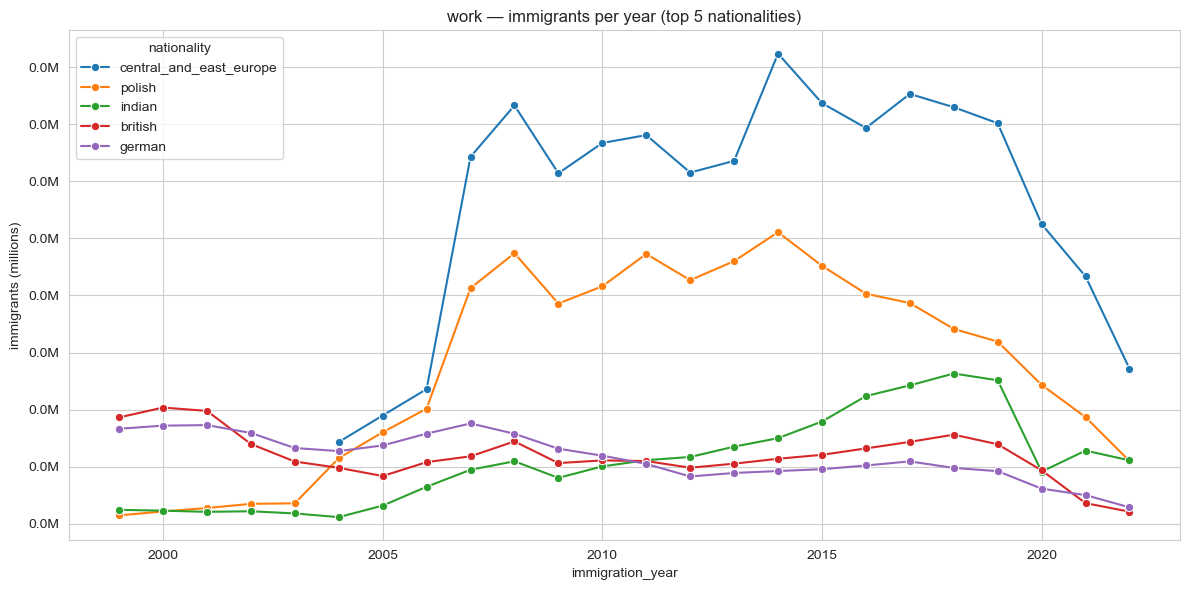

In [329]:
_top5 = (year_nat_work_df.groupby("nationality")["amount_immigrant"].sum()
         .nlargest(5).index)
d = year_nat_work_df[year_nat_work_df["nationality"].isin(_top5)]

plt.figure(figsize=(12,6))
sns.lineplot(data=d, x="immigration_year", y="amount_immigrant",
             hue="nationality", marker="o")
plt.title("work — immigrants per year (top 5 nationalities)")
plt.ylabel("immigrants (millions)")
format_millions(); plt.tight_layout(); plt.show()

### Study

C:\Users\gabyt\AppData\Local\Temp\ipykernel_40496\2368739896.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top10_amount_by_nat_df, x="nationality", y="amount_immigrant", palette="Set2")


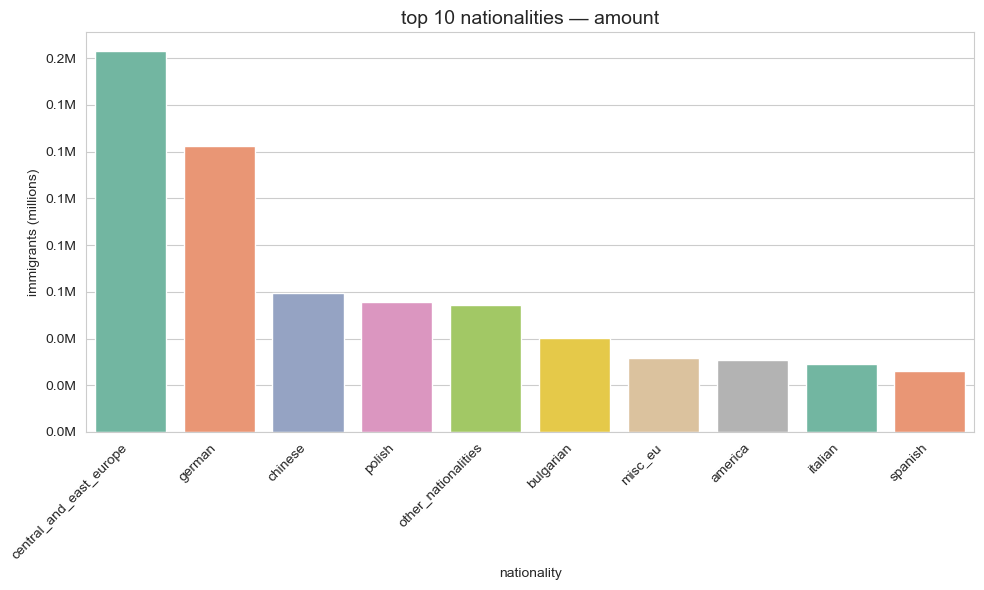

In [330]:
plt.figure(figsize=(10,6))
sns.barplot(data=top10_amount_by_nat_df, x="nationality", y="amount_immigrant", palette="Set2")
plt.title("top 10 nationalities — amount", fontsize=14)
plt.xticks(rotation=45, ha="right"); plt.ylabel("immigrants (millions)")
format_millions(); plt.tight_layout(); plt.show()

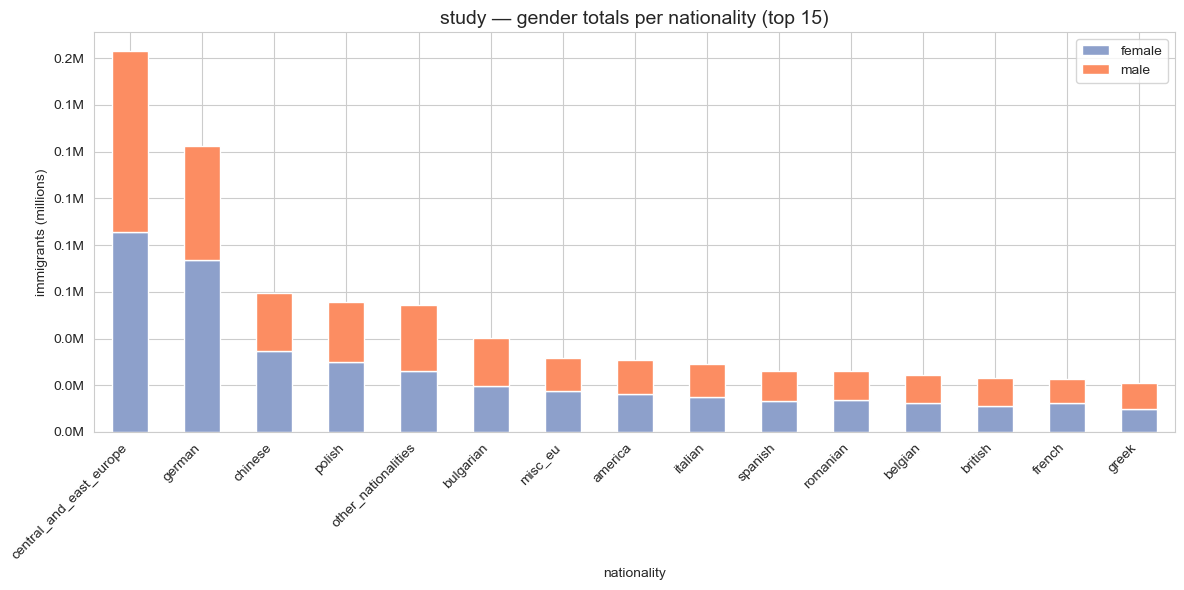

In [331]:
_top15 = study_nat_gender_wide_df.nlargest(15, "total").copy()
stack = _top15.set_index("nationality")[["female","male"]]

ax = stack.plot(kind="bar", stacked=True, figsize=(12,6), color={"female":"#8da0cb","male":"#fc8d62"})
plt.title("study — gender totals per nationality (top 15)", fontsize=14)
plt.xlabel("nationality"); plt.ylabel("immigrants (millions)")
format_millions(ax); plt.xticks(rotation=45, ha="right"); plt.tight_layout(); plt.show()

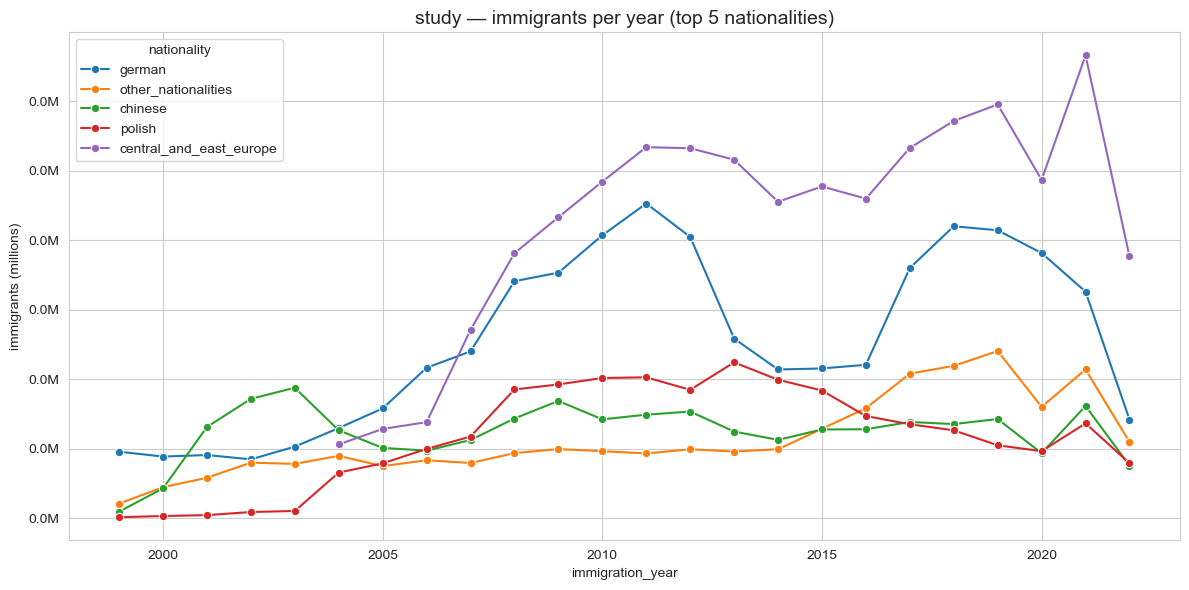

In [332]:
_top5 = (study_year_nat_df.groupby("nationality")["amount_immigrant"].sum()
         .nlargest(5).index)
d = study_year_nat_df[study_year_nat_df["nationality"].isin(_top5)]

plt.figure(figsize=(12,6))
sns.lineplot(data=d, x="immigration_year", y="amount_immigrant", hue="nationality", marker="o")
plt.title("study — immigrants per year (top 5 nationalities)", fontsize=14)
plt.ylabel("immigrants (millions)")
format_millions(); plt.tight_layout(); plt.show()

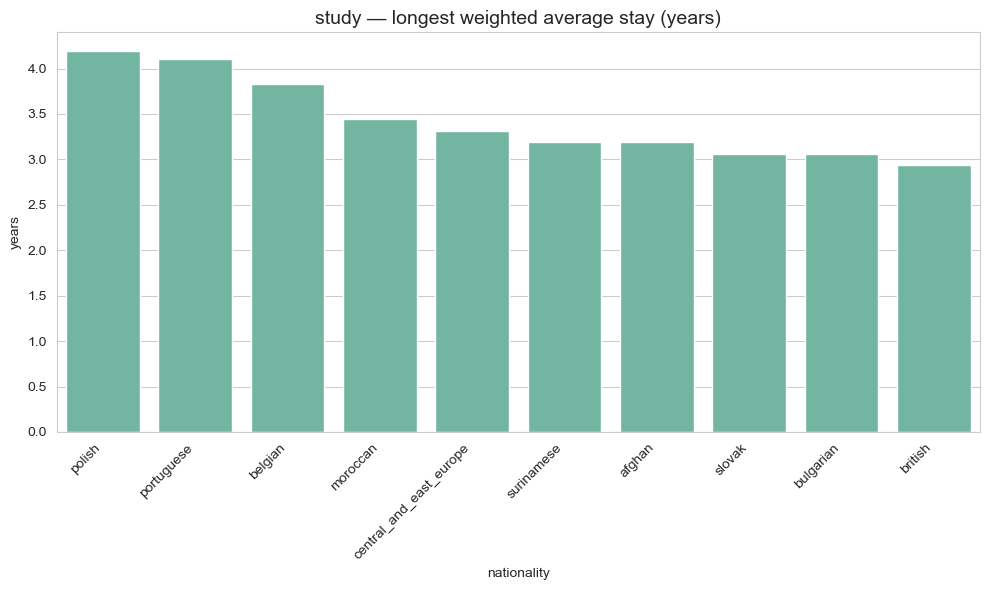

In [333]:
plt.figure(figsize=(10,6))
sns.barplot(data=study_top10_longest_stay_df, x="nationality", y="stay_duration_weighted_avg", color="#66c2a5")
plt.title("study — longest weighted average stay (years)", fontsize=14)
plt.ylabel("years"); plt.xlabel("nationality")
plt.xticks(rotation=45, ha="right"); plt.tight_layout(); plt.show()

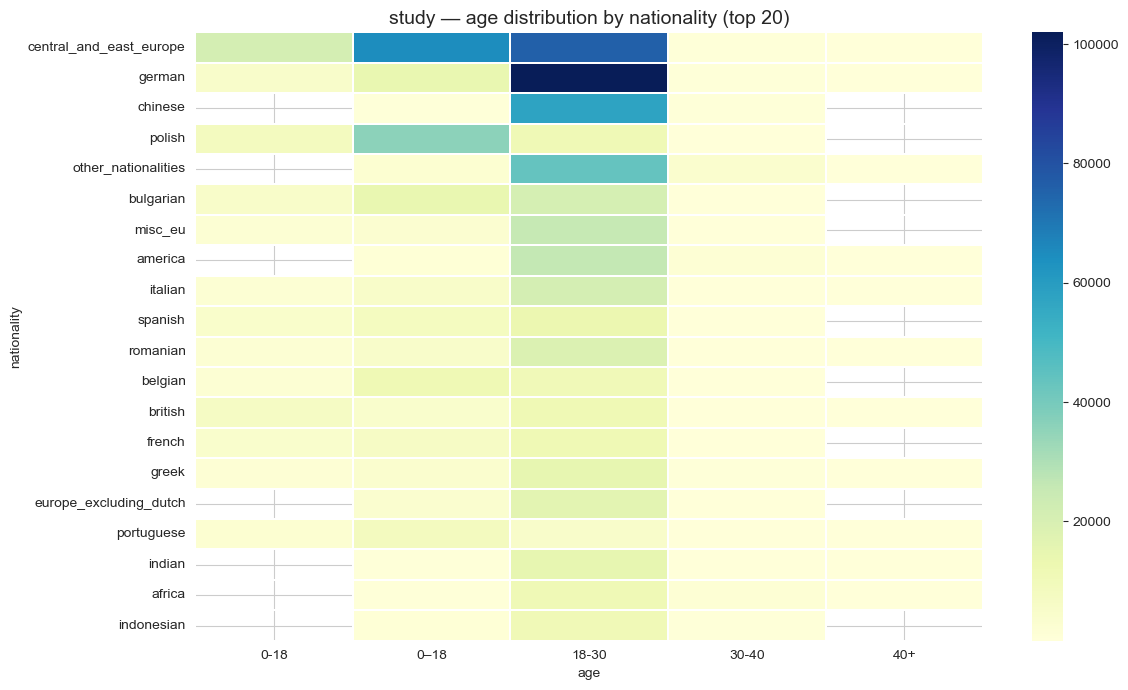

In [334]:
totals = (study_age_by_nat_df.groupby("nationality")["amount_immigrant"].sum()
          .nlargest(20))
d = study_age_by_nat_df[study_age_by_nat_df["nationality"].isin(totals.index)]
heat = d.pivot(index="nationality", columns="age", values="amount_immigrant").loc[totals.index]

plt.figure(figsize=(12,7))
sns.heatmap(heat, cmap="YlGnBu", linewidths=.3, linecolor="white")
plt.title("study — age distribution by nationality (top 20)", fontsize=14)
plt.xlabel("age"); plt.ylabel("nationality")
plt.tight_layout(); plt.show()

In [335]:
def format_millions(ax=None):
    if ax is None: ax = plt.gca()
    ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{x/1_000_000:.1f}M"))
    return ax

C:\Users\gabyt\AppData\Local\Temp\ipykernel_40496\2126236315.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top10_study_nat_df, x="nationality", y="amount_immigrant", palette="Set2")


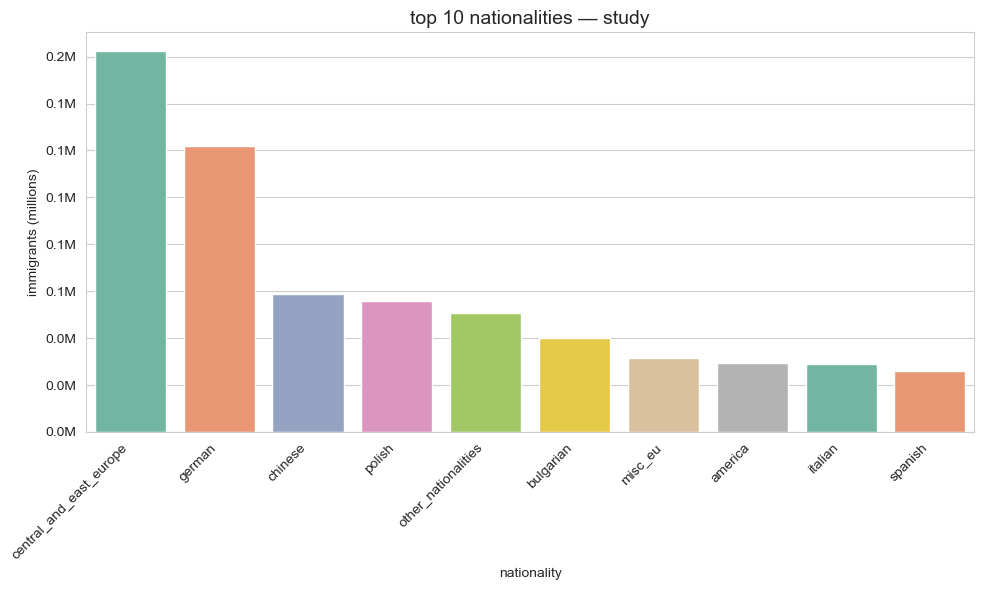

In [336]:
plt.figure(figsize=(10,6))
sns.barplot(data=top10_study_nat_df, x="nationality", y="amount_immigrant", palette="Set2")
plt.title("top 10 nationalities — study", fontsize=14)
plt.xticks(rotation=45, ha="right"); plt.ylabel("immigrants (millions)")
format_millions(); plt.tight_layout(); plt.show()

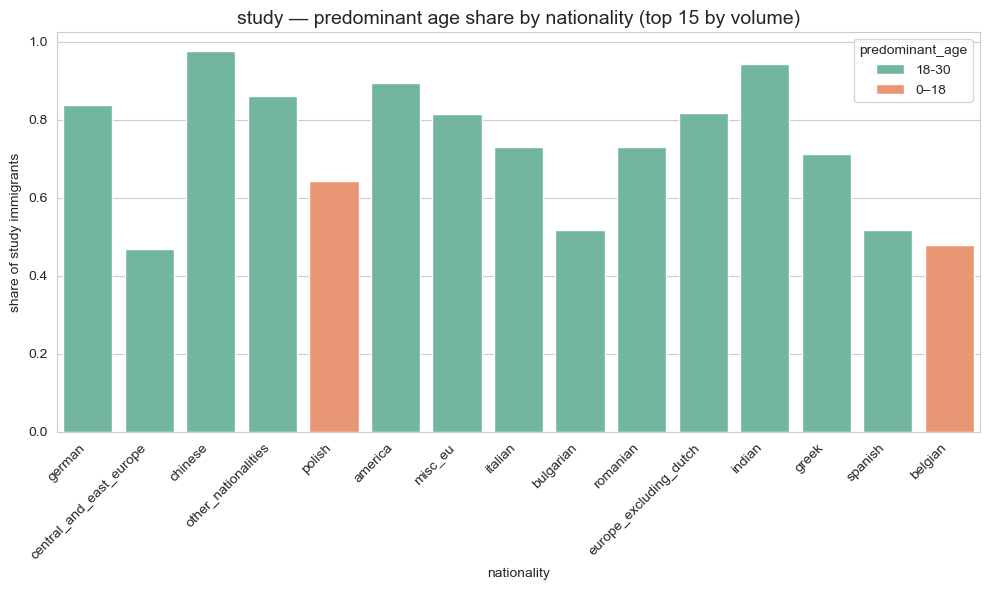

In [337]:
top15 = study_predominant_age_by_nat_df.nlargest(15, "amount_immigrant")
plt.figure(figsize=(10,6))
sns.barplot(data=top15, x="nationality", y="share", hue="predominant_age", palette="Set2")
plt.title("study — predominant age share by nationality (top 15 by volume)", fontsize=14)
plt.ylabel("share of study immigrants"); plt.xlabel("nationality")
plt.xticks(rotation=45, ha="right"); plt.tight_layout(); plt.show()

### Family

In [338]:
sns.set_style("whitegrid")

def format_millions(ax=None):
    if ax is None: ax = plt.gca()
    ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{x/1_000_000:.1f}M"))
    return ax

def plot_top10_by_motive(family_final, motive_token, title):
    # basic masks
    m_student = family_final["extra_motive"].str.contains("student_relatives", na=False)
    m_worker  = family_final["extra_motive"].str.contains("worker_relatives",  na=False)
    m_asylum  = family_final["extra_motive"].str.contains("asylum_relatives",  na=False)

    # choose exclusive mask for requested motive, else fall back to inclusive
    if motive_token == "student_relatives":
        m_exclusive = m_student & ~m_worker & ~m_asylum
        m_inclusive = m_student
    elif motive_token == "worker_relatives":
        m_exclusive = m_worker & ~m_student & ~m_asylum
        m_inclusive = m_worker
    else:  # asylum_relatives
        m_exclusive = m_asylum & ~m_student & ~m_worker
        m_inclusive = m_asylum

    df = family_final.loc[m_exclusive, ["nationality","amount_immigrant"]]
    if df.empty:   # fallback if exclusives produce 0 rows
        df = family_final.loc[m_inclusive, ["nationality","amount_immigrant"]]

    top10 = (df.groupby("nationality", as_index=False)["amount_immigrant"]
               .sum().sort_values("amount_immigrant", ascending=False).head(10))

    plt.figure(figsize=(10,6))
    sns.barplot(data=top10, x="nationality", y="amount_immigrant", palette="Set2")
    plt.title(title, fontsize=14)
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("immigrants (millions)")
    format_millions()
    plt.tight_layout()
    plt.show()

C:\Users\gabyt\AppData\Local\Temp\ipykernel_40496\1290026099.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top10, x="nationality", y="amount_immigrant", palette="Set2")


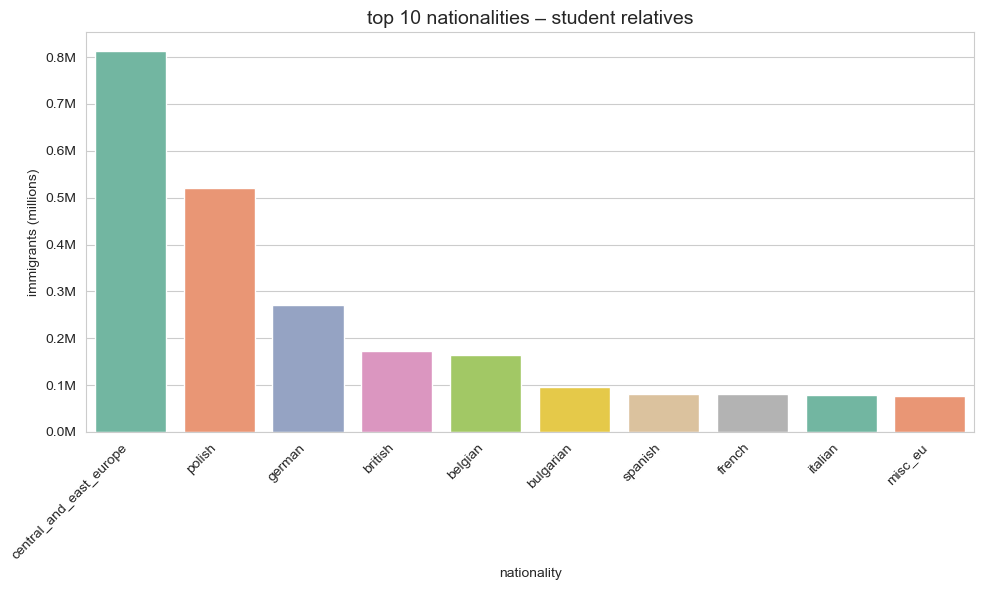

In [339]:
plot_top10_by_motive(family_final, "student_relatives",
                     "top 10 nationalities – student relatives")

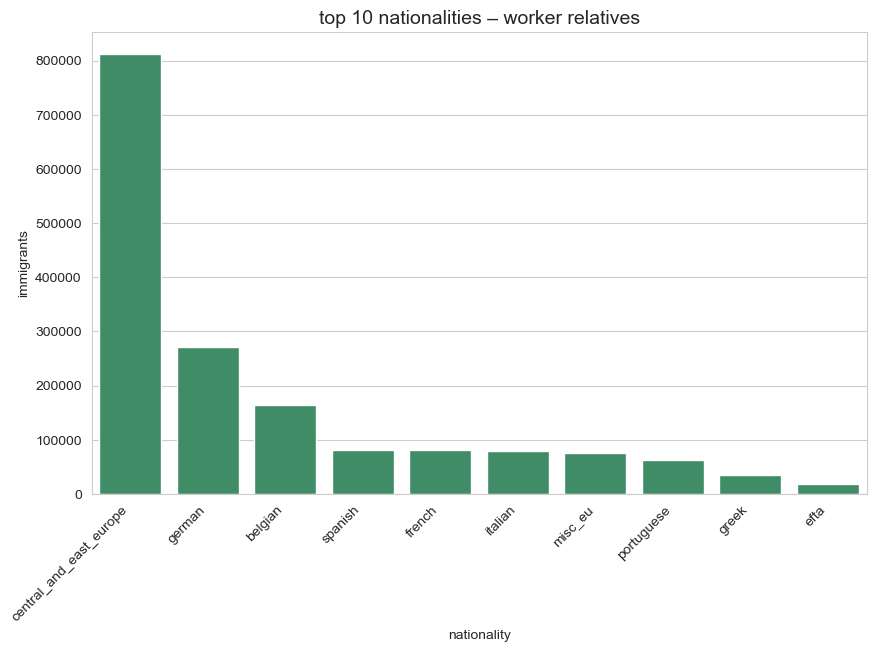

In [340]:
plt.figure(figsize=(10,6))
sns.barplot(
    data=top10_worker_only_df,
    x="nationality", y="amount_immigrant", color="#339966"  # green
)
plt.title("top 10 nationalities – worker relatives", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.ylabel("immigrants")
plt.show()

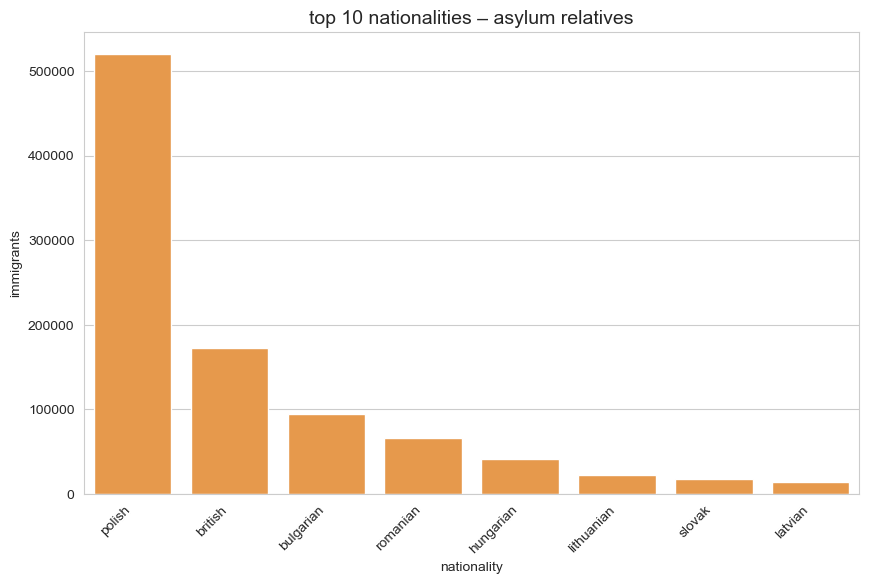

In [341]:
plt.figure(figsize=(10,6))
sns.barplot(
    data=top10_asylum_only_df,
    x="nationality", y="amount_immigrant", color="#ff9933"  # orange
)
plt.title("top 10 nationalities – asylum relatives", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.ylabel("immigrants")
plt.show()

C:\Users\gabyt\AppData\Local\Temp\ipykernel_40496\1592846796.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


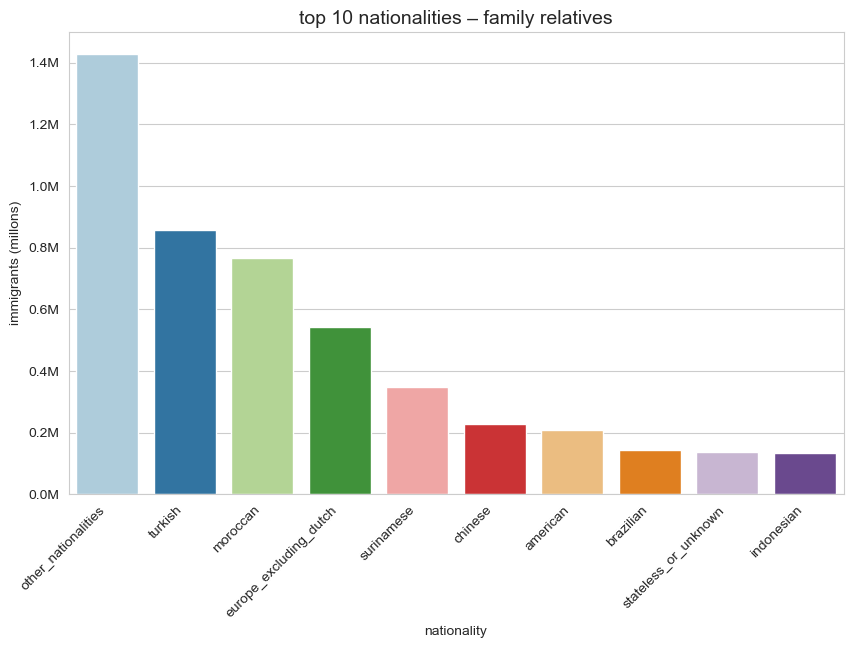

In [342]:
def format_millions(ax=None):
    """Format y-axis in millions (M)."""
    if ax is None:
        ax = plt.gca()
    ax.yaxis.set_major_formatter(
        mtick.FuncFormatter(lambda x, _: f"{x/1_000_000:.1f}M")
    )
    return ax

plt.figure(figsize=(10,6))
sns.barplot(
    data=top10_family_relatives_by_nat_df,   # <- correct df name
    x="nationality", y="amount_immigrant", palette="Paired"
)
plt.title("top 10 nationalities – family relatives", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.ylabel("immigrants (millons)")
format_millions()  
plt.show()

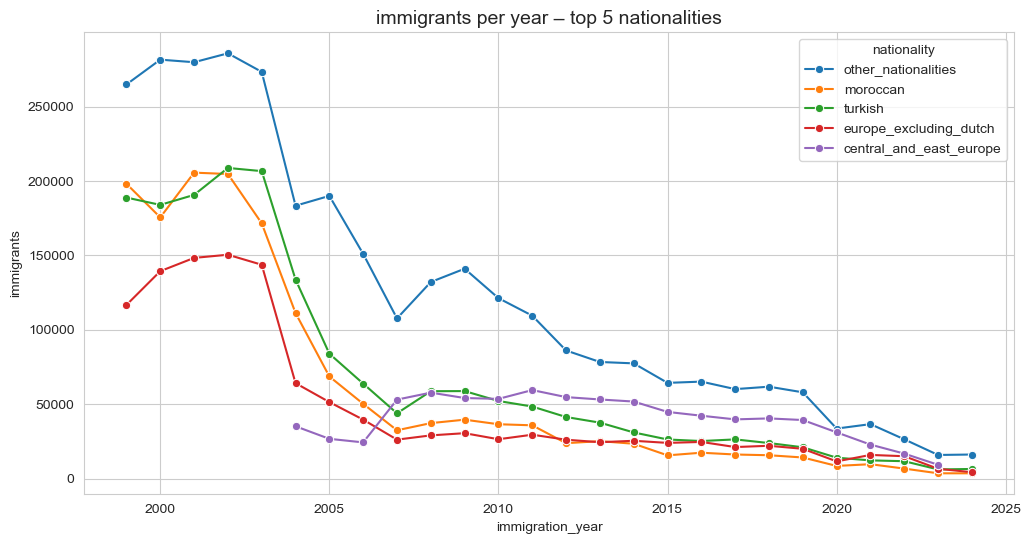

In [343]:
# top 5 nationalities overall
top5_nat = (
    family_year_nat_df.groupby("nationality")["amount_immigrant"].sum()
    .nlargest(5).index
)

trend5 = family_year_nat_df[
    family_year_nat_df["nationality"].isin(top5_nat)
]

plt.figure(figsize=(12,6))
sns.lineplot(data=trend5, x="immigration_year", y="amount_immigrant",
             hue="nationality", marker="o")
plt.title("immigrants per year – top 5 nationalities", fontsize=14)
plt.ylabel("immigrants")
plt.show()

### Housing

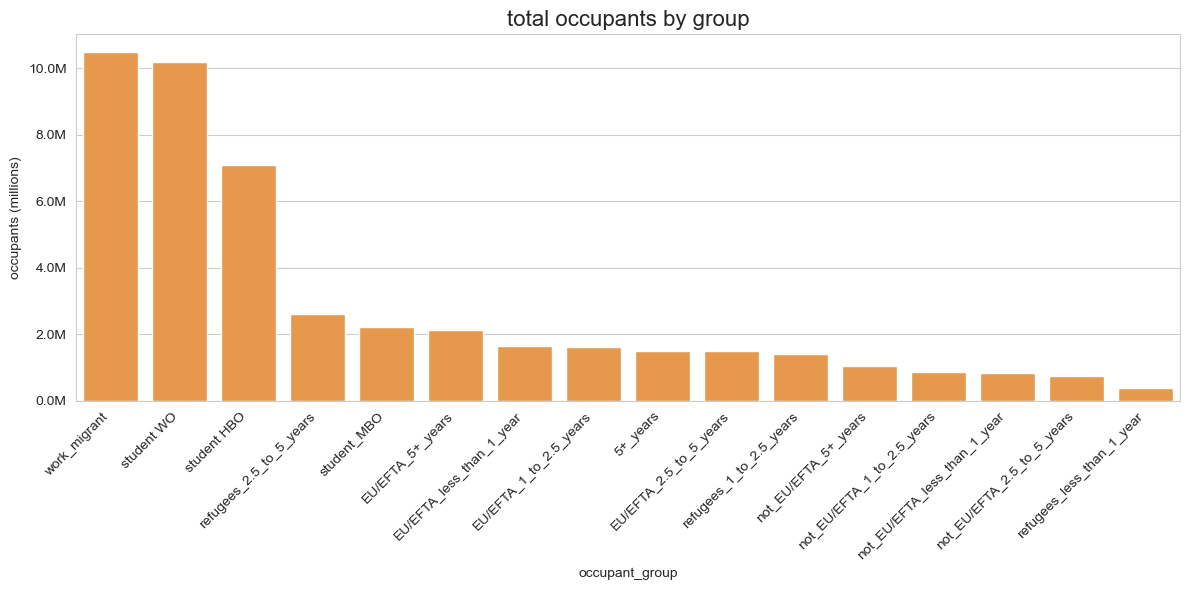

In [344]:
sns.set_style("whitegrid")
sns.set_palette(["#ff9933", "#339966"])  # orange & green

plt.figure(figsize=(12,6))
sns.barplot(
    data=occupant_group_totals_df,
    x="occupant_group", y="amount_occupants"
)
plt.title("total occupants by group", fontsize=16)
plt.ylabel("occupants (millions)")
plt.xlabel("occupant_group")
plt.xticks(rotation=45, ha="right")

# format y-axis in millions
ax = plt.gca()
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{x/1_000_000:.1f}M"))

plt.tight_layout()
plt.show()

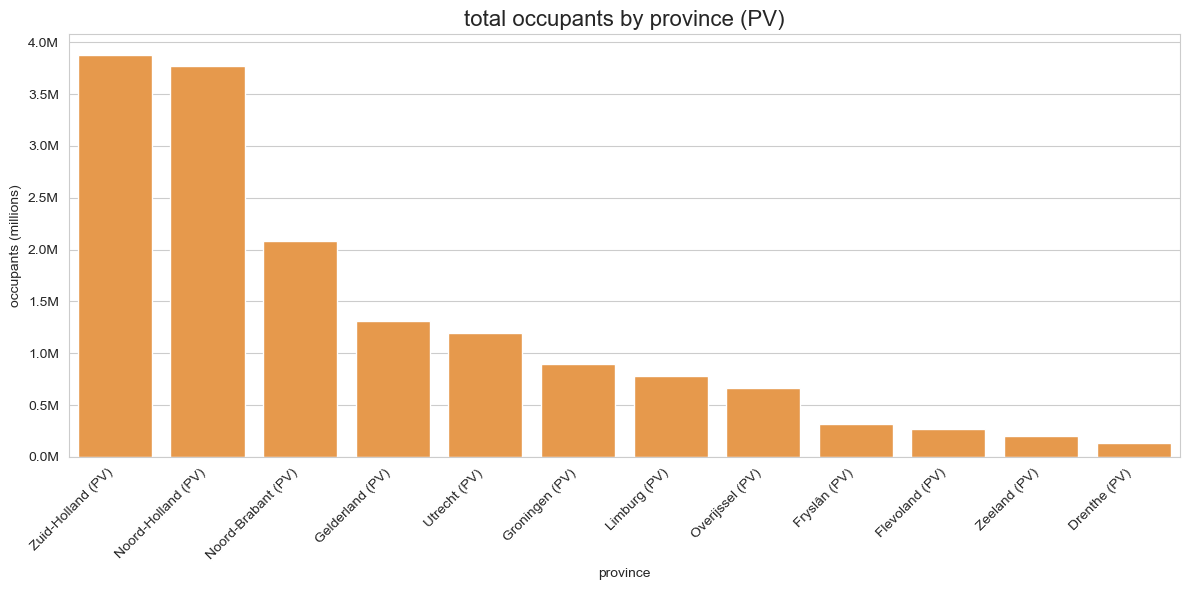

In [345]:
plt.figure(figsize=(12,6))
sns.barplot(
    data=pv_regions_totals_df,
    x="region", y="amount_occupants",
    color="#ff9933"  # orange
)
plt.title("total occupants by province (PV)", fontsize=16)
plt.ylabel("occupants (millions)")
plt.xlabel("province")
plt.xticks(rotation=45, ha="right")

# format y-axis in millions
ax = plt.gca()
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{x/1_000_000:.1f}M"))

plt.tight_layout()
plt.show()

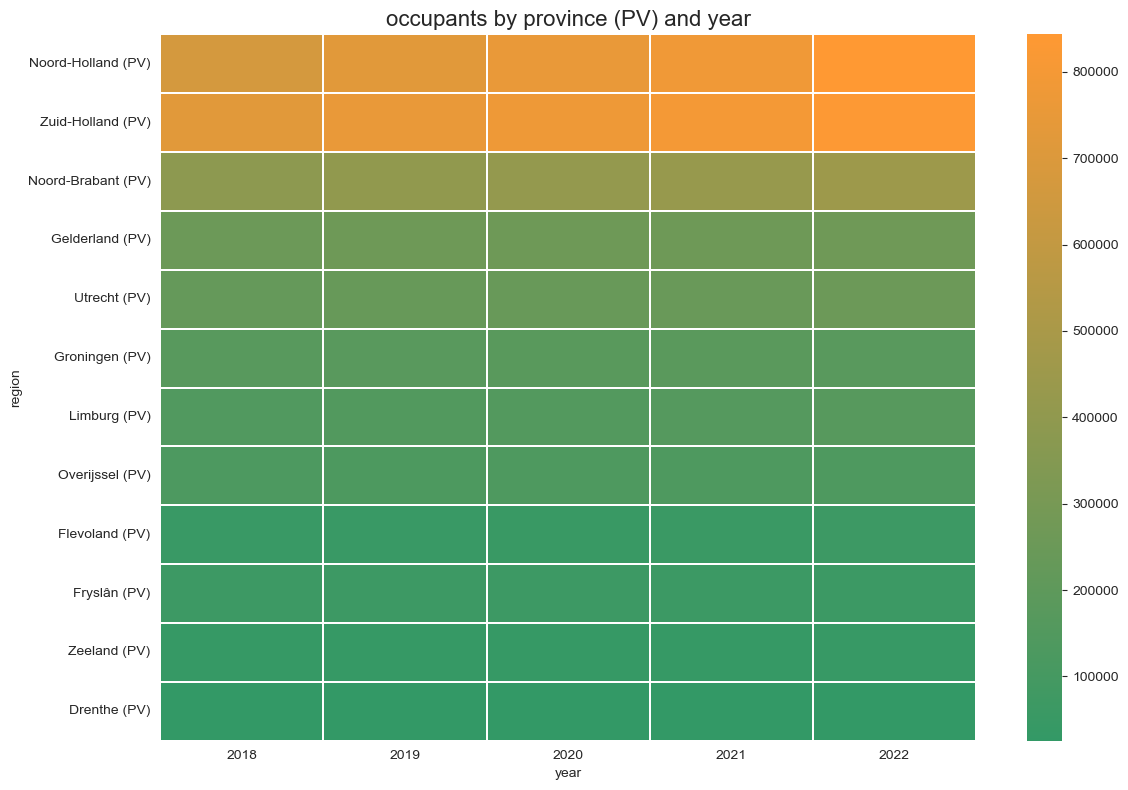

In [346]:
# pivot to region x year
heat = pv_regions_year_totals_df.pivot(
    index="region", columns="year", values="amount_occupants"
)

# sort by last year’s values
heat = heat.sort_values(by=heat.columns[-1], ascending=False)

# custom green→orange colormap
cmap_go = LinearSegmentedColormap.from_list("green_orange", ["#339966", "#ff9933"])

plt.figure(figsize=(12,8))
sns.heatmap(heat, cmap=cmap_go, linewidths=.3, linecolor="white")
plt.title("occupants by province (PV) and year", fontsize=16)
plt.xlabel("year")
plt.ylabel("region")
plt.tight_layout()
plt.show()

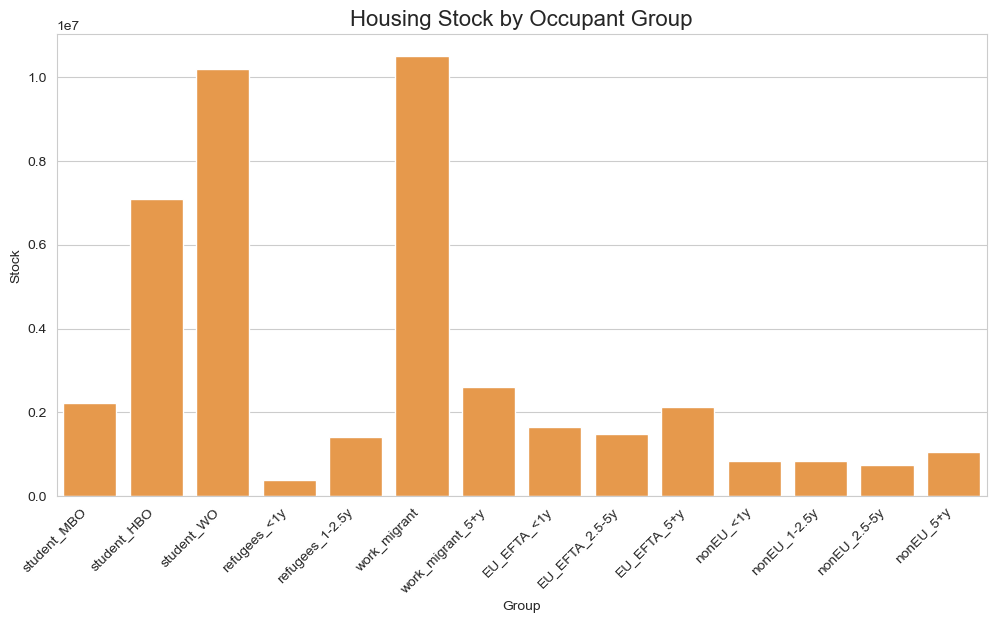

In [347]:
sns.set_style("whitegrid")
sns.set_palette(["#ff9933", "#339966"])  # orange & green

plt.figure(figsize=(12,6))
sns.barplot(data=housing_groups_df, x="group", y="stock")
plt.title("Housing Stock by Occupant Group", fontsize=16)
plt.ylabel("Stock")
plt.xlabel("Group")
plt.xticks(rotation=45, ha="right")
plt.show()

### Housing Stock

C:\Users\gabyt\AppData\Local\Temp\ipykernel_40496\1486322391.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


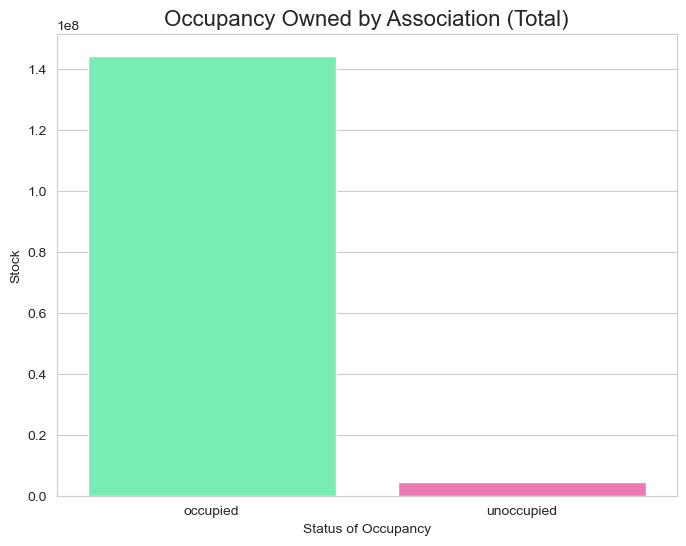

In [348]:
plt.figure(figsize=(8,6))
sns.barplot(
    data=assoc_by_status_df,
    x="status_of_occupancy", y="owned_by_association",
    palette=["#66ffb3", "#ff66b2"]  # purple & pink
)
plt.title("Occupancy Owned by Association (Total)", fontsize=16)
plt.ylabel("Stock")
plt.xlabel("Status of Occupancy")
plt.show()

C:\Users\gabyt\AppData\Local\Temp\ipykernel_40496\4073584481.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


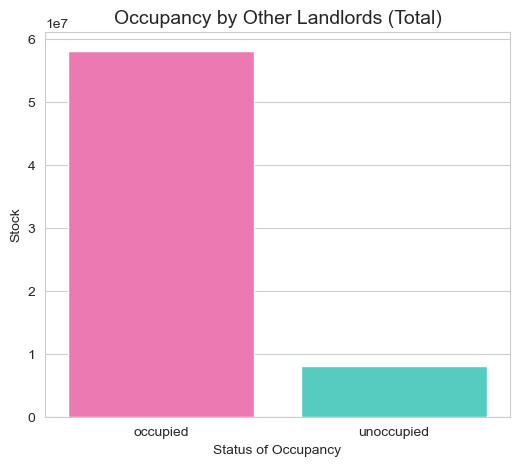

In [349]:
sns.set_style("whitegrid")

plt.figure(figsize=(6,5))
sns.barplot(
    data=other_by_status_df,
    x="status_of_occupancy",
    y="owned_by_other_landlords",
    palette=["#ff66b2", "#40e0d0"]  # pink, turquoise
)
plt.title("Occupancy by Other Landlords (Total)", fontsize=14)
plt.ylabel("Stock")
plt.xlabel("Status of Occupancy")
plt.show()

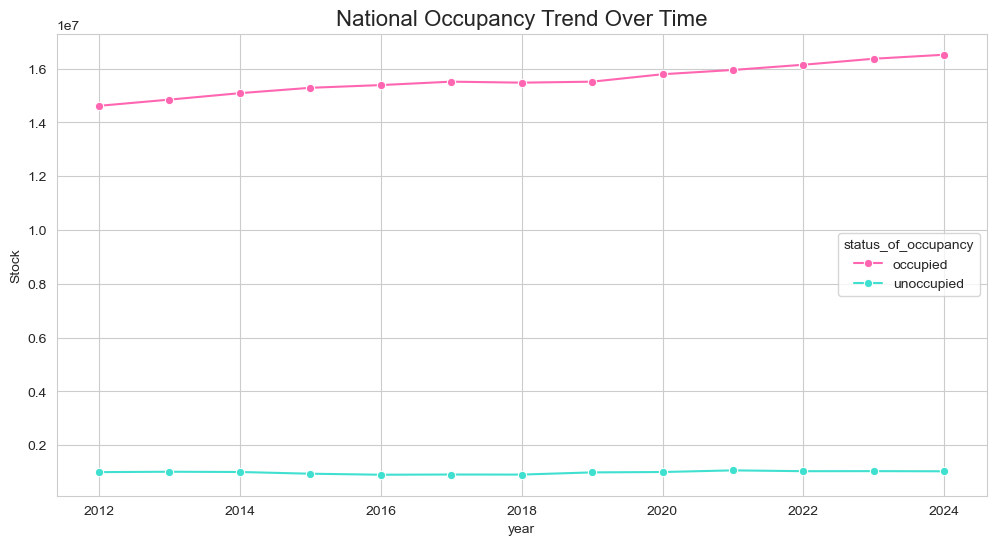

In [350]:
sns.set_style("whitegrid")
sns.set_palette(["#ff66b2", "#40e0d0"])  # pink, turquoise

trend = (
    occ_status_by_region_year_df
    .groupby(["year", "status_of_occupancy"])["stock"]
    .sum()
    .reset_index()
)

plt.figure(figsize=(12,6))
sns.lineplot(data=trend, x="year", y="stock",
             hue="status_of_occupancy", marker="o")
plt.title("National Occupancy Trend Over Time", fontsize=16)
plt.ylabel("Stock")
plt.show()

C:\Users\gabyt\AppData\Local\Temp\ipykernel_40496\1141026389.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top10, x="region", y="stock", palette=["#ff66b2", "#40e0d0"])
C:\Users\gabyt\AppData\Local\Temp\ipykernel_40496\1141026389.py:11: UserWarning: 
The palette list has fewer values (2) than needed (10) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(data=top10, x="region", y="stock", palette=["#ff66b2", "#40e0d0"])


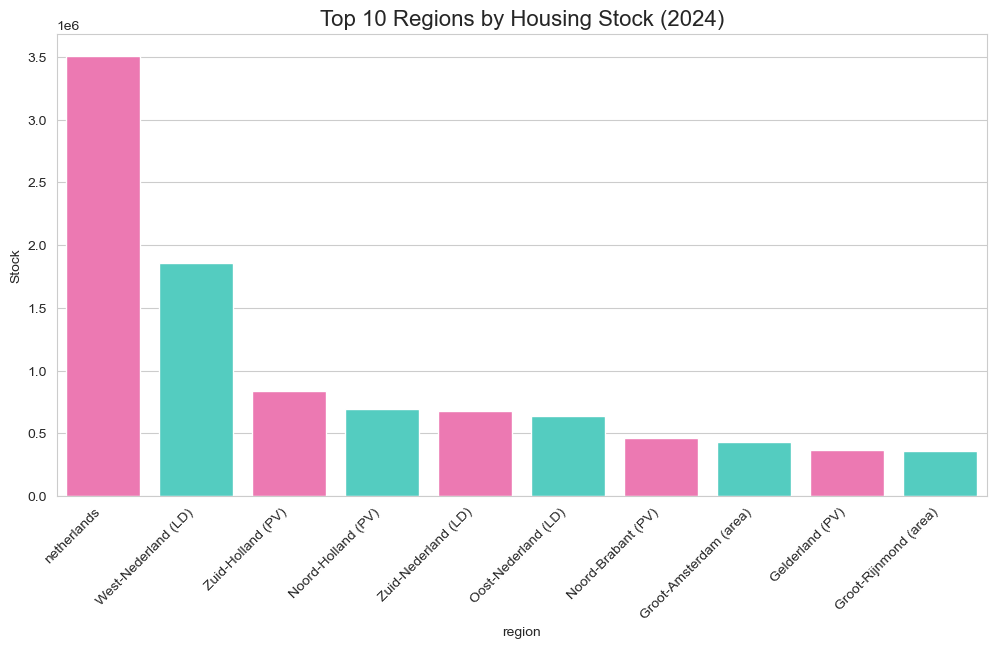

In [351]:
latest_year = occ_status_by_region_year_df["year"].max()

top10 = (
    occ_status_by_region_year_df.query("year == @latest_year")
    .groupby("region")["stock"].sum()
    .nlargest(10)
    .reset_index()
)

plt.figure(figsize=(12,6))
sns.barplot(data=top10, x="region", y="stock", palette=["#ff66b2", "#40e0d0"])
plt.title(f"Top 10 Regions by Housing Stock ({latest_year})", fontsize=16)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Stock")
plt.show()

## Chi-Square

In [ ]:
# helpers
# ---------- weighted contingency helper ----------
def weighted_crosstab(df, row, col, weight="amount_immigrant",
                      top_n_row=None, top_n_col=None, dropna=True):
    """Build a weighted contingency table (rows x cols)."""
    data = df[[row, col, weight]].copy()
    if dropna:
        data = data.dropna(subset=[row, col, weight])
    data[weight] = pd.to_numeric(data[weight], errors="coerce").fillna(0)

    def _top(series, w, n, other="other"):
        if n is None:
            return series
        totals = w.groupby(series).sum().sort_values(ascending=False)
        keep = set(totals.head(n).index)
        return series.where(series.isin(keep), other)

    if top_n_row is not None:
        data[row] = _top(data[row], data[weight], top_n_row)
    if top_n_col is not None:
        data[col] = _top(data[col], data[weight], top_n_col)

    ct = pd.pivot_table(
        data, index=row, columns=col, values=weight, aggfunc="sum", fill_value=0
    )
    return ct

# ---------- combine all domains once ----------
def _prep(df, domain):
    base_cols = ["id","gender","age","nationality","motive","status",
                 "stay_duration_years","immigration_year","amount_immigrant"]
    out = df.copy()
    out["domain"] = domain
    for c in base_cols:
        if c not in out.columns:
            out[c] = pd.NA
    return out[base_cols + ["domain"]]

frames = []
if "family_final" in globals(): frames.append(_prep(family_final, "family"))
if "study_final"  in globals(): frames.append(_prep(study_final,  "study"))
if "work_final"   in globals(): frames.append(_prep(work_final,   "work"))
if "asylum_final" in globals(): frames.append(_prep(asylum_final, "asylum"))

immigration_all = pd.concat(frames, ignore_index=True)
immigration_all["amount_immigrant"] = pd.to_numeric(
    immigration_all["amount_immigrant"], errors="coerce"
).fillna(0)
immigration_all = immigration_all[immigration_all["amount_immigrant"] > 0]


In [ ]:
# === χ² test helpers ===
def chi_square_test(df, row, col, weight="amount_immigrant",
                    top_n_row=None, top_n_col=None):
    """
    Weighted χ² test between two categoricals.
    Returns: dict with chi2, p, dof, n, contingency and expected tables.
    """
    ct = weighted_crosstab(df, row, col, weight, top_n_row, top_n_col)
    table = ct.values.astype(float)
    chi2, p, dof, expected = chi2_contingency(table, correction=False)
    return {
        "row": row, "col": col, "chi2": chi2, "p_value": p, "dof": dof,
        "n": table.sum(), "table": ct, 
        "expected": pd.DataFrame(expected, index=ct.index, columns=ct.columns)
    }

def show_chi_square(res, preview=(12,12)):
    r, c = res["row"], res["col"]
    print(f"χ² test: {r} × {c}")
    print(f"  n={int(res['n']):,} | dof={res['dof']} | chi2={res['chi2']:.1f} | p≈{res['p_value']:.2e}")
    t = res["table"]
    if t.shape[0] > preview[0] or t.shape[1] > preview[1]:
        print("(preview of contingency table)")
        display(t.iloc[:preview[0], :preview[1]].style.format("{:,.0f}"))
    else:
        display(t.style.format("{:,.0f}"))

In [ ]:
# Overall (ALL domains)
res = chi_square_test(
    immigration_all, "gender", "nationality",
    top_n_row=None, top_n_col=15  # many nationalities -> keep top 15
)
show_chi_square(res)

# Per domain
for dom in ["family","study","work","asylum"]:
    print("\n" + "="*70)
    print(f"DOMAIN: {dom}")
    sub = immigration_all.query("domain == @dom")
    if sub.empty: 
        print("no data"); 
        continue
    res = chi_square_test(sub, "age", "nationality", top_n_col=15)
    show_chi_square(res)

χ² test: gender × nationality
  n=23,542,065 | dof=15 | chi2=548999.2 | p≈0.00e+00
(preview of contingency table)



DOMAIN: family
χ² test: age × nationality
  n=16,047,155 | dof=60 | chi2=1443242.5 | p≈0.00e+00
(preview of contingency table)



DOMAIN: study
χ² test: age × nationality
  n=921,460 | dof=60 | chi2=220918.2 | p≈0.00e+00
(preview of contingency table)



DOMAIN: work
χ² test: age × nationality
  n=3,239,000 | dof=60 | chi2=87987.1 | p≈0.00e+00
(preview of contingency table)



DOMAIN: asylum
χ² test: age × nationality
  n=3,334,450 | dof=60 | chi2=509250.3 | p≈0.00e+00
(preview of contingency table)


In [ ]:
def plot_chi_square_heatmaps(res, annotate_top=12):
    """
    Draw two heatmaps:
      1) χ² cell contributions  ( (O-E)^2 / E )
      2) Standardized residuals ( (O-E) / sqrt(E) )
    annotate_top: number of highest-contributing cells to label with their % of total χ²
    """
    obs_df = res["table"]
    exp_df = res["expected"]
    obs = obs_df.values.astype(float)
    exp = exp_df.values.astype(float)

    # contributions and residuals
    contrib = (obs - exp)**2 / np.where(exp == 0, np.nan, exp)
    contrib = np.nan_to_num(contrib, nan=0.0)
    resid = (obs - exp) / np.sqrt(np.where(exp == 0, np.nan, exp))
    resid = np.nan_to_num(resid, nan=0.0)

    share = (contrib / contrib.sum()) if contrib.sum() > 0 else np.zeros_like(contrib)

    # figure size adapts to table shape
    h = max(4, 0.35 * obs_df.shape[0] + 2)
    w = max(6, 0.35 * obs_df.shape[1] + 3)
    fig = plt.figure(figsize=(w, 2*h))

    # 1) χ² contributions
    ax1 = plt.subplot(2, 1, 1)
    im1 = ax1.imshow(contrib)
    plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)
    ax1.set_title(
        f"χ² cell contributions — {res['row']} × {res['col']}\n"
        f"χ²={res['chi2']:.1f}, dof={res['dof']}, p≈{res['p_value']:.2e}"
    )
    ax1.set_xticks(range(obs_df.shape[1])); ax1.set_xticklabels(obs_df.columns, rotation=45, ha="right")
    ax1.set_yticks(range(obs_df.shape[0])); ax1.set_yticklabels(obs_df.index)

    # annotate top contributors with % of total χ²
    if annotate_top and contrib.size:
        flat = share.flatten()
        k = min(annotate_top, flat.size)
        top_idx = np.argpartition(flat, -k)[-k:]
        for idx in top_idx:
            i, j = np.unravel_index(idx, share.shape)
            ax1.text(j, i, f"{share[i, j]*100:.1f}%", ha="center", va="center", fontsize=8)

    # 2) Standardized residuals (sign shows over/under representation)
    ax2 = plt.subplot(2, 1, 2)
    im2 = ax2.imshow(resid)
    plt.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)
    ax2.set_title("Standardized residuals (positive=overrepresented, negative=underrepresented)")
    ax2.set_xticks(range(obs_df.shape[1])); ax2.set_xticklabels(obs_df.columns, rotation=45, ha="right")
    ax2.set_yticks(range(obs_df.shape[0])); ax2.set_yticklabels(obs_df.index)

    fig.tight_layout()
    plt.show()


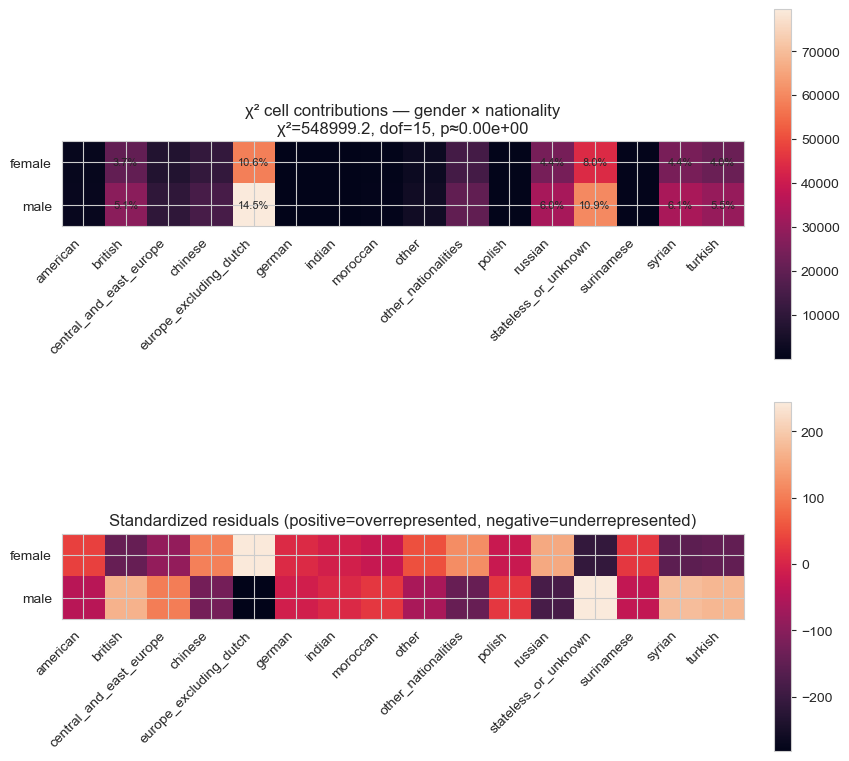

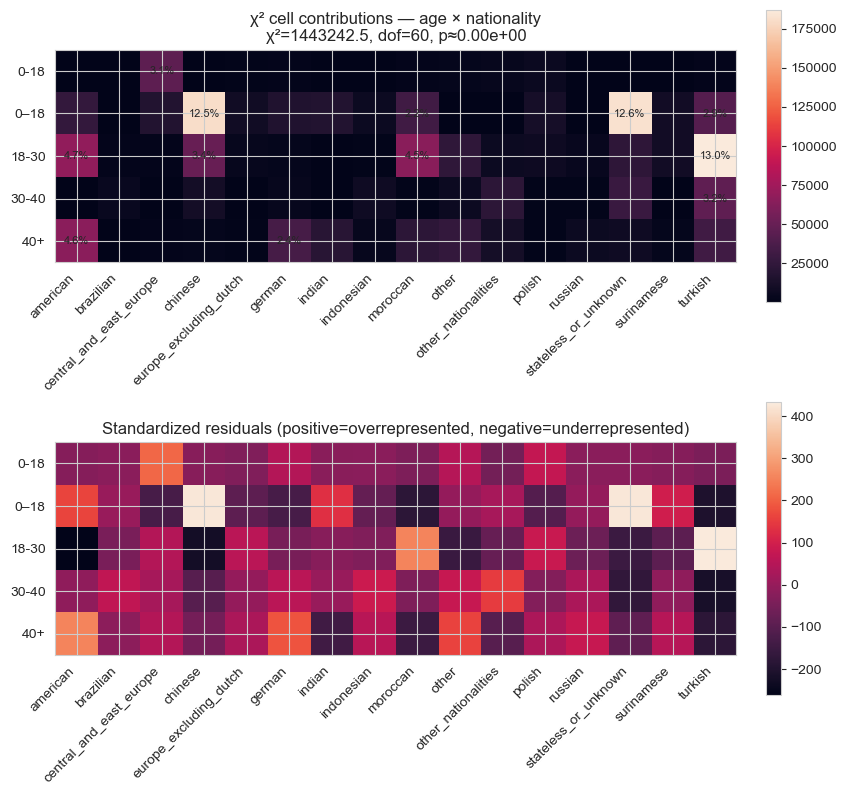

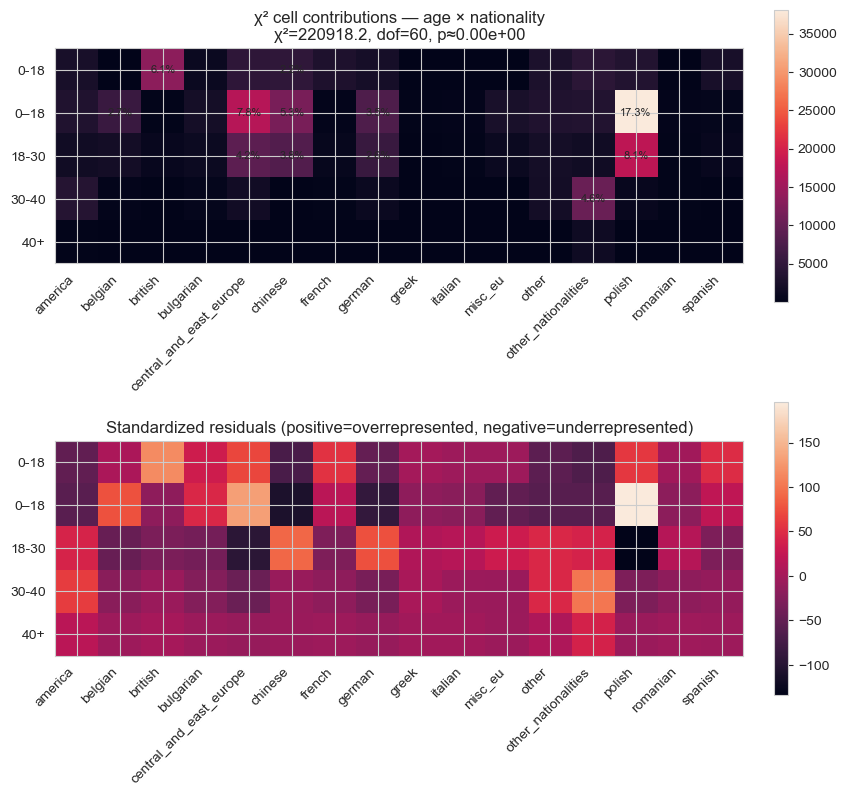

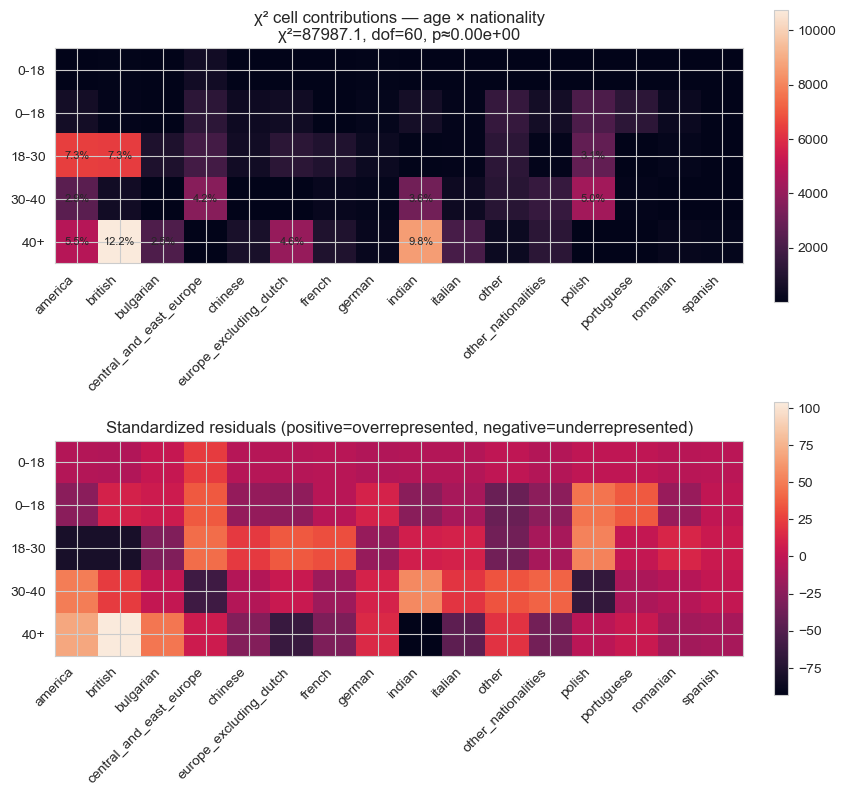

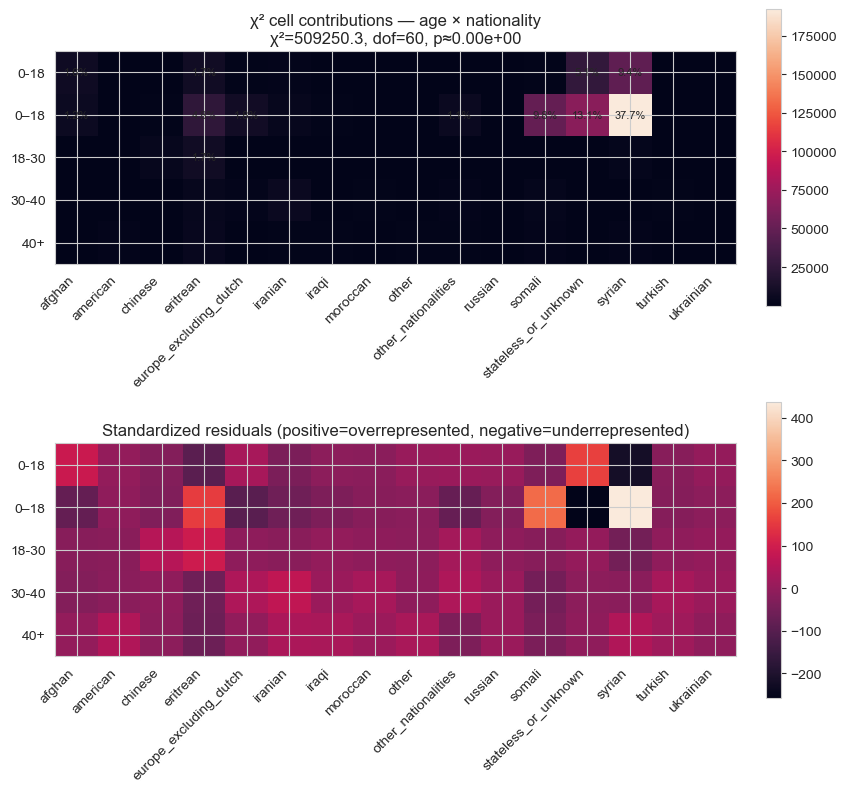

In [ ]:
# example: overall
res = chi_square_test(immigration_all, "gender", "nationality", top_n_col=15)
plot_chi_square_heatmaps(res)

# per domain
for dom in ["family","study","work","asylum"]:
    sub = immigration_all.query("domain == @dom")
    if not sub.empty:
        res = chi_square_test(sub, "age", "nationality", top_n_col=15)
        plot_chi_square_heatmaps(res)

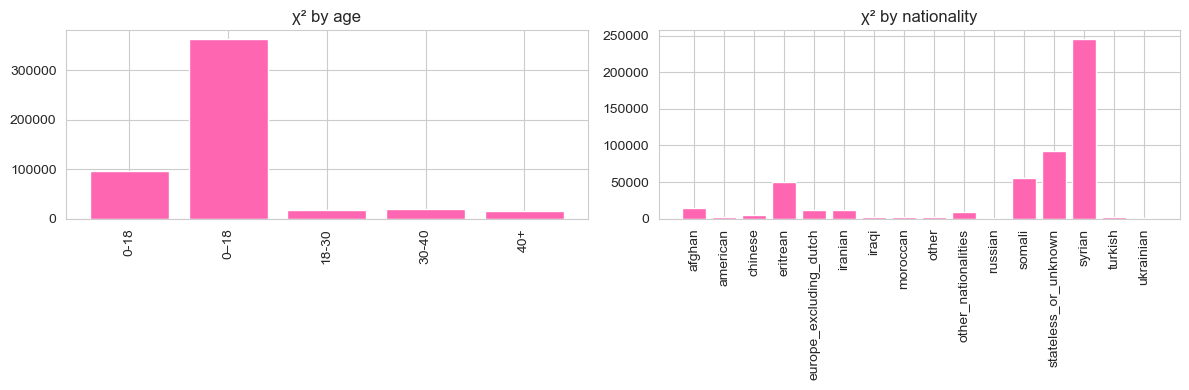

In [ ]:
def plot_row_col_contributions(res):
    """Bar charts of total χ² contribution by row and by column."""
    import matplotlib.pyplot as plt
    obs = res["table"].values.astype(float)
    exp = res["expected"].values.astype(float)
    contrib = (obs - exp)**2 / np.where(exp == 0, np.nan, exp)
    contrib = np.nan_to_num(contrib, nan=0.0)

    by_row = contrib.sum(axis=1)
    by_col = contrib.sum(axis=0)

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    axes[0].bar(range(len(by_row)), by_row)
    axes[0].set_xticks(range(len(by_row))); axes[0].set_xticklabels(res["table"].index, rotation=90)
    axes[0].set_title(f"χ² by {res['row']}")

    axes[1].bar(range(len(by_col)), by_col)
    axes[1].set_xticks(range(len(by_col))); axes[1].set_xticklabels(res["table"].columns, rotation=90)
    axes[1].set_title(f"χ² by {res['col']}")

    fig.tight_layout()
    plt.show()
plot_row_col_contributions(res)

## Cramers-V

In [ ]:
# === Cramér's V (bias-corrected) ===
def cramers_v_corrected_from_table(table: np.ndarray) -> float:
    chi2, _, _, _ = chi2_contingency(table, correction=False)
    n = table.sum()
    if n == 0:
        return np.nan
    r, k = table.shape
    phi2      = chi2 / n
    phi2_corr = max(0, phi2 - ((k-1)*(r-1)) / (n-1))
    r_corr    = r - ((r-1)**2) / (n-1)
    k_corr    = k - ((k-1)**2) / (n-1)
    denom     = min((k_corr-1), (r_corr-1))
    if denom <= 0:
        return np.nan
    return np.sqrt(phi2_corr / denom)

def cramers_v_test(df, row, col, weight="amount_immigrant",
                   top_n_row=None, top_n_col=None):
    """
    Weighted Cramér's V between two categoricals (bias-corrected).
    """
    ct = weighted_crosstab(df, row, col, weight, top_n_row, top_n_col)
    v = cramers_v_corrected_from_table(ct.values.astype(float))
    return {"row": row, "col": col, "cramers_v": v, "table": ct}

def show_cramers_v(res, preview=(12,12)):
    print(f"Cramér's V: {res['row']} × {res['col']}  ->  V = {res['cramers_v']:.3f}")
    t = res["table"]
    if t.shape[0] > preview[0] or t.shape[1] > preview[1]:
        print("(preview of contingency table)")
        display(t.iloc[:preview[0], :preview[1]].style.format("{:,.0f}"))
    else:
        display(t.style.format("{:,.0f}"))

In [ ]:
# Overall
res = cramers_v_test(
    immigration_all, "motive", "nationality", top_n_col=15
)
show_cramers_v(res)

# Per domain, a few useful pairs
pairs = [("age","nationality"), ("gender","nationality"), ("age","gender")]
for dom in ["family","study","work","asylum"]:
    print("\n" + "="*70)
    print(f"DOMAIN: {dom}")
    sub = immigration_all.query("domain == @dom")
    for a,b in pairs:
        if sub[a].notna().sum()==0 or sub[b].notna().sum()==0:
            continue
        res = cramers_v_test(sub, a, b, top_n_col=15 if b=="nationality" else None)
        show_cramers_v(res)

Cramér's V: motive × nationality  ->  V = 0.357
(preview of contingency table)



DOMAIN: family
Cramér's V: age × nationality  ->  V = 0.150
(preview of contingency table)


Cramér's V: gender × nationality  ->  V = 0.172
(preview of contingency table)


Cramér's V: age × gender  ->  V = 0.174



DOMAIN: study
Cramér's V: age × nationality  ->  V = 0.245
(preview of contingency table)


Cramér's V: gender × nationality  ->  V = 0.074
(preview of contingency table)


Cramér's V: age × gender  ->  V = 0.049



DOMAIN: work
Cramér's V: age × nationality  ->  V = 0.082
(preview of contingency table)


Cramér's V: gender × nationality  ->  V = 0.154
(preview of contingency table)


Cramér's V: age × gender  ->  V = 0.107



DOMAIN: asylum
Cramér's V: age × nationality  ->  V = 0.195
(preview of contingency table)


Cramér's V: gender × nationality  ->  V = 0.048
(preview of contingency table)


Cramér's V: age × gender  ->  V = 0.035


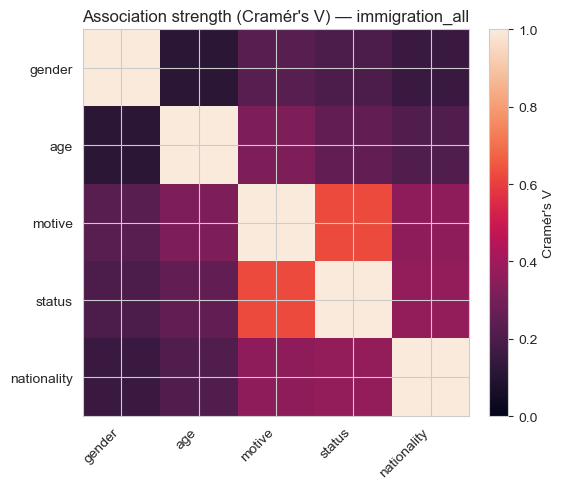

In [ ]:
vars_for_matrix = [v for v in ["gender","age","motive","status","nationality"] if v in immigration_all.columns]

def cramers_v_matrix(df, vars_list, top_n_nat=15):
    M = pd.DataFrame(index=vars_list, columns=vars_list, dtype=float)
    for a,b in itertools.product(vars_list, vars_list):
        if a == b:
            M.loc[a,b] = 1.0
            continue
        res = cramers_v_test(
            df, a, b, 
            top_n_row=top_n_nat if a=="nationality" else None,
            top_n_col=top_n_nat if b=="nationality" else None
        )
        M.loc[a,b] = res["cramers_v"]
    return M

vmat = cramers_v_matrix(immigration_all, vars_for_matrix, top_n_nat=15)

plt.figure(figsize=(6,5))
im = plt.imshow(vmat.values.astype(float), vmin=0, vmax=1)
plt.colorbar(im, fraction=0.046, pad=0.04, label="Cramér's V")
plt.xticks(range(len(vmat.columns)), vmat.columns, rotation=45, ha="right")
plt.yticks(range(len(vmat.index)), vmat.index)
plt.title("Association strength (Cramér's V) — immigration_all")
plt.tight_layout(); plt.show()

In [ ]:
def _chi2_from_crosstab(ct: pd.DataFrame) -> float:
    """Chi-square from a contingency table using SciPy (no Yates correction)."""
    chi2, p, dof, expected = ss.chi2_contingency(ct, correction=False)
    return float(chi2)

def cramers_v_corrected(ct: pd.DataFrame) -> float:
    """Bias-corrected Cramér's V (Bergsma, 2013) from a contingency table."""
    n = ct.values.sum()
    if n <= 0:
        return 0.0
    chi2 = _chi2_from_crosstab(ct)
    r, k = ct.shape
    phi2 = chi2 / n
    # bias correction
    phi2corr = max(0.0, phi2 - (k - 1) * (r - 1) / (n - 1))
    rcorr   = r - (r - 1) ** 2 / (n - 1)
    kcorr   = k - (k - 1) ** 2 / (n - 1)
    denom   = max(1e-12, min(kcorr - 1, rcorr - 1))
    return float(np.sqrt(phi2corr / denom))

def cramers_v(df: pd.DataFrame, col_a: str, col_b: str) -> float:
    """Cramér's V for two categorical columns in df (SciPy-backed)."""
    if col_a not in df.columns or col_b not in df.columns:
        return 0.0
    ct = pd.crosstab(df[col_a], df[col_b], dropna=True)
    if ct.size == 0:
        return 0.0
    return cramers_v_corrected(ct)

In [ ]:
def plot_cramers_ranked(df, cols, target, top=None):
    """Bar chart of Cramér's V(target, other) sorted descending."""
    others = [c for c in cols if c != target and c in df.columns]
    vals = [(c, cramers_v(df, target, c)) for c in others]
    s = pd.Series({c:v for c,v in vals}).sort_values(ascending=False)
    if top: s = s.head(top)

    plt.figure(figsize=(8, 0.45*len(s)+2))
    plt.barh(range(len(s)), s.values)
    plt.gca().invert_yaxis()
    plt.yticks(range(len(s)), s.index)
    plt.xlabel("Cramér's V")
    plt.title(f"Cramér's V with '{target}'")
    for i, v in enumerate(s.values):
        plt.text(v+0.01, i, f"{v:.2f}", va="center")
    plt.xlim(0, 1.02)
    plt.tight_layout()
    plt.show()

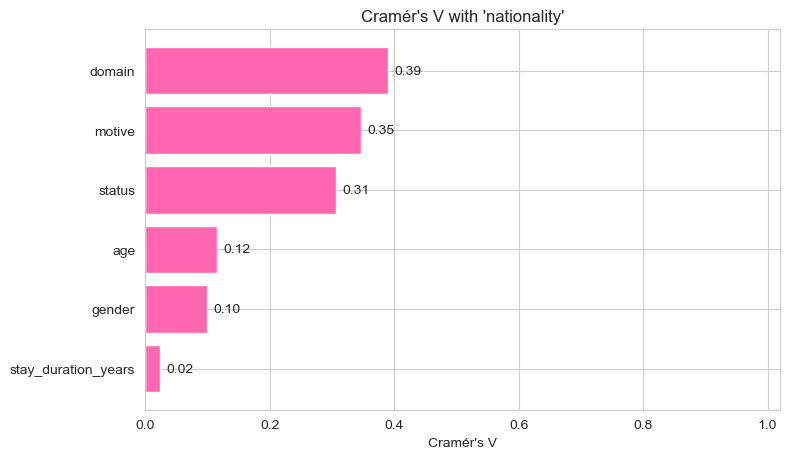

In [ ]:
cats = ["domain","gender","age","nationality","motive","status","stay_duration_years"]
plot_cramers_ranked(immigration_all, cats, target="nationality", top=12)

In [ ]:
def plot_cramers_triangle(df, cols, annotate=True):
    M = cramers_v_matrix(df, cols)
    # mask upper triangle
    mask = np.triu(np.ones_like(M, dtype=bool), k=1)
    data = np.ma.array(M.values, mask=mask)

    fig, ax = plt.subplots(figsize=(0.6*len(M)+3, 0.6*len(M)+3))
    im = ax.imshow(data, vmin=0, vmax=1)
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label="Cramér's V")

    ax.set_xticks(range(len(M))); ax.set_yticks(range(len(M)))
    ax.set_xticklabels(M.columns, rotation=45, ha="right"); ax.set_yticklabels(M.index)
    ax.set_title("Cramér's V (lower triangle)")

    if annotate:
        for i in range(len(M)):
            for j in range(i+1):
                val = M.iat[i, j]
                if i == j: continue
                ax.text(j, i, f"{val:.2f}", ha="center", va="center", fontsize=8)

    fig.tight_layout()
    plt.show()

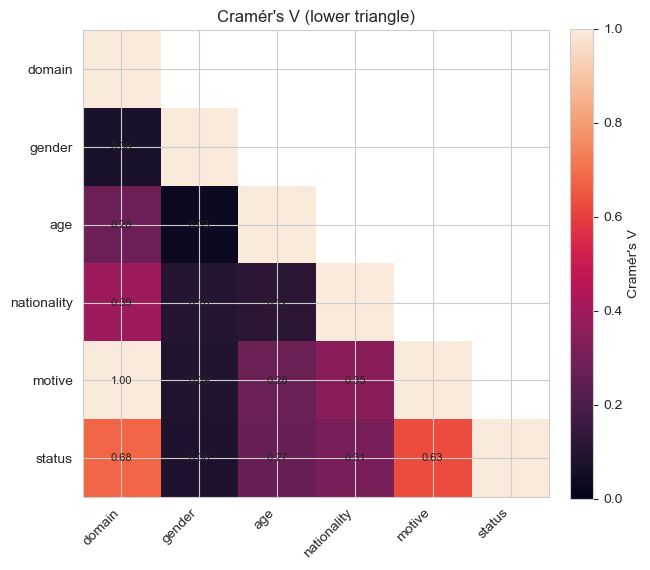

In [ ]:
plot_cramers_triangle(immigration_all, ["domain","gender","age","nationality","motive","status"])

In [ ]:
def plot_cramers_network(df, cols, threshold=0.15, kmax=None):
    """
    Build a graph where nodes are variables and edges connect pairs with
    Cramér's V >= threshold. Optionally keep the top-k strongest edges.
    """
    try:
        import networkx as nx
    except Exception:
        raise ImportError("Install networkx for this plot: pip install networkx")

    M = cramers_v_matrix(df, cols)
    pairs = []
    for i, a in enumerate(M.index):
        for j, b in enumerate(M.columns):
            if j <= i: continue
            v = M.loc[a, b]
            if v >= threshold:
                pairs.append((a, b, v))
    pairs.sort(key=lambda x: x[2], reverse=True)
    if kmax: pairs = pairs[:kmax]

    G = nx.Graph()
    for c in M.columns: G.add_node(c)
    for a, b, v in pairs: G.add_edge(a, b, weight=v)

    pos = nx.spring_layout(G, seed=42, k=0.5)
    w = np.array([G[u][v]['weight'] for u,v in G.edges()])
    widths = 2 + 6*(w - w.min()) / (w.max()-w.min() + 1e-9)

    plt.figure(figsize=(8, 6))
    nx.draw_networkx_nodes(G, pos, node_color="#334", node_size=1400)
    nx.draw_networkx_labels(G, pos, font_color="white")
    nx.draw_networkx_edges(G, pos, width=widths, edge_color=w, edge_cmap=plt.cm.plasma)
    sm = plt.cm.ScalarMappable(cmap=plt.cm.plasma, norm=plt.Normalize(vmin=w.min() if len(w) else 0, vmax=w.max() if len(w) else 1))
    sm.set_array([])
    plt.colorbar(sm, fraction=0.046, pad=0.04, label="Cramér's V")
    plt.title(f"Association network (V ≥ {threshold})")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_cramers_by_group(df, group_col, a, b, order=None):
    """
    Bar plot of Cramér's V(a,b) computed per group (e.g., per domain).
    """
    groups = (order if order is not None
              else list(pd.Series(df[group_col].dropna()).unique()))
    vals = []
    for g in groups:
        sub = df[df[group_col] == g]
        vals.append((g, cramers_v(sub, a, b) if not sub.empty else np.nan))
    s = pd.Series({g:v for g,v in vals})

    plt.figure(figsize=(8, 0.5*len(s)+2))
    plt.barh(range(len(s)), s.values)
    plt.gca().invert_yaxis()
    plt.yticks(range(len(s)), s.index)
    plt.xlabel("Cramér's V")
    plt.title(f"Cramér's V({a}, {b}) by {group_col}")
    for i, v in enumerate(s.values):
        if not np.isnan(v):
            plt.text(v+0.01, i, f"{v:.2f}", va="center")
    plt.xlim(0, 1.02)
    plt.tight_layout()
    plt.show()

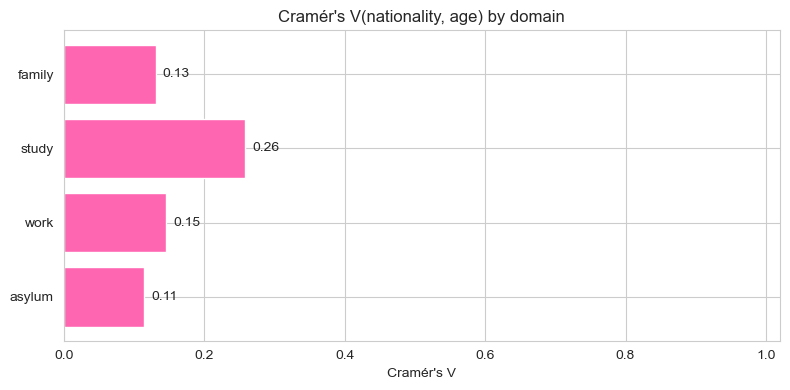

In [ ]:
# e.g., how strongly nationality relates to age within each domain
plot_cramers_by_group(immigration_all, "domain", a="nationality", b="age",
                      order=["family","study","work","asylum"])

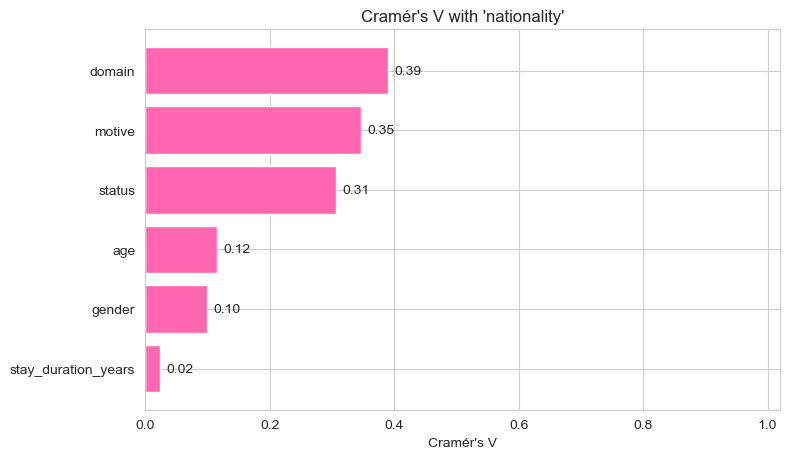

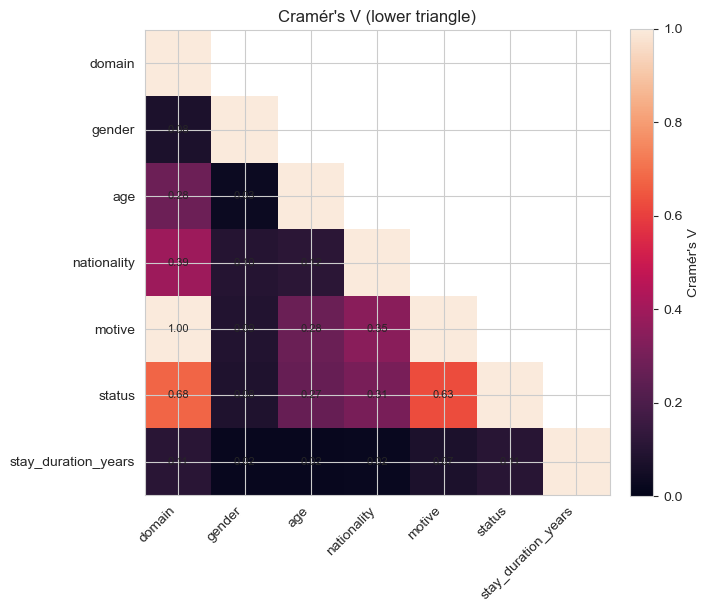

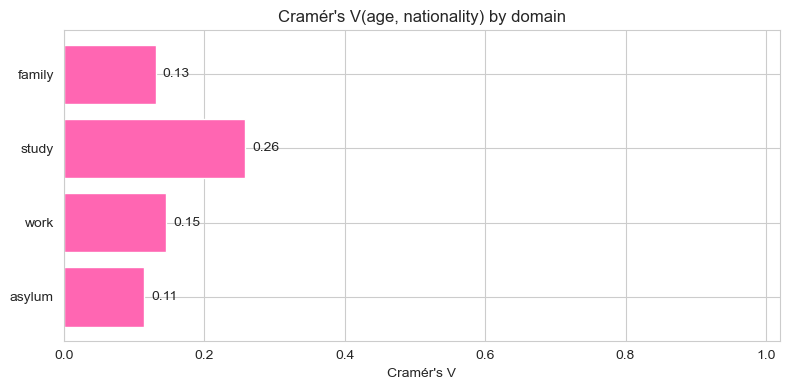

In [ ]:
cats = ["domain","gender","age","nationality","motive","status","stay_duration_years"]

# 1) ranked vs a target
plot_cramers_ranked(immigration_all, cats, target="nationality", top=10)

# 2) triangle heatmap
plot_cramers_triangle(immigration_all, cats)

# 4) by-domain comparison for a pair
plot_cramers_by_group(immigration_all, "domain", a="age", b="nationality",
                      order=["family","study","work","asylum"])

## KPI's

### Housing availability (vacancy) National and Region
- What % of stock is unoccupied, and how did it change?

In [358]:
# --- make numbers numeric & build stock ---
hs = housing_stock.copy()

for c in ["owned_by_association", "owned_by_other_landlords"]:
    hs[c] = pd.to_numeric(hs[c], errors="coerce")

hs["stock"] = hs["owned_by_association"].fillna(0) + hs["owned_by_other_landlords"].fillna(0)

# (optional) ensure period is int for sorting
hs["period"] = pd.to_numeric(hs["period"], errors="coerce").astype("Int64")

In [359]:
# use national rows (or drop the filter to aggregate all regions)
nat = hs[hs["regions"].str.lower() == "netherlands"].copy()

vac_by_year = (
    nat.groupby(["period", "status_of_occupancy"], as_index=False)["stock"].sum()
      .pivot(index="period", columns="status_of_occupancy", values="stock")
      .reindex(columns=["occupied","unoccupied"])  # nice order
      .fillna(0)
)

vac_by_year["vacancy_rate"] = (
    vac_by_year["unoccupied"] / (vac_by_year["occupied"] + vac_by_year["unoccupied"]).replace(0, np.nan)
)

baseline_year = int(vac_by_year.index.min())
latest_year   = int(vac_by_year.index.max())
vac_baseline  = float(vac_by_year.loc[baseline_year, "vacancy_rate"])
vac_latest    = float(vac_by_year.loc[latest_year,   "vacancy_rate"])
vac_change_pp = (vac_latest - vac_baseline) * 100

print(f"vacancy rate: {baseline_year}: {vac_baseline:.1%} → {latest_year}: {vac_latest:.1%} (Δ {vac_change_pp:+.1f} pp)")

vacancy rate: 2012: 6.4% → 2024: 5.9% (Δ -0.5 pp)


In [360]:
vac_pv = (
    hs.groupby(["regions","period","status_of_occupancy"], as_index=False)["stock"].sum()
      .pivot_table(index=["regions","period"], columns="status_of_occupancy",
                   values="stock", fill_value=0)
      .reset_index()
)

vac_pv["vacancy_rate"] = vac_pv["unoccupied"] / (vac_pv["occupied"] + vac_pv["unoccupied"]).replace(0, np.nan)

# latest-year snapshot for cards
latest = int(vac_pv["period"].max())
latest_vac = (vac_pv[vac_pv["period"] == latest]
              .sort_values("vacancy_rate", ascending=False)
              .loc[:, ["regions","vacancy_rate"]])
print(latest_vac.head(10))

status_of_occupancy                      regions  vacancy_rate
4640                             Schiermonnikoog      0.225352
3691                              Noord-Beveland      0.222414
5355                                       Veere      0.198046
1182                 Delfzijl en omgeving (area)      0.188727
1481                                   Eemsdelta      0.188727
4809                                       Sluis      0.180894
246                                      Ameland      0.165049
6057                                   Zandvoort      0.160449
5498                                    Vlieland      0.153266
4705                                  Simpelveld      0.145688


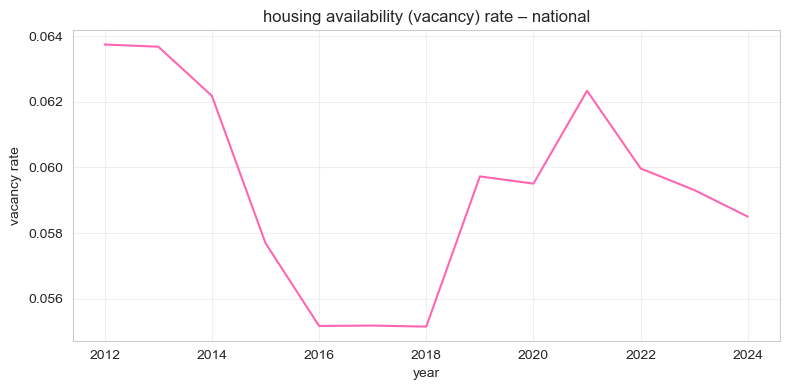

In [361]:
plt.figure(figsize=(8,4))
plt.plot(vac_by_year.index, vac_by_year["vacancy_rate"])
plt.title("housing availability (vacancy) rate – national")
plt.ylabel("vacancy rate")
plt.xlabel("year")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

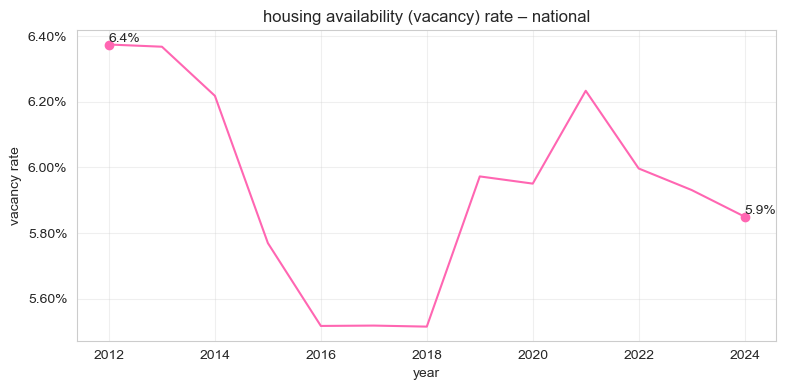

In [362]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

ax = vac_by_year["vacancy_rate"].plot(figsize=(8,4))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.set_title("housing availability (vacancy) rate – national")
ax.set_xlabel("year"); ax.set_ylabel("vacancy rate")
# annotate endpoints
y0 = vac_by_year.loc[baseline_year, "vacancy_rate"]
y1 = vac_by_year.loc[latest_year,   "vacancy_rate"]
plt.scatter([baseline_year, latest_year], [y0, y1])
plt.text(baseline_year, y0, f"{y0:.1%}", va="bottom")
plt.text(latest_year,   y1, f"{y1:.1%}", va="bottom")
plt.grid(True, alpha=.3); plt.tight_layout(); plt.show()


### Migration growth
- How fast did inflows grow?

In [364]:
# pick just the columns we need from each table
use_cols = ["immigration_year", "amount_immigrant"]

fam = family_final[use_cols].rename(columns={"amount_immigrant":"immigrants"})
stu = study_final [use_cols].rename(columns={"amount_immigrant":"immigrants"})
wrk = work_final  [use_cols].rename(columns={"amount_immigrant":"immigrants"})
asy = asylum_final[use_cols].rename(columns={"amount_immigrant":"immigrants"})

# concat all motives → total immigrants per row
immigration_all = pd.concat([fam, stu, wrk, asy], ignore_index=True)

# tidy types
immigration_all["immigration_year"] = pd.to_numeric(immigration_all["immigration_year"], errors="coerce").astype("Int64")
immigration_all["immigrants"]      = pd.to_numeric(immigration_all["immigrants"],      errors="coerce").fillna(0)

In [366]:
# level change over full span
first_year = int(im_by_year.index.min())
last_year  = int(im_by_year.index.max())
lvl_change = (im_by_year.loc[last_year, "immigrants"] /
              im_by_year.loc[first_year, "immigrants"] - 1) * 100

# CAGR over the last N observed points (not calendar fill)
window = 5  # use 5; lower it if you have fewer than 6 points
end_pos   = len(im_by_year.index) - 1
start_pos = max(0, end_pos - window)
start_year = int(im_by_year.index[start_pos])
n_steps = end_pos - start_pos  # number of intervals between start and end

if n_steps > 0 and im_by_year.loc[start_year, "immigrants"] > 0:
    cagr = (im_by_year.loc[last_year, "immigrants"] /
            im_by_year.loc[start_year, "immigrants"])**(1/n_steps) - 1
    print(f"immigration change {first_year}→{last_year}: {lvl_change:+.1f}% | "
          f"{start_year}→{last_year} CAGR: {cagr:.1%}")
else:
    print(f"immigration change {first_year}→{last_year}: {lvl_change:+.1f}%")
    
im_by_year["yoy"] = im_by_year["immigrants"].pct_change().mul(100)

immigration change 1999→2024: -95.7% | 2019→2024 CAGR: -34.0%


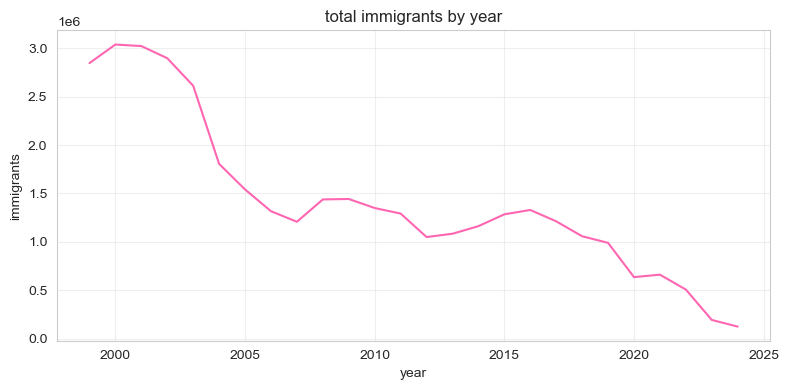

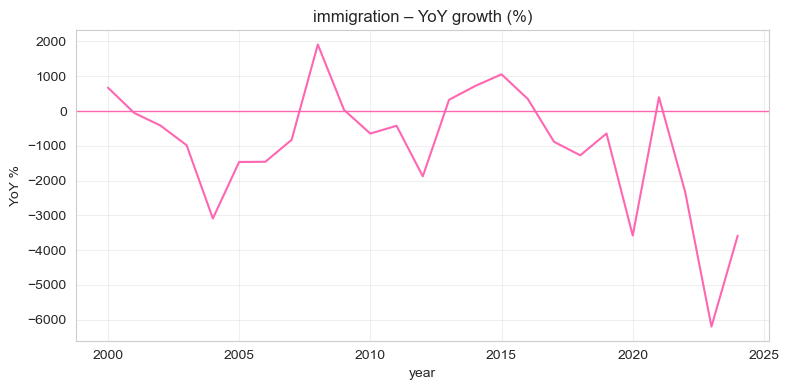

In [367]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(im_by_year.index, im_by_year["immigrants"])
plt.title("total immigrants by year")
plt.ylabel("immigrants"); plt.xlabel("year")
plt.grid(True, alpha=.3); plt.tight_layout(); plt.show()

plt.figure(figsize=(8,4))
plt.plot(im_by_year.index, im_by_year["yoy"]*100)
plt.axhline(0, lw=1)
plt.title("immigration – YoY growth (%)")
plt.ylabel("YoY %"); plt.xlabel("year")
plt.grid(True, alpha=.3); plt.tight_layout(); plt.show()

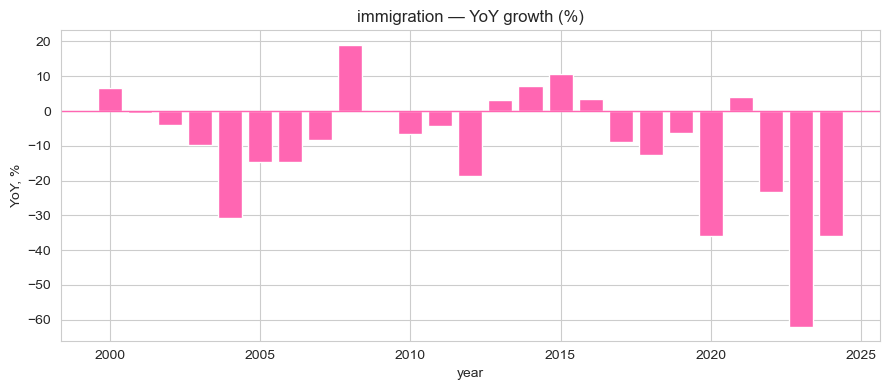

In [369]:
s = im_by_year["immigrants"].astype(float)
prev = s.shift(1)
yoy = (s - prev) / prev * 100
yoy[prev <= 0] = np.nan        # drop meaningless infinite % moves
im_by_year["yoy_pct"] = yoy

import matplotlib.pyplot as plt
plt.figure(figsize=(9,4))
plt.bar(im_by_year.index, im_by_year["yoy_pct"])
plt.axhline(0, lw=1)
plt.title("immigration — YoY growth (%)")
plt.ylabel("YoY, %"); plt.xlabel("year")
plt.tight_layout(); plt.show()

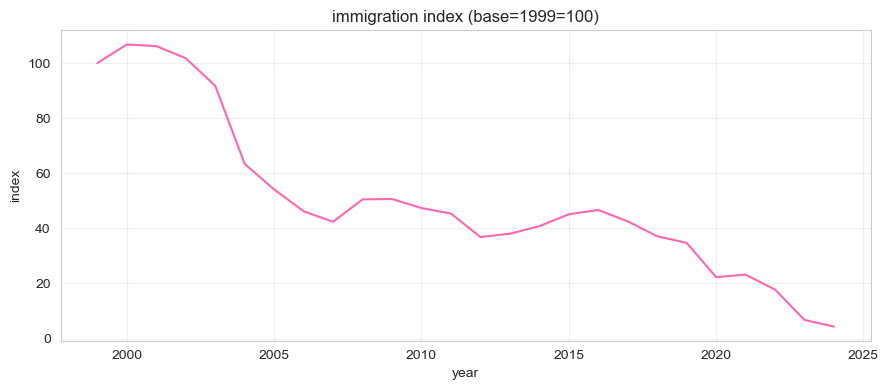

In [370]:
# index the level (clear story of trend)
base_year = int(im_by_year.index.min())
im_by_year["index_100"] = 100 * s / s.loc[base_year]

plt.figure(figsize=(9,4))
plt.plot(im_by_year.index, im_by_year["index_100"])
plt.title(f"immigration index (base={base_year}=100)")
plt.ylabel("index"); plt.xlabel("year")
plt.grid(True, alpha=.3); plt.tight_layout(); plt.show()

### Immigration vs housing availability year 2004 as example
- Do provinces/years with higher inflows have tighter availability?

In [374]:
hs = housing_stock.copy()
hs["stock"] = hs["owned_by_association"].fillna(0) + hs["owned_by_other_landlords"].fillna(0)

# vacancy pieces by region-period
vac_rp = (
    hs.groupby(["regions", "period", "status_of_occupancy"], as_index=False)["stock"].sum()
      .pivot(index=["regions", "period"], columns="status_of_occupancy", values="stock")
      .fillna(0)
      .reset_index()
)

# vacancy rate = unoccupied / (occupied + unoccupied)
vac_rp["vacancy_rate"] = vac_rp["unoccupied"] / (vac_rp["occupied"] + vac_rp["unoccupied"]).replace(0, np.nan)

In [375]:
provinces = [
    "Drenthe","Flevoland","Friesland","Gelderland","Groningen","Limburg",
    "Noord-Brabant","Noord-Holland","Overijssel","Utrecht","Zeeland","Zuid-Holland"
]
vac_prov = vac_rp[vac_rp["regions"].isin(provinces)].copy()

In [376]:
unocc_rp = (
    hs.query("status_of_occupancy == 'unoccupied'")
      .groupby(["regions","period"], as_index=False)["stock"].sum()
      .rename(columns={"stock":"unoccupied"})
)

In [377]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# make sure period is numeric for sorting/plotting
for df in (vac_rp, vac_prov, unocc_rp):
    df["period"] = pd.to_numeric(df["period"], errors="coerce")

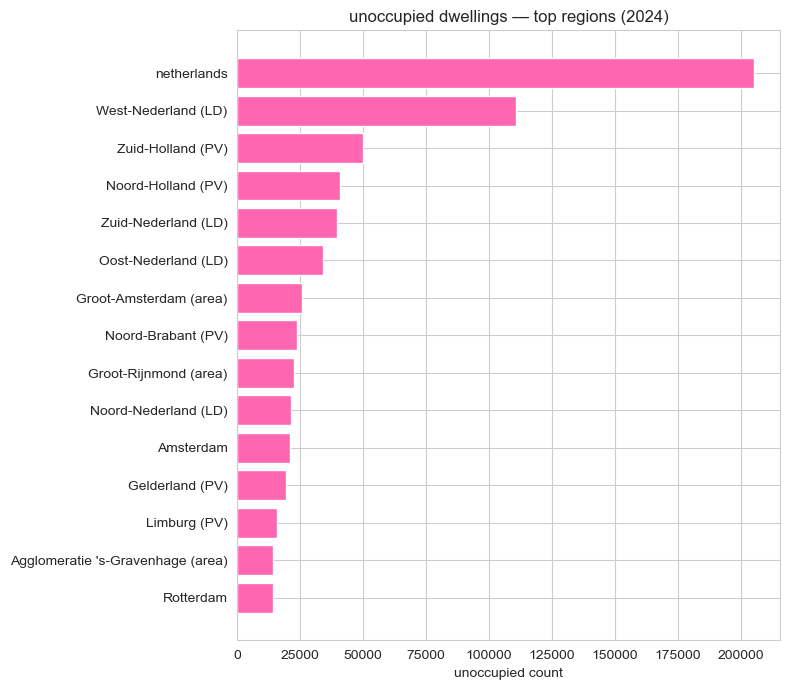

In [381]:
latest = int(unocc_rp["period"].max())
top = (unocc_rp[unocc_rp["period"] == latest]
       .sort_values("unoccupied", ascending=False).head(15))

plt.figure(figsize=(8,7))
plt.barh(top["regions"], top["unoccupied"])
plt.gca().invert_yaxis()
plt.title(f"unoccupied dwellings — top regions ({latest})")
plt.xlabel("unoccupied count")
plt.tight_layout(); plt.show()